In [ ]:
!pip install mediapipe
!pip install py7zr
!pip install tensorflow==2.4.0

In [ ]:
from pathlib import Path
from csv import writer
from numpy import array, zeros, concatenate, ndarray, expand_dims
import mediapipe as mp
from shutil import move, rmtree
import cv2, os, random, pickle, py7zr
import pandas as pd
from functools import reduce 
from tensorflow.keras.models import load_model
from cv2 import VideoCapture, waitKey, cvtColor, flip, COLOR_BGR2RGB, COLOR_RGB2BGR, VideoWriter_fourcc, VideoWriter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from os.path import split
from re import findall
from tqdm import tqdm
from time import sleep

In [ ]:
class Writer:
    temp_path = ''

    def write_to_csv(self, result: ndarray, out_csv: str):
        out_csv = Path(out_csv)

        with out_csv.open('a+') as csv:
            csv_writer = writer(csv)
            csv_writer.writerow(result)

    def write_as_video(self, path, image):
        if self.temp_path != path: 
            self.temp_path = path
            self.writer = VideoWriter(path, VideoWriter_fourcc('M','J','P','G'), 10, (640, 480))

        self.writer.write(image)


class ImageHandler:

    def draw_results(self, image, results):
        image.flags.writeable = True
        # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, landmark_drawing_spec=None, connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style())
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)

        return image


class Maker:

    def combine_csvs(self): pass

    def append_csvs_to_dir(self, dir_: Path, append_dir: Path):
        dir_ = Path(dir_)
        last_entry = list(dir_.glob('*'))[-1]

        last_entry_count = int(last_entry.name.split('_')[-1].split('.')[0])

        append_dir = Path(append_dir)
        for path in append_dir.glob('*'):
            last_entry_count += 1
            prefix = '_'.join(path.name.split('_')[:-1])
            name = path.parent / f"{prefix}_{last_entry_count}{path.suffix}"
            # print(prefix)
            # print(name)
            # path.rename('temp.csv')
            path.rename(name)
            # move(str(path), str(dir_))


class MediapipeExtractor:
    
    def extract_landmarks(self, results) -> ndarray:
        result_landmarks = {
            # 'face': {
            #     'landmark': results.face_landmarks,
            #     'shape': (468,)
            # },
            'left hand': {
                'landmark': results.left_hand_landmarks,
                'shape': (21,)
            },
            'right hand': {
                'landmark': results.right_hand_landmarks,
                'shape': (21,)
            },
            'pose': {
                'landmark': results.pose_landmarks,
                'shape': (33,)
            }
        }

        result_all = []
        result_temp = []
        for key, result in result_landmarks.items():
            if result['landmark']:
                result_temp = array([array([l.x, l.y, l.z]) for l in result['landmark'].landmark])
                result_temp = result_temp.flatten()
            else:
                result_temp = zeros((result['shape'][0] * 3, ))

            assert(result_temp.shape == (result['shape'][0] * 3, ))
            result_all.append(result_temp)
            
        shape = 0
        result_final = array([])
        for result in result_all:
            shape += result.shape[0]
            result_final = concatenate((result_final, result), axis=0)

        assert(result_final.shape == (shape,))

        return result_final

In [ ]:
mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic
me = MediapipeExtractor()
im = ImageHandler()
w = Writer()
final_pred_list = []
final_list = []
final_final_pred_list = []
final_final_list = []
QR = []         #list of frames
final_pred_list1 = []
final_list1 = []
final_final_pred_list1 = []
final_final_list1 = []

# Source directory and model file location

In [ ]:
path_to_source_folder = '/content/drive/MyDrive/20_classtest_video.7z'
model = "/content/drive/MyDrive/20frame_17class_noface_model/model49"
model = load_model(str(model))

In [ ]:
make_dir = Path('/content/ASLdataset')
if make_dir.exists(): rmtree(make_dir)
make_dir.mkdir()

if findall('.7z', str(path_to_source_folder)):
    with py7zr.SevenZipFile(path_to_source_folder, mode='r') as z:
        z.extractall('/content/ASLdataset')
    path_to_source_folder = Path('/content/ASLdataset/20classtest')
elif findall('.zip', str(path_to_source_folder)):
    !unzip $path_to_source_folder -d /content/ASLdataset
    path_to_source_folder = Path('/content/ASLdataset/20classtest')
else:
    path_to_source_folder = Path(path_to_source_folder)

In [ ]:
path_to_source_folder = Path('/content/ASLdataset/20classtest')

# Checking for classes in source directory

In [ ]:
source_directory = path_to_source_folder
classes = sorted(list(x.name for x in source_directory.glob('*')))
if any('.ipynb_checkpoints' in s for s in classes):
    classes.remove('.ipynb_checkpoints')
print(classes)
classes = ['Address', 'Age', 'Class', 'How', 'Movie', 'Name', 'Phone', 'Play', 'Please', 'ThankYou', 'Time', 'What', 'When', 'Where', 'Work', 'You', 'Your']

['Address', 'Age', 'Class', 'ExcuseMe', 'Favourite', 'How', 'Movie', 'Name', 'Phone', 'Play', 'Please', 'School', 'ThankYou', 'Time', 'What', 'When', 'Where', 'Work', 'You', 'Your']


# Reading files in source directory

In [ ]:
all_source_ds = []      #source video location list
for category in classes:
    cat_dir = list((source_directory/category).glob("*"))
    all_source_ds.append(cat_dir)
# print(len(all_source_ds))  #GET READY FOR FLOOOD
counter_class = len(classes)
print(counter_class) 
progress = reduce(lambda count, l: count + len(l), all_source_ds, 0)
print(progress) 
pbar = tqdm(total=progress, bar_format ='{l_bar}{bar}|  {n_fmt}/{total_fmt}  [ Elapsed Time : {elapsed} | ETA : {remaining} ]', leave=True, position=0)

17
1700


  0%|          |  0/2000  [ Elapsed Time : 00:22 | ETA : ? ]


# Run again from here in case of an error

In [ ]:
progress = reduce(lambda count, l: count + len(l), all_source_ds, 0)
print(progress)
totvid = progress
pbar = tqdm(total=totvid, bar_format ='{l_bar}{bar}|  {n_fmt}/{total_fmt}  [ Elapsed Time : {elapsed} | ETA : {remaining} ]', leave=True, position=0)
final_pred_list1 = []
final_list1 = []
final_final_pred_list1 = []
final_final_list1 = []

final_pred_list = []
final_list = []
final_final_list =[]
final_final_pred_list =[]

1700


  0%|          |  0/1700  [ Elapsed Time : 01:04 | ETA : ? ]


# Prediction

In [ ]:
for i in range(len(classes)):
    category = classes[i]
    current_ds = all_source_ds[i]   #source video location of i'th class
    print("Videos loaded : ",len(current_ds))
    print("------------------------------------------------------------------------------------------")
    for j in range(len(current_ds)):
        cap = VideoCapture(str(current_ds[j]))
        frame_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))        
        klass = category
        out_prefix = klass 
        with mp_holistic.Holistic(
            min_detection_confidence = 0.5,
            min_tracking_confidence = 0.5
        ) as holistic:
            while cap.isOpened() and frame_length!=0:
                image: ndarray
                success, image = cap.read()
                if not success: continue
                image = flip(image, 1)

                image = cvtColor(image, COLOR_BGR2RGB)

                image.flags.writeable = False
                results = holistic.process(image)
                image = cvtColor(image, COLOR_RGB2BGR)
                image = im.draw_results(image, results)
                landmarks = me.extract_landmarks(results)
                QR.append(landmarks)
                frame_length-=1
        random_number = random.randint(1,20)
        QR_vid = expand_dims(array(QR[random_number:random_number+30]), 0)
        if QR_vid.shape == (1,30,225):
            results = model.predict(QR_vid)
            # print(results)
            results = array(results).mean(axis=0)
            predicted_kls = classes[results.argmax(axis=0)]
            print("\n" + "Predicted class : " + predicted_kls + "   " + str(current_ds[j])+"    "+str(random_number)+":"+str(random_number+30))
            final_pred_list.append(predicted_kls)
            final_list.append(split(split(current_ds[j])[0])[1])

            # results = model1.predict(QR_vid)
            # results = array(results).mean(axis=0)
            # predicted_kls = classes[results.argmax(axis=0)]
            # print(predicted_kls + "  92acc  " + str(current_ds[j]))
            # final_pred_list1.append(predicted_kls)
            # final_list1.append(split(split(current_ds[j])[0])[1])

            print( "Actual class    :"  , str(split(split(current_ds[j])[0])[1]) )
            pbar.update(1)
            print("------------------------------------------------------------------------------------------")

        else:
            print("WRONG SHAPE VIDEO"+ str(current_ds[j]) +str(j) + str(QR_vid.shape))
        progress -= 1
        QR = []
        if waitKey(5) & 0xFF == 27: break # 27 is escape!
    final_final_pred_list.append(final_pred_list)
    # final_final_pred_list1.append(final_pred_list1)

    file1 = open("final_pred_list.txt","a")
    file1.write("\n")
    file1.write(str(final_pred_list))
    file1.close()
    final_pred_list =[]
    # final_pred_list1 =[]

    final_final_list.append(final_list)
    # final_final_list1.append(final_list1)
    
    file2 = open("final_list.txt","a")
    file2.write("\n")
    file2.write(str(final_list))
    file2.close()
    final_list =[]
    # final_list1 =[]
    cap.release() 

Videos loaded :  100
------------------------------------------------------------------------------------------


  0%|          |  1/1700  [ Elapsed Time : 00:09 | ETA : 4:22:04 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/207192.avi    15:45
Actual class    : Address
------------------------------------------------------------------------------------------


  0%|          |  2/1700  [ Elapsed Time : 00:14 | ETA : 3:21:12 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/379680.avi    12:42
Actual class    : Address
------------------------------------------------------------------------------------------


  0%|          |  3/1700  [ Elapsed Time : 00:19 | ETA : 2:53:09 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/355600.avi    2:32
Actual class    : Address
------------------------------------------------------------------------------------------


  0%|          |  4/1700  [ Elapsed Time : 00:24 | ETA : 2:40:27 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/897926.avi    13:43
Actual class    : Address
------------------------------------------------------------------------------------------


  0%|          |  5/1700  [ Elapsed Time : 00:30 | ETA : 2:36:23 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/873273.avi    1:31
Actual class    : Address
------------------------------------------------------------------------------------------


  0%|          |  6/1700  [ Elapsed Time : 00:35 | ETA : 2:35:15 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/766234.avi    11:41
Actual class    : Address
------------------------------------------------------------------------------------------


  0%|          |  7/1700  [ Elapsed Time : 00:40 | ETA : 2:31:03 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/697182.avi    17:47
Actual class    : Address
------------------------------------------------------------------------------------------


  0%|          |  8/1700  [ Elapsed Time : 00:45 | ETA : 2:24:48 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/697982.avi    18:48
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|          |  9/1700  [ Elapsed Time : 00:50 | ETA : 2:26:26 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/497252.avi    20:50
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|          |  10/1700  [ Elapsed Time : 00:55 | ETA : 2:24:33 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/916256.avi    3:33
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|          |  11/1700  [ Elapsed Time : 01:00 | ETA : 2:26:36 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/426948.avi    4:34
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|          |  12/1700  [ Elapsed Time : 01:05 | ETA : 2:20:41 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/346614.avi    3:33
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|          |  13/1700  [ Elapsed Time : 01:10 | ETA : 2:25:02 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/553981.avi    15:45
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|          |  14/1700  [ Elapsed Time : 01:16 | ETA : 2:25:47 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/978393.avi    13:43
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|          |  15/1700  [ Elapsed Time : 01:21 | ETA : 2:28:49 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/988627.avi    19:49
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|          |  16/1700  [ Elapsed Time : 01:27 | ETA : 2:29:38 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/907952.avi    13:43
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|          |  17/1700  [ Elapsed Time : 01:32 | ETA : 2:28:58 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/741090.avi    7:37
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|          |  18/1700  [ Elapsed Time : 01:37 | ETA : 2:30:20 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/295887.avi    4:34
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|          |  19/1700  [ Elapsed Time : 01:42 | ETA : 2:26:41 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/575003.avi    20:50
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|          |  20/1700  [ Elapsed Time : 01:47 | ETA : 2:25:18 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/390365.avi    6:36
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|          |  21/1700  [ Elapsed Time : 01:52 | ETA : 2:17:15 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/410787.avi    5:35
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|▏         |  22/1700  [ Elapsed Time : 01:57 | ETA : 2:19:01 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/335994.avi    19:49
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|▏         |  23/1700  [ Elapsed Time : 02:02 | ETA : 2:24:00 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/931591.avi    19:49
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|▏         |  24/1700  [ Elapsed Time : 02:07 | ETA : 2:23:10 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/276312.avi    12:42
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|▏         |  25/1700  [ Elapsed Time : 02:13 | ETA : 2:26:09 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/325646.avi    14:44
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         |  26/1700  [ Elapsed Time : 02:18 | ETA : 2:22:53 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/329408.avi    19:49
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         |  27/1700  [ Elapsed Time : 02:23 | ETA : 2:24:29 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/879858.avi    18:48
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         |  28/1700  [ Elapsed Time : 02:29 | ETA : 2:25:51 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/166023.avi    7:37
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         |  29/1700  [ Elapsed Time : 02:34 | ETA : 2:28:07 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/187786.avi    4:34
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         |  30/1700  [ Elapsed Time : 02:39 | ETA : 2:27:34 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/180159.avi    14:44
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         |  31/1700  [ Elapsed Time : 02:45 | ETA : 2:28:20 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/178779.avi    13:43
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         |  32/1700  [ Elapsed Time : 02:51 | ETA : 2:36:44 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/239478.avi    16:46
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         |  33/1700  [ Elapsed Time : 02:56 | ETA : 2:26:53 ]


Predicted class : Your   /content/ASLdataset/20classtest/Address/319247.avi    6:36
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         |  34/1700  [ Elapsed Time : 03:01 | ETA : 2:29:33 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/706261.avi    4:34
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         |  35/1700  [ Elapsed Time : 03:07 | ETA : 2:30:54 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/981557.avi    19:49
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         |  36/1700  [ Elapsed Time : 03:12 | ETA : 2:32:05 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/660285.avi    16:46
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         |  37/1700  [ Elapsed Time : 03:17 | ETA : 2:28:55 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/496403.avi    12:42
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         |  38/1700  [ Elapsed Time : 03:23 | ETA : 2:30:54 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/559608.avi    10:40
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         |  39/1700  [ Elapsed Time : 03:28 | ETA : 2:30:20 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/623619.avi    15:45
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         |  40/1700  [ Elapsed Time : 03:34 | ETA : 2:31:26 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/671161.avi    16:46
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         |  41/1700  [ Elapsed Time : 03:39 | ETA : 2:26:57 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/609604.avi    16:46
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         |  42/1700  [ Elapsed Time : 03:44 | ETA : 2:24:51 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/634008.avi    13:43
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         |  43/1700  [ Elapsed Time : 03:50 | ETA : 2:27:50 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/738524.avi    20:50
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         |  44/1700  [ Elapsed Time : 03:55 | ETA : 2:27:21 ]


Predicted class : Work   /content/ASLdataset/20classtest/Address/317699.avi    1:31
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         |  45/1700  [ Elapsed Time : 04:00 | ETA : 2:28:53 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/395018.avi    4:34
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         |  46/1700  [ Elapsed Time : 04:06 | ETA : 2:28:27 ]


Predicted class : You   /content/ASLdataset/20classtest/Address/591608.avi    2:32
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         |  47/1700  [ Elapsed Time : 04:11 | ETA : 2:24:55 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/150917.avi    3:33
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         |  48/1700  [ Elapsed Time : 04:16 | ETA : 2:25:33 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/774723.avi    8:38
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         |  49/1700  [ Elapsed Time : 04:21 | ETA : 2:24:16 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/464885.avi    19:49
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         |  50/1700  [ Elapsed Time : 04:27 | ETA : 2:25:38 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/708248.avi    7:37
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         |  51/1700  [ Elapsed Time : 04:32 | ETA : 2:27:55 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/776633.avi    6:36
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         |  52/1700  [ Elapsed Time : 04:38 | ETA : 2:28:45 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/961457.avi    16:46
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         |  53/1700  [ Elapsed Time : 04:43 | ETA : 2:30:34 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/409906.avi    18:48
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         |  54/1700  [ Elapsed Time : 04:48 | ETA : 2:26:02 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/542611.avi    1:31
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         |  55/1700  [ Elapsed Time : 04:54 | ETA : 2:27:52 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/496329.avi    2:32
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         |  56/1700  [ Elapsed Time : 04:59 | ETA : 2:23:00 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/196136.avi    5:35
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         |  57/1700  [ Elapsed Time : 05:04 | ETA : 2:26:07 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/669298.avi    1:31
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         |  58/1700  [ Elapsed Time : 05:10 | ETA : 2:28:55 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/410454.avi    12:42
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         |  59/1700  [ Elapsed Time : 05:16 | ETA : 2:31:54 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/514080.avi    19:49
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▎         |  60/1700  [ Elapsed Time : 05:21 | ETA : 2:31:11 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/715296.avi    11:41
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▎         |  61/1700  [ Elapsed Time : 05:27 | ETA : 2:32:08 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/996626.avi    5:35
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▎         |  62/1700  [ Elapsed Time : 05:33 | ETA : 2:32:22 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/575329.avi    10:40
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▎         |  63/1700  [ Elapsed Time : 05:38 | ETA : 2:29:44 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/533481.avi    12:42
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▍         |  64/1700  [ Elapsed Time : 05:41 | ETA : 2:11:54 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/373045.avi    16:46
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▍         |  65/1700  [ Elapsed Time : 05:47 | ETA : 2:17:38 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/426249.avi    11:41
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▍         |  66/1700  [ Elapsed Time : 05:52 | ETA : 2:20:14 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/592117.avi    9:39
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▍         |  67/1700  [ Elapsed Time : 05:58 | ETA : 2:24:02 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/900798.avi    8:38
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▍         |  68/1700  [ Elapsed Time : 06:03 | ETA : 2:24:46 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/158849.avi    6:36
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▍         |  69/1700  [ Elapsed Time : 06:09 | ETA : 2:27:13 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/785147.avi    18:48
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▍         |  70/1700  [ Elapsed Time : 06:14 | ETA : 2:28:37 ]


Predicted class : What   /content/ASLdataset/20classtest/Address/690705.avi    3:33
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▍         |  71/1700  [ Elapsed Time : 06:19 | ETA : 2:24:12 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/729857.avi    15:45
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▍         |  72/1700  [ Elapsed Time : 06:25 | ETA : 2:26:12 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/541365.avi    2:32
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▍         |  73/1700  [ Elapsed Time : 06:30 | ETA : 2:25:48 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/137042.avi    7:37
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▍         |  74/1700  [ Elapsed Time : 06:35 | ETA : 2:22:10 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/677795.avi    13:43
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▍         |  75/1700  [ Elapsed Time : 06:40 | ETA : 2:20:29 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/707212.avi    13:43
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▍         |  76/1700  [ Elapsed Time : 06:46 | ETA : 2:23:28 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/559411.avi    15:45
Actual class    : Address
------------------------------------------------------------------------------------------


  5%|▍         |  77/1700  [ Elapsed Time : 06:51 | ETA : 2:25:42 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/293577.avi    11:41
Actual class    : Address
------------------------------------------------------------------------------------------


  5%|▍         |  78/1700  [ Elapsed Time : 06:57 | ETA : 2:23:55 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/437643.avi    14:44
Actual class    : Address
------------------------------------------------------------------------------------------


  5%|▍         |  79/1700  [ Elapsed Time : 07:01 | ETA : 2:19:44 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/731130.avi    14:44
Actual class    : Address
------------------------------------------------------------------------------------------


  5%|▍         |  80/1700  [ Elapsed Time : 07:06 | ETA : 2:15:26 ]


Predicted class : When   /content/ASLdataset/20classtest/Address/876474.avi    7:37
Actual class    : Address
------------------------------------------------------------------------------------------


  5%|▍         |  81/1700  [ Elapsed Time : 07:11 | ETA : 2:16:50 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/436305.avi    4:34
Actual class    : Address
------------------------------------------------------------------------------------------


  5%|▍         |  82/1700  [ Elapsed Time : 07:15 | ETA : 2:09:53 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/499721.avi    13:43
Actual class    : Address
------------------------------------------------------------------------------------------


  5%|▍         |  83/1700  [ Elapsed Time : 07:21 | ETA : 2:13:13 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/959808.avi    12:42
Actual class    : Address
------------------------------------------------------------------------------------------


  5%|▍         |  84/1700  [ Elapsed Time : 07:26 | ETA : 2:15:31 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/649636.avi    3:33
Actual class    : Address
------------------------------------------------------------------------------------------


  5%|▌         |  85/1700  [ Elapsed Time : 07:31 | ETA : 2:18:51 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/683484.avi    3:33
Actual class    : Address
------------------------------------------------------------------------------------------


  5%|▌         |  86/1700  [ Elapsed Time : 07:37 | ETA : 2:22:17 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/753776.avi    16:46
Actual class    : Address
------------------------------------------------------------------------------------------


  5%|▌         |  87/1700  [ Elapsed Time : 07:42 | ETA : 2:18:53 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/292122.avi    11:41
Actual class    : Address
------------------------------------------------------------------------------------------


  5%|▌         |  88/1700  [ Elapsed Time : 07:47 | ETA : 2:18:40 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/568393.avi    17:47
Actual class    : Address
------------------------------------------------------------------------------------------


  5%|▌         |  89/1700  [ Elapsed Time : 07:53 | ETA : 2:22:02 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/254485.avi    15:45
Actual class    : Address
------------------------------------------------------------------------------------------


  5%|▌         |  90/1700  [ Elapsed Time : 07:58 | ETA : 2:22:45 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/837191.avi    8:38
Actual class    : Address
------------------------------------------------------------------------------------------


  5%|▌         |  91/1700  [ Elapsed Time : 08:04 | ETA : 2:25:00 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/829633.avi    7:37
Actual class    : Address
------------------------------------------------------------------------------------------


  5%|▌         |  92/1700  [ Elapsed Time : 08:09 | ETA : 2:22:41 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/133302.avi    1:31
Actual class    : Address
------------------------------------------------------------------------------------------


  5%|▌         |  93/1700  [ Elapsed Time : 08:14 | ETA : 2:24:50 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/729364.avi    18:48
Actual class    : Address
------------------------------------------------------------------------------------------


  6%|▌         |  94/1700  [ Elapsed Time : 08:20 | ETA : 2:24:40 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/872190.avi    6:36
Actual class    : Address
------------------------------------------------------------------------------------------


  6%|▌         |  95/1700  [ Elapsed Time : 08:24 | ETA : 2:19:22 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/992307.avi    20:50
Actual class    : Address
------------------------------------------------------------------------------------------


  6%|▌         |  96/1700  [ Elapsed Time : 08:29 | ETA : 2:14:55 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/390647.avi    10:40
Actual class    : Address
------------------------------------------------------------------------------------------


  6%|▌         |  97/1700  [ Elapsed Time : 08:35 | ETA : 2:17:54 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/236725.avi    3:33
Actual class    : Address
------------------------------------------------------------------------------------------


  6%|▌         |  98/1700  [ Elapsed Time : 08:40 | ETA : 2:19:24 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/638916.avi    7:37
Actual class    : Address
------------------------------------------------------------------------------------------


  6%|▌         |  99/1700  [ Elapsed Time : 08:45 | ETA : 2:18:40 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/266665.avi    20:50
Actual class    : Address
------------------------------------------------------------------------------------------


  6%|▌         |  100/1700  [ Elapsed Time : 08:51 | ETA : 2:21:10 ]


Predicted class : Address   /content/ASLdataset/20classtest/Address/611554.avi    8:38
Actual class    : Address
------------------------------------------------------------------------------------------
Videos loaded :  100
------------------------------------------------------------------------------------------


  6%|▌         |  101/1700  [ Elapsed Time : 08:56 | ETA : 2:23:08 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/857373.avi    14:44
Actual class    : Age
------------------------------------------------------------------------------------------


  6%|▌         |  102/1700  [ Elapsed Time : 09:01 | ETA : 2:22:59 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/235759.avi    3:33
Actual class    : Age
------------------------------------------------------------------------------------------


  6%|▌         |  103/1700  [ Elapsed Time : 09:07 | ETA : 2:22:59 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/924345.avi    5:35
Actual class    : Age
------------------------------------------------------------------------------------------


  6%|▌         |  104/1700  [ Elapsed Time : 09:12 | ETA : 2:24:04 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/456989.avi    10:40
Actual class    : Age
------------------------------------------------------------------------------------------


  6%|▌         |  105/1700  [ Elapsed Time : 09:17 | ETA : 2:20:09 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/849373.avi    11:41
Actual class    : Age
------------------------------------------------------------------------------------------


  6%|▌         |  106/1700  [ Elapsed Time : 09:23 | ETA : 2:22:01 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/707279.avi    18:48
Actual class    : Age
------------------------------------------------------------------------------------------


  6%|▋         |  107/1700  [ Elapsed Time : 09:28 | ETA : 2:23:28 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/667041.avi    20:50
Actual class    : Age
------------------------------------------------------------------------------------------


  6%|▋         |  108/1700  [ Elapsed Time : 09:34 | ETA : 2:23:17 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/208181.avi    20:50
Actual class    : Age
------------------------------------------------------------------------------------------


  6%|▋         |  109/1700  [ Elapsed Time : 09:39 | ETA : 2:21:15 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/662461.avi    11:41
Actual class    : Age
------------------------------------------------------------------------------------------


  6%|▋         |  110/1700  [ Elapsed Time : 09:44 | ETA : 2:22:02 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/541192.avi    6:36
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         |  111/1700  [ Elapsed Time : 09:50 | ETA : 2:22:30 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/637751.avi    4:34
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         |  112/1700  [ Elapsed Time : 09:55 | ETA : 2:21:08 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/719326.avi    14:44
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         |  113/1700  [ Elapsed Time : 10:01 | ETA : 2:22:40 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/742964.avi    2:32
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         |  114/1700  [ Elapsed Time : 10:06 | ETA : 2:23:32 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Age/272111.avi    17:47
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         |  115/1700  [ Elapsed Time : 10:12 | ETA : 2:23:47 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/452889.avi    4:34
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         |  116/1700  [ Elapsed Time : 10:17 | ETA : 2:20:44 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/802206.avi    16:46
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         |  117/1700  [ Elapsed Time : 10:22 | ETA : 2:22:10 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/914291.avi    6:36
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         |  118/1700  [ Elapsed Time : 10:28 | ETA : 2:23:16 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/159894.avi    18:48
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         |  119/1700  [ Elapsed Time : 10:33 | ETA : 2:21:59 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/416575.avi    15:45
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         |  120/1700  [ Elapsed Time : 10:38 | ETA : 2:20:28 ]


Predicted class : You   /content/ASLdataset/20classtest/Age/898588.avi    4:34
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         |  121/1700  [ Elapsed Time : 10:43 | ETA : 2:20:04 ]


Predicted class : Time   /content/ASLdataset/20classtest/Age/362152.avi    17:47
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         |  122/1700  [ Elapsed Time : 10:49 | ETA : 2:19:23 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/745759.avi    2:32
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         |  123/1700  [ Elapsed Time : 10:54 | ETA : 2:20:37 ]


Predicted class : You   /content/ASLdataset/20classtest/Age/955249.avi    19:49
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         |  124/1700  [ Elapsed Time : 10:59 | ETA : 2:19:17 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/837035.avi    6:36
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         |  125/1700  [ Elapsed Time : 11:05 | ETA : 2:20:50 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/751820.avi    11:41
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         |  126/1700  [ Elapsed Time : 11:10 | ETA : 2:16:30 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/818308.avi    16:46
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         |  127/1700  [ Elapsed Time : 11:15 | ETA : 2:17:01 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/511628.avi    12:42
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         |  128/1700  [ Elapsed Time : 11:20 | ETA : 2:17:02 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/685782.avi    13:43
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         |  129/1700  [ Elapsed Time : 11:27 | ETA : 2:26:17 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/868193.avi    5:35
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         |  130/1700  [ Elapsed Time : 11:32 | ETA : 2:24:55 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/389192.avi    4:34
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         |  131/1700  [ Elapsed Time : 11:38 | ETA : 2:24:49 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/486256.avi    13:43
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         |  132/1700  [ Elapsed Time : 11:43 | ETA : 2:22:50 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/984780.avi    8:38
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         |  133/1700  [ Elapsed Time : 11:48 | ETA : 2:16:14 ]


Predicted class : You   /content/ASLdataset/20classtest/Age/297997.avi    3:33
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         |  134/1700  [ Elapsed Time : 11:53 | ETA : 2:18:35 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/372464.avi    5:35
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         |  135/1700  [ Elapsed Time : 11:59 | ETA : 2:20:02 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/496250.avi    13:43
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         |  136/1700  [ Elapsed Time : 12:04 | ETA : 2:21:13 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/975134.avi    20:50
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         |  137/1700  [ Elapsed Time : 12:09 | ETA : 2:19:40 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/863321.avi    13:43
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         |  138/1700  [ Elapsed Time : 12:15 | ETA : 2:19:41 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/946116.avi    11:41
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         |  139/1700  [ Elapsed Time : 12:20 | ETA : 2:19:18 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/916691.avi    8:38
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         |  140/1700  [ Elapsed Time : 12:26 | ETA : 2:20:34 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/806649.avi    14:44
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         |  141/1700  [ Elapsed Time : 12:31 | ETA : 2:19:56 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/772170.avi    19:49
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         |  142/1700  [ Elapsed Time : 12:36 | ETA : 2:18:11 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/426370.avi    7:37
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         |  143/1700  [ Elapsed Time : 12:41 | ETA : 2:17:56 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/888747.avi    12:42
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         |  144/1700  [ Elapsed Time : 12:47 | ETA : 2:19:33 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/128964.avi    9:39
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▊         |  145/1700  [ Elapsed Time : 12:52 | ETA : 2:20:33 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/401167.avi    4:34
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▊         |  146/1700  [ Elapsed Time : 12:58 | ETA : 2:20:48 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/703564.avi    8:38
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▊         |  147/1700  [ Elapsed Time : 13:03 | ETA : 2:16:10 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/657830.avi    6:36
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▊         |  148/1700  [ Elapsed Time : 13:07 | ETA : 2:11:43 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/500960.avi    6:36
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▉         |  149/1700  [ Elapsed Time : 13:13 | ETA : 2:13:59 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/712515.avi    10:40
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▉         |  150/1700  [ Elapsed Time : 13:18 | ETA : 2:12:48 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/562087.avi    13:43
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▉         |  151/1700  [ Elapsed Time : 13:23 | ETA : 2:15:08 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/586921.avi    7:37
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▉         |  152/1700  [ Elapsed Time : 13:29 | ETA : 2:17:06 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/790786.avi    5:35
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▉         |  153/1700  [ Elapsed Time : 13:34 | ETA : 2:18:46 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/325930.avi    8:38
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▉         |  154/1700  [ Elapsed Time : 13:40 | ETA : 2:19:41 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/316205.avi    4:34
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▉         |  155/1700  [ Elapsed Time : 13:45 | ETA : 2:20:08 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/432514.avi    20:50
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▉         |  156/1700  [ Elapsed Time : 13:51 | ETA : 2:19:25 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/954535.avi    13:43
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▉         |  157/1700  [ Elapsed Time : 13:56 | ETA : 2:19:41 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/826282.avi    16:46
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▉         |  158/1700  [ Elapsed Time : 14:02 | ETA : 2:18:58 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/553079.avi    17:47
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▉         |  159/1700  [ Elapsed Time : 14:07 | ETA : 2:19:22 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/263276.avi    18:48
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▉         |  160/1700  [ Elapsed Time : 14:12 | ETA : 2:18:23 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/301249.avi    14:44
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▉         |  161/1700  [ Elapsed Time : 14:18 | ETA : 2:19:29 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/935621.avi    17:47
Actual class    : Age
------------------------------------------------------------------------------------------


 10%|▉         |  162/1700  [ Elapsed Time : 14:23 | ETA : 2:20:17 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/393194.avi    8:38
Actual class    : Age
------------------------------------------------------------------------------------------


 10%|▉         |  163/1700  [ Elapsed Time : 14:29 | ETA : 2:18:24 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/980783.avi    8:38
Actual class    : Age
------------------------------------------------------------------------------------------


 10%|▉         |  164/1700  [ Elapsed Time : 14:34 | ETA : 2:19:17 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/103141.avi    20:50
Actual class    : Age
------------------------------------------------------------------------------------------


 10%|▉         |  165/1700  [ Elapsed Time : 14:39 | ETA : 2:14:38 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/740052.avi    2:32
Actual class    : Age
------------------------------------------------------------------------------------------


 10%|▉         |  166/1700  [ Elapsed Time : 14:45 | ETA : 2:15:58 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/450167.avi    18:48
Actual class    : Age
------------------------------------------------------------------------------------------


 10%|▉         |  167/1700  [ Elapsed Time : 14:50 | ETA : 2:16:56 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/518804.avi    2:32
Actual class    : Age
------------------------------------------------------------------------------------------


 10%|▉         |  168/1700  [ Elapsed Time : 14:56 | ETA : 2:18:08 ]


Predicted class : Please   /content/ASLdataset/20classtest/Age/946776.avi    8:38
Actual class    : Age
------------------------------------------------------------------------------------------


 10%|▉         |  169/1700  [ Elapsed Time : 15:01 | ETA : 2:18:44 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/888976.avi    12:42
Actual class    : Age
------------------------------------------------------------------------------------------


 10%|█         |  170/1700  [ Elapsed Time : 15:06 | ETA : 2:13:01 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/255462.avi    16:46
Actual class    : Age
------------------------------------------------------------------------------------------


 10%|█         |  171/1700  [ Elapsed Time : 15:11 | ETA : 2:13:32 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/235187.avi    8:38
Actual class    : Age
------------------------------------------------------------------------------------------


 10%|█         |  172/1700  [ Elapsed Time : 15:16 | ETA : 2:14:00 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/651750.avi    16:46
Actual class    : Age
------------------------------------------------------------------------------------------


 10%|█         |  173/1700  [ Elapsed Time : 15:22 | ETA : 2:13:49 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/958330.avi    2:32
Actual class    : Age
------------------------------------------------------------------------------------------


 10%|█         |  174/1700  [ Elapsed Time : 15:27 | ETA : 2:12:55 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/972013.avi    4:34
Actual class    : Age
------------------------------------------------------------------------------------------


 10%|█         |  175/1700  [ Elapsed Time : 15:31 | ETA : 2:07:09 ]


Predicted class : You   /content/ASLdataset/20classtest/Age/581706.avi    6:36
Actual class    : Age
------------------------------------------------------------------------------------------


 10%|█         |  176/1700  [ Elapsed Time : 15:37 | ETA : 2:10:49 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/313224.avi    9:39
Actual class    : Age
------------------------------------------------------------------------------------------


 10%|█         |  177/1700  [ Elapsed Time : 15:42 | ETA : 2:12:58 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/906425.avi    17:47
Actual class    : Age
------------------------------------------------------------------------------------------


 10%|█         |  178/1700  [ Elapsed Time : 15:47 | ETA : 2:10:27 ]


Predicted class : You   /content/ASLdataset/20classtest/Age/620442.avi    18:48
Actual class    : Age
------------------------------------------------------------------------------------------


 11%|█         |  179/1700  [ Elapsed Time : 15:53 | ETA : 2:13:06 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/647536.avi    10:40
Actual class    : Age
------------------------------------------------------------------------------------------


 11%|█         |  180/1700  [ Elapsed Time : 15:58 | ETA : 2:15:07 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/734873.avi    14:44
Actual class    : Age
------------------------------------------------------------------------------------------


 11%|█         |  181/1700  [ Elapsed Time : 16:04 | ETA : 2:15:56 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/346647.avi    19:49
Actual class    : Age
------------------------------------------------------------------------------------------


 11%|█         |  182/1700  [ Elapsed Time : 16:09 | ETA : 2:16:09 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/259669.avi    12:42
Actual class    : Age
------------------------------------------------------------------------------------------


 11%|█         |  183/1700  [ Elapsed Time : 16:14 | ETA : 2:16:17 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/616278.avi    17:47
Actual class    : Age
------------------------------------------------------------------------------------------


 11%|█         |  184/1700  [ Elapsed Time : 16:20 | ETA : 2:16:23 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/673591.avi    16:46
Actual class    : Age
------------------------------------------------------------------------------------------


 11%|█         |  185/1700  [ Elapsed Time : 16:25 | ETA : 2:15:07 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/900485.avi    13:43
Actual class    : Age
------------------------------------------------------------------------------------------


 11%|█         |  186/1700  [ Elapsed Time : 16:30 | ETA : 2:15:13 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/684242.avi    14:44
Actual class    : Age
------------------------------------------------------------------------------------------


 11%|█         |  187/1700  [ Elapsed Time : 16:36 | ETA : 2:16:35 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/780258.avi    9:39
Actual class    : Age
------------------------------------------------------------------------------------------


 11%|█         |  188/1700  [ Elapsed Time : 16:41 | ETA : 2:17:29 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/385914.avi    17:47
Actual class    : Age
------------------------------------------------------------------------------------------


 11%|█         |  189/1700  [ Elapsed Time : 16:47 | ETA : 2:15:38 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Age/331873.avi    11:41
Actual class    : Age
------------------------------------------------------------------------------------------


 11%|█         |  190/1700  [ Elapsed Time : 16:52 | ETA : 2:13:57 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/936179.avi    17:47
Actual class    : Age
------------------------------------------------------------------------------------------


 11%|█         |  191/1700  [ Elapsed Time : 16:57 | ETA : 2:13:37 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/946674.avi    19:49
Actual class    : Age
------------------------------------------------------------------------------------------


 11%|█▏        |  192/1700  [ Elapsed Time : 17:03 | ETA : 2:14:02 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/202110.avi    8:38
Actual class    : Age
------------------------------------------------------------------------------------------


 11%|█▏        |  193/1700  [ Elapsed Time : 17:08 | ETA : 2:12:01 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/232777.avi    8:38
Actual class    : Age
------------------------------------------------------------------------------------------


 11%|█▏        |  194/1700  [ Elapsed Time : 17:13 | ETA : 2:11:40 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/411297.avi    20:50
Actual class    : Age
------------------------------------------------------------------------------------------


 11%|█▏        |  195/1700  [ Elapsed Time : 17:18 | ETA : 2:12:30 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Age/580723.avi    11:41
Actual class    : Age
------------------------------------------------------------------------------------------


 12%|█▏        |  196/1700  [ Elapsed Time : 17:23 | ETA : 2:12:01 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/277861.avi    6:36
Actual class    : Age
------------------------------------------------------------------------------------------


 12%|█▏        |  197/1700  [ Elapsed Time : 17:28 | ETA : 2:10:11 ]


Predicted class : How   /content/ASLdataset/20classtest/Age/328880.avi    20:50
Actual class    : Age
------------------------------------------------------------------------------------------


 12%|█▏        |  198/1700  [ Elapsed Time : 17:34 | ETA : 2:09:22 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/719179.avi    12:42
Actual class    : Age
------------------------------------------------------------------------------------------


 12%|█▏        |  199/1700  [ Elapsed Time : 17:39 | ETA : 2:09:59 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/270887.avi    10:40
Actual class    : Age
------------------------------------------------------------------------------------------


 12%|█▏        |  200/1700  [ Elapsed Time : 17:44 | ETA : 2:11:52 ]


Predicted class : Age   /content/ASLdataset/20classtest/Age/100885.avi    5:35
Actual class    : Age
------------------------------------------------------------------------------------------
Videos loaded :  100
------------------------------------------------------------------------------------------


 12%|█▏        |  201/1700  [ Elapsed Time : 17:50 | ETA : 2:13:55 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/690621.avi    7:37
Actual class    : Class
------------------------------------------------------------------------------------------


 12%|█▏        |  202/1700  [ Elapsed Time : 17:55 | ETA : 2:15:20 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/458085.avi    2:32
Actual class    : Class
------------------------------------------------------------------------------------------


 12%|█▏        |  203/1700  [ Elapsed Time : 18:02 | ETA : 2:21:21 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/512177.avi    9:39
Actual class    : Class
------------------------------------------------------------------------------------------


 12%|█▏        |  204/1700  [ Elapsed Time : 18:07 | ETA : 2:21:22 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/971394.avi    3:33
Actual class    : Class
------------------------------------------------------------------------------------------


 12%|█▏        |  205/1700  [ Elapsed Time : 18:13 | ETA : 2:22:41 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/694410.avi    5:35
Actual class    : Class
------------------------------------------------------------------------------------------


 12%|█▏        |  206/1700  [ Elapsed Time : 18:19 | ETA : 2:22:29 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/180897.avi    3:33
Actual class    : Class
------------------------------------------------------------------------------------------


 12%|█▏        |  207/1700  [ Elapsed Time : 18:24 | ETA : 2:20:57 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/501854.avi    4:34
Actual class    : Class
------------------------------------------------------------------------------------------


 12%|█▏        |  208/1700  [ Elapsed Time : 18:30 | ETA : 2:20:14 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/859339.avi    20:50
Actual class    : Class
------------------------------------------------------------------------------------------


 12%|█▏        |  209/1700  [ Elapsed Time : 18:36 | ETA : 2:18:53 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/836507.avi    18:48
Actual class    : Class
------------------------------------------------------------------------------------------


 12%|█▏        |  210/1700  [ Elapsed Time : 18:41 | ETA : 2:18:32 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/561636.avi    5:35
Actual class    : Class
------------------------------------------------------------------------------------------


 12%|█▏        |  211/1700  [ Elapsed Time : 18:47 | ETA : 2:17:46 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/879145.avi    9:39
Actual class    : Class
------------------------------------------------------------------------------------------


 12%|█▏        |  212/1700  [ Elapsed Time : 18:52 | ETA : 2:17:59 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/999518.avi    5:35
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        |  213/1700  [ Elapsed Time : 18:58 | ETA : 2:17:48 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/214265.avi    10:40
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        |  214/1700  [ Elapsed Time : 19:03 | ETA : 2:17:47 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/662787.avi    1:31
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        |  215/1700  [ Elapsed Time : 19:09 | ETA : 2:17:39 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/947643.avi    13:43
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        |  216/1700  [ Elapsed Time : 19:14 | ETA : 2:17:28 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/662827.avi    18:48
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        |  217/1700  [ Elapsed Time : 19:20 | ETA : 2:17:08 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/463075.avi    2:32
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        |  218/1700  [ Elapsed Time : 19:25 | ETA : 2:16:27 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/463857.avi    15:45
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        |  219/1700  [ Elapsed Time : 19:31 | ETA : 2:16:52 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/382859.avi    6:36
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        |  220/1700  [ Elapsed Time : 19:37 | ETA : 2:16:52 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/516469.avi    2:32
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        |  221/1700  [ Elapsed Time : 19:42 | ETA : 2:16:48 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/389472.avi    13:43
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        |  222/1700  [ Elapsed Time : 19:48 | ETA : 2:16:26 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/238633.avi    6:36
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        |  223/1700  [ Elapsed Time : 19:53 | ETA : 2:15:30 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/616027.avi    7:37
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        |  224/1700  [ Elapsed Time : 19:59 | ETA : 2:15:33 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/224410.avi    6:36
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        |  225/1700  [ Elapsed Time : 20:04 | ETA : 2:15:55 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/386984.avi    8:38
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        |  226/1700  [ Elapsed Time : 20:11 | ETA : 2:25:11 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/990355.avi    8:38
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        |  227/1700  [ Elapsed Time : 20:17 | ETA : 2:24:38 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/443556.avi    12:42
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        |  228/1700  [ Elapsed Time : 20:22 | ETA : 2:22:08 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/942911.avi    1:31
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        |  229/1700  [ Elapsed Time : 20:27 | ETA : 2:15:52 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/775165.avi    4:34
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▎        |  230/1700  [ Elapsed Time : 20:33 | ETA : 2:15:51 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/224158.avi    18:48
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▎        |  231/1700  [ Elapsed Time : 20:38 | ETA : 2:15:45 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/974571.avi    15:45
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▎        |  232/1700  [ Elapsed Time : 20:43 | ETA : 2:11:27 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/361045.avi    4:34
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▎        |  233/1700  [ Elapsed Time : 20:49 | ETA : 2:12:32 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/626427.avi    13:43
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▍        |  234/1700  [ Elapsed Time : 20:54 | ETA : 2:13:15 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/208044.avi    7:37
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▍        |  235/1700  [ Elapsed Time : 21:00 | ETA : 2:14:00 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/374459.avi    12:42
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▍        |  236/1700  [ Elapsed Time : 21:06 | ETA : 2:14:12 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/266366.avi    14:44
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▍        |  237/1700  [ Elapsed Time : 21:11 | ETA : 2:14:19 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/640266.avi    3:33
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▍        |  238/1700  [ Elapsed Time : 21:17 | ETA : 2:14:28 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/326773.avi    20:50
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▍        |  239/1700  [ Elapsed Time : 21:22 | ETA : 2:14:34 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/144108.avi    7:37
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▍        |  240/1700  [ Elapsed Time : 21:28 | ETA : 2:13:45 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/680821.avi    1:31
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▍        |  241/1700  [ Elapsed Time : 21:33 | ETA : 2:13:05 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/324815.avi    20:50
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▍        |  242/1700  [ Elapsed Time : 21:39 | ETA : 2:13:29 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/275924.avi    6:36
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▍        |  243/1700  [ Elapsed Time : 21:44 | ETA : 2:13:41 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/593631.avi    2:32
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▍        |  244/1700  [ Elapsed Time : 21:50 | ETA : 2:14:05 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/664999.avi    14:44
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▍        |  245/1700  [ Elapsed Time : 21:55 | ETA : 2:14:06 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/699186.avi    18:48
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▍        |  246/1700  [ Elapsed Time : 22:01 | ETA : 2:14:03 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/451912.avi    11:41
Actual class    : Class
------------------------------------------------------------------------------------------


 15%|█▍        |  247/1700  [ Elapsed Time : 22:06 | ETA : 2:14:08 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/308049.avi    6:36
Actual class    : Class
------------------------------------------------------------------------------------------


 15%|█▍        |  248/1700  [ Elapsed Time : 22:12 | ETA : 2:13:58 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/954827.avi    5:35
Actual class    : Class
------------------------------------------------------------------------------------------


 15%|█▍        |  249/1700  [ Elapsed Time : 22:17 | ETA : 2:12:37 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/602187.avi    20:50
Actual class    : Class
------------------------------------------------------------------------------------------


 15%|█▍        |  250/1700  [ Elapsed Time : 22:23 | ETA : 2:12:36 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/729241.avi    12:42
Actual class    : Class
------------------------------------------------------------------------------------------


 15%|█▍        |  251/1700  [ Elapsed Time : 22:28 | ETA : 2:12:53 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/931455.avi    20:50
Actual class    : Class
------------------------------------------------------------------------------------------


 15%|█▍        |  252/1700  [ Elapsed Time : 22:34 | ETA : 2:13:01 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/478036.avi    20:50
Actual class    : Class
------------------------------------------------------------------------------------------


 15%|█▍        |  253/1700  [ Elapsed Time : 22:40 | ETA : 2:15:08 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/839644.avi    16:46
Actual class    : Class
------------------------------------------------------------------------------------------


 15%|█▍        |  254/1700  [ Elapsed Time : 22:46 | ETA : 2:17:42 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/533902.avi    9:39
Actual class    : Class
------------------------------------------------------------------------------------------


 15%|█▌        |  255/1700  [ Elapsed Time : 22:51 | ETA : 2:16:40 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/382144.avi    12:42
Actual class    : Class
------------------------------------------------------------------------------------------


 15%|█▌        |  256/1700  [ Elapsed Time : 22:57 | ETA : 2:15:29 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/974264.avi    8:38
Actual class    : Class
------------------------------------------------------------------------------------------


 15%|█▌        |  257/1700  [ Elapsed Time : 23:02 | ETA : 2:15:04 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/206056.avi    10:40
Actual class    : Class
------------------------------------------------------------------------------------------


 15%|█▌        |  258/1700  [ Elapsed Time : 23:08 | ETA : 2:12:44 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/427163.avi    6:36
Actual class    : Class
------------------------------------------------------------------------------------------


 15%|█▌        |  259/1700  [ Elapsed Time : 23:13 | ETA : 2:11:40 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/487501.avi    1:31
Actual class    : Class
------------------------------------------------------------------------------------------


 15%|█▌        |  260/1700  [ Elapsed Time : 23:18 | ETA : 2:11:35 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/154593.avi    8:38
Actual class    : Class
------------------------------------------------------------------------------------------


 15%|█▌        |  261/1700  [ Elapsed Time : 23:24 | ETA : 2:11:56 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/246214.avi    2:32
Actual class    : Class
------------------------------------------------------------------------------------------


 15%|█▌        |  262/1700  [ Elapsed Time : 23:29 | ETA : 2:12:11 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/735156.avi    2:32
Actual class    : Class
------------------------------------------------------------------------------------------


 15%|█▌        |  263/1700  [ Elapsed Time : 23:35 | ETA : 2:11:04 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/387827.avi    9:39
Actual class    : Class
------------------------------------------------------------------------------------------


 16%|█▌        |  264/1700  [ Elapsed Time : 23:40 | ETA : 2:11:30 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/628728.avi    8:38
Actual class    : Class
------------------------------------------------------------------------------------------


 16%|█▌        |  265/1700  [ Elapsed Time : 23:46 | ETA : 2:11:34 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/860288.avi    8:38
Actual class    : Class
------------------------------------------------------------------------------------------


 16%|█▌        |  266/1700  [ Elapsed Time : 23:51 | ETA : 2:12:00 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/365000.avi    5:35
Actual class    : Class
------------------------------------------------------------------------------------------


 16%|█▌        |  267/1700  [ Elapsed Time : 23:57 | ETA : 2:11:15 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/750785.avi    2:32
Actual class    : Class
------------------------------------------------------------------------------------------


 16%|█▌        |  268/1700  [ Elapsed Time : 24:02 | ETA : 2:11:30 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/208309.avi    11:41
Actual class    : Class
------------------------------------------------------------------------------------------


 16%|█▌        |  269/1700  [ Elapsed Time : 24:08 | ETA : 2:11:29 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/355309.avi    12:42
Actual class    : Class
------------------------------------------------------------------------------------------


 16%|█▌        |  270/1700  [ Elapsed Time : 24:14 | ETA : 2:11:37 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/795259.avi    6:36
Actual class    : Class
------------------------------------------------------------------------------------------


 16%|█▌        |  271/1700  [ Elapsed Time : 24:19 | ETA : 2:11:54 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/350767.avi    11:41
Actual class    : Class
------------------------------------------------------------------------------------------


 16%|█▌        |  272/1700  [ Elapsed Time : 24:25 | ETA : 2:11:54 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/358316.avi    8:38
Actual class    : Class
------------------------------------------------------------------------------------------


 16%|█▌        |  273/1700  [ Elapsed Time : 24:30 | ETA : 2:10:47 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/229801.avi    8:38
Actual class    : Class
------------------------------------------------------------------------------------------


 16%|█▌        |  274/1700  [ Elapsed Time : 24:36 | ETA : 2:11:09 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/936964.avi    18:48
Actual class    : Class
------------------------------------------------------------------------------------------


 16%|█▌        |  275/1700  [ Elapsed Time : 24:41 | ETA : 2:10:56 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/177770.avi    4:34
Actual class    : Class
------------------------------------------------------------------------------------------


 16%|█▌        |  276/1700  [ Elapsed Time : 24:47 | ETA : 2:11:02 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/535091.avi    6:36
Actual class    : Class
------------------------------------------------------------------------------------------


 16%|█▋        |  277/1700  [ Elapsed Time : 24:52 | ETA : 2:11:02 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/640710.avi    12:42
Actual class    : Class
------------------------------------------------------------------------------------------


 16%|█▋        |  278/1700  [ Elapsed Time : 24:58 | ETA : 2:10:53 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/677795.avi    18:48
Actual class    : Class
------------------------------------------------------------------------------------------


 16%|█▋        |  279/1700  [ Elapsed Time : 25:03 | ETA : 2:11:10 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/611117.avi    8:38
Actual class    : Class
------------------------------------------------------------------------------------------


 16%|█▋        |  280/1700  [ Elapsed Time : 25:09 | ETA : 2:10:56 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/776398.avi    20:50
Actual class    : Class
------------------------------------------------------------------------------------------


 17%|█▋        |  281/1700  [ Elapsed Time : 25:14 | ETA : 2:10:54 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/172430.avi    2:32
Actual class    : Class
------------------------------------------------------------------------------------------


 17%|█▋        |  282/1700  [ Elapsed Time : 25:20 | ETA : 2:10:56 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/612182.avi    10:40
Actual class    : Class
------------------------------------------------------------------------------------------


 17%|█▋        |  283/1700  [ Elapsed Time : 25:25 | ETA : 2:10:48 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/392692.avi    16:46
Actual class    : Class
------------------------------------------------------------------------------------------


 17%|█▋        |  284/1700  [ Elapsed Time : 25:31 | ETA : 2:08:23 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/713786.avi    1:31
Actual class    : Class
------------------------------------------------------------------------------------------


 17%|█▋        |  285/1700  [ Elapsed Time : 25:36 | ETA : 2:09:11 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/325050.avi    17:47
Actual class    : Class
------------------------------------------------------------------------------------------


 17%|█▋        |  286/1700  [ Elapsed Time : 25:42 | ETA : 2:09:18 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/660739.avi    11:41
Actual class    : Class
------------------------------------------------------------------------------------------


 17%|█▋        |  287/1700  [ Elapsed Time : 25:47 | ETA : 2:09:34 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/366955.avi    19:49
Actual class    : Class
------------------------------------------------------------------------------------------


 17%|█▋        |  288/1700  [ Elapsed Time : 25:53 | ETA : 2:09:40 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/322481.avi    9:39
Actual class    : Class
------------------------------------------------------------------------------------------


 17%|█▋        |  289/1700  [ Elapsed Time : 25:58 | ETA : 2:09:51 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/518724.avi    12:42
Actual class    : Class
------------------------------------------------------------------------------------------


 17%|█▋        |  290/1700  [ Elapsed Time : 26:04 | ETA : 2:10:05 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/634508.avi    10:40
Actual class    : Class
------------------------------------------------------------------------------------------


 17%|█▋        |  291/1700  [ Elapsed Time : 26:09 | ETA : 2:09:58 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/894585.avi    7:37
Actual class    : Class
------------------------------------------------------------------------------------------


 17%|█▋        |  292/1700  [ Elapsed Time : 26:15 | ETA : 2:09:49 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/512898.avi    20:50
Actual class    : Class
------------------------------------------------------------------------------------------


 17%|█▋        |  293/1700  [ Elapsed Time : 26:21 | ETA : 2:09:54 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/815560.avi    4:34
Actual class    : Class
------------------------------------------------------------------------------------------


 17%|█▋        |  294/1700  [ Elapsed Time : 26:26 | ETA : 2:09:51 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/625952.avi    15:45
Actual class    : Class
------------------------------------------------------------------------------------------


 17%|█▋        |  295/1700  [ Elapsed Time : 26:32 | ETA : 2:09:20 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/591945.avi    1:31
Actual class    : Class
------------------------------------------------------------------------------------------


 17%|█▋        |  296/1700  [ Elapsed Time : 26:37 | ETA : 2:09:17 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/760630.avi    20:50
Actual class    : Class
------------------------------------------------------------------------------------------


 17%|█▋        |  297/1700  [ Elapsed Time : 26:43 | ETA : 2:08:53 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/714524.avi    8:38
Actual class    : Class
------------------------------------------------------------------------------------------


 18%|█▊        |  298/1700  [ Elapsed Time : 26:48 | ETA : 2:09:13 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/688948.avi    2:32
Actual class    : Class
------------------------------------------------------------------------------------------


 18%|█▊        |  299/1700  [ Elapsed Time : 26:54 | ETA : 2:09:20 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/858291.avi    15:45
Actual class    : Class
------------------------------------------------------------------------------------------


 18%|█▊        |  300/1700  [ Elapsed Time : 26:59 | ETA : 2:08:44 ]


Predicted class : Class   /content/ASLdataset/20classtest/Class/831352.avi    8:38
Actual class    : Class
------------------------------------------------------------------------------------------
Videos loaded :  100
------------------------------------------------------------------------------------------


 18%|█▊        |  301/1700  [ Elapsed Time : 27:04 | ETA : 2:07:02 ]


Predicted class : How   /content/ASLdataset/20classtest/How/618131.avi    1:31
Actual class    : How
------------------------------------------------------------------------------------------


 18%|█▊        |  302/1700  [ Elapsed Time : 27:10 | ETA : 2:07:53 ]


Predicted class : How   /content/ASLdataset/20classtest/How/517746.avi    4:34
Actual class    : How
------------------------------------------------------------------------------------------


 18%|█▊        |  303/1700  [ Elapsed Time : 27:15 | ETA : 2:05:51 ]


Predicted class : How   /content/ASLdataset/20classtest/How/942094.avi    18:48
Actual class    : How
------------------------------------------------------------------------------------------


 18%|█▊        |  304/1700  [ Elapsed Time : 27:21 | ETA : 2:05:32 ]


Predicted class : How   /content/ASLdataset/20classtest/How/947625.avi    15:45
Actual class    : How
------------------------------------------------------------------------------------------


 18%|█▊        |  305/1700  [ Elapsed Time : 27:26 | ETA : 2:05:11 ]


Predicted class : How   /content/ASLdataset/20classtest/How/286417.avi    14:44
Actual class    : How
------------------------------------------------------------------------------------------


 18%|█▊        |  306/1700  [ Elapsed Time : 27:32 | ETA : 2:06:17 ]


Predicted class : How   /content/ASLdataset/20classtest/How/864980.avi    5:35
Actual class    : How
------------------------------------------------------------------------------------------


 18%|█▊        |  307/1700  [ Elapsed Time : 27:37 | ETA : 2:07:05 ]


Predicted class : How   /content/ASLdataset/20classtest/How/954637.avi    1:31
Actual class    : How
------------------------------------------------------------------------------------------


 18%|█▊        |  308/1700  [ Elapsed Time : 27:43 | ETA : 2:07:34 ]


Predicted class : How   /content/ASLdataset/20classtest/How/662356.avi    1:31
Actual class    : How
------------------------------------------------------------------------------------------


 18%|█▊        |  309/1700  [ Elapsed Time : 27:48 | ETA : 2:06:41 ]


Predicted class : How   /content/ASLdataset/20classtest/How/794807.avi    11:41
Actual class    : How
------------------------------------------------------------------------------------------


 18%|█▊        |  310/1700  [ Elapsed Time : 27:54 | ETA : 2:06:43 ]


Predicted class : How   /content/ASLdataset/20classtest/How/690026.avi    14:44
Actual class    : How
------------------------------------------------------------------------------------------


 18%|█▊        |  311/1700  [ Elapsed Time : 27:59 | ETA : 2:05:35 ]


Predicted class : How   /content/ASLdataset/20classtest/How/237477.avi    18:48
Actual class    : How
------------------------------------------------------------------------------------------


 18%|█▊        |  312/1700  [ Elapsed Time : 28:04 | ETA : 2:06:29 ]


Predicted class : How   /content/ASLdataset/20classtest/How/425898.avi    5:35
Actual class    : How
------------------------------------------------------------------------------------------


 18%|█▊        |  313/1700  [ Elapsed Time : 28:10 | ETA : 2:06:52 ]


Predicted class : How   /content/ASLdataset/20classtest/How/266020.avi    4:34
Actual class    : How
------------------------------------------------------------------------------------------


 18%|█▊        |  314/1700  [ Elapsed Time : 28:15 | ETA : 2:07:07 ]


Predicted class : How   /content/ASLdataset/20classtest/How/124026.avi    13:43
Actual class    : How
------------------------------------------------------------------------------------------


 19%|█▊        |  315/1700  [ Elapsed Time : 28:21 | ETA : 2:07:09 ]


Predicted class : How   /content/ASLdataset/20classtest/How/187857.avi    1:31
Actual class    : How
------------------------------------------------------------------------------------------


 19%|█▊        |  316/1700  [ Elapsed Time : 28:26 | ETA : 2:06:13 ]


Predicted class : How   /content/ASLdataset/20classtest/How/886405.avi    2:32
Actual class    : How
------------------------------------------------------------------------------------------


 19%|█▊        |  317/1700  [ Elapsed Time : 28:32 | ETA : 2:05:51 ]


Predicted class : How   /content/ASLdataset/20classtest/How/507512.avi    1:31
Actual class    : How
------------------------------------------------------------------------------------------


 19%|█▊        |  318/1700  [ Elapsed Time : 28:37 | ETA : 2:06:15 ]


Predicted class : How   /content/ASLdataset/20classtest/How/330276.avi    9:39
Actual class    : How
------------------------------------------------------------------------------------------


 19%|█▉        |  319/1700  [ Elapsed Time : 28:43 | ETA : 2:06:28 ]


Predicted class : How   /content/ASLdataset/20classtest/How/755638.avi    8:38
Actual class    : How
------------------------------------------------------------------------------------------


 19%|█▉        |  320/1700  [ Elapsed Time : 28:48 | ETA : 2:06:42 ]


Predicted class : How   /content/ASLdataset/20classtest/How/711018.avi    17:47
Actual class    : How
------------------------------------------------------------------------------------------


 19%|█▉        |  321/1700  [ Elapsed Time : 28:55 | ETA : 2:12:57 ]


Predicted class : How   /content/ASLdataset/20classtest/How/915287.avi    14:44
Actual class    : How
------------------------------------------------------------------------------------------


 19%|█▉        |  322/1700  [ Elapsed Time : 29:00 | ETA : 2:08:32 ]


Predicted class : How   /content/ASLdataset/20classtest/How/564177.avi    9:39
Actual class    : How
------------------------------------------------------------------------------------------


 19%|█▉        |  323/1700  [ Elapsed Time : 29:06 | ETA : 2:07:57 ]


Predicted class : How   /content/ASLdataset/20classtest/How/933886.avi    10:40
Actual class    : How
------------------------------------------------------------------------------------------


 19%|█▉        |  324/1700  [ Elapsed Time : 29:11 | ETA : 2:06:03 ]


Predicted class : How   /content/ASLdataset/20classtest/How/475882.avi    5:35
Actual class    : How
------------------------------------------------------------------------------------------


 19%|█▉        |  325/1700  [ Elapsed Time : 29:16 | ETA : 2:05:17 ]


Predicted class : How   /content/ASLdataset/20classtest/How/793924.avi    1:31
Actual class    : How
------------------------------------------------------------------------------------------


 19%|█▉        |  326/1700  [ Elapsed Time : 29:22 | ETA : 2:05:53 ]


Predicted class : How   /content/ASLdataset/20classtest/How/838112.avi    4:34
Actual class    : How
------------------------------------------------------------------------------------------


 19%|█▉        |  327/1700  [ Elapsed Time : 29:27 | ETA : 2:06:13 ]


Predicted class : How   /content/ASLdataset/20classtest/How/654996.avi    16:46
Actual class    : How
------------------------------------------------------------------------------------------


 19%|█▉        |  328/1700  [ Elapsed Time : 29:33 | ETA : 2:06:08 ]


Predicted class : How   /content/ASLdataset/20classtest/How/767669.avi    6:36
Actual class    : How
------------------------------------------------------------------------------------------


 19%|█▉        |  329/1700  [ Elapsed Time : 29:38 | ETA : 2:06:21 ]


Predicted class : How   /content/ASLdataset/20classtest/How/530486.avi    5:35
Actual class    : How
------------------------------------------------------------------------------------------


 19%|█▉        |  330/1700  [ Elapsed Time : 29:44 | ETA : 2:06:14 ]


Predicted class : How   /content/ASLdataset/20classtest/How/664550.avi    3:33
Actual class    : How
------------------------------------------------------------------------------------------


 19%|█▉        |  331/1700  [ Elapsed Time : 29:49 | ETA : 2:05:06 ]


Predicted class : How   /content/ASLdataset/20classtest/How/958571.avi    14:44
Actual class    : How
------------------------------------------------------------------------------------------


 20%|█▉        |  332/1700  [ Elapsed Time : 29:55 | ETA : 2:04:55 ]


Predicted class : How   /content/ASLdataset/20classtest/How/138875.avi    15:45
Actual class    : How
------------------------------------------------------------------------------------------


 20%|█▉        |  333/1700  [ Elapsed Time : 30:00 | ETA : 2:05:10 ]


Predicted class : How   /content/ASLdataset/20classtest/How/987750.avi    8:38
Actual class    : How
------------------------------------------------------------------------------------------


 20%|█▉        |  334/1700  [ Elapsed Time : 30:06 | ETA : 2:05:46 ]


Predicted class : How   /content/ASLdataset/20classtest/How/919482.avi    19:49
Actual class    : How
------------------------------------------------------------------------------------------


 20%|█▉        |  335/1700  [ Elapsed Time : 30:11 | ETA : 2:05:45 ]


Predicted class : How   /content/ASLdataset/20classtest/How/643059.avi    13:43
Actual class    : How
------------------------------------------------------------------------------------------


 20%|█▉        |  336/1700  [ Elapsed Time : 30:17 | ETA : 2:06:08 ]


Predicted class : How   /content/ASLdataset/20classtest/How/758137.avi    11:41
Actual class    : How
------------------------------------------------------------------------------------------


 20%|█▉        |  337/1700  [ Elapsed Time : 30:23 | ETA : 2:05:54 ]


Predicted class : How   /content/ASLdataset/20classtest/How/747896.avi    14:44
Actual class    : How
------------------------------------------------------------------------------------------


 20%|█▉        |  338/1700  [ Elapsed Time : 30:28 | ETA : 2:03:17 ]


Predicted class : How   /content/ASLdataset/20classtest/How/693833.avi    2:32
Actual class    : How
------------------------------------------------------------------------------------------


 20%|█▉        |  339/1700  [ Elapsed Time : 30:33 | ETA : 2:03:21 ]


Predicted class : How   /content/ASLdataset/20classtest/How/884694.avi    14:44
Actual class    : How
------------------------------------------------------------------------------------------


 20%|██        |  340/1700  [ Elapsed Time : 30:38 | ETA : 2:01:46 ]


Predicted class : How   /content/ASLdataset/20classtest/How/562827.avi    2:32
Actual class    : How
------------------------------------------------------------------------------------------


 20%|██        |  341/1700  [ Elapsed Time : 30:44 | ETA : 2:02:43 ]


Predicted class : How   /content/ASLdataset/20classtest/How/659497.avi    8:38
Actual class    : How
------------------------------------------------------------------------------------------


 20%|██        |  342/1700  [ Elapsed Time : 30:49 | ETA : 2:03:22 ]


Predicted class : How   /content/ASLdataset/20classtest/How/116276.avi    12:42
Actual class    : How
------------------------------------------------------------------------------------------


 20%|██        |  343/1700  [ Elapsed Time : 30:55 | ETA : 2:03:54 ]


Predicted class : When   /content/ASLdataset/20classtest/How/446383.avi    1:31
Actual class    : How
------------------------------------------------------------------------------------------


 20%|██        |  344/1700  [ Elapsed Time : 31:00 | ETA : 2:02:41 ]


Predicted class : How   /content/ASLdataset/20classtest/How/146537.avi    18:48
Actual class    : How
------------------------------------------------------------------------------------------


 20%|██        |  345/1700  [ Elapsed Time : 31:06 | ETA : 2:02:36 ]


Predicted class : How   /content/ASLdataset/20classtest/How/329495.avi    17:47
Actual class    : How
------------------------------------------------------------------------------------------


 20%|██        |  346/1700  [ Elapsed Time : 31:11 | ETA : 2:00:27 ]


Predicted class : Name   /content/ASLdataset/20classtest/How/176777.avi    2:32
Actual class    : How
------------------------------------------------------------------------------------------


 20%|██        |  347/1700  [ Elapsed Time : 31:16 | ETA : 2:01:43 ]


Predicted class : How   /content/ASLdataset/20classtest/How/255411.avi    13:43
Actual class    : How
------------------------------------------------------------------------------------------


 20%|██        |  348/1700  [ Elapsed Time : 31:22 | ETA : 2:02:52 ]


Predicted class : How   /content/ASLdataset/20classtest/How/236099.avi    8:38
Actual class    : How
------------------------------------------------------------------------------------------


 21%|██        |  349/1700  [ Elapsed Time : 31:28 | ETA : 2:03:21 ]


Predicted class : How   /content/ASLdataset/20classtest/How/243784.avi    8:38
Actual class    : How
------------------------------------------------------------------------------------------


 21%|██        |  350/1700  [ Elapsed Time : 31:33 | ETA : 2:03:43 ]


Predicted class : How   /content/ASLdataset/20classtest/How/343246.avi    9:39
Actual class    : How
------------------------------------------------------------------------------------------


 21%|██        |  351/1700  [ Elapsed Time : 31:38 | ETA : 2:01:06 ]


Predicted class : How   /content/ASLdataset/20classtest/How/641087.avi    11:41
Actual class    : How
------------------------------------------------------------------------------------------


 21%|██        |  352/1700  [ Elapsed Time : 31:44 | ETA : 2:00:56 ]


Predicted class : How   /content/ASLdataset/20classtest/How/342855.avi    16:46
Actual class    : How
------------------------------------------------------------------------------------------


 21%|██        |  353/1700  [ Elapsed Time : 31:49 | ETA : 2:01:55 ]


Predicted class : How   /content/ASLdataset/20classtest/How/755535.avi    20:50
Actual class    : How
------------------------------------------------------------------------------------------


 21%|██        |  354/1700  [ Elapsed Time : 31:54 | ETA : 2:00:53 ]


Predicted class : How   /content/ASLdataset/20classtest/How/433943.avi    5:35
Actual class    : How
------------------------------------------------------------------------------------------


 21%|██        |  355/1700  [ Elapsed Time : 32:00 | ETA : 2:00:14 ]


Predicted class : How   /content/ASLdataset/20classtest/How/433367.avi    19:49
Actual class    : How
------------------------------------------------------------------------------------------


 21%|██        |  356/1700  [ Elapsed Time : 32:05 | ETA : 2:00:17 ]


Predicted class : How   /content/ASLdataset/20classtest/How/141675.avi    16:46
Actual class    : How
------------------------------------------------------------------------------------------


 21%|██        |  357/1700  [ Elapsed Time : 32:11 | ETA : 2:01:20 ]


Predicted class : How   /content/ASLdataset/20classtest/How/932670.avi    3:33
Actual class    : How
------------------------------------------------------------------------------------------


 21%|██        |  358/1700  [ Elapsed Time : 32:16 | ETA : 2:01:39 ]


Predicted class : How   /content/ASLdataset/20classtest/How/951421.avi    8:38
Actual class    : How
------------------------------------------------------------------------------------------


 21%|██        |  359/1700  [ Elapsed Time : 32:22 | ETA : 2:02:39 ]


Predicted class : How   /content/ASLdataset/20classtest/How/615861.avi    9:39
Actual class    : How
------------------------------------------------------------------------------------------


 21%|██        |  360/1700  [ Elapsed Time : 32:27 | ETA : 2:02:57 ]


Predicted class : How   /content/ASLdataset/20classtest/How/881626.avi    13:43
Actual class    : How
------------------------------------------------------------------------------------------


 21%|██        |  361/1700  [ Elapsed Time : 32:33 | ETA : 2:02:17 ]


Predicted class : How   /content/ASLdataset/20classtest/How/360358.avi    4:34
Actual class    : How
------------------------------------------------------------------------------------------


 21%|██▏       |  362/1700  [ Elapsed Time : 32:38 | ETA : 2:02:33 ]


Predicted class : How   /content/ASLdataset/20classtest/How/367114.avi    8:38
Actual class    : How
------------------------------------------------------------------------------------------


 21%|██▏       |  363/1700  [ Elapsed Time : 32:44 | ETA : 2:01:42 ]


Predicted class : How   /content/ASLdataset/20classtest/How/617613.avi    2:32
Actual class    : How
------------------------------------------------------------------------------------------


 21%|██▏       |  364/1700  [ Elapsed Time : 32:49 | ETA : 2:01:50 ]


Predicted class : How   /content/ASLdataset/20classtest/How/804869.avi    12:42
Actual class    : How
------------------------------------------------------------------------------------------


 21%|██▏       |  365/1700  [ Elapsed Time : 32:54 | ETA : 1:59:10 ]


Predicted class : How   /content/ASLdataset/20classtest/How/131589.avi    14:44
Actual class    : How
------------------------------------------------------------------------------------------


 22%|██▏       |  366/1700  [ Elapsed Time : 33:00 | ETA : 2:00:24 ]


Predicted class : How   /content/ASLdataset/20classtest/How/591190.avi    12:42
Actual class    : How
------------------------------------------------------------------------------------------


 22%|██▏       |  367/1700  [ Elapsed Time : 33:05 | ETA : 1:58:27 ]


Predicted class : How   /content/ASLdataset/20classtest/How/175999.avi    18:48
Actual class    : How
------------------------------------------------------------------------------------------


 22%|██▏       |  368/1700  [ Elapsed Time : 33:10 | ETA : 1:59:56 ]


Predicted class : How   /content/ASLdataset/20classtest/How/342119.avi    2:32
Actual class    : How
------------------------------------------------------------------------------------------


 22%|██▏       |  369/1700  [ Elapsed Time : 33:16 | ETA : 1:59:09 ]


Predicted class : How   /content/ASLdataset/20classtest/How/577622.avi    3:33
Actual class    : How
------------------------------------------------------------------------------------------


 22%|██▏       |  370/1700  [ Elapsed Time : 33:21 | ETA : 2:00:27 ]


Predicted class : How   /content/ASLdataset/20classtest/How/345594.avi    20:50
Actual class    : How
------------------------------------------------------------------------------------------


 22%|██▏       |  371/1700  [ Elapsed Time : 33:27 | ETA : 2:01:00 ]


Predicted class : How   /content/ASLdataset/20classtest/How/504181.avi    16:46
Actual class    : How
------------------------------------------------------------------------------------------


 22%|██▏       |  372/1700  [ Elapsed Time : 33:32 | ETA : 2:01:38 ]


Predicted class : How   /content/ASLdataset/20classtest/How/111012.avi    18:48
Actual class    : How
------------------------------------------------------------------------------------------


 22%|██▏       |  373/1700  [ Elapsed Time : 33:38 | ETA : 2:00:48 ]


Predicted class : How   /content/ASLdataset/20classtest/How/722217.avi    19:49
Actual class    : How
------------------------------------------------------------------------------------------


 22%|██▏       |  374/1700  [ Elapsed Time : 33:43 | ETA : 1:59:44 ]


Predicted class : How   /content/ASLdataset/20classtest/How/838827.avi    11:41
Actual class    : How
------------------------------------------------------------------------------------------


 22%|██▏       |  375/1700  [ Elapsed Time : 33:49 | ETA : 2:00:25 ]


Predicted class : How   /content/ASLdataset/20classtest/How/728977.avi    18:48
Actual class    : How
------------------------------------------------------------------------------------------


 22%|██▏       |  376/1700  [ Elapsed Time : 33:54 | ETA : 1:59:55 ]


Predicted class : How   /content/ASLdataset/20classtest/How/263212.avi    17:47
Actual class    : How
------------------------------------------------------------------------------------------


 22%|██▏       |  377/1700  [ Elapsed Time : 34:00 | ETA : 2:00:35 ]


Predicted class : How   /content/ASLdataset/20classtest/How/441657.avi    8:38
Actual class    : How
------------------------------------------------------------------------------------------


 22%|██▏       |  378/1700  [ Elapsed Time : 34:05 | ETA : 2:00:48 ]


Predicted class : How   /content/ASLdataset/20classtest/How/789385.avi    5:35
Actual class    : How
------------------------------------------------------------------------------------------


 22%|██▏       |  379/1700  [ Elapsed Time : 34:10 | ETA : 1:58:42 ]


Predicted class : How   /content/ASLdataset/20classtest/How/754990.avi    10:40
Actual class    : How
------------------------------------------------------------------------------------------


 22%|██▏       |  380/1700  [ Elapsed Time : 34:16 | ETA : 1:59:36 ]


Predicted class : How   /content/ASLdataset/20classtest/How/593450.avi    16:46
Actual class    : How
------------------------------------------------------------------------------------------


 22%|██▏       |  381/1700  [ Elapsed Time : 34:21 | ETA : 2:00:18 ]


Predicted class : How   /content/ASLdataset/20classtest/How/413573.avi    10:40
Actual class    : How
------------------------------------------------------------------------------------------


 22%|██▏       |  382/1700  [ Elapsed Time : 34:27 | ETA : 1:59:34 ]


Predicted class : How   /content/ASLdataset/20classtest/How/288684.avi    6:36
Actual class    : How
------------------------------------------------------------------------------------------


 23%|██▎       |  383/1700  [ Elapsed Time : 34:32 | ETA : 2:00:14 ]


Predicted class : How   /content/ASLdataset/20classtest/How/516874.avi    10:40
Actual class    : How
------------------------------------------------------------------------------------------


 23%|██▎       |  384/1700  [ Elapsed Time : 34:38 | ETA : 2:00:37 ]


Predicted class : How   /content/ASLdataset/20classtest/How/110249.avi    15:45
Actual class    : How
------------------------------------------------------------------------------------------


 23%|██▎       |  385/1700  [ Elapsed Time : 34:43 | ETA : 1:59:19 ]


Predicted class : How   /content/ASLdataset/20classtest/How/119652.avi    18:48
Actual class    : How
------------------------------------------------------------------------------------------


 23%|██▎       |  386/1700  [ Elapsed Time : 34:49 | ETA : 1:59:58 ]


Predicted class : How   /content/ASLdataset/20classtest/How/789837.avi    17:47
Actual class    : How
------------------------------------------------------------------------------------------


 23%|██▎       |  387/1700  [ Elapsed Time : 34:54 | ETA : 2:00:34 ]


Predicted class : How   /content/ASLdataset/20classtest/How/170261.avi    20:50
Actual class    : How
------------------------------------------------------------------------------------------


 23%|██▎       |  388/1700  [ Elapsed Time : 35:00 | ETA : 2:00:54 ]


Predicted class : How   /content/ASLdataset/20classtest/How/127041.avi    14:44
Actual class    : How
------------------------------------------------------------------------------------------


 23%|██▎       |  389/1700  [ Elapsed Time : 35:05 | ETA : 2:01:01 ]


Predicted class : How   /content/ASLdataset/20classtest/How/978304.avi    17:47
Actual class    : How
------------------------------------------------------------------------------------------


 23%|██▎       |  390/1700  [ Elapsed Time : 35:11 | ETA : 1:59:14 ]


Predicted class : How   /content/ASLdataset/20classtest/How/988839.avi    7:37
Actual class    : How
------------------------------------------------------------------------------------------


 23%|██▎       |  391/1700  [ Elapsed Time : 35:16 | ETA : 1:59:58 ]


Predicted class : How   /content/ASLdataset/20classtest/How/716460.avi    17:47
Actual class    : How
------------------------------------------------------------------------------------------


 23%|██▎       |  392/1700  [ Elapsed Time : 35:22 | ETA : 2:00:19 ]


Predicted class : How   /content/ASLdataset/20classtest/How/907695.avi    16:46
Actual class    : How
------------------------------------------------------------------------------------------


 23%|██▎       |  393/1700  [ Elapsed Time : 35:28 | ETA : 2:00:35 ]


Predicted class : How   /content/ASLdataset/20classtest/How/136704.avi    14:44
Actual class    : How
------------------------------------------------------------------------------------------


 23%|██▎       |  394/1700  [ Elapsed Time : 35:33 | ETA : 1:59:25 ]


Predicted class : How   /content/ASLdataset/20classtest/How/124982.avi    20:50
Actual class    : How
------------------------------------------------------------------------------------------


 23%|██▎       |  395/1700  [ Elapsed Time : 35:38 | ETA : 1:59:55 ]


Predicted class : How   /content/ASLdataset/20classtest/How/835413.avi    2:32
Actual class    : How
------------------------------------------------------------------------------------------


 23%|██▎       |  396/1700  [ Elapsed Time : 35:44 | ETA : 2:00:10 ]


Predicted class : How   /content/ASLdataset/20classtest/How/422981.avi    18:48
Actual class    : How
------------------------------------------------------------------------------------------


 23%|██▎       |  397/1700  [ Elapsed Time : 35:50 | ETA : 2:00:20 ]


Predicted class : How   /content/ASLdataset/20classtest/How/984142.avi    12:42
Actual class    : How
------------------------------------------------------------------------------------------


 23%|██▎       |  398/1700  [ Elapsed Time : 35:55 | ETA : 2:00:14 ]


Predicted class : How   /content/ASLdataset/20classtest/How/518074.avi    1:31
Actual class    : How
------------------------------------------------------------------------------------------


 23%|██▎       |  399/1700  [ Elapsed Time : 36:01 | ETA : 2:00:33 ]


Predicted class : How   /content/ASLdataset/20classtest/How/318388.avi    5:35
Actual class    : How
------------------------------------------------------------------------------------------


 24%|██▎       |  400/1700  [ Elapsed Time : 36:06 | ETA : 2:00:37 ]


Predicted class : How   /content/ASLdataset/20classtest/How/602040.avi    6:36
Actual class    : How
------------------------------------------------------------------------------------------
Videos loaded :  100
------------------------------------------------------------------------------------------


 24%|██▎       |  401/1700  [ Elapsed Time : 36:12 | ETA : 1:58:59 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/930585.avi    2:32
Actual class    : Movie
------------------------------------------------------------------------------------------


 24%|██▎       |  402/1700  [ Elapsed Time : 36:17 | ETA : 1:56:11 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/493757.avi    10:40
Actual class    : Movie
------------------------------------------------------------------------------------------


 24%|██▎       |  403/1700  [ Elapsed Time : 36:22 | ETA : 1:57:23 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/341247.avi    12:42
Actual class    : Movie
------------------------------------------------------------------------------------------


 24%|██▍       |  404/1700  [ Elapsed Time : 36:28 | ETA : 1:58:36 ]


Predicted class : Where   /content/ASLdataset/20classtest/Movie/262864.avi    18:48
Actual class    : Movie
------------------------------------------------------------------------------------------


 24%|██▍       |  405/1700  [ Elapsed Time : 36:33 | ETA : 1:56:37 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/546845.avi    14:44
Actual class    : Movie
------------------------------------------------------------------------------------------


 24%|██▍       |  406/1700  [ Elapsed Time : 36:38 | ETA : 1:55:18 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/897926.avi    7:37
Actual class    : Movie
------------------------------------------------------------------------------------------


 24%|██▍       |  407/1700  [ Elapsed Time : 36:44 | ETA : 1:56:35 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/552321.avi    8:38
Actual class    : Movie
------------------------------------------------------------------------------------------


 24%|██▍       |  408/1700  [ Elapsed Time : 36:49 | ETA : 1:57:13 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/814430.avi    18:48
Actual class    : Movie
------------------------------------------------------------------------------------------


 24%|██▍       |  409/1700  [ Elapsed Time : 36:55 | ETA : 1:55:13 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/548200.avi    4:34
Actual class    : Movie
------------------------------------------------------------------------------------------


 24%|██▍       |  410/1700  [ Elapsed Time : 37:00 | ETA : 1:56:47 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/373151.avi    8:38
Actual class    : Movie
------------------------------------------------------------------------------------------


 24%|██▍       |  411/1700  [ Elapsed Time : 37:06 | ETA : 1:57:29 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/152291.avi    16:46
Actual class    : Movie
------------------------------------------------------------------------------------------


 24%|██▍       |  412/1700  [ Elapsed Time : 37:11 | ETA : 1:54:57 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/789786.avi    16:46
Actual class    : Movie
------------------------------------------------------------------------------------------


 24%|██▍       |  413/1700  [ Elapsed Time : 37:16 | ETA : 1:52:14 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/415996.avi    7:37
Actual class    : Movie
------------------------------------------------------------------------------------------


 24%|██▍       |  414/1700  [ Elapsed Time : 37:21 | ETA : 1:52:41 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/711082.avi    10:40
Actual class    : Movie
------------------------------------------------------------------------------------------


 24%|██▍       |  415/1700  [ Elapsed Time : 37:26 | ETA : 1:52:20 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/444449.avi    16:46
Actual class    : Movie
------------------------------------------------------------------------------------------


 24%|██▍       |  416/1700  [ Elapsed Time : 37:31 | ETA : 1:50:30 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/104779.avi    12:42
Actual class    : Movie
------------------------------------------------------------------------------------------


 25%|██▍       |  417/1700  [ Elapsed Time : 37:37 | ETA : 1:52:04 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/253660.avi    12:42
Actual class    : Movie
------------------------------------------------------------------------------------------


 25%|██▍       |  418/1700  [ Elapsed Time : 37:43 | ETA : 2:01:02 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/229081.avi    9:39
Actual class    : Movie
------------------------------------------------------------------------------------------


 25%|██▍       |  419/1700  [ Elapsed Time : 37:48 | ETA : 1:57:32 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/340324.avi    14:44
Actual class    : Movie
------------------------------------------------------------------------------------------


 25%|██▍       |  420/1700  [ Elapsed Time : 37:54 | ETA : 1:55:21 ]


Predicted class : Name   /content/ASLdataset/20classtest/Movie/732977.avi    17:47
Actual class    : Movie
------------------------------------------------------------------------------------------


 25%|██▍       |  421/1700  [ Elapsed Time : 37:59 | ETA : 1:53:31 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/352535.avi    1:31
Actual class    : Movie
------------------------------------------------------------------------------------------


 25%|██▍       |  422/1700  [ Elapsed Time : 38:04 | ETA : 1:54:38 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/279931.avi    5:35
Actual class    : Movie
------------------------------------------------------------------------------------------


 25%|██▍       |  423/1700  [ Elapsed Time : 38:09 | ETA : 1:52:51 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/749045.avi    1:31
Actual class    : Movie
------------------------------------------------------------------------------------------


 25%|██▍       |  424/1700  [ Elapsed Time : 38:15 | ETA : 1:54:16 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/646712.avi    12:42
Actual class    : Movie
------------------------------------------------------------------------------------------


 25%|██▌       |  425/1700  [ Elapsed Time : 38:20 | ETA : 1:52:32 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/534529.avi    5:35
Actual class    : Movie
------------------------------------------------------------------------------------------


 25%|██▌       |  426/1700  [ Elapsed Time : 38:25 | ETA : 1:52:20 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/309631.avi    5:35
Actual class    : Movie
------------------------------------------------------------------------------------------


 25%|██▌       |  427/1700  [ Elapsed Time : 38:31 | ETA : 1:51:40 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/909989.avi    2:32
Actual class    : Movie
------------------------------------------------------------------------------------------


 25%|██▌       |  428/1700  [ Elapsed Time : 38:36 | ETA : 1:49:43 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/927363.avi    6:36
Actual class    : Movie
------------------------------------------------------------------------------------------


 25%|██▌       |  429/1700  [ Elapsed Time : 38:41 | ETA : 1:49:28 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/702672.avi    12:42
Actual class    : Movie
------------------------------------------------------------------------------------------


 25%|██▌       |  430/1700  [ Elapsed Time : 38:46 | ETA : 1:51:33 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/852343.avi    17:47
Actual class    : Movie
------------------------------------------------------------------------------------------


 25%|██▌       |  431/1700  [ Elapsed Time : 38:51 | ETA : 1:51:06 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/368065.avi    18:48
Actual class    : Movie
------------------------------------------------------------------------------------------


 25%|██▌       |  432/1700  [ Elapsed Time : 38:57 | ETA : 1:52:56 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/408140.avi    15:45
Actual class    : Movie
------------------------------------------------------------------------------------------


 25%|██▌       |  433/1700  [ Elapsed Time : 39:02 | ETA : 1:50:41 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/963916.avi    9:39
Actual class    : Movie
------------------------------------------------------------------------------------------


 26%|██▌       |  434/1700  [ Elapsed Time : 39:07 | ETA : 1:50:42 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/712134.avi    18:48
Actual class    : Movie
------------------------------------------------------------------------------------------


 26%|██▌       |  435/1700  [ Elapsed Time : 39:13 | ETA : 1:52:10 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/938355.avi    3:33
Actual class    : Movie
------------------------------------------------------------------------------------------


 26%|██▌       |  436/1700  [ Elapsed Time : 39:18 | ETA : 1:52:00 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/127333.avi    5:35
Actual class    : Movie
------------------------------------------------------------------------------------------


 26%|██▌       |  437/1700  [ Elapsed Time : 39:23 | ETA : 1:50:51 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/725627.avi    15:45
Actual class    : Movie
------------------------------------------------------------------------------------------


 26%|██▌       |  438/1700  [ Elapsed Time : 39:29 | ETA : 1:52:54 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/862130.avi    9:39
Actual class    : Movie
------------------------------------------------------------------------------------------


 26%|██▌       |  439/1700  [ Elapsed Time : 39:34 | ETA : 1:53:34 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/978293.avi    18:48
Actual class    : Movie
------------------------------------------------------------------------------------------


 26%|██▌       |  440/1700  [ Elapsed Time : 39:39 | ETA : 1:51:54 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/473907.avi    5:35
Actual class    : Movie
------------------------------------------------------------------------------------------


 26%|██▌       |  441/1700  [ Elapsed Time : 39:45 | ETA : 1:50:35 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/470420.avi    9:39
Actual class    : Movie
------------------------------------------------------------------------------------------


 26%|██▌       |  442/1700  [ Elapsed Time : 39:50 | ETA : 1:51:32 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/963214.avi    18:48
Actual class    : Movie
------------------------------------------------------------------------------------------


 26%|██▌       |  443/1700  [ Elapsed Time : 39:56 | ETA : 1:52:51 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/269102.avi    3:33
Actual class    : Movie
------------------------------------------------------------------------------------------


 26%|██▌       |  444/1700  [ Elapsed Time : 40:01 | ETA : 1:51:26 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/108558.avi    6:36
Actual class    : Movie
------------------------------------------------------------------------------------------


 26%|██▌       |  445/1700  [ Elapsed Time : 40:06 | ETA : 1:49:51 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/658500.avi    9:39
Actual class    : Movie
------------------------------------------------------------------------------------------


 26%|██▌       |  446/1700  [ Elapsed Time : 40:11 | ETA : 1:51:54 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/432369.avi    15:45
Actual class    : Movie
------------------------------------------------------------------------------------------


 26%|██▋       |  447/1700  [ Elapsed Time : 40:17 | ETA : 1:52:43 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/752392.avi    2:32
Actual class    : Movie
------------------------------------------------------------------------------------------


 26%|██▋       |  448/1700  [ Elapsed Time : 40:22 | ETA : 1:51:16 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/670853.avi    2:32
Actual class    : Movie
------------------------------------------------------------------------------------------


 26%|██▋       |  449/1700  [ Elapsed Time : 40:27 | ETA : 1:50:03 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/125270.avi    13:43
Actual class    : Movie
------------------------------------------------------------------------------------------


 26%|██▋       |  450/1700  [ Elapsed Time : 40:33 | ETA : 1:50:36 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/200499.avi    3:33
Actual class    : Movie
------------------------------------------------------------------------------------------


 27%|██▋       |  451/1700  [ Elapsed Time : 40:38 | ETA : 1:51:15 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/871407.avi    2:32
Actual class    : Movie
------------------------------------------------------------------------------------------


 27%|██▋       |  452/1700  [ Elapsed Time : 40:43 | ETA : 1:50:08 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/920466.avi    17:47
Actual class    : Movie
------------------------------------------------------------------------------------------


 27%|██▋       |  453/1700  [ Elapsed Time : 40:48 | ETA : 1:46:11 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/495459.avi    20:50
Actual class    : Movie
------------------------------------------------------------------------------------------


 27%|██▋       |  454/1700  [ Elapsed Time : 40:53 | ETA : 1:48:54 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/617605.avi    12:42
Actual class    : Movie
------------------------------------------------------------------------------------------


 27%|██▋       |  455/1700  [ Elapsed Time : 40:59 | ETA : 1:50:46 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/759518.avi    1:31
Actual class    : Movie
------------------------------------------------------------------------------------------


 27%|██▋       |  456/1700  [ Elapsed Time : 41:04 | ETA : 1:50:40 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/524286.avi    3:33
Actual class    : Movie
------------------------------------------------------------------------------------------


 27%|██▋       |  457/1700  [ Elapsed Time : 41:09 | ETA : 1:49:09 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/914702.avi    20:50
Actual class    : Movie
------------------------------------------------------------------------------------------


 27%|██▋       |  458/1700  [ Elapsed Time : 41:15 | ETA : 1:49:07 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/220300.avi    15:45
Actual class    : Movie
------------------------------------------------------------------------------------------


 27%|██▋       |  459/1700  [ Elapsed Time : 41:20 | ETA : 1:50:10 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/815214.avi    16:46
Actual class    : Movie
------------------------------------------------------------------------------------------


 27%|██▋       |  460/1700  [ Elapsed Time : 41:25 | ETA : 1:48:41 ]


Predicted class : Where   /content/ASLdataset/20classtest/Movie/104483.avi    19:49
Actual class    : Movie
------------------------------------------------------------------------------------------


 27%|██▋       |  461/1700  [ Elapsed Time : 41:30 | ETA : 1:47:49 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/100690.avi    5:35
Actual class    : Movie
------------------------------------------------------------------------------------------


 27%|██▋       |  462/1700  [ Elapsed Time : 41:35 | ETA : 1:45:14 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/525912.avi    2:32
Actual class    : Movie
------------------------------------------------------------------------------------------


 27%|██▋       |  463/1700  [ Elapsed Time : 41:41 | ETA : 1:47:57 ]


Predicted class : Please   /content/ASLdataset/20classtest/Movie/279358.avi    16:46
Actual class    : Movie
------------------------------------------------------------------------------------------


 27%|██▋       |  464/1700  [ Elapsed Time : 41:46 | ETA : 1:47:07 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/938145.avi    13:43
Actual class    : Movie
------------------------------------------------------------------------------------------


 27%|██▋       |  465/1700  [ Elapsed Time : 41:51 | ETA : 1:46:16 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/870051.avi    15:45
Actual class    : Movie
------------------------------------------------------------------------------------------


 27%|██▋       |  466/1700  [ Elapsed Time : 41:56 | ETA : 1:46:41 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/509342.avi    8:38
Actual class    : Movie
------------------------------------------------------------------------------------------


 27%|██▋       |  467/1700  [ Elapsed Time : 42:02 | ETA : 1:47:54 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/232220.avi    20:50
Actual class    : Movie
------------------------------------------------------------------------------------------


 28%|██▊       |  468/1700  [ Elapsed Time : 42:07 | ETA : 1:48:00 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/334325.avi    10:40
Actual class    : Movie
------------------------------------------------------------------------------------------


 28%|██▊       |  469/1700  [ Elapsed Time : 42:12 | ETA : 1:46:56 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/585867.avi    13:43
Actual class    : Movie
------------------------------------------------------------------------------------------


 28%|██▊       |  470/1700  [ Elapsed Time : 42:17 | ETA : 1:46:48 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/692546.avi    16:46
Actual class    : Movie
------------------------------------------------------------------------------------------


 28%|██▊       |  471/1700  [ Elapsed Time : 42:22 | ETA : 1:46:49 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/521797.avi    16:46
Actual class    : Movie
------------------------------------------------------------------------------------------


 28%|██▊       |  472/1700  [ Elapsed Time : 42:28 | ETA : 1:46:19 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/866471.avi    20:50
Actual class    : Movie
------------------------------------------------------------------------------------------


 28%|██▊       |  473/1700  [ Elapsed Time : 42:33 | ETA : 1:47:50 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/772036.avi    11:41
Actual class    : Movie
------------------------------------------------------------------------------------------


 28%|██▊       |  474/1700  [ Elapsed Time : 42:38 | ETA : 1:47:11 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/203676.avi    16:46
Actual class    : Movie
------------------------------------------------------------------------------------------


 28%|██▊       |  475/1700  [ Elapsed Time : 42:44 | ETA : 1:49:07 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/975422.avi    16:46
Actual class    : Movie
------------------------------------------------------------------------------------------


 28%|██▊       |  476/1700  [ Elapsed Time : 42:49 | ETA : 1:49:47 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/738050.avi    17:47
Actual class    : Movie
------------------------------------------------------------------------------------------


 28%|██▊       |  477/1700  [ Elapsed Time : 42:54 | ETA : 1:48:31 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/627780.avi    15:45
Actual class    : Movie
------------------------------------------------------------------------------------------


 28%|██▊       |  478/1700  [ Elapsed Time : 43:00 | ETA : 1:50:05 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/507479.avi    10:40
Actual class    : Movie
------------------------------------------------------------------------------------------


 28%|██▊       |  479/1700  [ Elapsed Time : 43:05 | ETA : 1:48:54 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/616084.avi    1:31
Actual class    : Movie
------------------------------------------------------------------------------------------


 28%|██▊       |  480/1700  [ Elapsed Time : 43:10 | ETA : 1:47:29 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/423800.avi    9:39
Actual class    : Movie
------------------------------------------------------------------------------------------


 28%|██▊       |  481/1700  [ Elapsed Time : 43:16 | ETA : 1:49:13 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/462947.avi    3:33
Actual class    : Movie
------------------------------------------------------------------------------------------


 28%|██▊       |  482/1700  [ Elapsed Time : 43:21 | ETA : 1:48:05 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/201204.avi    17:47
Actual class    : Movie
------------------------------------------------------------------------------------------


 28%|██▊       |  483/1700  [ Elapsed Time : 43:26 | ETA : 1:47:44 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/109248.avi    19:49
Actual class    : Movie
------------------------------------------------------------------------------------------


 28%|██▊       |  484/1700  [ Elapsed Time : 43:32 | ETA : 1:49:04 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/575252.avi    6:36
Actual class    : Movie
------------------------------------------------------------------------------------------


 29%|██▊       |  485/1700  [ Elapsed Time : 43:37 | ETA : 1:47:37 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/313036.avi    20:50
Actual class    : Movie
------------------------------------------------------------------------------------------


 29%|██▊       |  486/1700  [ Elapsed Time : 43:42 | ETA : 1:46:08 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/461114.avi    17:47
Actual class    : Movie
------------------------------------------------------------------------------------------


 29%|██▊       |  487/1700  [ Elapsed Time : 43:48 | ETA : 1:46:30 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/389062.avi    15:45
Actual class    : Movie
------------------------------------------------------------------------------------------


 29%|██▊       |  488/1700  [ Elapsed Time : 43:53 | ETA : 1:45:29 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/877881.avi    2:32
Actual class    : Movie
------------------------------------------------------------------------------------------


 29%|██▉       |  489/1700  [ Elapsed Time : 43:58 | ETA : 1:45:20 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/254272.avi    19:49
Actual class    : Movie
------------------------------------------------------------------------------------------


 29%|██▉       |  490/1700  [ Elapsed Time : 44:03 | ETA : 1:43:52 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/605573.avi    11:41
Actual class    : Movie
------------------------------------------------------------------------------------------


 29%|██▉       |  491/1700  [ Elapsed Time : 44:09 | ETA : 1:46:34 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/789271.avi    4:34
Actual class    : Movie
------------------------------------------------------------------------------------------


 29%|██▉       |  492/1700  [ Elapsed Time : 44:14 | ETA : 1:46:42 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/684098.avi    6:36
Actual class    : Movie
------------------------------------------------------------------------------------------


 29%|██▉       |  493/1700  [ Elapsed Time : 44:19 | ETA : 1:44:51 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/883223.avi    1:31
Actual class    : Movie
------------------------------------------------------------------------------------------


 29%|██▉       |  494/1700  [ Elapsed Time : 44:24 | ETA : 1:46:44 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/509778.avi    1:31
Actual class    : Movie
------------------------------------------------------------------------------------------


 29%|██▉       |  495/1700  [ Elapsed Time : 44:30 | ETA : 1:47:11 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/214095.avi    14:44
Actual class    : Movie
------------------------------------------------------------------------------------------


 29%|██▉       |  496/1700  [ Elapsed Time : 44:35 | ETA : 1:46:41 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/932631.avi    5:35
Actual class    : Movie
------------------------------------------------------------------------------------------


 29%|██▉       |  497/1700  [ Elapsed Time : 44:40 | ETA : 1:44:28 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/102866.avi    2:32
Actual class    : Movie
------------------------------------------------------------------------------------------


 29%|██▉       |  498/1700  [ Elapsed Time : 44:45 | ETA : 1:44:49 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/274817.avi    9:39
Actual class    : Movie
------------------------------------------------------------------------------------------


 29%|██▉       |  499/1700  [ Elapsed Time : 44:51 | ETA : 1:48:34 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/400509.avi    12:42
Actual class    : Movie
------------------------------------------------------------------------------------------


 29%|██▉       |  500/1700  [ Elapsed Time : 44:56 | ETA : 1:47:21 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/611554.avi    1:31
Actual class    : Movie
------------------------------------------------------------------------------------------
Videos loaded :  100
------------------------------------------------------------------------------------------


 29%|██▉       |  501/1700  [ Elapsed Time : 45:02 | ETA : 1:48:27 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/268469.avi    16:46
Actual class    : Name
------------------------------------------------------------------------------------------


 30%|██▉       |  502/1700  [ Elapsed Time : 45:08 | ETA : 1:49:00 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/323008.avi    5:35
Actual class    : Name
------------------------------------------------------------------------------------------


 30%|██▉       |  503/1700  [ Elapsed Time : 45:13 | ETA : 1:49:35 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/247090.avi    1:31
Actual class    : Name
------------------------------------------------------------------------------------------


 30%|██▉       |  504/1700  [ Elapsed Time : 45:19 | ETA : 1:49:52 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/328445.avi    19:49
Actual class    : Name
------------------------------------------------------------------------------------------


 30%|██▉       |  505/1700  [ Elapsed Time : 45:24 | ETA : 1:49:57 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/766812.avi    17:47
Actual class    : Name
------------------------------------------------------------------------------------------


 30%|██▉       |  506/1700  [ Elapsed Time : 45:30 | ETA : 1:49:22 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/712829.avi    18:48
Actual class    : Name
------------------------------------------------------------------------------------------


 30%|██▉       |  507/1700  [ Elapsed Time : 45:35 | ETA : 1:49:42 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/270190.avi    7:37
Actual class    : Name
------------------------------------------------------------------------------------------


 30%|██▉       |  508/1700  [ Elapsed Time : 45:41 | ETA : 1:49:49 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/742421.avi    10:40
Actual class    : Name
------------------------------------------------------------------------------------------


 30%|██▉       |  509/1700  [ Elapsed Time : 45:46 | ETA : 1:49:27 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/559984.avi    8:38
Actual class    : Name
------------------------------------------------------------------------------------------


 30%|███       |  510/1700  [ Elapsed Time : 45:52 | ETA : 1:49:51 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/684053.avi    7:37
Actual class    : Name
------------------------------------------------------------------------------------------


 30%|███       |  511/1700  [ Elapsed Time : 45:57 | ETA : 1:49:51 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/138519.avi    11:41
Actual class    : Name
------------------------------------------------------------------------------------------


 30%|███       |  512/1700  [ Elapsed Time : 46:03 | ETA : 1:48:28 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/349045.avi    11:41
Actual class    : Name
------------------------------------------------------------------------------------------


 30%|███       |  513/1700  [ Elapsed Time : 46:08 | ETA : 1:48:50 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/162588.avi    4:34
Actual class    : Name
------------------------------------------------------------------------------------------


 30%|███       |  514/1700  [ Elapsed Time : 46:14 | ETA : 1:48:56 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/769071.avi    9:39
Actual class    : Name
------------------------------------------------------------------------------------------


 30%|███       |  515/1700  [ Elapsed Time : 46:19 | ETA : 1:49:16 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/477342.avi    11:41
Actual class    : Name
------------------------------------------------------------------------------------------


 30%|███       |  516/1700  [ Elapsed Time : 46:26 | ETA : 1:54:15 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/541554.avi    8:38
Actual class    : Name
------------------------------------------------------------------------------------------


 30%|███       |  517/1700  [ Elapsed Time : 46:32 | ETA : 1:57:10 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/999757.avi    16:46
Actual class    : Name
------------------------------------------------------------------------------------------


 30%|███       |  518/1700  [ Elapsed Time : 46:37 | ETA : 1:53:22 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/826792.avi    5:35
Actual class    : Name
------------------------------------------------------------------------------------------


 31%|███       |  519/1700  [ Elapsed Time : 46:43 | ETA : 1:52:14 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/866485.avi    3:33
Actual class    : Name
------------------------------------------------------------------------------------------


 31%|███       |  520/1700  [ Elapsed Time : 46:49 | ETA : 1:51:06 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/784873.avi    13:43
Actual class    : Name
------------------------------------------------------------------------------------------


 31%|███       |  521/1700  [ Elapsed Time : 46:54 | ETA : 1:50:35 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/119495.avi    7:37
Actual class    : Name
------------------------------------------------------------------------------------------


 31%|███       |  522/1700  [ Elapsed Time : 47:00 | ETA : 1:49:54 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/617243.avi    2:32
Actual class    : Name
------------------------------------------------------------------------------------------


 31%|███       |  523/1700  [ Elapsed Time : 47:05 | ETA : 1:49:30 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/494765.avi    7:37
Actual class    : Name
------------------------------------------------------------------------------------------


 31%|███       |  524/1700  [ Elapsed Time : 47:11 | ETA : 1:48:01 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Name/604405.avi    14:44
Actual class    : Name
------------------------------------------------------------------------------------------


 31%|███       |  525/1700  [ Elapsed Time : 47:16 | ETA : 1:45:42 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/569139.avi    8:38
Actual class    : Name
------------------------------------------------------------------------------------------


 31%|███       |  526/1700  [ Elapsed Time : 47:21 | ETA : 1:46:40 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/752085.avi    16:46
Actual class    : Name
------------------------------------------------------------------------------------------


 31%|███       |  527/1700  [ Elapsed Time : 47:27 | ETA : 1:46:54 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/341976.avi    17:47
Actual class    : Name
------------------------------------------------------------------------------------------


 31%|███       |  528/1700  [ Elapsed Time : 47:32 | ETA : 1:47:13 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/538341.avi    5:35
Actual class    : Name
------------------------------------------------------------------------------------------


 31%|███       |  529/1700  [ Elapsed Time : 47:38 | ETA : 1:46:41 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/901033.avi    19:49
Actual class    : Name
------------------------------------------------------------------------------------------


 31%|███       |  530/1700  [ Elapsed Time : 47:43 | ETA : 1:47:08 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/783397.avi    11:41
Actual class    : Name
------------------------------------------------------------------------------------------


 31%|███       |  531/1700  [ Elapsed Time : 47:49 | ETA : 1:47:03 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/877275.avi    3:33
Actual class    : Name
------------------------------------------------------------------------------------------


 31%|███▏      |  532/1700  [ Elapsed Time : 47:54 | ETA : 1:47:15 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/176292.avi    19:49
Actual class    : Name
------------------------------------------------------------------------------------------


 31%|███▏      |  533/1700  [ Elapsed Time : 48:00 | ETA : 1:47:20 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/276814.avi    3:33
Actual class    : Name
------------------------------------------------------------------------------------------


 31%|███▏      |  534/1700  [ Elapsed Time : 48:05 | ETA : 1:47:26 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/169022.avi    7:37
Actual class    : Name
------------------------------------------------------------------------------------------


 31%|███▏      |  535/1700  [ Elapsed Time : 48:11 | ETA : 1:47:28 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/289888.avi    14:44
Actual class    : Name
------------------------------------------------------------------------------------------


 32%|███▏      |  536/1700  [ Elapsed Time : 48:16 | ETA : 1:45:08 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/229042.avi    2:32
Actual class    : Name
------------------------------------------------------------------------------------------


 32%|███▏      |  537/1700  [ Elapsed Time : 48:22 | ETA : 1:46:00 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/892300.avi    7:37
Actual class    : Name
------------------------------------------------------------------------------------------


 32%|███▏      |  538/1700  [ Elapsed Time : 48:27 | ETA : 1:46:27 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/157061.avi    8:38
Actual class    : Name
------------------------------------------------------------------------------------------


 32%|███▏      |  539/1700  [ Elapsed Time : 48:33 | ETA : 1:46:33 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/382004.avi    12:42
Actual class    : Name
------------------------------------------------------------------------------------------


 32%|███▏      |  540/1700  [ Elapsed Time : 48:38 | ETA : 1:46:17 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/233377.avi    1:31
Actual class    : Name
------------------------------------------------------------------------------------------


 32%|███▏      |  541/1700  [ Elapsed Time : 48:44 | ETA : 1:46:10 ]


Predicted class : When   /content/ASLdataset/20classtest/Name/553842.avi    15:45
Actual class    : Name
------------------------------------------------------------------------------------------


 32%|███▏      |  542/1700  [ Elapsed Time : 48:49 | ETA : 1:46:29 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/455026.avi    8:38
Actual class    : Name
------------------------------------------------------------------------------------------


 32%|███▏      |  543/1700  [ Elapsed Time : 48:55 | ETA : 1:46:45 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/395267.avi    1:31
Actual class    : Name
------------------------------------------------------------------------------------------


 32%|███▏      |  544/1700  [ Elapsed Time : 49:00 | ETA : 1:46:55 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/722661.avi    11:41
Actual class    : Name
------------------------------------------------------------------------------------------


 32%|███▏      |  545/1700  [ Elapsed Time : 49:06 | ETA : 1:44:55 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/596825.avi    20:50
Actual class    : Name
------------------------------------------------------------------------------------------


 32%|███▏      |  546/1700  [ Elapsed Time : 49:11 | ETA : 1:45:19 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/558341.avi    14:44
Actual class    : Name
------------------------------------------------------------------------------------------


 32%|███▏      |  547/1700  [ Elapsed Time : 49:16 | ETA : 1:42:43 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/811486.avi    5:35
Actual class    : Name
------------------------------------------------------------------------------------------


 32%|███▏      |  548/1700  [ Elapsed Time : 49:22 | ETA : 1:43:56 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/239196.avi    3:33
Actual class    : Name
------------------------------------------------------------------------------------------


 32%|███▏      |  549/1700  [ Elapsed Time : 49:27 | ETA : 1:44:14 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/858364.avi    14:44
Actual class    : Name
------------------------------------------------------------------------------------------


 32%|███▏      |  550/1700  [ Elapsed Time : 49:33 | ETA : 1:44:36 ]


Predicted class : Address   /content/ASLdataset/20classtest/Name/799856.avi    1:31
Actual class    : Name
------------------------------------------------------------------------------------------


 32%|███▏      |  551/1700  [ Elapsed Time : 49:38 | ETA : 1:44:57 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/798309.avi    1:31
Actual class    : Name
------------------------------------------------------------------------------------------


 32%|███▏      |  552/1700  [ Elapsed Time : 49:44 | ETA : 1:44:39 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Name/390240.avi    11:41
Actual class    : Name
------------------------------------------------------------------------------------------


 33%|███▎      |  553/1700  [ Elapsed Time : 49:49 | ETA : 1:44:57 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/888082.avi    6:36
Actual class    : Name
------------------------------------------------------------------------------------------


 33%|███▎      |  554/1700  [ Elapsed Time : 49:55 | ETA : 1:45:28 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/491697.avi    1:31
Actual class    : Name
------------------------------------------------------------------------------------------


 33%|███▎      |  555/1700  [ Elapsed Time : 50:00 | ETA : 1:45:36 ]


Predicted class : Play   /content/ASLdataset/20classtest/Name/840142.avi    18:48
Actual class    : Name
------------------------------------------------------------------------------------------


 33%|███▎      |  556/1700  [ Elapsed Time : 50:06 | ETA : 1:45:30 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/194636.avi    6:36
Actual class    : Name
------------------------------------------------------------------------------------------


 33%|███▎      |  557/1700  [ Elapsed Time : 50:12 | ETA : 1:45:35 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/549486.avi    9:39
Actual class    : Name
------------------------------------------------------------------------------------------


 33%|███▎      |  558/1700  [ Elapsed Time : 50:17 | ETA : 1:45:54 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/870172.avi    12:42
Actual class    : Name
------------------------------------------------------------------------------------------


 33%|███▎      |  559/1700  [ Elapsed Time : 50:23 | ETA : 1:45:53 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/844771.avi    8:38
Actual class    : Name
------------------------------------------------------------------------------------------


 33%|███▎      |  560/1700  [ Elapsed Time : 50:28 | ETA : 1:45:32 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/982822.avi    19:49
Actual class    : Name
------------------------------------------------------------------------------------------


 33%|███▎      |  561/1700  [ Elapsed Time : 50:34 | ETA : 1:45:26 ]


Predicted class : Play   /content/ASLdataset/20classtest/Name/587934.avi    16:46
Actual class    : Name
------------------------------------------------------------------------------------------


 33%|███▎      |  562/1700  [ Elapsed Time : 50:39 | ETA : 1:44:42 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/974803.avi    2:32
Actual class    : Name
------------------------------------------------------------------------------------------


 33%|███▎      |  563/1700  [ Elapsed Time : 50:46 | ETA : 1:51:52 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/464294.avi    5:35
Actual class    : Name
------------------------------------------------------------------------------------------


 33%|███▎      |  564/1700  [ Elapsed Time : 50:51 | ETA : 1:48:47 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/531643.avi    15:45
Actual class    : Name
------------------------------------------------------------------------------------------


 33%|███▎      |  565/1700  [ Elapsed Time : 50:57 | ETA : 1:47:40 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/519714.avi    7:37
Actual class    : Name
------------------------------------------------------------------------------------------


 33%|███▎      |  566/1700  [ Elapsed Time : 51:03 | ETA : 1:46:52 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/491343.avi    13:43
Actual class    : Name
------------------------------------------------------------------------------------------


 33%|███▎      |  567/1700  [ Elapsed Time : 51:08 | ETA : 1:46:06 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/573098.avi    13:43
Actual class    : Name
------------------------------------------------------------------------------------------


 33%|███▎      |  568/1700  [ Elapsed Time : 51:14 | ETA : 1:45:08 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/446426.avi    9:39
Actual class    : Name
------------------------------------------------------------------------------------------


 33%|███▎      |  569/1700  [ Elapsed Time : 51:19 | ETA : 1:44:51 ]


Predicted class : Where   /content/ASLdataset/20classtest/Name/781222.avi    6:36
Actual class    : Name
------------------------------------------------------------------------------------------


 34%|███▎      |  570/1700  [ Elapsed Time : 51:25 | ETA : 1:44:54 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/830234.avi    14:44
Actual class    : Name
------------------------------------------------------------------------------------------


 34%|███▎      |  571/1700  [ Elapsed Time : 51:30 | ETA : 1:44:44 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/147137.avi    18:48
Actual class    : Name
------------------------------------------------------------------------------------------


 34%|███▎      |  572/1700  [ Elapsed Time : 51:36 | ETA : 1:43:39 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/308070.avi    15:45
Actual class    : Name
------------------------------------------------------------------------------------------


 34%|███▎      |  573/1700  [ Elapsed Time : 51:41 | ETA : 1:42:20 ]


Predicted class : Work   /content/ASLdataset/20classtest/Name/628455.avi    13:43
Actual class    : Name
------------------------------------------------------------------------------------------


 34%|███▍      |  574/1700  [ Elapsed Time : 51:46 | ETA : 1:41:52 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/835209.avi    18:48
Actual class    : Name
------------------------------------------------------------------------------------------


 34%|███▍      |  575/1700  [ Elapsed Time : 51:52 | ETA : 1:42:32 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/866531.avi    5:35
Actual class    : Name
------------------------------------------------------------------------------------------


 34%|███▍      |  576/1700  [ Elapsed Time : 51:57 | ETA : 1:42:46 ]


Predicted class : When   /content/ASLdataset/20classtest/Name/972740.avi    1:31
Actual class    : Name
------------------------------------------------------------------------------------------


 34%|███▍      |  577/1700  [ Elapsed Time : 52:03 | ETA : 1:43:03 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/376805.avi    7:37
Actual class    : Name
------------------------------------------------------------------------------------------


 34%|███▍      |  578/1700  [ Elapsed Time : 52:09 | ETA : 1:43:09 ]


Predicted class : How   /content/ASLdataset/20classtest/Name/330315.avi    10:40
Actual class    : Name
------------------------------------------------------------------------------------------


 34%|███▍      |  579/1700  [ Elapsed Time : 52:14 | ETA : 1:41:46 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/303753.avi    6:36
Actual class    : Name
------------------------------------------------------------------------------------------


 34%|███▍      |  580/1700  [ Elapsed Time : 52:19 | ETA : 1:40:20 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/381403.avi    15:45
Actual class    : Name
------------------------------------------------------------------------------------------


 34%|███▍      |  581/1700  [ Elapsed Time : 52:25 | ETA : 1:41:27 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/324602.avi    5:35
Actual class    : Name
------------------------------------------------------------------------------------------


 34%|███▍      |  582/1700  [ Elapsed Time : 52:30 | ETA : 1:42:08 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/614035.avi    20:50
Actual class    : Name
------------------------------------------------------------------------------------------


 34%|███▍      |  583/1700  [ Elapsed Time : 52:36 | ETA : 1:42:26 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/442223.avi    5:35
Actual class    : Name
------------------------------------------------------------------------------------------


 34%|███▍      |  584/1700  [ Elapsed Time : 52:41 | ETA : 1:41:11 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/293926.avi    12:42
Actual class    : Name
------------------------------------------------------------------------------------------


 34%|███▍      |  585/1700  [ Elapsed Time : 52:46 | ETA : 1:40:31 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Name/713461.avi    3:33
Actual class    : Name
------------------------------------------------------------------------------------------


 34%|███▍      |  586/1700  [ Elapsed Time : 52:52 | ETA : 1:41:25 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/986700.avi    14:44
Actual class    : Name
------------------------------------------------------------------------------------------


 35%|███▍      |  587/1700  [ Elapsed Time : 52:57 | ETA : 1:39:01 ]


Predicted class : Time   /content/ASLdataset/20classtest/Name/169013.avi    1:31
Actual class    : Name
------------------------------------------------------------------------------------------


 35%|███▍      |  588/1700  [ Elapsed Time : 53:03 | ETA : 1:40:03 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/510788.avi    5:35
Actual class    : Name
------------------------------------------------------------------------------------------


 35%|███▍      |  589/1700  [ Elapsed Time : 53:08 | ETA : 1:40:20 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/556641.avi    6:36
Actual class    : Name
------------------------------------------------------------------------------------------


 35%|███▍      |  590/1700  [ Elapsed Time : 53:14 | ETA : 1:41:01 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/107776.avi    20:50
Actual class    : Name
------------------------------------------------------------------------------------------


 35%|███▍      |  591/1700  [ Elapsed Time : 53:19 | ETA : 1:41:40 ]


Predicted class : When   /content/ASLdataset/20classtest/Name/395874.avi    19:49
Actual class    : Name
------------------------------------------------------------------------------------------


 35%|███▍      |  592/1700  [ Elapsed Time : 53:25 | ETA : 1:41:37 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/298740.avi    19:49
Actual class    : Name
------------------------------------------------------------------------------------------


 35%|███▍      |  593/1700  [ Elapsed Time : 53:30 | ETA : 1:41:34 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/697557.avi    17:47
Actual class    : Name
------------------------------------------------------------------------------------------


 35%|███▍      |  594/1700  [ Elapsed Time : 53:36 | ETA : 1:41:51 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/788524.avi    19:49
Actual class    : Name
------------------------------------------------------------------------------------------


 35%|███▌      |  595/1700  [ Elapsed Time : 53:41 | ETA : 1:41:58 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/193303.avi    20:50
Actual class    : Name
------------------------------------------------------------------------------------------


 35%|███▌      |  596/1700  [ Elapsed Time : 53:47 | ETA : 1:41:49 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/539579.avi    17:47
Actual class    : Name
------------------------------------------------------------------------------------------


 35%|███▌      |  597/1700  [ Elapsed Time : 53:52 | ETA : 1:40:58 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/485129.avi    18:48
Actual class    : Name
------------------------------------------------------------------------------------------


 35%|███▌      |  598/1700  [ Elapsed Time : 53:58 | ETA : 1:41:03 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/924407.avi    2:32
Actual class    : Name
------------------------------------------------------------------------------------------


 35%|███▌      |  599/1700  [ Elapsed Time : 54:03 | ETA : 1:40:41 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/502118.avi    17:47
Actual class    : Name
------------------------------------------------------------------------------------------


 35%|███▌      |  600/1700  [ Elapsed Time : 54:09 | ETA : 1:41:02 ]


Predicted class : Name   /content/ASLdataset/20classtest/Name/863326.avi    15:45
Actual class    : Name
------------------------------------------------------------------------------------------
Videos loaded :  100
------------------------------------------------------------------------------------------


 35%|███▌      |  601/1700  [ Elapsed Time : 54:14 | ETA : 1:41:10 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/922771.avi    1:31
Actual class    : Phone
------------------------------------------------------------------------------------------


 35%|███▌      |  602/1700  [ Elapsed Time : 54:20 | ETA : 1:41:18 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/938440.avi    20:50
Actual class    : Phone
------------------------------------------------------------------------------------------


 35%|███▌      |  603/1700  [ Elapsed Time : 54:25 | ETA : 1:41:27 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/351374.avi    3:33
Actual class    : Phone
------------------------------------------------------------------------------------------


 36%|███▌      |  604/1700  [ Elapsed Time : 54:31 | ETA : 1:41:33 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/307403.avi    6:36
Actual class    : Phone
------------------------------------------------------------------------------------------


 36%|███▌      |  605/1700  [ Elapsed Time : 54:37 | ETA : 1:41:25 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/773118.avi    2:32
Actual class    : Phone
------------------------------------------------------------------------------------------


 36%|███▌      |  606/1700  [ Elapsed Time : 54:41 | ETA : 1:36:18 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/160311.avi    3:33
Actual class    : Phone
------------------------------------------------------------------------------------------


 36%|███▌      |  607/1700  [ Elapsed Time : 54:47 | ETA : 1:37:53 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/417729.avi    12:42
Actual class    : Phone
------------------------------------------------------------------------------------------


 36%|███▌      |  608/1700  [ Elapsed Time : 54:52 | ETA : 1:38:53 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/542155.avi    12:42
Actual class    : Phone
------------------------------------------------------------------------------------------


 36%|███▌      |  609/1700  [ Elapsed Time : 54:58 | ETA : 1:39:31 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/948173.avi    18:48
Actual class    : Phone
------------------------------------------------------------------------------------------


 36%|███▌      |  610/1700  [ Elapsed Time : 55:04 | ETA : 1:39:56 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/464394.avi    13:43
Actual class    : Phone
------------------------------------------------------------------------------------------


 36%|███▌      |  611/1700  [ Elapsed Time : 55:09 | ETA : 1:39:55 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/574325.avi    20:50
Actual class    : Phone
------------------------------------------------------------------------------------------


 36%|███▌      |  612/1700  [ Elapsed Time : 55:16 | ETA : 1:48:42 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/252011.avi    3:33
Actual class    : Phone
------------------------------------------------------------------------------------------


 36%|███▌      |  613/1700  [ Elapsed Time : 55:22 | ETA : 1:46:21 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/773017.avi    4:34
Actual class    : Phone
------------------------------------------------------------------------------------------


 36%|███▌      |  614/1700  [ Elapsed Time : 55:27 | ETA : 1:44:31 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/306857.avi    13:43
Actual class    : Phone
------------------------------------------------------------------------------------------


 36%|███▌      |  615/1700  [ Elapsed Time : 55:33 | ETA : 1:43:21 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/984513.avi    3:33
Actual class    : Phone
------------------------------------------------------------------------------------------


 36%|███▌      |  616/1700  [ Elapsed Time : 55:39 | ETA : 1:42:32 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/711696.avi    18:48
Actual class    : Phone
------------------------------------------------------------------------------------------


 36%|███▋      |  617/1700  [ Elapsed Time : 55:44 | ETA : 1:41:51 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/401199.avi    5:35
Actual class    : Phone
------------------------------------------------------------------------------------------


 36%|███▋      |  618/1700  [ Elapsed Time : 55:50 | ETA : 1:41:30 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/504891.avi    12:42
Actual class    : Phone
------------------------------------------------------------------------------------------


 36%|███▋      |  619/1700  [ Elapsed Time : 55:55 | ETA : 1:41:18 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/442945.avi    10:40
Actual class    : Phone
------------------------------------------------------------------------------------------


 36%|███▋      |  620/1700  [ Elapsed Time : 56:01 | ETA : 1:41:03 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/753630.avi    11:41
Actual class    : Phone
------------------------------------------------------------------------------------------


 37%|███▋      |  621/1700  [ Elapsed Time : 56:06 | ETA : 1:40:52 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/571198.avi    19:49
Actual class    : Phone
------------------------------------------------------------------------------------------


 37%|███▋      |  622/1700  [ Elapsed Time : 56:12 | ETA : 1:40:39 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/138406.avi    11:41
Actual class    : Phone
------------------------------------------------------------------------------------------


 37%|███▋      |  623/1700  [ Elapsed Time : 56:18 | ETA : 1:40:23 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/623541.avi    10:40
Actual class    : Phone
------------------------------------------------------------------------------------------


 37%|███▋      |  624/1700  [ Elapsed Time : 56:23 | ETA : 1:37:12 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/211365.avi    10:40
Actual class    : Phone
------------------------------------------------------------------------------------------


 37%|███▋      |  625/1700  [ Elapsed Time : 56:28 | ETA : 1:38:03 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/530368.avi    1:31
Actual class    : Phone
------------------------------------------------------------------------------------------


 37%|███▋      |  626/1700  [ Elapsed Time : 56:34 | ETA : 1:38:34 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/561419.avi    8:38
Actual class    : Phone
------------------------------------------------------------------------------------------


 37%|███▋      |  627/1700  [ Elapsed Time : 56:39 | ETA : 1:38:50 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/754268.avi    10:40
Actual class    : Phone
------------------------------------------------------------------------------------------


 37%|███▋      |  628/1700  [ Elapsed Time : 56:45 | ETA : 1:38:56 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/262620.avi    1:31
Actual class    : Phone
------------------------------------------------------------------------------------------


 37%|███▋      |  629/1700  [ Elapsed Time : 56:50 | ETA : 1:34:07 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/177774.avi    12:42
Actual class    : Phone
------------------------------------------------------------------------------------------


 37%|███▋      |  630/1700  [ Elapsed Time : 56:55 | ETA : 1:35:34 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/539032.avi    18:48
Actual class    : Phone
------------------------------------------------------------------------------------------


 37%|███▋      |  631/1700  [ Elapsed Time : 57:01 | ETA : 1:36:32 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/972113.avi    8:38
Actual class    : Phone
------------------------------------------------------------------------------------------


 37%|███▋      |  632/1700  [ Elapsed Time : 57:06 | ETA : 1:37:11 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/813780.avi    9:39
Actual class    : Phone
------------------------------------------------------------------------------------------


 37%|███▋      |  633/1700  [ Elapsed Time : 57:12 | ETA : 1:37:38 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/740335.avi    4:34
Actual class    : Phone
------------------------------------------------------------------------------------------


 37%|███▋      |  634/1700  [ Elapsed Time : 57:17 | ETA : 1:37:48 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/110530.avi    9:39
Actual class    : Phone
------------------------------------------------------------------------------------------


 37%|███▋      |  635/1700  [ Elapsed Time : 57:23 | ETA : 1:37:59 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/974775.avi    1:31
Actual class    : Phone
------------------------------------------------------------------------------------------


 37%|███▋      |  636/1700  [ Elapsed Time : 57:28 | ETA : 1:37:59 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/362571.avi    5:35
Actual class    : Phone
------------------------------------------------------------------------------------------


 37%|███▋      |  637/1700  [ Elapsed Time : 57:34 | ETA : 1:38:21 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/103596.avi    6:36
Actual class    : Phone
------------------------------------------------------------------------------------------


 38%|███▊      |  638/1700  [ Elapsed Time : 57:40 | ETA : 1:38:22 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/860399.avi    16:46
Actual class    : Phone
------------------------------------------------------------------------------------------


 38%|███▊      |  639/1700  [ Elapsed Time : 57:45 | ETA : 1:38:21 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/372148.avi    3:33
Actual class    : Phone
------------------------------------------------------------------------------------------


 38%|███▊      |  640/1700  [ Elapsed Time : 57:51 | ETA : 1:38:20 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/311601.avi    12:42
Actual class    : Phone
------------------------------------------------------------------------------------------


 38%|███▊      |  641/1700  [ Elapsed Time : 57:56 | ETA : 1:38:13 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/971922.avi    10:40
Actual class    : Phone
------------------------------------------------------------------------------------------


 38%|███▊      |  642/1700  [ Elapsed Time : 58:02 | ETA : 1:38:12 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/150895.avi    14:44
Actual class    : Phone
------------------------------------------------------------------------------------------


 38%|███▊      |  643/1700  [ Elapsed Time : 58:08 | ETA : 1:38:16 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/319488.avi    16:46
Actual class    : Phone
------------------------------------------------------------------------------------------


 38%|███▊      |  644/1700  [ Elapsed Time : 58:13 | ETA : 1:37:50 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/917952.avi    16:46
Actual class    : Phone
------------------------------------------------------------------------------------------


 38%|███▊      |  645/1700  [ Elapsed Time : 58:19 | ETA : 1:37:54 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/480803.avi    3:33
Actual class    : Phone
------------------------------------------------------------------------------------------


 38%|███▊      |  646/1700  [ Elapsed Time : 58:24 | ETA : 1:37:59 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/665499.avi    18:48
Actual class    : Phone
------------------------------------------------------------------------------------------


 38%|███▊      |  647/1700  [ Elapsed Time : 58:30 | ETA : 1:37:48 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/630545.avi    6:36
Actual class    : Phone
------------------------------------------------------------------------------------------


 38%|███▊      |  648/1700  [ Elapsed Time : 58:35 | ETA : 1:36:55 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/217820.avi    18:48
Actual class    : Phone
------------------------------------------------------------------------------------------


 38%|███▊      |  649/1700  [ Elapsed Time : 58:41 | ETA : 1:36:40 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/237266.avi    11:41
Actual class    : Phone
------------------------------------------------------------------------------------------


 38%|███▊      |  650/1700  [ Elapsed Time : 58:46 | ETA : 1:36:58 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/470799.avi    12:42
Actual class    : Phone
------------------------------------------------------------------------------------------


 38%|███▊      |  651/1700  [ Elapsed Time : 58:52 | ETA : 1:37:04 ]


Predicted class : Please   /content/ASLdataset/20classtest/Phone/273266.avi    11:41
Actual class    : Phone
------------------------------------------------------------------------------------------


 38%|███▊      |  652/1700  [ Elapsed Time : 58:57 | ETA : 1:37:02 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/659703.avi    6:36
Actual class    : Phone
------------------------------------------------------------------------------------------


 38%|███▊      |  653/1700  [ Elapsed Time : 59:03 | ETA : 1:34:40 ]


Predicted class : Address   /content/ASLdataset/20classtest/Phone/819481.avi    20:50
Actual class    : Phone
------------------------------------------------------------------------------------------


 38%|███▊      |  654/1700  [ Elapsed Time : 59:08 | ETA : 1:35:17 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/526495.avi    9:39
Actual class    : Phone
------------------------------------------------------------------------------------------


 39%|███▊      |  655/1700  [ Elapsed Time : 59:14 | ETA : 1:35:49 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/250275.avi    6:36
Actual class    : Phone
------------------------------------------------------------------------------------------


 39%|███▊      |  656/1700  [ Elapsed Time : 59:19 | ETA : 1:36:10 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/668637.avi    18:48
Actual class    : Phone
------------------------------------------------------------------------------------------


 39%|███▊      |  657/1700  [ Elapsed Time : 59:25 | ETA : 1:36:23 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/158674.avi    14:44
Actual class    : Phone
------------------------------------------------------------------------------------------


 39%|███▊      |  658/1700  [ Elapsed Time : 59:31 | ETA : 1:36:30 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/910088.avi    9:39
Actual class    : Phone
------------------------------------------------------------------------------------------


 39%|███▉      |  659/1700  [ Elapsed Time : 59:35 | ETA : 1:31:31 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/533478.avi    15:45
Actual class    : Phone
------------------------------------------------------------------------------------------


 39%|███▉      |  660/1700  [ Elapsed Time : 59:41 | ETA : 1:32:44 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/735414.avi    9:39
Actual class    : Phone
------------------------------------------------------------------------------------------


 39%|███▉      |  661/1700  [ Elapsed Time : 59:46 | ETA : 1:33:54 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/301178.avi    10:40
Actual class    : Phone
------------------------------------------------------------------------------------------


 39%|███▉      |  662/1700  [ Elapsed Time : 59:52 | ETA : 1:34:36 ]


Predicted class : When   /content/ASLdataset/20classtest/Phone/801866.avi    14:44
Actual class    : Phone
------------------------------------------------------------------------------------------


 39%|███▉      |  663/1700  [ Elapsed Time : 59:56 | ETA : 1:30:12 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/330572.avi    13:43
Actual class    : Phone
------------------------------------------------------------------------------------------


 39%|███▉      |  664/1700  [ Elapsed Time : 1:00:02 | ETA : 1:31:50 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/812136.avi    10:40
Actual class    : Phone
------------------------------------------------------------------------------------------


 39%|███▉      |  665/1700  [ Elapsed Time : 1:00:08 | ETA : 1:32:58 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/268289.avi    8:38
Actual class    : Phone
------------------------------------------------------------------------------------------


 39%|███▉      |  666/1700  [ Elapsed Time : 1:00:13 | ETA : 1:33:42 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/693294.avi    16:46
Actual class    : Phone
------------------------------------------------------------------------------------------


 39%|███▉      |  667/1700  [ Elapsed Time : 1:00:19 | ETA : 1:34:13 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/820474.avi    4:34
Actual class    : Phone
------------------------------------------------------------------------------------------


 39%|███▉      |  668/1700  [ Elapsed Time : 1:00:24 | ETA : 1:34:50 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/763221.avi    5:35
Actual class    : Phone
------------------------------------------------------------------------------------------


 39%|███▉      |  669/1700  [ Elapsed Time : 1:00:30 | ETA : 1:35:11 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/579667.avi    11:41
Actual class    : Phone
------------------------------------------------------------------------------------------


 39%|███▉      |  670/1700  [ Elapsed Time : 1:00:35 | ETA : 1:35:12 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/772846.avi    9:39
Actual class    : Phone
------------------------------------------------------------------------------------------


 39%|███▉      |  671/1700  [ Elapsed Time : 1:00:41 | ETA : 1:35:19 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/502342.avi    13:43
Actual class    : Phone
------------------------------------------------------------------------------------------


 40%|███▉      |  672/1700  [ Elapsed Time : 1:00:47 | ETA : 1:35:16 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/770497.avi    4:34
Actual class    : Phone
------------------------------------------------------------------------------------------


 40%|███▉      |  673/1700  [ Elapsed Time : 1:00:52 | ETA : 1:34:51 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/409469.avi    18:48
Actual class    : Phone
------------------------------------------------------------------------------------------


 40%|███▉      |  674/1700  [ Elapsed Time : 1:00:58 | ETA : 1:35:02 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/951223.avi    8:38
Actual class    : Phone
------------------------------------------------------------------------------------------


 40%|███▉      |  675/1700  [ Elapsed Time : 1:01:03 | ETA : 1:34:43 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/955450.avi    5:35
Actual class    : Phone
------------------------------------------------------------------------------------------


 40%|███▉      |  676/1700  [ Elapsed Time : 1:01:09 | ETA : 1:35:04 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/546467.avi    4:34
Actual class    : Phone
------------------------------------------------------------------------------------------


 40%|███▉      |  677/1700  [ Elapsed Time : 1:01:14 | ETA : 1:34:58 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/454655.avi    20:50
Actual class    : Phone
------------------------------------------------------------------------------------------


 40%|███▉      |  678/1700  [ Elapsed Time : 1:01:20 | ETA : 1:34:01 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/546302.avi    16:46
Actual class    : Phone
------------------------------------------------------------------------------------------


 40%|███▉      |  679/1700  [ Elapsed Time : 1:01:25 | ETA : 1:34:10 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/535238.avi    20:50
Actual class    : Phone
------------------------------------------------------------------------------------------


 40%|████      |  680/1700  [ Elapsed Time : 1:01:31 | ETA : 1:34:24 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/378183.avi    3:33
Actual class    : Phone
------------------------------------------------------------------------------------------


 40%|████      |  681/1700  [ Elapsed Time : 1:01:37 | ETA : 1:34:19 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/257085.avi    1:31
Actual class    : Phone
------------------------------------------------------------------------------------------


 40%|████      |  682/1700  [ Elapsed Time : 1:01:42 | ETA : 1:34:16 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/328102.avi    4:34
Actual class    : Phone
------------------------------------------------------------------------------------------


 40%|████      |  683/1700  [ Elapsed Time : 1:01:48 | ETA : 1:34:18 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/186270.avi    2:32
Actual class    : Phone
------------------------------------------------------------------------------------------


 40%|████      |  684/1700  [ Elapsed Time : 1:01:52 | ETA : 1:30:06 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/834255.avi    3:33
Actual class    : Phone
------------------------------------------------------------------------------------------


 40%|████      |  685/1700  [ Elapsed Time : 1:01:58 | ETA : 1:31:08 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/492300.avi    2:32
Actual class    : Phone
------------------------------------------------------------------------------------------


 40%|████      |  686/1700  [ Elapsed Time : 1:02:04 | ETA : 1:32:02 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/201878.avi    14:44
Actual class    : Phone
------------------------------------------------------------------------------------------


 40%|████      |  687/1700  [ Elapsed Time : 1:02:09 | ETA : 1:30:29 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/931385.avi    15:45
Actual class    : Phone
------------------------------------------------------------------------------------------


 40%|████      |  688/1700  [ Elapsed Time : 1:02:14 | ETA : 1:31:37 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/454122.avi    18:48
Actual class    : Phone
------------------------------------------------------------------------------------------


 41%|████      |  689/1700  [ Elapsed Time : 1:02:20 | ETA : 1:32:19 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/237465.avi    18:48
Actual class    : Phone
------------------------------------------------------------------------------------------


 41%|████      |  690/1700  [ Elapsed Time : 1:02:26 | ETA : 1:32:54 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/940813.avi    1:31
Actual class    : Phone
------------------------------------------------------------------------------------------


 41%|████      |  691/1700  [ Elapsed Time : 1:02:31 | ETA : 1:33:08 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/775258.avi    13:43
Actual class    : Phone
------------------------------------------------------------------------------------------


 41%|████      |  692/1700  [ Elapsed Time : 1:02:36 | ETA : 1:31:47 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/812876.avi    13:43
Actual class    : Phone
------------------------------------------------------------------------------------------


 41%|████      |  693/1700  [ Elapsed Time : 1:02:42 | ETA : 1:32:17 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/412142.avi    3:33
Actual class    : Phone
------------------------------------------------------------------------------------------


 41%|████      |  694/1700  [ Elapsed Time : 1:02:48 | ETA : 1:32:31 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/376260.avi    6:36
Actual class    : Phone
------------------------------------------------------------------------------------------


 41%|████      |  695/1700  [ Elapsed Time : 1:02:53 | ETA : 1:32:49 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/860895.avi    5:35
Actual class    : Phone
------------------------------------------------------------------------------------------


 41%|████      |  696/1700  [ Elapsed Time : 1:02:59 | ETA : 1:32:45 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/553329.avi    5:35
Actual class    : Phone
------------------------------------------------------------------------------------------


 41%|████      |  697/1700  [ Elapsed Time : 1:03:04 | ETA : 1:32:59 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/239260.avi    2:32
Actual class    : Phone
------------------------------------------------------------------------------------------


 41%|████      |  698/1700  [ Elapsed Time : 1:03:10 | ETA : 1:31:23 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/981416.avi    5:35
Actual class    : Phone
------------------------------------------------------------------------------------------


 41%|████      |  699/1700  [ Elapsed Time : 1:03:15 | ETA : 1:31:57 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/603248.avi    17:47
Actual class    : Phone
------------------------------------------------------------------------------------------


 41%|████      |  700/1700  [ Elapsed Time : 1:03:21 | ETA : 1:32:17 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/851671.avi    11:41
Actual class    : Phone
------------------------------------------------------------------------------------------
Videos loaded :  100
------------------------------------------------------------------------------------------


 41%|████      |  701/1700  [ Elapsed Time : 1:03:26 | ETA : 1:30:03 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/945666.avi    13:43
Actual class    : Play
------------------------------------------------------------------------------------------


 41%|████▏     |  702/1700  [ Elapsed Time : 1:03:31 | ETA : 1:30:39 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/348458.avi    5:35
Actual class    : Play
------------------------------------------------------------------------------------------


 41%|████▏     |  703/1700  [ Elapsed Time : 1:03:37 | ETA : 1:29:20 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/637647.avi    10:40
Actual class    : Play
------------------------------------------------------------------------------------------


 41%|████▏     |  704/1700  [ Elapsed Time : 1:03:42 | ETA : 1:27:17 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/843839.avi    13:43
Actual class    : Play
------------------------------------------------------------------------------------------


 41%|████▏     |  705/1700  [ Elapsed Time : 1:03:47 | ETA : 1:28:45 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/477866.avi    5:35
Actual class    : Play
------------------------------------------------------------------------------------------


 42%|████▏     |  706/1700  [ Elapsed Time : 1:03:52 | ETA : 1:28:24 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/204156.avi    2:32
Actual class    : Play
------------------------------------------------------------------------------------------


 42%|████▏     |  707/1700  [ Elapsed Time : 1:03:58 | ETA : 1:27:54 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/256801.avi    20:50
Actual class    : Play
------------------------------------------------------------------------------------------


 42%|████▏     |  708/1700  [ Elapsed Time : 1:04:04 | ETA : 1:32:07 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/696124.avi    7:37
Actual class    : Play
------------------------------------------------------------------------------------------


 42%|████▏     |  709/1700  [ Elapsed Time : 1:04:10 | ETA : 1:36:24 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/790983.avi    1:31
Actual class    : Play
------------------------------------------------------------------------------------------


 42%|████▏     |  710/1700  [ Elapsed Time : 1:04:16 | ETA : 1:32:56 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/171575.avi    11:41
Actual class    : Play
------------------------------------------------------------------------------------------


 42%|████▏     |  711/1700  [ Elapsed Time : 1:04:21 | ETA : 1:32:41 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/313976.avi    11:41
Actual class    : Play
------------------------------------------------------------------------------------------


 42%|████▏     |  712/1700  [ Elapsed Time : 1:04:27 | ETA : 1:32:28 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/990900.avi    20:50
Actual class    : Play
------------------------------------------------------------------------------------------


 42%|████▏     |  713/1700  [ Elapsed Time : 1:04:32 | ETA : 1:31:55 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/827388.avi    20:50
Actual class    : Play
------------------------------------------------------------------------------------------


 42%|████▏     |  714/1700  [ Elapsed Time : 1:04:38 | ETA : 1:31:57 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/872913.avi    5:35
Actual class    : Play
------------------------------------------------------------------------------------------


 42%|████▏     |  715/1700  [ Elapsed Time : 1:04:43 | ETA : 1:31:34 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/251559.avi    14:44
Actual class    : Play
------------------------------------------------------------------------------------------


 42%|████▏     |  716/1700  [ Elapsed Time : 1:04:49 | ETA : 1:31:00 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/701314.avi    1:31
Actual class    : Play
------------------------------------------------------------------------------------------


 42%|████▏     |  717/1700  [ Elapsed Time : 1:04:54 | ETA : 1:31:00 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/937768.avi    1:31
Actual class    : Play
------------------------------------------------------------------------------------------


 42%|████▏     |  718/1700  [ Elapsed Time : 1:05:00 | ETA : 1:31:15 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/590510.avi    20:50
Actual class    : Play
------------------------------------------------------------------------------------------


 42%|████▏     |  719/1700  [ Elapsed Time : 1:05:05 | ETA : 1:30:06 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/517948.avi    10:40
Actual class    : Play
------------------------------------------------------------------------------------------


 42%|████▏     |  720/1700  [ Elapsed Time : 1:05:11 | ETA : 1:28:43 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/672696.avi    1:31
Actual class    : Play
------------------------------------------------------------------------------------------


 42%|████▏     |  721/1700  [ Elapsed Time : 1:05:16 | ETA : 1:28:44 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/611502.avi    2:32
Actual class    : Play
------------------------------------------------------------------------------------------


 42%|████▏     |  722/1700  [ Elapsed Time : 1:05:22 | ETA : 1:29:33 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/906040.avi    5:35
Actual class    : Play
------------------------------------------------------------------------------------------


 43%|████▎     |  723/1700  [ Elapsed Time : 1:05:27 | ETA : 1:30:02 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/377602.avi    3:33
Actual class    : Play
------------------------------------------------------------------------------------------


 43%|████▎     |  724/1700  [ Elapsed Time : 1:05:33 | ETA : 1:29:13 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/136266.avi    16:46
Actual class    : Play
------------------------------------------------------------------------------------------


 43%|████▎     |  725/1700  [ Elapsed Time : 1:05:38 | ETA : 1:29:25 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/542365.avi    1:31
Actual class    : Play
------------------------------------------------------------------------------------------


 43%|████▎     |  726/1700  [ Elapsed Time : 1:05:43 | ETA : 1:27:17 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/670183.avi    11:41
Actual class    : Play
------------------------------------------------------------------------------------------


 43%|████▎     |  727/1700  [ Elapsed Time : 1:05:49 | ETA : 1:28:07 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/757742.avi    14:44
Actual class    : Play
------------------------------------------------------------------------------------------


 43%|████▎     |  728/1700  [ Elapsed Time : 1:05:54 | ETA : 1:27:55 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/183993.avi    10:40
Actual class    : Play
------------------------------------------------------------------------------------------


 43%|████▎     |  729/1700  [ Elapsed Time : 1:05:59 | ETA : 1:26:26 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/560459.avi    3:33
Actual class    : Play
------------------------------------------------------------------------------------------


 43%|████▎     |  730/1700  [ Elapsed Time : 1:06:05 | ETA : 1:27:25 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/125369.avi    16:46
Actual class    : Play
------------------------------------------------------------------------------------------


 43%|████▎     |  731/1700  [ Elapsed Time : 1:06:10 | ETA : 1:26:26 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/257254.avi    14:44
Actual class    : Play
------------------------------------------------------------------------------------------


 43%|████▎     |  732/1700  [ Elapsed Time : 1:06:16 | ETA : 1:26:28 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/313122.avi    18:48
Actual class    : Play
------------------------------------------------------------------------------------------


 43%|████▎     |  733/1700  [ Elapsed Time : 1:06:21 | ETA : 1:27:22 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/218965.avi    17:47
Actual class    : Play
------------------------------------------------------------------------------------------


 43%|████▎     |  734/1700  [ Elapsed Time : 1:06:27 | ETA : 1:28:06 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/931699.avi    13:43
Actual class    : Play
------------------------------------------------------------------------------------------


 43%|████▎     |  735/1700  [ Elapsed Time : 1:06:32 | ETA : 1:27:45 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/792330.avi    4:34
Actual class    : Play
------------------------------------------------------------------------------------------


 43%|████▎     |  736/1700  [ Elapsed Time : 1:06:37 | ETA : 1:26:23 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/193153.avi    11:41
Actual class    : Play
------------------------------------------------------------------------------------------


 43%|████▎     |  737/1700  [ Elapsed Time : 1:06:43 | ETA : 1:25:44 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/492549.avi    6:36
Actual class    : Play
------------------------------------------------------------------------------------------


 43%|████▎     |  738/1700  [ Elapsed Time : 1:06:48 | ETA : 1:26:41 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/854396.avi    9:39
Actual class    : Play
------------------------------------------------------------------------------------------


 43%|████▎     |  739/1700  [ Elapsed Time : 1:06:54 | ETA : 1:26:23 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/325012.avi    9:39
Actual class    : Play
------------------------------------------------------------------------------------------


 44%|████▎     |  740/1700  [ Elapsed Time : 1:06:59 | ETA : 1:26:17 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/629489.avi    5:35
Actual class    : Play
------------------------------------------------------------------------------------------


 44%|████▎     |  741/1700  [ Elapsed Time : 1:07:05 | ETA : 1:26:57 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/901663.avi    6:36
Actual class    : Play
------------------------------------------------------------------------------------------


 44%|████▎     |  742/1700  [ Elapsed Time : 1:07:10 | ETA : 1:27:30 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/983648.avi    5:35
Actual class    : Play
------------------------------------------------------------------------------------------


 44%|████▎     |  743/1700  [ Elapsed Time : 1:07:15 | ETA : 1:24:45 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/243204.avi    12:42
Actual class    : Play
------------------------------------------------------------------------------------------


 44%|████▍     |  744/1700  [ Elapsed Time : 1:07:20 | ETA : 1:23:32 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/369191.avi    17:47
Actual class    : Play
------------------------------------------------------------------------------------------


 44%|████▍     |  745/1700  [ Elapsed Time : 1:07:25 | ETA : 1:22:36 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/582006.avi    14:44
Actual class    : Play
------------------------------------------------------------------------------------------


 44%|████▍     |  746/1700  [ Elapsed Time : 1:07:31 | ETA : 1:23:43 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/651507.avi    10:40
Actual class    : Play
------------------------------------------------------------------------------------------


 44%|████▍     |  747/1700  [ Elapsed Time : 1:07:36 | ETA : 1:25:07 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/562026.avi    5:35
Actual class    : Play
------------------------------------------------------------------------------------------


 44%|████▍     |  748/1700  [ Elapsed Time : 1:07:41 | ETA : 1:23:50 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/778977.avi    12:42
Actual class    : Play
------------------------------------------------------------------------------------------


 44%|████▍     |  749/1700  [ Elapsed Time : 1:07:47 | ETA : 1:23:34 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/427402.avi    18:48
Actual class    : Play
------------------------------------------------------------------------------------------


 44%|████▍     |  750/1700  [ Elapsed Time : 1:07:52 | ETA : 1:24:47 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/418835.avi    17:47
Actual class    : Play
------------------------------------------------------------------------------------------


 44%|████▍     |  751/1700  [ Elapsed Time : 1:07:58 | ETA : 1:25:54 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/198065.avi    10:40
Actual class    : Play
------------------------------------------------------------------------------------------


 44%|████▍     |  752/1700  [ Elapsed Time : 1:08:03 | ETA : 1:26:00 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/882108.avi    12:42
Actual class    : Play
------------------------------------------------------------------------------------------


 44%|████▍     |  753/1700  [ Elapsed Time : 1:08:09 | ETA : 1:26:23 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/698065.avi    16:46
Actual class    : Play
------------------------------------------------------------------------------------------


 44%|████▍     |  754/1700  [ Elapsed Time : 1:08:14 | ETA : 1:24:40 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/433227.avi    20:50
Actual class    : Play
------------------------------------------------------------------------------------------


 44%|████▍     |  755/1700  [ Elapsed Time : 1:08:19 | ETA : 1:23:37 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/286841.avi    5:35
Actual class    : Play
------------------------------------------------------------------------------------------


 44%|████▍     |  756/1700  [ Elapsed Time : 1:08:24 | ETA : 1:23:11 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/671612.avi    2:32
Actual class    : Play
------------------------------------------------------------------------------------------


 45%|████▍     |  757/1700  [ Elapsed Time : 1:08:30 | ETA : 1:24:29 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/967894.avi    3:33
Actual class    : Play
------------------------------------------------------------------------------------------


 45%|████▍     |  758/1700  [ Elapsed Time : 1:08:35 | ETA : 1:25:00 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/615506.avi    1:31
Actual class    : Play
------------------------------------------------------------------------------------------


 45%|████▍     |  759/1700  [ Elapsed Time : 1:08:41 | ETA : 1:25:35 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/576355.avi    1:31
Actual class    : Play
------------------------------------------------------------------------------------------


 45%|████▍     |  760/1700  [ Elapsed Time : 1:08:46 | ETA : 1:24:19 ]


Predicted class : What   /content/ASLdataset/20classtest/Play/424734.avi    19:49
Actual class    : Play
------------------------------------------------------------------------------------------


 45%|████▍     |  761/1700  [ Elapsed Time : 1:08:51 | ETA : 1:23:30 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Play/233838.avi    1:31
Actual class    : Play
------------------------------------------------------------------------------------------


 45%|████▍     |  762/1700  [ Elapsed Time : 1:08:57 | ETA : 1:23:22 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/253738.avi    12:42
Actual class    : Play
------------------------------------------------------------------------------------------


 45%|████▍     |  763/1700  [ Elapsed Time : 1:09:02 | ETA : 1:21:24 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/566002.avi    12:42
Actual class    : Play
------------------------------------------------------------------------------------------


 45%|████▍     |  764/1700  [ Elapsed Time : 1:09:07 | ETA : 1:22:50 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/812585.avi    13:43
Actual class    : Play
------------------------------------------------------------------------------------------


 45%|████▌     |  765/1700  [ Elapsed Time : 1:09:13 | ETA : 1:23:31 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/154272.avi    20:50
Actual class    : Play
------------------------------------------------------------------------------------------


 45%|████▌     |  766/1700  [ Elapsed Time : 1:09:18 | ETA : 1:23:52 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/540446.avi    9:39
Actual class    : Play
------------------------------------------------------------------------------------------


 45%|████▌     |  767/1700  [ Elapsed Time : 1:09:24 | ETA : 1:24:11 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/520568.avi    9:39
Actual class    : Play
------------------------------------------------------------------------------------------


 45%|████▌     |  768/1700  [ Elapsed Time : 1:09:29 | ETA : 1:24:48 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/117775.avi    3:33
Actual class    : Play
------------------------------------------------------------------------------------------


 45%|████▌     |  769/1700  [ Elapsed Time : 1:09:35 | ETA : 1:25:07 ]


Predicted class : Name   /content/ASLdataset/20classtest/Play/455485.avi    5:35
Actual class    : Play
------------------------------------------------------------------------------------------


 45%|████▌     |  770/1700  [ Elapsed Time : 1:09:40 | ETA : 1:25:25 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/837850.avi    4:34
Actual class    : Play
------------------------------------------------------------------------------------------


 45%|████▌     |  771/1700  [ Elapsed Time : 1:09:45 | ETA : 1:23:50 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/773320.avi    5:35
Actual class    : Play
------------------------------------------------------------------------------------------


 45%|████▌     |  772/1700  [ Elapsed Time : 1:09:51 | ETA : 1:24:33 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/505497.avi    17:47
Actual class    : Play
------------------------------------------------------------------------------------------


 45%|████▌     |  773/1700  [ Elapsed Time : 1:09:56 | ETA : 1:23:25 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/855278.avi    7:37
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▌     |  774/1700  [ Elapsed Time : 1:10:02 | ETA : 1:23:27 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/535790.avi    9:39
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▌     |  775/1700  [ Elapsed Time : 1:10:07 | ETA : 1:23:43 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/251455.avi    19:49
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▌     |  776/1700  [ Elapsed Time : 1:10:12 | ETA : 1:22:45 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/897898.avi    8:38
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▌     |  777/1700  [ Elapsed Time : 1:10:18 | ETA : 1:23:28 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/595943.avi    12:42
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▌     |  778/1700  [ Elapsed Time : 1:10:23 | ETA : 1:23:15 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/114891.avi    4:34
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▌     |  779/1700  [ Elapsed Time : 1:10:29 | ETA : 1:23:28 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/947279.avi    20:50
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▌     |  780/1700  [ Elapsed Time : 1:10:34 | ETA : 1:23:21 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/585553.avi    16:46
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▌     |  781/1700  [ Elapsed Time : 1:10:40 | ETA : 1:22:22 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/601333.avi    1:31
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▌     |  782/1700  [ Elapsed Time : 1:10:45 | ETA : 1:20:36 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/666892.avi    18:48
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▌     |  783/1700  [ Elapsed Time : 1:10:50 | ETA : 1:21:59 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/922823.avi    9:39
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▌     |  784/1700  [ Elapsed Time : 1:10:56 | ETA : 1:22:49 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/589578.avi    11:41
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▌     |  785/1700  [ Elapsed Time : 1:11:01 | ETA : 1:21:40 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/250387.avi    20:50
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▌     |  786/1700  [ Elapsed Time : 1:11:06 | ETA : 1:21:52 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/654099.avi    1:31
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▋     |  787/1700  [ Elapsed Time : 1:11:12 | ETA : 1:21:41 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/206351.avi    15:45
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▋     |  788/1700  [ Elapsed Time : 1:11:17 | ETA : 1:22:43 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/466921.avi    3:33
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▋     |  789/1700  [ Elapsed Time : 1:11:23 | ETA : 1:21:53 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/504597.avi    12:42
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▋     |  790/1700  [ Elapsed Time : 1:11:28 | ETA : 1:22:36 ]


Predicted class : Work   /content/ASLdataset/20classtest/Play/686449.avi    17:47
Actual class    : Play
------------------------------------------------------------------------------------------


 47%|████▋     |  791/1700  [ Elapsed Time : 1:11:34 | ETA : 1:23:09 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/779677.avi    12:42
Actual class    : Play
------------------------------------------------------------------------------------------


 47%|████▋     |  792/1700  [ Elapsed Time : 1:11:39 | ETA : 1:21:39 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/309253.avi    15:45
Actual class    : Play
------------------------------------------------------------------------------------------


 47%|████▋     |  793/1700  [ Elapsed Time : 1:11:44 | ETA : 1:22:21 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/363012.avi    19:49
Actual class    : Play
------------------------------------------------------------------------------------------


 47%|████▋     |  794/1700  [ Elapsed Time : 1:11:50 | ETA : 1:22:42 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/966864.avi    20:50
Actual class    : Play
------------------------------------------------------------------------------------------


 47%|████▋     |  795/1700  [ Elapsed Time : 1:11:55 | ETA : 1:22:40 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/414823.avi    6:36
Actual class    : Play
------------------------------------------------------------------------------------------


 47%|████▋     |  796/1700  [ Elapsed Time : 1:12:01 | ETA : 1:21:44 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/104473.avi    1:31
Actual class    : Play
------------------------------------------------------------------------------------------


 47%|████▋     |  797/1700  [ Elapsed Time : 1:12:06 | ETA : 1:22:28 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/335987.avi    9:39
Actual class    : Play
------------------------------------------------------------------------------------------


 47%|████▋     |  798/1700  [ Elapsed Time : 1:12:12 | ETA : 1:21:01 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/715616.avi    15:45
Actual class    : Play
------------------------------------------------------------------------------------------


 47%|████▋     |  799/1700  [ Elapsed Time : 1:12:17 | ETA : 1:20:26 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/841710.avi    17:47
Actual class    : Play
------------------------------------------------------------------------------------------


 47%|████▋     |  800/1700  [ Elapsed Time : 1:12:22 | ETA : 1:20:26 ]


Predicted class : Play   /content/ASLdataset/20classtest/Play/941503.avi    12:42
Actual class    : Play
------------------------------------------------------------------------------------------
Videos loaded :  100
------------------------------------------------------------------------------------------


 47%|████▋     |  801/1700  [ Elapsed Time : 1:12:28 | ETA : 1:20:10 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/150429.avi    13:43
Actual class    : Please
------------------------------------------------------------------------------------------


 47%|████▋     |  802/1700  [ Elapsed Time : 1:12:33 | ETA : 1:21:01 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/580540.avi    2:32
Actual class    : Please
------------------------------------------------------------------------------------------


 47%|████▋     |  803/1700  [ Elapsed Time : 1:12:39 | ETA : 1:21:36 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/569214.avi    3:33
Actual class    : Please
------------------------------------------------------------------------------------------


 47%|████▋     |  804/1700  [ Elapsed Time : 1:12:44 | ETA : 1:21:59 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/312764.avi    8:38
Actual class    : Please
------------------------------------------------------------------------------------------


 47%|████▋     |  805/1700  [ Elapsed Time : 1:12:50 | ETA : 1:24:07 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/586826.avi    11:41
Actual class    : Please
------------------------------------------------------------------------------------------


 47%|████▋     |  806/1700  [ Elapsed Time : 1:12:57 | ETA : 1:27:19 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/464335.avi    10:40
Actual class    : Please
------------------------------------------------------------------------------------------


 47%|████▋     |  807/1700  [ Elapsed Time : 1:13:02 | ETA : 1:26:02 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/674744.avi    4:34
Actual class    : Please
------------------------------------------------------------------------------------------


 48%|████▊     |  808/1700  [ Elapsed Time : 1:13:08 | ETA : 1:24:57 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/270472.avi    12:42
Actual class    : Please
------------------------------------------------------------------------------------------


 48%|████▊     |  809/1700  [ Elapsed Time : 1:13:13 | ETA : 1:24:17 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/985412.avi    19:49
Actual class    : Please
------------------------------------------------------------------------------------------


 48%|████▊     |  810/1700  [ Elapsed Time : 1:13:19 | ETA : 1:23:42 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/160811.avi    14:44
Actual class    : Please
------------------------------------------------------------------------------------------


 48%|████▊     |  811/1700  [ Elapsed Time : 1:13:25 | ETA : 1:23:24 ]


Predicted class : You   /content/ASLdataset/20classtest/Please/328261.avi    15:45
Actual class    : Please
------------------------------------------------------------------------------------------


 48%|████▊     |  812/1700  [ Elapsed Time : 1:13:30 | ETA : 1:23:12 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/791324.avi    19:49
Actual class    : Please
------------------------------------------------------------------------------------------


 48%|████▊     |  813/1700  [ Elapsed Time : 1:13:36 | ETA : 1:22:12 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/470490.avi    19:49
Actual class    : Please
------------------------------------------------------------------------------------------


 48%|████▊     |  814/1700  [ Elapsed Time : 1:13:40 | ETA : 1:18:02 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/185690.avi    6:36
Actual class    : Please
------------------------------------------------------------------------------------------


 48%|████▊     |  815/1700  [ Elapsed Time : 1:13:46 | ETA : 1:18:55 ]


Predicted class : Name   /content/ASLdataset/20classtest/Please/195735.avi    8:38
Actual class    : Please
------------------------------------------------------------------------------------------


 48%|████▊     |  816/1700  [ Elapsed Time : 1:13:51 | ETA : 1:19:52 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/826106.avi    9:39
Actual class    : Please
------------------------------------------------------------------------------------------


 48%|████▊     |  817/1700  [ Elapsed Time : 1:13:56 | ETA : 1:18:39 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/512131.avi    20:50
Actual class    : Please
------------------------------------------------------------------------------------------


 48%|████▊     |  818/1700  [ Elapsed Time : 1:14:02 | ETA : 1:18:25 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/287693.avi    18:48
Actual class    : Please
------------------------------------------------------------------------------------------


 48%|████▊     |  819/1700  [ Elapsed Time : 1:14:07 | ETA : 1:17:23 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/187941.avi    19:49
Actual class    : Please
------------------------------------------------------------------------------------------


 48%|████▊     |  820/1700  [ Elapsed Time : 1:14:12 | ETA : 1:18:24 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/385922.avi    12:42
Actual class    : Please
------------------------------------------------------------------------------------------


 48%|████▊     |  821/1700  [ Elapsed Time : 1:14:18 | ETA : 1:18:31 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/965564.avi    17:47
Actual class    : Please
------------------------------------------------------------------------------------------


 48%|████▊     |  822/1700  [ Elapsed Time : 1:14:23 | ETA : 1:19:24 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/510464.avi    8:38
Actual class    : Please
------------------------------------------------------------------------------------------


 48%|████▊     |  823/1700  [ Elapsed Time : 1:14:29 | ETA : 1:19:55 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/401743.avi    8:38
Actual class    : Please
------------------------------------------------------------------------------------------


 48%|████▊     |  824/1700  [ Elapsed Time : 1:14:35 | ETA : 1:20:21 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/575574.avi    19:49
Actual class    : Please
------------------------------------------------------------------------------------------


 49%|████▊     |  825/1700  [ Elapsed Time : 1:14:40 | ETA : 1:20:28 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/328958.avi    20:50
Actual class    : Please
------------------------------------------------------------------------------------------


 49%|████▊     |  826/1700  [ Elapsed Time : 1:14:45 | ETA : 1:19:33 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/102083.avi    2:32
Actual class    : Please
------------------------------------------------------------------------------------------


 49%|████▊     |  827/1700  [ Elapsed Time : 1:14:51 | ETA : 1:19:57 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/888405.avi    16:46
Actual class    : Please
------------------------------------------------------------------------------------------


 49%|████▊     |  828/1700  [ Elapsed Time : 1:14:57 | ETA : 1:20:11 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/333979.avi    7:37
Actual class    : Please
------------------------------------------------------------------------------------------


 49%|████▉     |  829/1700  [ Elapsed Time : 1:15:02 | ETA : 1:20:13 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/732339.avi    16:46
Actual class    : Please
------------------------------------------------------------------------------------------


 49%|████▉     |  830/1700  [ Elapsed Time : 1:15:08 | ETA : 1:20:18 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/126961.avi    7:37
Actual class    : Please
------------------------------------------------------------------------------------------


 49%|████▉     |  831/1700  [ Elapsed Time : 1:15:13 | ETA : 1:20:31 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/421491.avi    14:44
Actual class    : Please
------------------------------------------------------------------------------------------


 49%|████▉     |  832/1700  [ Elapsed Time : 1:15:19 | ETA : 1:20:20 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/942875.avi    16:46
Actual class    : Please
------------------------------------------------------------------------------------------


 49%|████▉     |  833/1700  [ Elapsed Time : 1:15:24 | ETA : 1:20:19 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/496087.avi    18:48
Actual class    : Please
------------------------------------------------------------------------------------------


 49%|████▉     |  834/1700  [ Elapsed Time : 1:15:29 | ETA : 1:17:55 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/353449.avi    14:44
Actual class    : Please
------------------------------------------------------------------------------------------


 49%|████▉     |  835/1700  [ Elapsed Time : 1:15:35 | ETA : 1:18:37 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/950150.avi    16:46
Actual class    : Please
------------------------------------------------------------------------------------------


 49%|████▉     |  836/1700  [ Elapsed Time : 1:15:40 | ETA : 1:18:06 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/113198.avi    4:34
Actual class    : Please
------------------------------------------------------------------------------------------


 49%|████▉     |  837/1700  [ Elapsed Time : 1:15:46 | ETA : 1:18:16 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/587122.avi    11:41
Actual class    : Please
------------------------------------------------------------------------------------------


 49%|████▉     |  838/1700  [ Elapsed Time : 1:15:51 | ETA : 1:18:43 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/210438.avi    14:44
Actual class    : Please
------------------------------------------------------------------------------------------


 49%|████▉     |  839/1700  [ Elapsed Time : 1:15:57 | ETA : 1:18:33 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/316875.avi    2:32
Actual class    : Please
------------------------------------------------------------------------------------------


 49%|████▉     |  840/1700  [ Elapsed Time : 1:16:02 | ETA : 1:18:45 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/261506.avi    8:38
Actual class    : Please
------------------------------------------------------------------------------------------


 49%|████▉     |  841/1700  [ Elapsed Time : 1:16:08 | ETA : 1:17:58 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/578784.avi    13:43
Actual class    : Please
------------------------------------------------------------------------------------------


 50%|████▉     |  842/1700  [ Elapsed Time : 1:16:13 | ETA : 1:18:27 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/357737.avi    11:41
Actual class    : Please
------------------------------------------------------------------------------------------


 50%|████▉     |  843/1700  [ Elapsed Time : 1:16:19 | ETA : 1:18:44 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/972230.avi    10:40
Actual class    : Please
------------------------------------------------------------------------------------------


 50%|████▉     |  844/1700  [ Elapsed Time : 1:16:24 | ETA : 1:18:47 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/551148.avi    15:45
Actual class    : Please
------------------------------------------------------------------------------------------


 50%|████▉     |  845/1700  [ Elapsed Time : 1:16:30 | ETA : 1:18:03 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/166300.avi    4:34
Actual class    : Please
------------------------------------------------------------------------------------------


 50%|████▉     |  846/1700  [ Elapsed Time : 1:16:35 | ETA : 1:18:13 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/505080.avi    10:40
Actual class    : Please
------------------------------------------------------------------------------------------


 50%|████▉     |  847/1700  [ Elapsed Time : 1:16:41 | ETA : 1:18:31 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/945322.avi    7:37
Actual class    : Please
------------------------------------------------------------------------------------------


 50%|████▉     |  848/1700  [ Elapsed Time : 1:16:46 | ETA : 1:18:31 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/217197.avi    7:37
Actual class    : Please
------------------------------------------------------------------------------------------


 50%|████▉     |  849/1700  [ Elapsed Time : 1:16:52 | ETA : 1:18:29 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/915552.avi    20:50
Actual class    : Please
------------------------------------------------------------------------------------------


 50%|█████     |  850/1700  [ Elapsed Time : 1:16:58 | ETA : 1:18:27 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/850761.avi    9:39
Actual class    : Please
------------------------------------------------------------------------------------------


 50%|█████     |  851/1700  [ Elapsed Time : 1:17:03 | ETA : 1:18:23 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/222160.avi    9:39
Actual class    : Please
------------------------------------------------------------------------------------------


 50%|█████     |  852/1700  [ Elapsed Time : 1:17:09 | ETA : 1:18:16 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/399021.avi    15:45
Actual class    : Please
------------------------------------------------------------------------------------------


 50%|█████     |  853/1700  [ Elapsed Time : 1:17:14 | ETA : 1:18:25 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/562721.avi    1:31
Actual class    : Please
------------------------------------------------------------------------------------------


 50%|█████     |  854/1700  [ Elapsed Time : 1:17:20 | ETA : 1:18:02 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/914562.avi    5:35
Actual class    : Please
------------------------------------------------------------------------------------------


 50%|█████     |  855/1700  [ Elapsed Time : 1:17:25 | ETA : 1:17:17 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/482954.avi    5:35
Actual class    : Please
------------------------------------------------------------------------------------------


 50%|█████     |  856/1700  [ Elapsed Time : 1:17:31 | ETA : 1:17:31 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/364417.avi    17:47
Actual class    : Please
------------------------------------------------------------------------------------------


 50%|█████     |  857/1700  [ Elapsed Time : 1:17:36 | ETA : 1:17:34 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/488289.avi    15:45
Actual class    : Please
------------------------------------------------------------------------------------------


 50%|█████     |  858/1700  [ Elapsed Time : 1:17:42 | ETA : 1:16:37 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/936656.avi    1:31
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████     |  859/1700  [ Elapsed Time : 1:17:47 | ETA : 1:16:51 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/101515.avi    18:48
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████     |  860/1700  [ Elapsed Time : 1:17:53 | ETA : 1:17:09 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/299560.avi    20:50
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████     |  861/1700  [ Elapsed Time : 1:17:58 | ETA : 1:16:49 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/483198.avi    15:45
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████     |  862/1700  [ Elapsed Time : 1:18:04 | ETA : 1:16:58 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/210302.avi    3:33
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████     |  863/1700  [ Elapsed Time : 1:18:09 | ETA : 1:16:59 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/250855.avi    3:33
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████     |  864/1700  [ Elapsed Time : 1:18:15 | ETA : 1:16:27 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/499424.avi    2:32
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████     |  865/1700  [ Elapsed Time : 1:18:20 | ETA : 1:15:24 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Please/975296.avi    3:33
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████     |  866/1700  [ Elapsed Time : 1:18:25 | ETA : 1:16:02 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/997119.avi    10:40
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████     |  867/1700  [ Elapsed Time : 1:18:31 | ETA : 1:16:20 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/835842.avi    14:44
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████     |  868/1700  [ Elapsed Time : 1:18:37 | ETA : 1:16:29 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/350374.avi    19:49
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████     |  869/1700  [ Elapsed Time : 1:18:42 | ETA : 1:16:29 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/450700.avi    7:37
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████     |  870/1700  [ Elapsed Time : 1:18:48 | ETA : 1:16:43 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/794367.avi    7:37
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████     |  871/1700  [ Elapsed Time : 1:18:53 | ETA : 1:15:31 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/214796.avi    15:45
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████▏    |  872/1700  [ Elapsed Time : 1:18:59 | ETA : 1:15:40 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/276818.avi    13:43
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████▏    |  873/1700  [ Elapsed Time : 1:19:04 | ETA : 1:15:58 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/408713.avi    1:31
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████▏    |  874/1700  [ Elapsed Time : 1:19:10 | ETA : 1:15:55 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/134154.avi    19:49
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████▏    |  875/1700  [ Elapsed Time : 1:19:15 | ETA : 1:16:07 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Please/991804.avi    15:45
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    |  876/1700  [ Elapsed Time : 1:19:21 | ETA : 1:15:56 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/318783.avi    6:36
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    |  877/1700  [ Elapsed Time : 1:19:26 | ETA : 1:15:38 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/573343.avi    15:45
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    |  878/1700  [ Elapsed Time : 1:19:32 | ETA : 1:15:52 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/699891.avi    17:47
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    |  879/1700  [ Elapsed Time : 1:19:37 | ETA : 1:15:50 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/581879.avi    14:44
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    |  880/1700  [ Elapsed Time : 1:19:43 | ETA : 1:15:34 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/473708.avi    14:44
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    |  881/1700  [ Elapsed Time : 1:19:48 | ETA : 1:15:33 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/580939.avi    8:38
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    |  882/1700  [ Elapsed Time : 1:19:54 | ETA : 1:15:28 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/174939.avi    9:39
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    |  883/1700  [ Elapsed Time : 1:19:59 | ETA : 1:15:33 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/550367.avi    6:36
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    |  884/1700  [ Elapsed Time : 1:20:05 | ETA : 1:15:27 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/271742.avi    4:34
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    |  885/1700  [ Elapsed Time : 1:20:11 | ETA : 1:15:19 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/135118.avi    18:48
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    |  886/1700  [ Elapsed Time : 1:20:16 | ETA : 1:15:31 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/249948.avi    12:42
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    |  887/1700  [ Elapsed Time : 1:20:22 | ETA : 1:15:33 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/269689.avi    5:35
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    |  888/1700  [ Elapsed Time : 1:20:27 | ETA : 1:14:00 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/920991.avi    18:48
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    |  889/1700  [ Elapsed Time : 1:20:33 | ETA : 1:14:19 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/639669.avi    18:48
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    |  890/1700  [ Elapsed Time : 1:20:38 | ETA : 1:13:02 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/362741.avi    13:43
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    |  891/1700  [ Elapsed Time : 1:20:43 | ETA : 1:13:33 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/152396.avi    13:43
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    |  892/1700  [ Elapsed Time : 1:20:49 | ETA : 1:13:23 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/239131.avi    6:36
Actual class    : Please
------------------------------------------------------------------------------------------


 53%|█████▎    |  893/1700  [ Elapsed Time : 1:20:54 | ETA : 1:13:44 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/101556.avi    12:42
Actual class    : Please
------------------------------------------------------------------------------------------


 53%|█████▎    |  894/1700  [ Elapsed Time : 1:21:00 | ETA : 1:14:05 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/838837.avi    10:40
Actual class    : Please
------------------------------------------------------------------------------------------


 53%|█████▎    |  895/1700  [ Elapsed Time : 1:21:06 | ETA : 1:14:11 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/768436.avi    5:35
Actual class    : Please
------------------------------------------------------------------------------------------


 53%|█████▎    |  896/1700  [ Elapsed Time : 1:21:11 | ETA : 1:14:06 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/132538.avi    2:32
Actual class    : Please
------------------------------------------------------------------------------------------


 53%|█████▎    |  897/1700  [ Elapsed Time : 1:21:17 | ETA : 1:14:02 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/229241.avi    7:37
Actual class    : Please
------------------------------------------------------------------------------------------


 53%|█████▎    |  898/1700  [ Elapsed Time : 1:21:22 | ETA : 1:12:04 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/208776.avi    20:50
Actual class    : Please
------------------------------------------------------------------------------------------


 53%|█████▎    |  899/1700  [ Elapsed Time : 1:21:27 | ETA : 1:12:22 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/340608.avi    1:31
Actual class    : Please
------------------------------------------------------------------------------------------


 53%|█████▎    |  900/1700  [ Elapsed Time : 1:21:33 | ETA : 1:12:59 ]


Predicted class : Please   /content/ASLdataset/20classtest/Please/945481.avi    18:48
Actual class    : Please
------------------------------------------------------------------------------------------
Videos loaded :  100
------------------------------------------------------------------------------------------


 53%|█████▎    |  901/1700  [ Elapsed Time : 1:21:40 | ETA : 1:19:00 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/602482.avi    6:36
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 53%|█████▎    |  902/1700  [ Elapsed Time : 1:21:45 | ETA : 1:17:03 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/556531.avi    10:40
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 53%|█████▎    |  903/1700  [ Elapsed Time : 1:21:51 | ETA : 1:16:06 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/299748.avi    16:46
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 53%|█████▎    |  904/1700  [ Elapsed Time : 1:21:56 | ETA : 1:14:30 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/518695.avi    17:47
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 53%|█████▎    |  905/1700  [ Elapsed Time : 1:22:02 | ETA : 1:14:05 ]


Predicted class : Where   /content/ASLdataset/20classtest/ThankYou/839578.avi    5:35
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 53%|█████▎    |  906/1700  [ Elapsed Time : 1:22:07 | ETA : 1:13:42 ]


Predicted class : Age   /content/ASLdataset/20classtest/ThankYou/229018.avi    3:33
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 53%|█████▎    |  907/1700  [ Elapsed Time : 1:22:13 | ETA : 1:13:25 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/875069.avi    5:35
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 53%|█████▎    |  908/1700  [ Elapsed Time : 1:22:18 | ETA : 1:13:12 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/503780.avi    4:34
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 53%|█████▎    |  909/1700  [ Elapsed Time : 1:22:24 | ETA : 1:12:05 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/436992.avi    2:32
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 54%|█████▎    |  910/1700  [ Elapsed Time : 1:22:29 | ETA : 1:12:20 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/686803.avi    1:31
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 54%|█████▎    |  911/1700  [ Elapsed Time : 1:22:35 | ETA : 1:12:20 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/757736.avi    20:50
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 54%|█████▎    |  912/1700  [ Elapsed Time : 1:22:40 | ETA : 1:12:15 ]


Predicted class : Age   /content/ASLdataset/20classtest/ThankYou/691658.avi    10:40
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 54%|█████▎    |  913/1700  [ Elapsed Time : 1:22:46 | ETA : 1:14:01 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/469082.avi    3:33
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 54%|█████▍    |  914/1700  [ Elapsed Time : 1:22:52 | ETA : 1:14:54 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/392891.avi    15:45
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 54%|█████▍    |  915/1700  [ Elapsed Time : 1:22:58 | ETA : 1:14:23 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/696345.avi    11:41
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 54%|█████▍    |  916/1700  [ Elapsed Time : 1:23:02 | ETA : 1:11:12 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/141072.avi    20:50
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 54%|█████▍    |  917/1700  [ Elapsed Time : 1:23:08 | ETA : 1:10:05 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/983230.avi    4:34
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 54%|█████▍    |  918/1700  [ Elapsed Time : 1:23:13 | ETA : 1:10:08 ]


Predicted class : Where   /content/ASLdataset/20classtest/ThankYou/360706.avi    15:45
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 54%|█████▍    |  919/1700  [ Elapsed Time : 1:23:18 | ETA : 1:09:44 ]


Predicted class : Movie   /content/ASLdataset/20classtest/ThankYou/727653.avi    5:35
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 54%|█████▍    |  920/1700  [ Elapsed Time : 1:23:24 | ETA : 1:10:21 ]


Predicted class : Where   /content/ASLdataset/20classtest/ThankYou/684386.avi    5:35
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 54%|█████▍    |  921/1700  [ Elapsed Time : 1:23:29 | ETA : 1:10:53 ]


Predicted class : Age   /content/ASLdataset/20classtest/ThankYou/793807.avi    20:50
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 54%|█████▍    |  922/1700  [ Elapsed Time : 1:23:35 | ETA : 1:11:11 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/897347.avi    18:48
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 54%|█████▍    |  923/1700  [ Elapsed Time : 1:23:40 | ETA : 1:10:46 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/194622.avi    7:37
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 54%|█████▍    |  924/1700  [ Elapsed Time : 1:23:46 | ETA : 1:10:20 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/239948.avi    16:46
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 54%|█████▍    |  925/1700  [ Elapsed Time : 1:23:51 | ETA : 1:07:22 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/807184.avi    7:37
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 54%|█████▍    |  926/1700  [ Elapsed Time : 1:23:56 | ETA : 1:06:57 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/802965.avi    14:44
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 55%|█████▍    |  927/1700  [ Elapsed Time : 1:24:01 | ETA : 1:07:26 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/232872.avi    15:45
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 55%|█████▍    |  928/1700  [ Elapsed Time : 1:24:06 | ETA : 1:08:11 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/557476.avi    12:42
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 55%|█████▍    |  929/1700  [ Elapsed Time : 1:24:12 | ETA : 1:09:07 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/852587.avi    10:40
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 55%|█████▍    |  930/1700  [ Elapsed Time : 1:24:18 | ETA : 1:09:37 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/256536.avi    13:43
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 55%|█████▍    |  931/1700  [ Elapsed Time : 1:24:22 | ETA : 1:06:27 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/357732.avi    13:43
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 55%|█████▍    |  932/1700  [ Elapsed Time : 1:24:28 | ETA : 1:07:25 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/777536.avi    16:46
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 55%|█████▍    |  933/1700  [ Elapsed Time : 1:24:33 | ETA : 1:07:24 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/362866.avi    12:42
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 55%|█████▍    |  934/1700  [ Elapsed Time : 1:24:38 | ETA : 1:08:25 ]


Predicted class : Movie   /content/ASLdataset/20classtest/ThankYou/358020.avi    5:35
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 55%|█████▌    |  935/1700  [ Elapsed Time : 1:24:44 | ETA : 1:08:25 ]


Predicted class : Age   /content/ASLdataset/20classtest/ThankYou/740559.avi    9:39
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 55%|█████▌    |  936/1700  [ Elapsed Time : 1:24:49 | ETA : 1:08:52 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/663685.avi    13:43
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 55%|█████▌    |  937/1700  [ Elapsed Time : 1:24:54 | ETA : 1:06:22 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/267433.avi    17:47
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 55%|█████▌    |  938/1700  [ Elapsed Time : 1:24:59 | ETA : 1:03:54 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/458119.avi    13:43
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 55%|█████▌    |  939/1700  [ Elapsed Time : 1:25:04 | ETA : 1:04:30 ]


Predicted class : Age   /content/ASLdataset/20classtest/ThankYou/967354.avi    16:46
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 55%|█████▌    |  940/1700  [ Elapsed Time : 1:25:09 | ETA : 1:03:58 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/821919.avi    15:45
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 55%|█████▌    |  941/1700  [ Elapsed Time : 1:25:14 | ETA : 1:05:35 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/518224.avi    1:31
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 55%|█████▌    |  942/1700  [ Elapsed Time : 1:25:20 | ETA : 1:06:57 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/530256.avi    5:35
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 55%|█████▌    |  943/1700  [ Elapsed Time : 1:25:26 | ETA : 1:07:47 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/574201.avi    19:49
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 56%|█████▌    |  944/1700  [ Elapsed Time : 1:25:31 | ETA : 1:07:44 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/801954.avi    14:44
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 56%|█████▌    |  945/1700  [ Elapsed Time : 1:25:36 | ETA : 1:08:17 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/153870.avi    14:44
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 56%|█████▌    |  946/1700  [ Elapsed Time : 1:25:42 | ETA : 1:08:43 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/143162.avi    16:46
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 56%|█████▌    |  947/1700  [ Elapsed Time : 1:25:47 | ETA : 1:07:50 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/796377.avi    10:40
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 56%|█████▌    |  948/1700  [ Elapsed Time : 1:25:53 | ETA : 1:07:46 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/844687.avi    7:37
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 56%|█████▌    |  949/1700  [ Elapsed Time : 1:25:58 | ETA : 1:08:06 ]


Predicted class : Age   /content/ASLdataset/20classtest/ThankYou/443643.avi    8:38
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 56%|█████▌    |  950/1700  [ Elapsed Time : 1:26:03 | ETA : 1:06:59 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/968907.avi    19:49
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 56%|█████▌    |  951/1700  [ Elapsed Time : 1:26:09 | ETA : 1:07:37 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/640401.avi    8:38
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 56%|█████▌    |  952/1700  [ Elapsed Time : 1:26:15 | ETA : 1:08:07 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/432453.avi    14:44
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 56%|█████▌    |  953/1700  [ Elapsed Time : 1:26:20 | ETA : 1:08:23 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/489610.avi    1:31
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 56%|█████▌    |  954/1700  [ Elapsed Time : 1:26:25 | ETA : 1:06:47 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/573111.avi    20:50
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 56%|█████▌    |  955/1700  [ Elapsed Time : 1:26:31 | ETA : 1:07:25 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/407911.avi    1:31
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 56%|█████▌    |  956/1700  [ Elapsed Time : 1:26:36 | ETA : 1:07:55 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/713242.avi    6:36
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 56%|█████▋    |  957/1700  [ Elapsed Time : 1:26:41 | ETA : 1:05:37 ]


Predicted class : Age   /content/ASLdataset/20classtest/ThankYou/433172.avi    10:40
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 56%|█████▋    |  958/1700  [ Elapsed Time : 1:26:46 | ETA : 1:03:37 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/473226.avi    12:42
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 56%|█████▋    |  959/1700  [ Elapsed Time : 1:26:52 | ETA : 1:05:01 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/325717.avi    9:39
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 56%|█████▋    |  960/1700  [ Elapsed Time : 1:26:57 | ETA : 1:05:44 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/282586.avi    18:48
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 57%|█████▋    |  961/1700  [ Elapsed Time : 1:27:02 | ETA : 1:05:46 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/778233.avi    16:46
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 57%|█████▋    |  962/1700  [ Elapsed Time : 1:27:08 | ETA : 1:06:22 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/293251.avi    3:33
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 57%|█████▋    |  963/1700  [ Elapsed Time : 1:27:13 | ETA : 1:05:56 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/852379.avi    18:48
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 57%|█████▋    |  964/1700  [ Elapsed Time : 1:27:19 | ETA : 1:06:34 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/234791.avi    10:40
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 57%|█████▋    |  965/1700  [ Elapsed Time : 1:27:24 | ETA : 1:06:04 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/954597.avi    9:39
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 57%|█████▋    |  966/1700  [ Elapsed Time : 1:27:29 | ETA : 1:05:51 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/835865.avi    18:48
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 57%|█████▋    |  967/1700  [ Elapsed Time : 1:27:35 | ETA : 1:06:22 ]


Predicted class : You   /content/ASLdataset/20classtest/ThankYou/425720.avi    4:34
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 57%|█████▋    |  968/1700  [ Elapsed Time : 1:27:41 | ETA : 1:06:48 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/584601.avi    3:33
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 57%|█████▋    |  969/1700  [ Elapsed Time : 1:27:46 | ETA : 1:07:35 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/387250.avi    14:44
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 57%|█████▋    |  970/1700  [ Elapsed Time : 1:27:52 | ETA : 1:07:29 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/935102.avi    17:47
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 57%|█████▋    |  971/1700  [ Elapsed Time : 1:27:57 | ETA : 1:06:08 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/794243.avi    12:42
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 57%|█████▋    |  972/1700  [ Elapsed Time : 1:28:02 | ETA : 1:05:41 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/672066.avi    11:41
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 57%|█████▋    |  973/1700  [ Elapsed Time : 1:28:07 | ETA : 1:02:29 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/432129.avi    5:35
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 57%|█████▋    |  974/1700  [ Elapsed Time : 1:28:12 | ETA : 1:03:14 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/544600.avi    18:48
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 57%|█████▋    |  975/1700  [ Elapsed Time : 1:28:17 | ETA : 1:02:33 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/689056.avi    12:42
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 57%|█████▋    |  976/1700  [ Elapsed Time : 1:28:22 | ETA : 1:02:09 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/618038.avi    16:46
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 57%|█████▋    |  977/1700  [ Elapsed Time : 1:28:28 | ETA : 1:02:53 ]


Predicted class : Movie   /content/ASLdataset/20classtest/ThankYou/951636.avi    20:50
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 58%|█████▊    |  978/1700  [ Elapsed Time : 1:28:33 | ETA : 1:01:56 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/302505.avi    1:31
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 58%|█████▊    |  979/1700  [ Elapsed Time : 1:28:38 | ETA : 1:03:13 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/638255.avi    18:48
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 58%|█████▊    |  980/1700  [ Elapsed Time : 1:28:44 | ETA : 1:04:24 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/271632.avi    15:45
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 58%|█████▊    |  981/1700  [ Elapsed Time : 1:28:50 | ETA : 1:05:02 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/651325.avi    15:45
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 58%|█████▊    |  982/1700  [ Elapsed Time : 1:28:54 | ETA : 1:01:53 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/593005.avi    11:41
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 58%|█████▊    |  983/1700  [ Elapsed Time : 1:29:00 | ETA : 1:03:12 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/940398.avi    3:33
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 58%|█████▊    |  984/1700  [ Elapsed Time : 1:29:05 | ETA : 1:04:13 ]


Predicted class : Age   /content/ASLdataset/20classtest/ThankYou/220187.avi    8:38
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 58%|█████▊    |  985/1700  [ Elapsed Time : 1:29:11 | ETA : 1:04:53 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/111992.avi    8:38
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 58%|█████▊    |  986/1700  [ Elapsed Time : 1:29:16 | ETA : 1:04:34 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/639147.avi    4:34
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 58%|█████▊    |  987/1700  [ Elapsed Time : 1:29:22 | ETA : 1:05:01 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/870216.avi    18:48
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 58%|█████▊    |  988/1700  [ Elapsed Time : 1:29:27 | ETA : 1:04:40 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/901843.avi    19:49
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 58%|█████▊    |  989/1700  [ Elapsed Time : 1:29:33 | ETA : 1:04:05 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/336700.avi    1:31
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 58%|█████▊    |  990/1700  [ Elapsed Time : 1:29:38 | ETA : 1:04:00 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/162516.avi    17:47
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 58%|█████▊    |  991/1700  [ Elapsed Time : 1:29:43 | ETA : 1:04:10 ]


Predicted class : Age   /content/ASLdataset/20classtest/ThankYou/264528.avi    5:35
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 58%|█████▊    |  992/1700  [ Elapsed Time : 1:29:49 | ETA : 1:04:39 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/812124.avi    1:31
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 58%|█████▊    |  993/1700  [ Elapsed Time : 1:29:55 | ETA : 1:04:56 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/218371.avi    14:44
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 58%|█████▊    |  994/1700  [ Elapsed Time : 1:30:00 | ETA : 1:03:40 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/100722.avi    1:31
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 59%|█████▊    |  995/1700  [ Elapsed Time : 1:30:04 | ETA : 1:00:54 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/766414.avi    19:49
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 59%|█████▊    |  996/1700  [ Elapsed Time : 1:30:10 | ETA : 1:01:44 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/296631.avi    15:45
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 59%|█████▊    |  997/1700  [ Elapsed Time : 1:30:16 | ETA : 1:02:53 ]


Predicted class : Where   /content/ASLdataset/20classtest/ThankYou/936269.avi    9:39
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 59%|█████▊    |  998/1700  [ Elapsed Time : 1:30:21 | ETA : 1:02:47 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/838529.avi    4:34
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 59%|█████▉    |  999/1700  [ Elapsed Time : 1:30:28 | ETA : 1:07:33 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/163382.avi    9:39
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 59%|█████▉    |  1000/1700  [ Elapsed Time : 1:30:32 | ETA : 1:02:38 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/856089.avi    7:37
Actual class    : ThankYou
------------------------------------------------------------------------------------------
Videos loaded :  100
------------------------------------------------------------------------------------------


 59%|█████▉    |  1001/1700  [ Elapsed Time : 1:30:37 | ETA : 1:02:41 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/699269.avi    10:40
Actual class    : Time
------------------------------------------------------------------------------------------


 59%|█████▉    |  1002/1700  [ Elapsed Time : 1:30:43 | ETA : 1:03:10 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/611109.avi    1:31
Actual class    : Time
------------------------------------------------------------------------------------------


 59%|█████▉    |  1003/1700  [ Elapsed Time : 1:30:49 | ETA : 1:03:32 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/339415.avi    8:38
Actual class    : Time
------------------------------------------------------------------------------------------


 59%|█████▉    |  1004/1700  [ Elapsed Time : 1:30:54 | ETA : 1:03:46 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/594870.avi    14:44
Actual class    : Time
------------------------------------------------------------------------------------------


 59%|█████▉    |  1005/1700  [ Elapsed Time : 1:30:59 | ETA : 1:02:54 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/796414.avi    18:48
Actual class    : Time
------------------------------------------------------------------------------------------


 59%|█████▉    |  1006/1700  [ Elapsed Time : 1:31:05 | ETA : 1:02:39 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/694366.avi    6:36
Actual class    : Time
------------------------------------------------------------------------------------------


 59%|█████▉    |  1007/1700  [ Elapsed Time : 1:31:10 | ETA : 1:02:55 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/258633.avi    3:33
Actual class    : Time
------------------------------------------------------------------------------------------


 59%|█████▉    |  1008/1700  [ Elapsed Time : 1:31:16 | ETA : 1:03:17 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/139839.avi    13:43
Actual class    : Time
------------------------------------------------------------------------------------------


 59%|█████▉    |  1009/1700  [ Elapsed Time : 1:31:21 | ETA : 1:02:49 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/620376.avi    1:31
Actual class    : Time
------------------------------------------------------------------------------------------


 59%|█████▉    |  1010/1700  [ Elapsed Time : 1:31:27 | ETA : 1:03:02 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/508668.avi    14:44
Actual class    : Time
------------------------------------------------------------------------------------------


 59%|█████▉    |  1011/1700  [ Elapsed Time : 1:31:32 | ETA : 1:02:45 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/960041.avi    1:31
Actual class    : Time
------------------------------------------------------------------------------------------


 60%|█████▉    |  1012/1700  [ Elapsed Time : 1:31:38 | ETA : 1:03:05 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/394235.avi    19:49
Actual class    : Time
------------------------------------------------------------------------------------------


 60%|█████▉    |  1013/1700  [ Elapsed Time : 1:31:43 | ETA : 1:03:05 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/286564.avi    14:44
Actual class    : Time
------------------------------------------------------------------------------------------


 60%|█████▉    |  1014/1700  [ Elapsed Time : 1:31:49 | ETA : 1:02:48 ]


Predicted class : Work   /content/ASLdataset/20classtest/Time/882581.avi    14:44
Actual class    : Time
------------------------------------------------------------------------------------------


 60%|█████▉    |  1015/1700  [ Elapsed Time : 1:31:54 | ETA : 1:01:47 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/794837.avi    6:36
Actual class    : Time
------------------------------------------------------------------------------------------


 60%|█████▉    |  1016/1700  [ Elapsed Time : 1:32:00 | ETA : 1:02:19 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/140769.avi    3:33
Actual class    : Time
------------------------------------------------------------------------------------------


 60%|█████▉    |  1017/1700  [ Elapsed Time : 1:32:05 | ETA : 1:02:31 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/131223.avi    13:43
Actual class    : Time
------------------------------------------------------------------------------------------


 60%|█████▉    |  1018/1700  [ Elapsed Time : 1:32:11 | ETA : 1:02:38 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/691689.avi    6:36
Actual class    : Time
------------------------------------------------------------------------------------------


 60%|█████▉    |  1019/1700  [ Elapsed Time : 1:32:16 | ETA : 1:01:48 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/158375.avi    3:33
Actual class    : Time
------------------------------------------------------------------------------------------


 60%|██████    |  1020/1700  [ Elapsed Time : 1:32:22 | ETA : 1:02:07 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/792618.avi    1:31
Actual class    : Time
------------------------------------------------------------------------------------------


 60%|██████    |  1021/1700  [ Elapsed Time : 1:32:27 | ETA : 1:01:45 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/243743.avi    14:44
Actual class    : Time
------------------------------------------------------------------------------------------


 60%|██████    |  1022/1700  [ Elapsed Time : 1:32:33 | ETA : 1:02:18 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/695927.avi    18:48
Actual class    : Time
------------------------------------------------------------------------------------------


 60%|██████    |  1023/1700  [ Elapsed Time : 1:32:38 | ETA : 1:01:58 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/741370.avi    16:46
Actual class    : Time
------------------------------------------------------------------------------------------


 60%|██████    |  1024/1700  [ Elapsed Time : 1:32:44 | ETA : 1:02:01 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/555686.avi    18:48
Actual class    : Time
------------------------------------------------------------------------------------------


 60%|██████    |  1025/1700  [ Elapsed Time : 1:32:49 | ETA : 1:02:03 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/526647.avi    10:40
Actual class    : Time
------------------------------------------------------------------------------------------


 60%|██████    |  1026/1700  [ Elapsed Time : 1:32:55 | ETA : 1:01:42 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/610823.avi    10:40
Actual class    : Time
------------------------------------------------------------------------------------------


 60%|██████    |  1027/1700  [ Elapsed Time : 1:33:00 | ETA : 1:01:50 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/342123.avi    10:40
Actual class    : Time
------------------------------------------------------------------------------------------


 60%|██████    |  1028/1700  [ Elapsed Time : 1:33:06 | ETA : 1:01:50 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/869271.avi    12:42
Actual class    : Time
------------------------------------------------------------------------------------------


 61%|██████    |  1029/1700  [ Elapsed Time : 1:33:11 | ETA : 1:01:46 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/958293.avi    2:32
Actual class    : Time
------------------------------------------------------------------------------------------


 61%|██████    |  1030/1700  [ Elapsed Time : 1:33:17 | ETA : 1:01:27 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/132205.avi    7:37
Actual class    : Time
------------------------------------------------------------------------------------------


 61%|██████    |  1031/1700  [ Elapsed Time : 1:33:22 | ETA : 1:01:04 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/279881.avi    13:43
Actual class    : Time
------------------------------------------------------------------------------------------


 61%|██████    |  1032/1700  [ Elapsed Time : 1:33:28 | ETA : 1:01:13 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/525904.avi    1:31
Actual class    : Time
------------------------------------------------------------------------------------------


 61%|██████    |  1033/1700  [ Elapsed Time : 1:33:33 | ETA : 1:01:16 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/893195.avi    12:42
Actual class    : Time
------------------------------------------------------------------------------------------


 61%|██████    |  1034/1700  [ Elapsed Time : 1:33:39 | ETA : 1:01:02 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/824636.avi    8:38
Actual class    : Time
------------------------------------------------------------------------------------------


 61%|██████    |  1035/1700  [ Elapsed Time : 1:33:44 | ETA : 1:01:03 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/707749.avi    13:43
Actual class    : Time
------------------------------------------------------------------------------------------


 61%|██████    |  1036/1700  [ Elapsed Time : 1:33:50 | ETA : 1:01:10 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/458664.avi    11:41
Actual class    : Time
------------------------------------------------------------------------------------------


 61%|██████    |  1037/1700  [ Elapsed Time : 1:33:55 | ETA : 1:01:05 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/887455.avi    18:48
Actual class    : Time
------------------------------------------------------------------------------------------


 61%|██████    |  1038/1700  [ Elapsed Time : 1:34:01 | ETA : 1:01:11 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/579006.avi    15:45
Actual class    : Time
------------------------------------------------------------------------------------------


 61%|██████    |  1039/1700  [ Elapsed Time : 1:34:06 | ETA : 1:01:00 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/404650.avi    18:48
Actual class    : Time
------------------------------------------------------------------------------------------


 61%|██████    |  1040/1700  [ Elapsed Time : 1:34:12 | ETA : 1:01:03 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/508350.avi    8:38
Actual class    : Time
------------------------------------------------------------------------------------------


 61%|██████    |  1041/1700  [ Elapsed Time : 1:34:17 | ETA : 1:00:20 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/507272.avi    13:43
Actual class    : Time
------------------------------------------------------------------------------------------


 61%|██████▏   |  1042/1700  [ Elapsed Time : 1:34:23 | ETA : 1:00:31 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/439514.avi    9:39
Actual class    : Time
------------------------------------------------------------------------------------------


 61%|██████▏   |  1043/1700  [ Elapsed Time : 1:34:28 | ETA : 1:00:32 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/716075.avi    20:50
Actual class    : Time
------------------------------------------------------------------------------------------


 61%|██████▏   |  1044/1700  [ Elapsed Time : 1:34:34 | ETA : 59:46 ]  


Predicted class : Time   /content/ASLdataset/20classtest/Time/995303.avi    1:31
Actual class    : Time
------------------------------------------------------------------------------------------


 61%|██████▏   |  1045/1700  [ Elapsed Time : 1:34:39 | ETA : 1:00:01 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/243996.avi    14:44
Actual class    : Time
------------------------------------------------------------------------------------------


 62%|██████▏   |  1046/1700  [ Elapsed Time : 1:34:45 | ETA : 1:00:05 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/175769.avi    14:44
Actual class    : Time
------------------------------------------------------------------------------------------


 62%|██████▏   |  1047/1700  [ Elapsed Time : 1:34:50 | ETA : 1:00:09 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/300123.avi    18:48
Actual class    : Time
------------------------------------------------------------------------------------------


 62%|██████▏   |  1048/1700  [ Elapsed Time : 1:34:56 | ETA : 59:26 ]  


Predicted class : Time   /content/ASLdataset/20classtest/Time/553588.avi    11:41
Actual class    : Time
------------------------------------------------------------------------------------------


 62%|██████▏   |  1049/1700  [ Elapsed Time : 1:35:01 | ETA : 59:39 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/896946.avi    10:40
Actual class    : Time
------------------------------------------------------------------------------------------


 62%|██████▏   |  1050/1700  [ Elapsed Time : 1:35:07 | ETA : 59:40 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/687539.avi    3:33
Actual class    : Time
------------------------------------------------------------------------------------------


 62%|██████▏   |  1051/1700  [ Elapsed Time : 1:35:12 | ETA : 59:39 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/199365.avi    4:34
Actual class    : Time
------------------------------------------------------------------------------------------


 62%|██████▏   |  1052/1700  [ Elapsed Time : 1:35:18 | ETA : 59:06 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/983298.avi    7:37
Actual class    : Time
------------------------------------------------------------------------------------------


 62%|██████▏   |  1053/1700  [ Elapsed Time : 1:35:23 | ETA : 58:51 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/846123.avi    11:41
Actual class    : Time
------------------------------------------------------------------------------------------


 62%|██████▏   |  1054/1700  [ Elapsed Time : 1:35:29 | ETA : 59:03 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/963829.avi    14:44
Actual class    : Time
------------------------------------------------------------------------------------------


 62%|██████▏   |  1055/1700  [ Elapsed Time : 1:35:34 | ETA : 58:43 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/255808.avi    17:47
Actual class    : Time
------------------------------------------------------------------------------------------


 62%|██████▏   |  1056/1700  [ Elapsed Time : 1:35:40 | ETA : 58:56 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/995730.avi    7:37
Actual class    : Time
------------------------------------------------------------------------------------------


 62%|██████▏   |  1057/1700  [ Elapsed Time : 1:35:45 | ETA : 59:08 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/817507.avi    4:34
Actual class    : Time
------------------------------------------------------------------------------------------


 62%|██████▏   |  1058/1700  [ Elapsed Time : 1:35:51 | ETA : 59:09 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/844326.avi    12:42
Actual class    : Time
------------------------------------------------------------------------------------------


 62%|██████▏   |  1059/1700  [ Elapsed Time : 1:35:56 | ETA : 58:31 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/369987.avi    12:42
Actual class    : Time
------------------------------------------------------------------------------------------


 62%|██████▏   |  1060/1700  [ Elapsed Time : 1:36:02 | ETA : 58:39 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/299649.avi    1:31
Actual class    : Time
------------------------------------------------------------------------------------------


 62%|██████▏   |  1061/1700  [ Elapsed Time : 1:36:07 | ETA : 58:48 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/768123.avi    14:44
Actual class    : Time
------------------------------------------------------------------------------------------


 62%|██████▏   |  1062/1700  [ Elapsed Time : 1:36:13 | ETA : 57:52 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/499131.avi    19:49
Actual class    : Time
------------------------------------------------------------------------------------------


 63%|██████▎   |  1063/1700  [ Elapsed Time : 1:36:18 | ETA : 57:15 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/397840.avi    2:32
Actual class    : Time
------------------------------------------------------------------------------------------


 63%|██████▎   |  1064/1700  [ Elapsed Time : 1:36:23 | ETA : 57:45 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/649390.avi    1:31
Actual class    : Time
------------------------------------------------------------------------------------------


 63%|██████▎   |  1065/1700  [ Elapsed Time : 1:36:29 | ETA : 57:59 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/118085.avi    15:45
Actual class    : Time
------------------------------------------------------------------------------------------


 63%|██████▎   |  1066/1700  [ Elapsed Time : 1:36:34 | ETA : 57:02 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/356094.avi    13:43
Actual class    : Time
------------------------------------------------------------------------------------------


 63%|██████▎   |  1067/1700  [ Elapsed Time : 1:36:40 | ETA : 57:26 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/552219.avi    7:37
Actual class    : Time
------------------------------------------------------------------------------------------


 63%|██████▎   |  1068/1700  [ Elapsed Time : 1:36:45 | ETA : 56:50 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/105128.avi    7:37
Actual class    : Time
------------------------------------------------------------------------------------------


 63%|██████▎   |  1069/1700  [ Elapsed Time : 1:36:51 | ETA : 57:14 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/625440.avi    5:35
Actual class    : Time
------------------------------------------------------------------------------------------


 63%|██████▎   |  1070/1700  [ Elapsed Time : 1:36:56 | ETA : 57:19 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/760786.avi    14:44
Actual class    : Time
------------------------------------------------------------------------------------------


 63%|██████▎   |  1071/1700  [ Elapsed Time : 1:37:01 | ETA : 55:30 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/714055.avi    5:35
Actual class    : Time
------------------------------------------------------------------------------------------


 63%|██████▎   |  1072/1700  [ Elapsed Time : 1:37:07 | ETA : 56:09 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/988633.avi    15:45
Actual class    : Time
------------------------------------------------------------------------------------------


 63%|██████▎   |  1073/1700  [ Elapsed Time : 1:37:12 | ETA : 56:32 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/473990.avi    5:35
Actual class    : Time
------------------------------------------------------------------------------------------


 63%|██████▎   |  1074/1700  [ Elapsed Time : 1:37:18 | ETA : 56:52 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/595054.avi    7:37
Actual class    : Time
------------------------------------------------------------------------------------------


 63%|██████▎   |  1075/1700  [ Elapsed Time : 1:37:23 | ETA : 57:05 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/401635.avi    16:46
Actual class    : Time
------------------------------------------------------------------------------------------


 63%|██████▎   |  1076/1700  [ Elapsed Time : 1:37:29 | ETA : 57:15 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/187269.avi    17:47
Actual class    : Time
------------------------------------------------------------------------------------------


 63%|██████▎   |  1077/1700  [ Elapsed Time : 1:37:34 | ETA : 57:21 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/498367.avi    6:36
Actual class    : Time
------------------------------------------------------------------------------------------


 63%|██████▎   |  1078/1700  [ Elapsed Time : 1:37:40 | ETA : 57:10 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/863638.avi    15:45
Actual class    : Time
------------------------------------------------------------------------------------------


 63%|██████▎   |  1079/1700  [ Elapsed Time : 1:37:45 | ETA : 57:14 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/961670.avi    15:45
Actual class    : Time
------------------------------------------------------------------------------------------


 64%|██████▎   |  1080/1700  [ Elapsed Time : 1:37:51 | ETA : 57:07 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/542402.avi    14:44
Actual class    : Time
------------------------------------------------------------------------------------------


 64%|██████▎   |  1081/1700  [ Elapsed Time : 1:37:56 | ETA : 57:03 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/641769.avi    16:46
Actual class    : Time
------------------------------------------------------------------------------------------


 64%|██████▎   |  1082/1700  [ Elapsed Time : 1:38:02 | ETA : 57:06 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/293728.avi    15:45
Actual class    : Time
------------------------------------------------------------------------------------------


 64%|██████▎   |  1083/1700  [ Elapsed Time : 1:38:07 | ETA : 56:34 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/810411.avi    19:49
Actual class    : Time
------------------------------------------------------------------------------------------


 64%|██████▍   |  1084/1700  [ Elapsed Time : 1:38:13 | ETA : 55:50 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/225682.avi    16:46
Actual class    : Time
------------------------------------------------------------------------------------------


 64%|██████▍   |  1085/1700  [ Elapsed Time : 1:38:18 | ETA : 56:01 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/881499.avi    7:37
Actual class    : Time
------------------------------------------------------------------------------------------


 64%|██████▍   |  1086/1700  [ Elapsed Time : 1:38:24 | ETA : 56:13 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/925285.avi    8:38
Actual class    : Time
------------------------------------------------------------------------------------------


 64%|██████▍   |  1087/1700  [ Elapsed Time : 1:38:29 | ETA : 56:35 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/764345.avi    4:34
Actual class    : Time
------------------------------------------------------------------------------------------


 64%|██████▍   |  1088/1700  [ Elapsed Time : 1:38:35 | ETA : 56:22 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/775006.avi    9:39
Actual class    : Time
------------------------------------------------------------------------------------------


 64%|██████▍   |  1089/1700  [ Elapsed Time : 1:38:40 | ETA : 55:51 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/883549.avi    16:46
Actual class    : Time
------------------------------------------------------------------------------------------


 64%|██████▍   |  1090/1700  [ Elapsed Time : 1:38:46 | ETA : 55:54 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/755445.avi    20:50
Actual class    : Time
------------------------------------------------------------------------------------------


 64%|██████▍   |  1091/1700  [ Elapsed Time : 1:38:51 | ETA : 56:00 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/144490.avi    9:39
Actual class    : Time
------------------------------------------------------------------------------------------


 64%|██████▍   |  1092/1700  [ Elapsed Time : 1:38:57 | ETA : 56:06 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/949308.avi    4:34
Actual class    : Time
------------------------------------------------------------------------------------------


 64%|██████▍   |  1093/1700  [ Elapsed Time : 1:39:03 | ETA : 56:07 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/985457.avi    7:37
Actual class    : Time
------------------------------------------------------------------------------------------


 64%|██████▍   |  1094/1700  [ Elapsed Time : 1:39:10 | ETA : 1:00:36 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/158337.avi    1:31
Actual class    : Time
------------------------------------------------------------------------------------------


 64%|██████▍   |  1095/1700  [ Elapsed Time : 1:39:15 | ETA : 59:07 ]  


Predicted class : Time   /content/ASLdataset/20classtest/Time/262150.avi    5:35
Actual class    : Time
------------------------------------------------------------------------------------------


 64%|██████▍   |  1096/1700  [ Elapsed Time : 1:39:21 | ETA : 58:07 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/307669.avi    3:33
Actual class    : Time
------------------------------------------------------------------------------------------


 65%|██████▍   |  1097/1700  [ Elapsed Time : 1:39:26 | ETA : 57:20 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/479527.avi    12:42
Actual class    : Time
------------------------------------------------------------------------------------------


 65%|██████▍   |  1098/1700  [ Elapsed Time : 1:39:32 | ETA : 56:51 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/646147.avi    12:42
Actual class    : Time
------------------------------------------------------------------------------------------


 65%|██████▍   |  1099/1700  [ Elapsed Time : 1:39:37 | ETA : 56:26 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/578759.avi    10:40
Actual class    : Time
------------------------------------------------------------------------------------------


 65%|██████▍   |  1100/1700  [ Elapsed Time : 1:39:43 | ETA : 55:30 ]


Predicted class : Time   /content/ASLdataset/20classtest/Time/296731.avi    18:48
Actual class    : Time
------------------------------------------------------------------------------------------
Videos loaded :  100
------------------------------------------------------------------------------------------


 65%|██████▍   |  1101/1700  [ Elapsed Time : 1:39:48 | ETA : 54:05 ]


Predicted class : What   /content/ASLdataset/20classtest/What/447727.avi    5:35
Actual class    : What
------------------------------------------------------------------------------------------


 65%|██████▍   |  1102/1700  [ Elapsed Time : 1:39:53 | ETA : 53:24 ]


Predicted class : What   /content/ASLdataset/20classtest/What/999832.avi    2:32
Actual class    : What
------------------------------------------------------------------------------------------


 65%|██████▍   |  1103/1700  [ Elapsed Time : 1:39:59 | ETA : 53:53 ]


Predicted class : What   /content/ASLdataset/20classtest/What/453419.avi    19:49
Actual class    : What
------------------------------------------------------------------------------------------


 65%|██████▍   |  1104/1700  [ Elapsed Time : 1:40:04 | ETA : 52:50 ]


Predicted class : What   /content/ASLdataset/20classtest/What/855756.avi    5:35
Actual class    : What
------------------------------------------------------------------------------------------


 65%|██████▌   |  1105/1700  [ Elapsed Time : 1:40:09 | ETA : 53:08 ]


Predicted class : What   /content/ASLdataset/20classtest/What/629622.avi    13:43
Actual class    : What
------------------------------------------------------------------------------------------


 65%|██████▌   |  1106/1700  [ Elapsed Time : 1:40:14 | ETA : 52:46 ]


Predicted class : What   /content/ASLdataset/20classtest/What/462566.avi    2:32
Actual class    : What
------------------------------------------------------------------------------------------


 65%|██████▌   |  1107/1700  [ Elapsed Time : 1:40:20 | ETA : 53:18 ]


Predicted class : What   /content/ASLdataset/20classtest/What/924156.avi    14:44
Actual class    : What
------------------------------------------------------------------------------------------


 65%|██████▌   |  1108/1700  [ Elapsed Time : 1:40:25 | ETA : 52:30 ]


Predicted class : What   /content/ASLdataset/20classtest/What/942611.avi    17:47
Actual class    : What
------------------------------------------------------------------------------------------


 65%|██████▌   |  1109/1700  [ Elapsed Time : 1:40:30 | ETA : 51:12 ]


Predicted class : What   /content/ASLdataset/20classtest/What/130497.avi    8:38
Actual class    : What
------------------------------------------------------------------------------------------


 65%|██████▌   |  1110/1700  [ Elapsed Time : 1:40:35 | ETA : 51:31 ]


Predicted class : What   /content/ASLdataset/20classtest/What/326506.avi    19:49
Actual class    : What
------------------------------------------------------------------------------------------


 65%|██████▌   |  1111/1700  [ Elapsed Time : 1:40:41 | ETA : 52:20 ]


Predicted class : What   /content/ASLdataset/20classtest/What/867236.avi    16:46
Actual class    : What
------------------------------------------------------------------------------------------


 65%|██████▌   |  1112/1700  [ Elapsed Time : 1:40:46 | ETA : 51:38 ]


Predicted class : What   /content/ASLdataset/20classtest/What/727727.avi    15:45
Actual class    : What
------------------------------------------------------------------------------------------


 65%|██████▌   |  1113/1700  [ Elapsed Time : 1:40:51 | ETA : 51:25 ]


Predicted class : What   /content/ASLdataset/20classtest/What/286289.avi    1:31
Actual class    : What
------------------------------------------------------------------------------------------


 66%|██████▌   |  1114/1700  [ Elapsed Time : 1:40:56 | ETA : 50:51 ]


Predicted class : What   /content/ASLdataset/20classtest/What/905241.avi    2:32
Actual class    : What
------------------------------------------------------------------------------------------


 66%|██████▌   |  1115/1700  [ Elapsed Time : 1:41:02 | ETA : 50:55 ]


Predicted class : What   /content/ASLdataset/20classtest/What/284766.avi    16:46
Actual class    : What
------------------------------------------------------------------------------------------


 66%|██████▌   |  1116/1700  [ Elapsed Time : 1:41:07 | ETA : 51:21 ]


Predicted class : What   /content/ASLdataset/20classtest/What/202624.avi    4:34
Actual class    : What
------------------------------------------------------------------------------------------


 66%|██████▌   |  1117/1700  [ Elapsed Time : 1:41:12 | ETA : 50:38 ]


Predicted class : What   /content/ASLdataset/20classtest/What/588536.avi    12:42
Actual class    : What
------------------------------------------------------------------------------------------


 66%|██████▌   |  1118/1700  [ Elapsed Time : 1:41:17 | ETA : 50:40 ]


Predicted class : What   /content/ASLdataset/20classtest/What/628497.avi    15:45
Actual class    : What
------------------------------------------------------------------------------------------


 66%|██████▌   |  1119/1700  [ Elapsed Time : 1:41:23 | ETA : 50:58 ]


Predicted class : What   /content/ASLdataset/20classtest/What/503730.avi    1:31
Actual class    : What
------------------------------------------------------------------------------------------


 66%|██████▌   |  1120/1700  [ Elapsed Time : 1:41:28 | ETA : 51:19 ]


Predicted class : What   /content/ASLdataset/20classtest/What/853241.avi    3:33
Actual class    : What
------------------------------------------------------------------------------------------


 66%|██████▌   |  1121/1700  [ Elapsed Time : 1:41:34 | ETA : 51:57 ]


Predicted class : What   /content/ASLdataset/20classtest/What/836231.avi    17:47
Actual class    : What
------------------------------------------------------------------------------------------


 66%|██████▌   |  1122/1700  [ Elapsed Time : 1:41:39 | ETA : 51:55 ]


Predicted class : What   /content/ASLdataset/20classtest/What/865035.avi    1:31
Actual class    : What
------------------------------------------------------------------------------------------


 66%|██████▌   |  1123/1700  [ Elapsed Time : 1:41:45 | ETA : 52:24 ]


Predicted class : What   /content/ASLdataset/20classtest/What/719916.avi    1:31
Actual class    : What
------------------------------------------------------------------------------------------


 66%|██████▌   |  1124/1700  [ Elapsed Time : 1:41:50 | ETA : 52:16 ]


Predicted class : What   /content/ASLdataset/20classtest/What/304656.avi    1:31
Actual class    : What
------------------------------------------------------------------------------------------


 66%|██████▌   |  1125/1700  [ Elapsed Time : 1:41:55 | ETA : 50:22 ]


Predicted class : What   /content/ASLdataset/20classtest/What/792780.avi    9:39
Actual class    : What
------------------------------------------------------------------------------------------


 66%|██████▌   |  1126/1700  [ Elapsed Time : 1:42:00 | ETA : 50:38 ]


Predicted class : What   /content/ASLdataset/20classtest/What/325314.avi    5:35
Actual class    : What
------------------------------------------------------------------------------------------


 66%|██████▋   |  1127/1700  [ Elapsed Time : 1:42:06 | ETA : 50:15 ]


Predicted class : What   /content/ASLdataset/20classtest/What/329084.avi    6:36
Actual class    : What
------------------------------------------------------------------------------------------


 66%|██████▋   |  1128/1700  [ Elapsed Time : 1:42:11 | ETA : 50:09 ]


Predicted class : What   /content/ASLdataset/20classtest/What/852689.avi    1:31
Actual class    : What
------------------------------------------------------------------------------------------


 66%|██████▋   |  1129/1700  [ Elapsed Time : 1:42:16 | ETA : 50:59 ]


Predicted class : What   /content/ASLdataset/20classtest/What/493903.avi    15:45
Actual class    : What
------------------------------------------------------------------------------------------


 66%|██████▋   |  1130/1700  [ Elapsed Time : 1:42:22 | ETA : 51:25 ]


Predicted class : What   /content/ASLdataset/20classtest/What/993486.avi    1:31
Actual class    : What
------------------------------------------------------------------------------------------


 67%|██████▋   |  1131/1700  [ Elapsed Time : 1:42:27 | ETA : 50:57 ]


Predicted class : What   /content/ASLdataset/20classtest/What/283367.avi    3:33
Actual class    : What
------------------------------------------------------------------------------------------


 67%|██████▋   |  1132/1700  [ Elapsed Time : 1:42:32 | ETA : 50:30 ]


Predicted class : What   /content/ASLdataset/20classtest/What/740205.avi    15:45
Actual class    : What
------------------------------------------------------------------------------------------


 67%|██████▋   |  1133/1700  [ Elapsed Time : 1:42:38 | ETA : 50:58 ]


Predicted class : What   /content/ASLdataset/20classtest/What/163145.avi    18:48
Actual class    : What
------------------------------------------------------------------------------------------


 67%|██████▋   |  1134/1700  [ Elapsed Time : 1:42:43 | ETA : 50:45 ]


Predicted class : What   /content/ASLdataset/20classtest/What/967976.avi    16:46
Actual class    : What
------------------------------------------------------------------------------------------


 67%|██████▋   |  1135/1700  [ Elapsed Time : 1:42:48 | ETA : 49:29 ]


Predicted class : What   /content/ASLdataset/20classtest/What/550460.avi    6:36
Actual class    : What
------------------------------------------------------------------------------------------


 67%|██████▋   |  1136/1700  [ Elapsed Time : 1:42:54 | ETA : 50:23 ]


Predicted class : What   /content/ASLdataset/20classtest/What/235676.avi    12:42
Actual class    : What
------------------------------------------------------------------------------------------


 67%|██████▋   |  1137/1700  [ Elapsed Time : 1:42:59 | ETA : 49:59 ]


Predicted class : What   /content/ASLdataset/20classtest/What/899711.avi    13:43
Actual class    : What
------------------------------------------------------------------------------------------


 67%|██████▋   |  1138/1700  [ Elapsed Time : 1:43:04 | ETA : 49:38 ]


Predicted class : What   /content/ASLdataset/20classtest/What/970952.avi    4:34
Actual class    : What
------------------------------------------------------------------------------------------


 67%|██████▋   |  1139/1700  [ Elapsed Time : 1:43:10 | ETA : 50:13 ]


Predicted class : What   /content/ASLdataset/20classtest/What/110997.avi    7:37
Actual class    : What
------------------------------------------------------------------------------------------


 67%|██████▋   |  1140/1700  [ Elapsed Time : 1:43:15 | ETA : 50:37 ]


Predicted class : What   /content/ASLdataset/20classtest/What/150343.avi    20:50
Actual class    : What
------------------------------------------------------------------------------------------


 67%|██████▋   |  1141/1700  [ Elapsed Time : 1:43:21 | ETA : 50:53 ]


Predicted class : What   /content/ASLdataset/20classtest/What/672432.avi    5:35
Actual class    : What
------------------------------------------------------------------------------------------


 67%|██████▋   |  1142/1700  [ Elapsed Time : 1:43:26 | ETA : 50:19 ]


Predicted class : What   /content/ASLdataset/20classtest/What/306428.avi    7:37
Actual class    : What
------------------------------------------------------------------------------------------


 67%|██████▋   |  1143/1700  [ Elapsed Time : 1:43:32 | ETA : 50:09 ]


Predicted class : What   /content/ASLdataset/20classtest/What/867598.avi    9:39
Actual class    : What
------------------------------------------------------------------------------------------


 67%|██████▋   |  1144/1700  [ Elapsed Time : 1:43:37 | ETA : 50:31 ]


Predicted class : What   /content/ASLdataset/20classtest/What/268126.avi    12:42
Actual class    : What
------------------------------------------------------------------------------------------


 67%|██████▋   |  1145/1700  [ Elapsed Time : 1:43:42 | ETA : 49:49 ]


Predicted class : What   /content/ASLdataset/20classtest/What/683738.avi    4:34
Actual class    : What
------------------------------------------------------------------------------------------


 67%|██████▋   |  1146/1700  [ Elapsed Time : 1:43:48 | ETA : 48:51 ]


Predicted class : What   /content/ASLdataset/20classtest/What/892435.avi    20:50
Actual class    : What
------------------------------------------------------------------------------------------


 67%|██████▋   |  1147/1700  [ Elapsed Time : 1:43:53 | ETA : 49:29 ]


Predicted class : What   /content/ASLdataset/20classtest/What/839890.avi    10:40
Actual class    : What
------------------------------------------------------------------------------------------


 68%|██████▊   |  1148/1700  [ Elapsed Time : 1:43:58 | ETA : 49:02 ]


Predicted class : What   /content/ASLdataset/20classtest/What/886871.avi    17:47
Actual class    : What
------------------------------------------------------------------------------------------


 68%|██████▊   |  1149/1700  [ Elapsed Time : 1:44:03 | ETA : 47:55 ]


Predicted class : What   /content/ASLdataset/20classtest/What/965791.avi    14:44
Actual class    : What
------------------------------------------------------------------------------------------


 68%|██████▊   |  1150/1700  [ Elapsed Time : 1:44:09 | ETA : 48:28 ]


Predicted class : What   /content/ASLdataset/20classtest/What/824254.avi    14:44
Actual class    : What
------------------------------------------------------------------------------------------


 68%|██████▊   |  1151/1700  [ Elapsed Time : 1:44:14 | ETA : 48:17 ]


Predicted class : What   /content/ASLdataset/20classtest/What/350628.avi    11:41
Actual class    : What
------------------------------------------------------------------------------------------


 68%|██████▊   |  1152/1700  [ Elapsed Time : 1:44:19 | ETA : 48:05 ]


Predicted class : What   /content/ASLdataset/20classtest/What/616312.avi    7:37
Actual class    : What
------------------------------------------------------------------------------------------


 68%|██████▊   |  1153/1700  [ Elapsed Time : 1:44:24 | ETA : 47:22 ]


Predicted class : What   /content/ASLdataset/20classtest/What/688262.avi    6:36
Actual class    : What
------------------------------------------------------------------------------------------


 68%|██████▊   |  1154/1700  [ Elapsed Time : 1:44:30 | ETA : 48:16 ]


Predicted class : What   /content/ASLdataset/20classtest/What/163115.avi    6:36
Actual class    : What
------------------------------------------------------------------------------------------


 68%|██████▊   |  1155/1700  [ Elapsed Time : 1:44:35 | ETA : 48:42 ]


Predicted class : Your   /content/ASLdataset/20classtest/What/272662.avi    13:43
Actual class    : What
------------------------------------------------------------------------------------------


 68%|██████▊   |  1156/1700  [ Elapsed Time : 1:44:41 | ETA : 49:08 ]


Predicted class : What   /content/ASLdataset/20classtest/What/611153.avi    6:36
Actual class    : What
------------------------------------------------------------------------------------------


 68%|██████▊   |  1157/1700  [ Elapsed Time : 1:44:46 | ETA : 48:25 ]


Predicted class : What   /content/ASLdataset/20classtest/What/572384.avi    7:37
Actual class    : What
------------------------------------------------------------------------------------------


 68%|██████▊   |  1158/1700  [ Elapsed Time : 1:44:51 | ETA : 47:42 ]


Predicted class : What   /content/ASLdataset/20classtest/What/904513.avi    8:38
Actual class    : What
------------------------------------------------------------------------------------------


 68%|██████▊   |  1159/1700  [ Elapsed Time : 1:44:57 | ETA : 48:11 ]


Predicted class : What   /content/ASLdataset/20classtest/What/913015.avi    16:46
Actual class    : What
------------------------------------------------------------------------------------------


 68%|██████▊   |  1160/1700  [ Elapsed Time : 1:45:02 | ETA : 48:24 ]


Predicted class : What   /content/ASLdataset/20classtest/What/505186.avi    2:32
Actual class    : What
------------------------------------------------------------------------------------------


 68%|██████▊   |  1161/1700  [ Elapsed Time : 1:45:07 | ETA : 47:59 ]


Predicted class : What   /content/ASLdataset/20classtest/What/276264.avi    2:32
Actual class    : What
------------------------------------------------------------------------------------------


 68%|██████▊   |  1162/1700  [ Elapsed Time : 1:45:13 | ETA : 48:31 ]


Predicted class : What   /content/ASLdataset/20classtest/What/631305.avi    20:50
Actual class    : What
------------------------------------------------------------------------------------------


 68%|██████▊   |  1163/1700  [ Elapsed Time : 1:45:19 | ETA : 49:00 ]


Predicted class : What   /content/ASLdataset/20classtest/What/604511.avi    11:41
Actual class    : What
------------------------------------------------------------------------------------------


 68%|██████▊   |  1164/1700  [ Elapsed Time : 1:45:24 | ETA : 48:05 ]


Predicted class : What   /content/ASLdataset/20classtest/What/472533.avi    1:31
Actual class    : What
------------------------------------------------------------------------------------------


 69%|██████▊   |  1165/1700  [ Elapsed Time : 1:45:29 | ETA : 47:58 ]


Predicted class : What   /content/ASLdataset/20classtest/What/227547.avi    2:32
Actual class    : What
------------------------------------------------------------------------------------------


 69%|██████▊   |  1166/1700  [ Elapsed Time : 1:45:35 | ETA : 48:21 ]


Predicted class : What   /content/ASLdataset/20classtest/What/813371.avi    17:47
Actual class    : What
------------------------------------------------------------------------------------------


 69%|██████▊   |  1167/1700  [ Elapsed Time : 1:45:40 | ETA : 48:41 ]


Predicted class : What   /content/ASLdataset/20classtest/What/107155.avi    11:41
Actual class    : What
------------------------------------------------------------------------------------------


 69%|██████▊   |  1168/1700  [ Elapsed Time : 1:45:46 | ETA : 48:44 ]


Predicted class : What   /content/ASLdataset/20classtest/What/273523.avi    18:48
Actual class    : What
------------------------------------------------------------------------------------------


 69%|██████▉   |  1169/1700  [ Elapsed Time : 1:45:51 | ETA : 47:39 ]


Predicted class : What   /content/ASLdataset/20classtest/What/857788.avi    12:42
Actual class    : What
------------------------------------------------------------------------------------------


 69%|██████▉   |  1170/1700  [ Elapsed Time : 1:45:56 | ETA : 47:03 ]


Predicted class : What   /content/ASLdataset/20classtest/What/878437.avi    16:46
Actual class    : What
------------------------------------------------------------------------------------------


 69%|██████▉   |  1171/1700  [ Elapsed Time : 1:46:01 | ETA : 46:44 ]


Predicted class : What   /content/ASLdataset/20classtest/What/497340.avi    5:35
Actual class    : What
------------------------------------------------------------------------------------------


 69%|██████▉   |  1172/1700  [ Elapsed Time : 1:46:06 | ETA : 45:50 ]


Predicted class : What   /content/ASLdataset/20classtest/What/369612.avi    18:48
Actual class    : What
------------------------------------------------------------------------------------------


 69%|██████▉   |  1173/1700  [ Elapsed Time : 1:46:12 | ETA : 46:31 ]


Predicted class : What   /content/ASLdataset/20classtest/What/180444.avi    3:33
Actual class    : What
------------------------------------------------------------------------------------------


 69%|██████▉   |  1174/1700  [ Elapsed Time : 1:46:17 | ETA : 46:17 ]


Predicted class : What   /content/ASLdataset/20classtest/What/858864.avi    7:37
Actual class    : What
------------------------------------------------------------------------------------------


 69%|██████▉   |  1175/1700  [ Elapsed Time : 1:46:23 | ETA : 47:32 ]


Predicted class : What   /content/ASLdataset/20classtest/What/818067.avi    18:48
Actual class    : What
------------------------------------------------------------------------------------------


 69%|██████▉   |  1176/1700  [ Elapsed Time : 1:46:28 | ETA : 47:34 ]


Predicted class : What   /content/ASLdataset/20classtest/What/217450.avi    8:38
Actual class    : What
------------------------------------------------------------------------------------------


 69%|██████▉   |  1177/1700  [ Elapsed Time : 1:46:34 | ETA : 47:32 ]


Predicted class : Where   /content/ASLdataset/20classtest/What/789504.avi    16:46
Actual class    : What
------------------------------------------------------------------------------------------


 69%|██████▉   |  1178/1700  [ Elapsed Time : 1:46:39 | ETA : 47:42 ]


Predicted class : What   /content/ASLdataset/20classtest/What/363627.avi    15:45
Actual class    : What
------------------------------------------------------------------------------------------


 69%|██████▉   |  1179/1700  [ Elapsed Time : 1:46:45 | ETA : 47:42 ]


Predicted class : What   /content/ASLdataset/20classtest/What/971720.avi    10:40
Actual class    : What
------------------------------------------------------------------------------------------


 69%|██████▉   |  1180/1700  [ Elapsed Time : 1:46:50 | ETA : 46:43 ]


Predicted class : What   /content/ASLdataset/20classtest/What/320261.avi    10:40
Actual class    : What
------------------------------------------------------------------------------------------


 69%|██████▉   |  1181/1700  [ Elapsed Time : 1:46:55 | ETA : 45:44 ]


Predicted class : What   /content/ASLdataset/20classtest/What/901551.avi    4:34
Actual class    : What
------------------------------------------------------------------------------------------


 70%|██████▉   |  1182/1700  [ Elapsed Time : 1:47:01 | ETA : 45:56 ]


Predicted class : What   /content/ASLdataset/20classtest/What/324274.avi    2:32
Actual class    : What
------------------------------------------------------------------------------------------


 70%|██████▉   |  1183/1700  [ Elapsed Time : 1:47:06 | ETA : 46:25 ]


Predicted class : What   /content/ASLdataset/20classtest/What/418209.avi    12:42
Actual class    : What
------------------------------------------------------------------------------------------


 70%|██████▉   |  1184/1700  [ Elapsed Time : 1:47:11 | ETA : 46:08 ]


Predicted class : What   /content/ASLdataset/20classtest/What/929441.avi    9:39
Actual class    : What
------------------------------------------------------------------------------------------


 70%|██████▉   |  1185/1700  [ Elapsed Time : 1:47:17 | ETA : 45:48 ]


Predicted class : What   /content/ASLdataset/20classtest/What/218361.avi    10:40
Actual class    : What
------------------------------------------------------------------------------------------


 70%|██████▉   |  1186/1700  [ Elapsed Time : 1:47:22 | ETA : 45:37 ]


Predicted class : What   /content/ASLdataset/20classtest/What/695377.avi    7:37
Actual class    : What
------------------------------------------------------------------------------------------


 70%|██████▉   |  1187/1700  [ Elapsed Time : 1:47:27 | ETA : 46:07 ]


Predicted class : What   /content/ASLdataset/20classtest/What/681121.avi    1:31
Actual class    : What
------------------------------------------------------------------------------------------


 70%|██████▉   |  1188/1700  [ Elapsed Time : 1:47:33 | ETA : 46:25 ]


Predicted class : What   /content/ASLdataset/20classtest/What/588152.avi    1:31
Actual class    : What
------------------------------------------------------------------------------------------


 70%|██████▉   |  1189/1700  [ Elapsed Time : 1:47:38 | ETA : 45:53 ]


Predicted class : What   /content/ASLdataset/20classtest/What/434986.avi    16:46
Actual class    : What
------------------------------------------------------------------------------------------


 70%|███████   |  1190/1700  [ Elapsed Time : 1:47:43 | ETA : 45:11 ]


Predicted class : What   /content/ASLdataset/20classtest/What/256612.avi    9:39
Actual class    : What
------------------------------------------------------------------------------------------


 70%|███████   |  1191/1700  [ Elapsed Time : 1:47:51 | ETA : 49:36 ]


Predicted class : What   /content/ASLdataset/20classtest/What/171066.avi    20:50
Actual class    : What
------------------------------------------------------------------------------------------


 70%|███████   |  1192/1700  [ Elapsed Time : 1:47:56 | ETA : 47:29 ]


Predicted class : What   /content/ASLdataset/20classtest/What/834844.avi    16:46
Actual class    : What
------------------------------------------------------------------------------------------


 70%|███████   |  1193/1700  [ Elapsed Time : 1:48:01 | ETA : 46:52 ]


Predicted class : What   /content/ASLdataset/20classtest/What/924295.avi    18:48
Actual class    : What
------------------------------------------------------------------------------------------


 70%|███████   |  1194/1700  [ Elapsed Time : 1:48:06 | ETA : 45:59 ]


Predicted class : What   /content/ASLdataset/20classtest/What/828230.avi    14:44
Actual class    : What
------------------------------------------------------------------------------------------


 70%|███████   |  1195/1700  [ Elapsed Time : 1:48:11 | ETA : 45:17 ]


Predicted class : What   /content/ASLdataset/20classtest/What/364437.avi    3:33
Actual class    : What
------------------------------------------------------------------------------------------


 70%|███████   |  1196/1700  [ Elapsed Time : 1:48:17 | ETA : 45:38 ]


Predicted class : What   /content/ASLdataset/20classtest/What/899826.avi    15:45
Actual class    : What
------------------------------------------------------------------------------------------


 70%|███████   |  1197/1700  [ Elapsed Time : 1:48:22 | ETA : 45:04 ]


Predicted class : What   /content/ASLdataset/20classtest/What/557519.avi    2:32
Actual class    : What
------------------------------------------------------------------------------------------


 70%|███████   |  1198/1700  [ Elapsed Time : 1:48:28 | ETA : 44:51 ]


Predicted class : What   /content/ASLdataset/20classtest/What/409686.avi    8:38
Actual class    : What
------------------------------------------------------------------------------------------


 71%|███████   |  1199/1700  [ Elapsed Time : 1:48:33 | ETA : 45:06 ]


Predicted class : What   /content/ASLdataset/20classtest/What/982882.avi    4:34
Actual class    : What
------------------------------------------------------------------------------------------


 71%|███████   |  1200/1700  [ Elapsed Time : 1:48:38 | ETA : 44:11 ]


Predicted class : What   /content/ASLdataset/20classtest/What/810613.avi    10:40
Actual class    : What
------------------------------------------------------------------------------------------
Videos loaded :  100
------------------------------------------------------------------------------------------


 71%|███████   |  1201/1700  [ Elapsed Time : 1:48:44 | ETA : 44:27 ]


Predicted class : When   /content/ASLdataset/20classtest/When/181062.avi    1:31
Actual class    : When
------------------------------------------------------------------------------------------


 71%|███████   |  1202/1700  [ Elapsed Time : 1:48:49 | ETA : 44:05 ]


Predicted class : When   /content/ASLdataset/20classtest/When/461458.avi    10:40
Actual class    : When
------------------------------------------------------------------------------------------


 71%|███████   |  1203/1700  [ Elapsed Time : 1:48:54 | ETA : 43:38 ]


Predicted class : When   /content/ASLdataset/20classtest/When/678299.avi    4:34
Actual class    : When
------------------------------------------------------------------------------------------


 71%|███████   |  1204/1700  [ Elapsed Time : 1:48:59 | ETA : 44:01 ]


Predicted class : When   /content/ASLdataset/20classtest/When/731037.avi    8:38
Actual class    : When
------------------------------------------------------------------------------------------


 71%|███████   |  1205/1700  [ Elapsed Time : 1:49:05 | ETA : 43:58 ]


Predicted class : When   /content/ASLdataset/20classtest/When/203015.avi    5:35
Actual class    : When
------------------------------------------------------------------------------------------


 71%|███████   |  1206/1700  [ Elapsed Time : 1:49:10 | ETA : 44:23 ]


Predicted class : When   /content/ASLdataset/20classtest/When/604679.avi    10:40
Actual class    : When
------------------------------------------------------------------------------------------


 71%|███████   |  1207/1700  [ Elapsed Time : 1:49:16 | ETA : 44:10 ]


Predicted class : When   /content/ASLdataset/20classtest/When/201100.avi    14:44
Actual class    : When
------------------------------------------------------------------------------------------


 71%|███████   |  1208/1700  [ Elapsed Time : 1:49:21 | ETA : 43:54 ]


Predicted class : When   /content/ASLdataset/20classtest/When/326995.avi    6:36
Actual class    : When
------------------------------------------------------------------------------------------


 71%|███████   |  1209/1700  [ Elapsed Time : 1:49:26 | ETA : 44:00 ]


Predicted class : When   /content/ASLdataset/20classtest/When/262991.avi    10:40
Actual class    : When
------------------------------------------------------------------------------------------


 71%|███████   |  1210/1700  [ Elapsed Time : 1:49:32 | ETA : 43:42 ]


Predicted class : When   /content/ASLdataset/20classtest/When/300278.avi    12:42
Actual class    : When
------------------------------------------------------------------------------------------


 71%|███████   |  1211/1700  [ Elapsed Time : 1:49:37 | ETA : 43:30 ]


Predicted class : When   /content/ASLdataset/20classtest/When/489079.avi    17:47
Actual class    : When
------------------------------------------------------------------------------------------


 71%|███████▏  |  1212/1700  [ Elapsed Time : 1:49:42 | ETA : 43:40 ]


Predicted class : When   /content/ASLdataset/20classtest/When/794496.avi    9:39
Actual class    : When
------------------------------------------------------------------------------------------


 71%|███████▏  |  1213/1700  [ Elapsed Time : 1:49:48 | ETA : 44:13 ]


Predicted class : When   /content/ASLdataset/20classtest/When/407142.avi    10:40
Actual class    : When
------------------------------------------------------------------------------------------


 71%|███████▏  |  1214/1700  [ Elapsed Time : 1:49:53 | ETA : 43:47 ]


Predicted class : When   /content/ASLdataset/20classtest/When/274540.avi    7:37
Actual class    : When
------------------------------------------------------------------------------------------


 71%|███████▏  |  1215/1700  [ Elapsed Time : 1:49:59 | ETA : 43:01 ]


Predicted class : When   /content/ASLdataset/20classtest/When/817475.avi    7:37
Actual class    : When
------------------------------------------------------------------------------------------


 72%|███████▏  |  1216/1700  [ Elapsed Time : 1:50:04 | ETA : 43:00 ]


Predicted class : When   /content/ASLdataset/20classtest/When/480330.avi    9:39
Actual class    : When
------------------------------------------------------------------------------------------


 72%|███████▏  |  1217/1700  [ Elapsed Time : 1:50:09 | ETA : 43:29 ]


Predicted class : When   /content/ASLdataset/20classtest/When/443640.avi    1:31
Actual class    : When
------------------------------------------------------------------------------------------


 72%|███████▏  |  1218/1700  [ Elapsed Time : 1:50:15 | ETA : 43:02 ]


Predicted class : When   /content/ASLdataset/20classtest/When/433001.avi    5:35
Actual class    : When
------------------------------------------------------------------------------------------


 72%|███████▏  |  1219/1700  [ Elapsed Time : 1:50:20 | ETA : 42:48 ]


Predicted class : When   /content/ASLdataset/20classtest/When/319040.avi    17:47
Actual class    : When
------------------------------------------------------------------------------------------


 72%|███████▏  |  1220/1700  [ Elapsed Time : 1:50:26 | ETA : 43:12 ]


Predicted class : When   /content/ASLdataset/20classtest/When/979093.avi    16:46
Actual class    : When
------------------------------------------------------------------------------------------


 72%|███████▏  |  1221/1700  [ Elapsed Time : 1:50:31 | ETA : 43:10 ]


Predicted class : When   /content/ASLdataset/20classtest/When/860280.avi    1:31
Actual class    : When
------------------------------------------------------------------------------------------


 72%|███████▏  |  1222/1700  [ Elapsed Time : 1:50:36 | ETA : 43:15 ]


Predicted class : When   /content/ASLdataset/20classtest/When/941819.avi    11:41
Actual class    : When
------------------------------------------------------------------------------------------


 72%|███████▏  |  1223/1700  [ Elapsed Time : 1:50:42 | ETA : 42:23 ]


Predicted class : When   /content/ASLdataset/20classtest/When/972002.avi    16:46
Actual class    : When
------------------------------------------------------------------------------------------


 72%|███████▏  |  1224/1700  [ Elapsed Time : 1:50:47 | ETA : 42:47 ]


Predicted class : When   /content/ASLdataset/20classtest/When/742672.avi    7:37
Actual class    : When
------------------------------------------------------------------------------------------


 72%|███████▏  |  1225/1700  [ Elapsed Time : 1:50:52 | ETA : 42:32 ]


Predicted class : When   /content/ASLdataset/20classtest/When/790946.avi    14:44
Actual class    : When
------------------------------------------------------------------------------------------


 72%|███████▏  |  1226/1700  [ Elapsed Time : 1:50:57 | ETA : 41:39 ]


Predicted class : When   /content/ASLdataset/20classtest/When/326134.avi    13:43
Actual class    : When
------------------------------------------------------------------------------------------


 72%|███████▏  |  1227/1700  [ Elapsed Time : 1:51:03 | ETA : 42:21 ]


Predicted class : When   /content/ASLdataset/20classtest/When/727461.avi    15:45
Actual class    : When
------------------------------------------------------------------------------------------


 72%|███████▏  |  1228/1700  [ Elapsed Time : 1:51:09 | ETA : 42:32 ]


Predicted class : When   /content/ASLdataset/20classtest/When/238184.avi    18:48
Actual class    : When
------------------------------------------------------------------------------------------


 72%|███████▏  |  1229/1700  [ Elapsed Time : 1:51:14 | ETA : 42:21 ]


Predicted class : When   /content/ASLdataset/20classtest/When/778379.avi    11:41
Actual class    : When
------------------------------------------------------------------------------------------


 72%|███████▏  |  1230/1700  [ Elapsed Time : 1:51:19 | ETA : 41:41 ]


Predicted class : When   /content/ASLdataset/20classtest/When/271494.avi    7:37
Actual class    : When
------------------------------------------------------------------------------------------


 72%|███████▏  |  1231/1700  [ Elapsed Time : 1:51:25 | ETA : 42:04 ]


Predicted class : When   /content/ASLdataset/20classtest/When/835648.avi    12:42
Actual class    : When
------------------------------------------------------------------------------------------


 72%|███████▏  |  1232/1700  [ Elapsed Time : 1:51:30 | ETA : 42:27 ]


Predicted class : When   /content/ASLdataset/20classtest/When/463750.avi    8:38
Actual class    : When
------------------------------------------------------------------------------------------


 73%|███████▎  |  1233/1700  [ Elapsed Time : 1:51:35 | ETA : 41:43 ]


Predicted class : When   /content/ASLdataset/20classtest/When/969037.avi    1:31
Actual class    : When
------------------------------------------------------------------------------------------


 73%|███████▎  |  1234/1700  [ Elapsed Time : 1:51:40 | ETA : 40:45 ]


Predicted class : When   /content/ASLdataset/20classtest/When/135975.avi    1:31
Actual class    : When
------------------------------------------------------------------------------------------


 73%|███████▎  |  1235/1700  [ Elapsed Time : 1:51:46 | ETA : 40:49 ]


Predicted class : When   /content/ASLdataset/20classtest/When/200815.avi    12:42
Actual class    : When
------------------------------------------------------------------------------------------


 73%|███████▎  |  1236/1700  [ Elapsed Time : 1:51:51 | ETA : 41:24 ]


Predicted class : When   /content/ASLdataset/20classtest/When/838232.avi    8:38
Actual class    : When
------------------------------------------------------------------------------------------


 73%|███████▎  |  1237/1700  [ Elapsed Time : 1:51:56 | ETA : 41:08 ]


Predicted class : When   /content/ASLdataset/20classtest/When/476528.avi    5:35
Actual class    : When
------------------------------------------------------------------------------------------


 73%|███████▎  |  1238/1700  [ Elapsed Time : 1:52:02 | ETA : 41:40 ]


Predicted class : When   /content/ASLdataset/20classtest/When/532051.avi    14:44
Actual class    : When
------------------------------------------------------------------------------------------


 73%|███████▎  |  1239/1700  [ Elapsed Time : 1:52:07 | ETA : 41:04 ]


Predicted class : When   /content/ASLdataset/20classtest/When/438109.avi    13:43
Actual class    : When
------------------------------------------------------------------------------------------


 73%|███████▎  |  1240/1700  [ Elapsed Time : 1:52:12 | ETA : 40:41 ]


Predicted class : Name   /content/ASLdataset/20classtest/When/368021.avi    20:50
Actual class    : When
------------------------------------------------------------------------------------------


 73%|███████▎  |  1241/1700  [ Elapsed Time : 1:52:18 | ETA : 40:30 ]


Predicted class : When   /content/ASLdataset/20classtest/When/768173.avi    13:43
Actual class    : When
------------------------------------------------------------------------------------------


 73%|███████▎  |  1242/1700  [ Elapsed Time : 1:52:23 | ETA : 41:03 ]


Predicted class : When   /content/ASLdataset/20classtest/When/712483.avi    18:48
Actual class    : When
------------------------------------------------------------------------------------------


 73%|███████▎  |  1243/1700  [ Elapsed Time : 1:52:29 | ETA : 40:37 ]


Predicted class : When   /content/ASLdataset/20classtest/When/958404.avi    6:36
Actual class    : When
------------------------------------------------------------------------------------------


 73%|███████▎  |  1244/1700  [ Elapsed Time : 1:52:34 | ETA : 40:21 ]


Predicted class : When   /content/ASLdataset/20classtest/When/880274.avi    11:41
Actual class    : When
------------------------------------------------------------------------------------------


 73%|███████▎  |  1245/1700  [ Elapsed Time : 1:52:39 | ETA : 39:27 ]


Predicted class : When   /content/ASLdataset/20classtest/When/915943.avi    16:46
Actual class    : When
------------------------------------------------------------------------------------------


 73%|███████▎  |  1246/1700  [ Elapsed Time : 1:52:44 | ETA : 38:47 ]


Predicted class : When   /content/ASLdataset/20classtest/When/370329.avi    16:46
Actual class    : When
------------------------------------------------------------------------------------------


 73%|███████▎  |  1247/1700  [ Elapsed Time : 1:52:49 | ETA : 38:38 ]


Predicted class : Name   /content/ASLdataset/20classtest/When/122378.avi    13:43
Actual class    : When
------------------------------------------------------------------------------------------


 73%|███████▎  |  1248/1700  [ Elapsed Time : 1:52:54 | ETA : 39:24 ]


Predicted class : When   /content/ASLdataset/20classtest/When/523293.avi    10:40
Actual class    : When
------------------------------------------------------------------------------------------


 73%|███████▎  |  1249/1700  [ Elapsed Time : 1:53:00 | ETA : 39:20 ]


Predicted class : When   /content/ASLdataset/20classtest/When/930761.avi    13:43
Actual class    : When
------------------------------------------------------------------------------------------


 74%|███████▎  |  1250/1700  [ Elapsed Time : 1:53:05 | ETA : 40:01 ]


Predicted class : When   /content/ASLdataset/20classtest/When/951779.avi    3:33
Actual class    : When
------------------------------------------------------------------------------------------


 74%|███████▎  |  1251/1700  [ Elapsed Time : 1:53:11 | ETA : 40:04 ]


Predicted class : When   /content/ASLdataset/20classtest/When/305765.avi    6:36
Actual class    : When
------------------------------------------------------------------------------------------


 74%|███████▎  |  1252/1700  [ Elapsed Time : 1:53:16 | ETA : 39:12 ]


Predicted class : When   /content/ASLdataset/20classtest/When/135818.avi    4:34
Actual class    : When
------------------------------------------------------------------------------------------


 74%|███████▎  |  1253/1700  [ Elapsed Time : 1:53:21 | ETA : 39:24 ]


Predicted class : When   /content/ASLdataset/20classtest/When/589531.avi    13:43
Actual class    : When
------------------------------------------------------------------------------------------


 74%|███████▍  |  1254/1700  [ Elapsed Time : 1:53:26 | ETA : 39:26 ]


Predicted class : When   /content/ASLdataset/20classtest/When/890783.avi    11:41
Actual class    : When
------------------------------------------------------------------------------------------


 74%|███████▍  |  1255/1700  [ Elapsed Time : 1:53:31 | ETA : 39:13 ]


Predicted class : When   /content/ASLdataset/20classtest/When/622325.avi    1:31
Actual class    : When
------------------------------------------------------------------------------------------


 74%|███████▍  |  1256/1700  [ Elapsed Time : 1:53:36 | ETA : 38:30 ]


Predicted class : When   /content/ASLdataset/20classtest/When/852967.avi    9:39
Actual class    : When
------------------------------------------------------------------------------------------


 74%|███████▍  |  1257/1700  [ Elapsed Time : 1:53:42 | ETA : 38:46 ]


Predicted class : When   /content/ASLdataset/20classtest/When/610655.avi    11:41
Actual class    : When
------------------------------------------------------------------------------------------


 74%|███████▍  |  1258/1700  [ Elapsed Time : 1:53:47 | ETA : 39:21 ]


Predicted class : When   /content/ASLdataset/20classtest/When/898396.avi    8:38
Actual class    : When
------------------------------------------------------------------------------------------


 74%|███████▍  |  1259/1700  [ Elapsed Time : 1:53:53 | ETA : 39:45 ]


Predicted class : When   /content/ASLdataset/20classtest/When/343030.avi    6:36
Actual class    : When
------------------------------------------------------------------------------------------


 74%|███████▍  |  1260/1700  [ Elapsed Time : 1:53:58 | ETA : 39:14 ]


Predicted class : When   /content/ASLdataset/20classtest/When/267124.avi    5:35
Actual class    : When
------------------------------------------------------------------------------------------


 74%|███████▍  |  1261/1700  [ Elapsed Time : 1:54:04 | ETA : 39:40 ]


Predicted class : When   /content/ASLdataset/20classtest/When/769516.avi    13:43
Actual class    : When
------------------------------------------------------------------------------------------


 74%|███████▍  |  1262/1700  [ Elapsed Time : 1:54:09 | ETA : 39:35 ]


Predicted class : When   /content/ASLdataset/20classtest/When/762346.avi    19:49
Actual class    : When
------------------------------------------------------------------------------------------


 74%|███████▍  |  1263/1700  [ Elapsed Time : 1:54:15 | ETA : 39:46 ]


Predicted class : When   /content/ASLdataset/20classtest/When/750823.avi    3:33
Actual class    : When
------------------------------------------------------------------------------------------


 74%|███████▍  |  1264/1700  [ Elapsed Time : 1:54:20 | ETA : 38:58 ]


Predicted class : When   /content/ASLdataset/20classtest/When/350965.avi    7:37
Actual class    : When
------------------------------------------------------------------------------------------


 74%|███████▍  |  1265/1700  [ Elapsed Time : 1:54:25 | ETA : 38:56 ]


Predicted class : When   /content/ASLdataset/20classtest/When/389799.avi    4:34
Actual class    : When
------------------------------------------------------------------------------------------


 74%|███████▍  |  1266/1700  [ Elapsed Time : 1:54:31 | ETA : 38:42 ]


Predicted class : When   /content/ASLdataset/20classtest/When/840062.avi    8:38
Actual class    : When
------------------------------------------------------------------------------------------


 75%|███████▍  |  1267/1700  [ Elapsed Time : 1:54:36 | ETA : 38:26 ]


Predicted class : When   /content/ASLdataset/20classtest/When/536864.avi    16:46
Actual class    : When
------------------------------------------------------------------------------------------


 75%|███████▍  |  1268/1700  [ Elapsed Time : 1:54:41 | ETA : 38:12 ]


Predicted class : When   /content/ASLdataset/20classtest/When/856264.avi    16:46
Actual class    : When
------------------------------------------------------------------------------------------


 75%|███████▍  |  1269/1700  [ Elapsed Time : 1:54:46 | ETA : 36:57 ]


Predicted class : When   /content/ASLdataset/20classtest/When/534120.avi    17:47
Actual class    : When
------------------------------------------------------------------------------------------


 75%|███████▍  |  1270/1700  [ Elapsed Time : 1:54:51 | ETA : 37:49 ]


Predicted class : When   /content/ASLdataset/20classtest/When/489608.avi    12:42
Actual class    : When
------------------------------------------------------------------------------------------


 75%|███████▍  |  1271/1700  [ Elapsed Time : 1:54:57 | ETA : 37:54 ]


Predicted class : When   /content/ASLdataset/20classtest/When/667653.avi    17:47
Actual class    : When
------------------------------------------------------------------------------------------


 75%|███████▍  |  1272/1700  [ Elapsed Time : 1:55:02 | ETA : 38:32 ]


Predicted class : When   /content/ASLdataset/20classtest/When/208655.avi    8:38
Actual class    : When
------------------------------------------------------------------------------------------


 75%|███████▍  |  1273/1700  [ Elapsed Time : 1:55:08 | ETA : 38:23 ]


Predicted class : When   /content/ASLdataset/20classtest/When/656477.avi    10:40
Actual class    : When
------------------------------------------------------------------------------------------


 75%|███████▍  |  1274/1700  [ Elapsed Time : 1:55:13 | ETA : 38:09 ]


Predicted class : When   /content/ASLdataset/20classtest/When/138830.avi    13:43
Actual class    : When
------------------------------------------------------------------------------------------


 75%|███████▌  |  1275/1700  [ Elapsed Time : 1:55:19 | ETA : 38:28 ]


Predicted class : When   /content/ASLdataset/20classtest/When/708025.avi    11:41
Actual class    : When
------------------------------------------------------------------------------------------


 75%|███████▌  |  1276/1700  [ Elapsed Time : 1:55:24 | ETA : 38:44 ]


Predicted class : When   /content/ASLdataset/20classtest/When/708101.avi    19:49
Actual class    : When
------------------------------------------------------------------------------------------


 75%|███████▌  |  1277/1700  [ Elapsed Time : 1:55:29 | ETA : 37:52 ]


Predicted class : When   /content/ASLdataset/20classtest/When/268664.avi    12:42
Actual class    : When
------------------------------------------------------------------------------------------


 75%|███████▌  |  1278/1700  [ Elapsed Time : 1:55:35 | ETA : 38:10 ]


Predicted class : When   /content/ASLdataset/20classtest/When/423605.avi    7:37
Actual class    : When
------------------------------------------------------------------------------------------


 75%|███████▌  |  1279/1700  [ Elapsed Time : 1:55:41 | ETA : 38:25 ]


Predicted class : When   /content/ASLdataset/20classtest/When/469166.avi    11:41
Actual class    : When
------------------------------------------------------------------------------------------


 75%|███████▌  |  1280/1700  [ Elapsed Time : 1:55:46 | ETA : 37:53 ]


Predicted class : When   /content/ASLdataset/20classtest/When/850204.avi    14:44
Actual class    : When
------------------------------------------------------------------------------------------


 75%|███████▌  |  1281/1700  [ Elapsed Time : 1:55:51 | ETA : 37:24 ]


Predicted class : When   /content/ASLdataset/20classtest/When/627238.avi    6:36
Actual class    : When
------------------------------------------------------------------------------------------


 75%|███████▌  |  1282/1700  [ Elapsed Time : 1:55:56 | ETA : 37:07 ]


Predicted class : Name   /content/ASLdataset/20classtest/When/177687.avi    7:37
Actual class    : When
------------------------------------------------------------------------------------------


 75%|███████▌  |  1283/1700  [ Elapsed Time : 1:56:02 | ETA : 37:33 ]


Predicted class : Name   /content/ASLdataset/20classtest/When/310172.avi    6:36
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▌  |  1284/1700  [ Elapsed Time : 1:56:07 | ETA : 36:43 ]


Predicted class : When   /content/ASLdataset/20classtest/When/136090.avi    3:33
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▌  |  1285/1700  [ Elapsed Time : 1:56:12 | ETA : 36:36 ]


Predicted class : When   /content/ASLdataset/20classtest/When/228500.avi    14:44
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▌  |  1286/1700  [ Elapsed Time : 1:56:17 | ETA : 36:08 ]


Predicted class : When   /content/ASLdataset/20classtest/When/131603.avi    8:38
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▌  |  1287/1700  [ Elapsed Time : 1:56:23 | ETA : 36:16 ]


Predicted class : Address   /content/ASLdataset/20classtest/When/445337.avi    19:49
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▌  |  1288/1700  [ Elapsed Time : 1:56:28 | ETA : 36:20 ]


Predicted class : When   /content/ASLdataset/20classtest/When/351201.avi    19:49
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▌  |  1289/1700  [ Elapsed Time : 1:56:35 | ETA : 39:10 ]


Predicted class : When   /content/ASLdataset/20classtest/When/114458.avi    2:32
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▌  |  1290/1700  [ Elapsed Time : 1:56:40 | ETA : 37:44 ]


Predicted class : When   /content/ASLdataset/20classtest/When/701665.avi    20:50
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▌  |  1291/1700  [ Elapsed Time : 1:56:45 | ETA : 37:48 ]


Predicted class : When   /content/ASLdataset/20classtest/When/270017.avi    18:48
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▌  |  1292/1700  [ Elapsed Time : 1:56:51 | ETA : 36:45 ]


Predicted class : When   /content/ASLdataset/20classtest/When/179012.avi    2:32
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▌  |  1293/1700  [ Elapsed Time : 1:56:56 | ETA : 36:28 ]


Predicted class : When   /content/ASLdataset/20classtest/When/717123.avi    18:48
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▌  |  1294/1700  [ Elapsed Time : 1:57:01 | ETA : 36:44 ]


Predicted class : When   /content/ASLdataset/20classtest/When/194200.avi    15:45
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▌  |  1295/1700  [ Elapsed Time : 1:57:07 | ETA : 36:32 ]


Predicted class : When   /content/ASLdataset/20classtest/When/448660.avi    15:45
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▌  |  1296/1700  [ Elapsed Time : 1:57:12 | ETA : 36:37 ]


Predicted class : When   /content/ASLdataset/20classtest/When/538269.avi    5:35
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▋  |  1297/1700  [ Elapsed Time : 1:57:17 | ETA : 35:37 ]


Predicted class : When   /content/ASLdataset/20classtest/When/101220.avi    2:32
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▋  |  1298/1700  [ Elapsed Time : 1:57:22 | ETA : 35:03 ]


Predicted class : When   /content/ASLdataset/20classtest/When/238363.avi    7:37
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▋  |  1299/1700  [ Elapsed Time : 1:57:28 | ETA : 35:40 ]


Predicted class : When   /content/ASLdataset/20classtest/When/779127.avi    14:44
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▋  |  1300/1700  [ Elapsed Time : 1:57:33 | ETA : 35:36 ]


Predicted class : When   /content/ASLdataset/20classtest/When/755869.avi    10:40
Actual class    : When
------------------------------------------------------------------------------------------
Videos loaded :  100
------------------------------------------------------------------------------------------


 77%|███████▋  |  1301/1700  [ Elapsed Time : 1:57:39 | ETA : 35:45 ]


Predicted class : Age   /content/ASLdataset/20classtest/Where/825333.avi    14:44
Actual class    : Where
------------------------------------------------------------------------------------------


 77%|███████▋  |  1302/1700  [ Elapsed Time : 1:57:43 | ETA : 33:56 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/876588.avi    16:46
Actual class    : Where
------------------------------------------------------------------------------------------


 77%|███████▋  |  1303/1700  [ Elapsed Time : 1:57:48 | ETA : 34:07 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/306424.avi    5:35
Actual class    : Where
------------------------------------------------------------------------------------------


 77%|███████▋  |  1304/1700  [ Elapsed Time : 1:57:53 | ETA : 33:24 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/804038.avi    4:34
Actual class    : Where
------------------------------------------------------------------------------------------


 77%|███████▋  |  1305/1700  [ Elapsed Time : 1:57:58 | ETA : 33:28 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/393436.avi    5:35
Actual class    : Where
------------------------------------------------------------------------------------------


 77%|███████▋  |  1306/1700  [ Elapsed Time : 1:58:04 | ETA : 33:35 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/782454.avi    2:32
Actual class    : Where
------------------------------------------------------------------------------------------


 77%|███████▋  |  1307/1700  [ Elapsed Time : 1:58:08 | ETA : 32:13 ]


Predicted class : Age   /content/ASLdataset/20classtest/Where/969908.avi    10:40
Actual class    : Where
------------------------------------------------------------------------------------------


 77%|███████▋  |  1308/1700  [ Elapsed Time : 1:58:13 | ETA : 32:23 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/694274.avi    4:34
Actual class    : Where
------------------------------------------------------------------------------------------


 77%|███████▋  |  1309/1700  [ Elapsed Time : 1:58:19 | ETA : 33:13 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/189469.avi    5:35
Actual class    : Where
------------------------------------------------------------------------------------------


 77%|███████▋  |  1310/1700  [ Elapsed Time : 1:58:24 | ETA : 33:10 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/671848.avi    13:43
Actual class    : Where
------------------------------------------------------------------------------------------


 77%|███████▋  |  1311/1700  [ Elapsed Time : 1:58:28 | ETA : 31:27 ]


Predicted class : Age   /content/ASLdataset/20classtest/Where/460441.avi    9:39
Actual class    : Where
------------------------------------------------------------------------------------------


 77%|███████▋  |  1312/1700  [ Elapsed Time : 1:58:33 | ETA : 32:41 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/767091.avi    7:37
Actual class    : Where
------------------------------------------------------------------------------------------


 77%|███████▋  |  1313/1700  [ Elapsed Time : 1:58:38 | ETA : 32:30 ]


Predicted class : You   /content/ASLdataset/20classtest/Where/193963.avi    3:33
Actual class    : Where
------------------------------------------------------------------------------------------


 77%|███████▋  |  1314/1700  [ Elapsed Time : 1:58:43 | ETA : 32:21 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/633818.avi    17:47
Actual class    : Where
------------------------------------------------------------------------------------------


 77%|███████▋  |  1315/1700  [ Elapsed Time : 1:58:48 | ETA : 32:00 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/209423.avi    2:32
Actual class    : Where
------------------------------------------------------------------------------------------


 77%|███████▋  |  1316/1700  [ Elapsed Time : 1:58:54 | ETA : 32:32 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/962364.avi    19:49
Actual class    : Where
------------------------------------------------------------------------------------------


 77%|███████▋  |  1317/1700  [ Elapsed Time : 1:58:58 | ETA : 31:34 ]


Predicted class : You   /content/ASLdataset/20classtest/Where/291088.avi    16:46
Actual class    : Where
------------------------------------------------------------------------------------------


 78%|███████▊  |  1318/1700  [ Elapsed Time : 1:59:04 | ETA : 32:28 ]


Predicted class : Age   /content/ASLdataset/20classtest/Where/234422.avi    13:43
Actual class    : Where
------------------------------------------------------------------------------------------


 78%|███████▊  |  1319/1700  [ Elapsed Time : 1:59:09 | ETA : 32:10 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/463686.avi    13:43
Actual class    : Where
------------------------------------------------------------------------------------------


 78%|███████▊  |  1320/1700  [ Elapsed Time : 1:59:14 | ETA : 32:24 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/306072.avi    8:38
Actual class    : Where
------------------------------------------------------------------------------------------


 78%|███████▊  |  1321/1700  [ Elapsed Time : 1:59:19 | ETA : 32:44 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/326654.avi    20:50
Actual class    : Where
------------------------------------------------------------------------------------------


 78%|███████▊  |  1322/1700  [ Elapsed Time : 1:59:25 | ETA : 33:13 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/566451.avi    19:49
Actual class    : Where
------------------------------------------------------------------------------------------


 78%|███████▊  |  1323/1700  [ Elapsed Time : 1:59:30 | ETA : 33:41 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/234061.avi    3:33
Actual class    : Where
------------------------------------------------------------------------------------------


 78%|███████▊  |  1324/1700  [ Elapsed Time : 1:59:35 | ETA : 32:04 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Where/581846.avi    19:49
Actual class    : Where
------------------------------------------------------------------------------------------


 78%|███████▊  |  1325/1700  [ Elapsed Time : 1:59:40 | ETA : 32:23 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/397139.avi    19:49
Actual class    : Where
------------------------------------------------------------------------------------------


 78%|███████▊  |  1326/1700  [ Elapsed Time : 1:59:45 | ETA : 31:50 ]


Predicted class : You   /content/ASLdataset/20classtest/Where/338986.avi    20:50
Actual class    : Where
------------------------------------------------------------------------------------------


 78%|███████▊  |  1327/1700  [ Elapsed Time : 1:59:50 | ETA : 31:32 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/921114.avi    7:37
Actual class    : Where
------------------------------------------------------------------------------------------


 78%|███████▊  |  1328/1700  [ Elapsed Time : 1:59:56 | ETA : 32:24 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/434331.avi    7:37
Actual class    : Where
------------------------------------------------------------------------------------------


 78%|███████▊  |  1329/1700  [ Elapsed Time : 2:00:01 | ETA : 32:56 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/415339.avi    7:37
Actual class    : Where
------------------------------------------------------------------------------------------


 78%|███████▊  |  1330/1700  [ Elapsed Time : 2:00:06 | ETA : 31:16 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/693960.avi    8:38
Actual class    : Where
------------------------------------------------------------------------------------------


 78%|███████▊  |  1331/1700  [ Elapsed Time : 2:00:10 | ETA : 30:18 ]


Predicted class : Age   /content/ASLdataset/20classtest/Where/223937.avi    16:46
Actual class    : Where
------------------------------------------------------------------------------------------


 78%|███████▊  |  1332/1700  [ Elapsed Time : 2:00:15 | ETA : 29:38 ]


Predicted class : You   /content/ASLdataset/20classtest/Where/253432.avi    17:47
Actual class    : Where
------------------------------------------------------------------------------------------


 78%|███████▊  |  1333/1700  [ Elapsed Time : 2:00:20 | ETA : 30:22 ]


Predicted class : Age   /content/ASLdataset/20classtest/Where/282785.avi    19:49
Actual class    : Where
------------------------------------------------------------------------------------------


 78%|███████▊  |  1334/1700  [ Elapsed Time : 2:00:25 | ETA : 30:25 ]


Predicted class : Age   /content/ASLdataset/20classtest/Where/344894.avi    2:32
Actual class    : Where
------------------------------------------------------------------------------------------


 79%|███████▊  |  1335/1700  [ Elapsed Time : 2:00:31 | ETA : 31:23 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/622706.avi    13:43
Actual class    : Where
------------------------------------------------------------------------------------------


 79%|███████▊  |  1336/1700  [ Elapsed Time : 2:00:36 | ETA : 31:27 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Where/978485.avi    14:44
Actual class    : Where
------------------------------------------------------------------------------------------


 79%|███████▊  |  1337/1700  [ Elapsed Time : 2:00:41 | ETA : 30:46 ]


Predicted class : You   /content/ASLdataset/20classtest/Where/849273.avi    14:44
Actual class    : Where
------------------------------------------------------------------------------------------


 79%|███████▊  |  1338/1700  [ Elapsed Time : 2:00:46 | ETA : 31:22 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/467981.avi    10:40
Actual class    : Where
------------------------------------------------------------------------------------------


 79%|███████▉  |  1339/1700  [ Elapsed Time : 2:00:52 | ETA : 31:46 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/953158.avi    16:46
Actual class    : Where
------------------------------------------------------------------------------------------


 79%|███████▉  |  1340/1700  [ Elapsed Time : 2:00:57 | ETA : 31:29 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/284551.avi    18:48
Actual class    : Where
------------------------------------------------------------------------------------------


 79%|███████▉  |  1341/1700  [ Elapsed Time : 2:01:01 | ETA : 29:22 ]


Predicted class : Your   /content/ASLdataset/20classtest/Where/937374.avi    14:44
Actual class    : Where
------------------------------------------------------------------------------------------


 79%|███████▉  |  1342/1700  [ Elapsed Time : 2:01:06 | ETA : 29:23 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/817367.avi    14:44
Actual class    : Where
------------------------------------------------------------------------------------------


 79%|███████▉  |  1343/1700  [ Elapsed Time : 2:01:11 | ETA : 29:38 ]


Predicted class : Play   /content/ASLdataset/20classtest/Where/730244.avi    2:32
Actual class    : Where
------------------------------------------------------------------------------------------


 79%|███████▉  |  1344/1700  [ Elapsed Time : 2:01:17 | ETA : 30:12 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/943890.avi    16:46
Actual class    : Where
------------------------------------------------------------------------------------------


 79%|███████▉  |  1345/1700  [ Elapsed Time : 2:01:22 | ETA : 30:08 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Where/124143.avi    8:38
Actual class    : Where
------------------------------------------------------------------------------------------


 79%|███████▉  |  1346/1700  [ Elapsed Time : 2:01:27 | ETA : 29:42 ]


Predicted class : Time   /content/ASLdataset/20classtest/Where/553443.avi    10:40
Actual class    : Where
------------------------------------------------------------------------------------------


 79%|███████▉  |  1347/1700  [ Elapsed Time : 2:01:32 | ETA : 29:55 ]


Predicted class : Age   /content/ASLdataset/20classtest/Where/689971.avi    2:32
Actual class    : Where
------------------------------------------------------------------------------------------


 79%|███████▉  |  1348/1700  [ Elapsed Time : 2:01:36 | ETA : 28:52 ]


Predicted class : Age   /content/ASLdataset/20classtest/Where/448579.avi    1:31
Actual class    : Where
------------------------------------------------------------------------------------------


 79%|███████▉  |  1349/1700  [ Elapsed Time : 2:01:41 | ETA : 27:55 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/245577.avi    10:40
Actual class    : Where
------------------------------------------------------------------------------------------


 79%|███████▉  |  1350/1700  [ Elapsed Time : 2:01:46 | ETA : 29:08 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/308643.avi    9:39
Actual class    : Where
------------------------------------------------------------------------------------------


 79%|███████▉  |  1351/1700  [ Elapsed Time : 2:01:51 | ETA : 28:08 ]


Predicted class : Age   /content/ASLdataset/20classtest/Where/622365.avi    19:49
Actual class    : Where
------------------------------------------------------------------------------------------


 80%|███████▉  |  1352/1700  [ Elapsed Time : 2:01:56 | ETA : 29:06 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/845924.avi    12:42
Actual class    : Where
------------------------------------------------------------------------------------------


 80%|███████▉  |  1353/1700  [ Elapsed Time : 2:02:01 | ETA : 28:24 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/846036.avi    10:40
Actual class    : Where
------------------------------------------------------------------------------------------


 80%|███████▉  |  1354/1700  [ Elapsed Time : 2:02:06 | ETA : 29:28 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/376722.avi    8:38
Actual class    : Where
------------------------------------------------------------------------------------------


 80%|███████▉  |  1355/1700  [ Elapsed Time : 2:02:12 | ETA : 29:32 ]


Predicted class : You   /content/ASLdataset/20classtest/Where/536583.avi    4:34
Actual class    : Where
------------------------------------------------------------------------------------------


 80%|███████▉  |  1356/1700  [ Elapsed Time : 2:02:17 | ETA : 29:34 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/483137.avi    6:36
Actual class    : Where
------------------------------------------------------------------------------------------


 80%|███████▉  |  1357/1700  [ Elapsed Time : 2:02:22 | ETA : 29:36 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/287867.avi    12:42
Actual class    : Where
------------------------------------------------------------------------------------------


 80%|███████▉  |  1358/1700  [ Elapsed Time : 2:02:27 | ETA : 28:56 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Where/187668.avi    6:36
Actual class    : Where
------------------------------------------------------------------------------------------


 80%|███████▉  |  1359/1700  [ Elapsed Time : 2:02:33 | ETA : 29:43 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/315916.avi    10:40
Actual class    : Where
------------------------------------------------------------------------------------------


 80%|████████  |  1360/1700  [ Elapsed Time : 2:02:38 | ETA : 29:15 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/886280.avi    20:50
Actual class    : Where
------------------------------------------------------------------------------------------


 80%|████████  |  1361/1700  [ Elapsed Time : 2:02:42 | ETA : 28:02 ]


Predicted class : Age   /content/ASLdataset/20classtest/Where/105120.avi    3:33
Actual class    : Where
------------------------------------------------------------------------------------------


 80%|████████  |  1362/1700  [ Elapsed Time : 2:02:47 | ETA : 27:47 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/560786.avi    8:38
Actual class    : Where
------------------------------------------------------------------------------------------


 80%|████████  |  1363/1700  [ Elapsed Time : 2:02:52 | ETA : 27:45 ]


Predicted class : You   /content/ASLdataset/20classtest/Where/691801.avi    4:34
Actual class    : Where
------------------------------------------------------------------------------------------


 80%|████████  |  1364/1700  [ Elapsed Time : 2:02:57 | ETA : 28:31 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/217877.avi    7:37
Actual class    : Where
------------------------------------------------------------------------------------------


 80%|████████  |  1365/1700  [ Elapsed Time : 2:03:03 | ETA : 29:13 ]


Predicted class : Age   /content/ASLdataset/20classtest/Where/959756.avi    13:43
Actual class    : Where
------------------------------------------------------------------------------------------


 80%|████████  |  1366/1700  [ Elapsed Time : 2:03:08 | ETA : 28:21 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/208325.avi    5:35
Actual class    : Where
------------------------------------------------------------------------------------------


 80%|████████  |  1367/1700  [ Elapsed Time : 2:03:13 | ETA : 28:40 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/356594.avi    10:40
Actual class    : Where
------------------------------------------------------------------------------------------


 80%|████████  |  1368/1700  [ Elapsed Time : 2:03:18 | ETA : 27:55 ]


Predicted class : Age   /content/ASLdataset/20classtest/Where/380509.avi    11:41
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████  |  1369/1700  [ Elapsed Time : 2:03:23 | ETA : 27:50 ]


Predicted class : Age   /content/ASLdataset/20classtest/Where/314501.avi    16:46
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████  |  1370/1700  [ Elapsed Time : 2:03:28 | ETA : 28:18 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/982523.avi    13:43
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████  |  1371/1700  [ Elapsed Time : 2:03:34 | ETA : 28:49 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/478827.avi    5:35
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████  |  1372/1700  [ Elapsed Time : 2:03:39 | ETA : 28:02 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/887152.avi    20:50
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████  |  1373/1700  [ Elapsed Time : 2:03:43 | ETA : 26:40 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/592577.avi    16:46
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████  |  1374/1700  [ Elapsed Time : 2:03:48 | ETA : 27:10 ]


Predicted class : You   /content/ASLdataset/20classtest/Where/630034.avi    5:35
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████  |  1375/1700  [ Elapsed Time : 2:03:53 | ETA : 26:05 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/787224.avi    1:31
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████  |  1376/1700  [ Elapsed Time : 2:03:57 | ETA : 26:06 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/563301.avi    7:37
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████  |  1377/1700  [ Elapsed Time : 2:04:01 | ETA : 24:49 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/630186.avi    16:46
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████  |  1378/1700  [ Elapsed Time : 2:04:06 | ETA : 24:42 ]


Predicted class : Age   /content/ASLdataset/20classtest/Where/486443.avi    2:32
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████  |  1379/1700  [ Elapsed Time : 2:04:11 | ETA : 25:53 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/876488.avi    9:39
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████  |  1380/1700  [ Elapsed Time : 2:04:16 | ETA : 25:23 ]


Predicted class : Age   /content/ASLdataset/20classtest/Where/753710.avi    20:50
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████  |  1381/1700  [ Elapsed Time : 2:04:21 | ETA : 26:05 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/291265.avi    10:40
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████▏ |  1382/1700  [ Elapsed Time : 2:04:27 | ETA : 26:30 ]


Predicted class : Age   /content/ASLdataset/20classtest/Where/715905.avi    1:31
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████▏ |  1383/1700  [ Elapsed Time : 2:04:31 | ETA : 25:20 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/423695.avi    5:35
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████▏ |  1384/1700  [ Elapsed Time : 2:04:35 | ETA : 24:31 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/784790.avi    18:48
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████▏ |  1385/1700  [ Elapsed Time : 2:04:40 | ETA : 25:10 ]


Predicted class : You   /content/ASLdataset/20classtest/Where/958788.avi    1:31
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ |  1386/1700  [ Elapsed Time : 2:04:45 | ETA : 25:38 ]


Predicted class : Age   /content/ASLdataset/20classtest/Where/414357.avi    16:46
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ |  1387/1700  [ Elapsed Time : 2:04:50 | ETA : 25:08 ]


Predicted class : Age   /content/ASLdataset/20classtest/Where/247230.avi    7:37
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ |  1388/1700  [ Elapsed Time : 2:04:55 | ETA : 24:51 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/573852.avi    12:42
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ |  1389/1700  [ Elapsed Time : 2:05:00 | ETA : 25:30 ]


Predicted class : Age   /content/ASLdataset/20classtest/Where/412517.avi    5:35
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ |  1390/1700  [ Elapsed Time : 2:05:05 | ETA : 26:01 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/728450.avi    2:32
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ |  1391/1700  [ Elapsed Time : 2:05:10 | ETA : 25:13 ]


Predicted class : You   /content/ASLdataset/20classtest/Where/234566.avi    15:45
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ |  1392/1700  [ Elapsed Time : 2:05:17 | ETA : 28:21 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/985332.avi    19:49
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ |  1393/1700  [ Elapsed Time : 2:05:21 | ETA : 26:29 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/556816.avi    20:50
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ |  1394/1700  [ Elapsed Time : 2:05:26 | ETA : 25:08 ]


Predicted class : You   /content/ASLdataset/20classtest/Where/140163.avi    14:44
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ |  1395/1700  [ Elapsed Time : 2:05:30 | ETA : 25:00 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/762292.avi    8:38
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ |  1396/1700  [ Elapsed Time : 2:05:35 | ETA : 24:56 ]


Predicted class : Your   /content/ASLdataset/20classtest/Where/701955.avi    15:45
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ |  1397/1700  [ Elapsed Time : 2:05:40 | ETA : 24:03 ]


Predicted class : You   /content/ASLdataset/20classtest/Where/768082.avi    3:33
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ |  1398/1700  [ Elapsed Time : 2:05:45 | ETA : 24:53 ]


Predicted class : Where   /content/ASLdataset/20classtest/Where/577873.avi    16:46
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ |  1399/1700  [ Elapsed Time : 2:05:50 | ETA : 24:20 ]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Where/900270.avi    4:34
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ |  1400/1700  [ Elapsed Time : 2:05:55 | ETA : 24:57 ]


Predicted class : Age   /content/ASLdataset/20classtest/Where/570483.avi    17:47
Actual class    : Where
------------------------------------------------------------------------------------------
Videos loaded :  100
------------------------------------------------------------------------------------------


 82%|████████▏ |  1401/1700  [ Elapsed Time : 2:06:00 | ETA : 25:07 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/413678.avi    3:33
Actual class    : Work
------------------------------------------------------------------------------------------


 82%|████████▏ |  1402/1700  [ Elapsed Time : 2:06:06 | ETA : 25:40 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/741533.avi    4:34
Actual class    : Work
------------------------------------------------------------------------------------------


 83%|████████▎ |  1403/1700  [ Elapsed Time : 2:06:11 | ETA : 25:40 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/876116.avi    8:38
Actual class    : Work
------------------------------------------------------------------------------------------


 83%|████████▎ |  1404/1700  [ Elapsed Time : 2:06:17 | ETA : 26:10 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/339366.avi    13:43
Actual class    : Work
------------------------------------------------------------------------------------------


 83%|████████▎ |  1405/1700  [ Elapsed Time : 2:06:22 | ETA : 26:15 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/994551.avi    16:46
Actual class    : Work
------------------------------------------------------------------------------------------


 83%|████████▎ |  1406/1700  [ Elapsed Time : 2:06:27 | ETA : 25:59 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Work/736426.avi    15:45
Actual class    : Work
------------------------------------------------------------------------------------------


 83%|████████▎ |  1407/1700  [ Elapsed Time : 2:06:32 | ETA : 25:40 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/243425.avi    17:47
Actual class    : Work
------------------------------------------------------------------------------------------


 83%|████████▎ |  1408/1700  [ Elapsed Time : 2:06:38 | ETA : 26:06 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/684716.avi    16:46
Actual class    : Work
------------------------------------------------------------------------------------------


 83%|████████▎ |  1409/1700  [ Elapsed Time : 2:06:44 | ETA : 26:19 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/376470.avi    20:50
Actual class    : Work
------------------------------------------------------------------------------------------


 83%|████████▎ |  1410/1700  [ Elapsed Time : 2:06:49 | ETA : 26:28 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/494693.avi    14:44
Actual class    : Work
------------------------------------------------------------------------------------------


 83%|████████▎ |  1411/1700  [ Elapsed Time : 2:06:55 | ETA : 26:19 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/870806.avi    13:43
Actual class    : Work
------------------------------------------------------------------------------------------


 83%|████████▎ |  1412/1700  [ Elapsed Time : 2:07:00 | ETA : 26:10 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/252342.avi    3:33
Actual class    : Work
------------------------------------------------------------------------------------------


 83%|████████▎ |  1413/1700  [ Elapsed Time : 2:07:05 | ETA : 25:42 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/474807.avi    17:47
Actual class    : Work
------------------------------------------------------------------------------------------


 83%|████████▎ |  1414/1700  [ Elapsed Time : 2:07:11 | ETA : 25:47 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/906625.avi    3:33
Actual class    : Work
------------------------------------------------------------------------------------------


 83%|████████▎ |  1415/1700  [ Elapsed Time : 2:07:16 | ETA : 25:35 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/138639.avi    10:40
Actual class    : Work
------------------------------------------------------------------------------------------


 83%|████████▎ |  1416/1700  [ Elapsed Time : 2:07:22 | ETA : 25:46 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/323494.avi    8:38
Actual class    : Work
------------------------------------------------------------------------------------------


 83%|████████▎ |  1417/1700  [ Elapsed Time : 2:07:27 | ETA : 25:50 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/280354.avi    10:40
Actual class    : Work
------------------------------------------------------------------------------------------


 83%|████████▎ |  1418/1700  [ Elapsed Time : 2:07:33 | ETA : 25:53 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Work/261197.avi    3:33
Actual class    : Work
------------------------------------------------------------------------------------------


 83%|████████▎ |  1419/1700  [ Elapsed Time : 2:07:38 | ETA : 25:55 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/385874.avi    13:43
Actual class    : Work
------------------------------------------------------------------------------------------


 84%|████████▎ |  1420/1700  [ Elapsed Time : 2:07:44 | ETA : 25:39 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/162367.avi    4:34
Actual class    : Work
------------------------------------------------------------------------------------------


 84%|████████▎ |  1421/1700  [ Elapsed Time : 2:07:49 | ETA : 25:07 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/853034.avi    3:33
Actual class    : Work
------------------------------------------------------------------------------------------


 84%|████████▎ |  1422/1700  [ Elapsed Time : 2:07:54 | ETA : 24:35 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/880015.avi    5:35
Actual class    : Work
------------------------------------------------------------------------------------------


 84%|████████▎ |  1423/1700  [ Elapsed Time : 2:07:59 | ETA : 24:30 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/886926.avi    17:47
Actual class    : Work
------------------------------------------------------------------------------------------


 84%|████████▍ |  1424/1700  [ Elapsed Time : 2:08:05 | ETA : 24:43 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/306632.avi    11:41
Actual class    : Work
------------------------------------------------------------------------------------------


 84%|████████▍ |  1425/1700  [ Elapsed Time : 2:08:10 | ETA : 24:55 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/169448.avi    1:31
Actual class    : Work
------------------------------------------------------------------------------------------


 84%|████████▍ |  1426/1700  [ Elapsed Time : 2:08:16 | ETA : 24:46 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/742687.avi    13:43
Actual class    : Work
------------------------------------------------------------------------------------------


 84%|████████▍ |  1427/1700  [ Elapsed Time : 2:08:21 | ETA : 24:54 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/912081.avi    6:36
Actual class    : Work
------------------------------------------------------------------------------------------


 84%|████████▍ |  1428/1700  [ Elapsed Time : 2:08:27 | ETA : 24:56 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/192876.avi    4:34
Actual class    : Work
------------------------------------------------------------------------------------------


 84%|████████▍ |  1429/1700  [ Elapsed Time : 2:08:32 | ETA : 24:19 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/775330.avi    6:36
Actual class    : Work
------------------------------------------------------------------------------------------


 84%|████████▍ |  1430/1700  [ Elapsed Time : 2:08:37 | ETA : 24:06 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/440731.avi    11:41
Actual class    : Work
------------------------------------------------------------------------------------------


 84%|████████▍ |  1431/1700  [ Elapsed Time : 2:08:42 | ETA : 23:36 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/946958.avi    2:32
Actual class    : Work
------------------------------------------------------------------------------------------


 84%|████████▍ |  1432/1700  [ Elapsed Time : 2:08:48 | ETA : 23:25 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/372135.avi    2:32
Actual class    : Work
------------------------------------------------------------------------------------------


 84%|████████▍ |  1433/1700  [ Elapsed Time : 2:08:53 | ETA : 23:43 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/785708.avi    1:31
Actual class    : Work
------------------------------------------------------------------------------------------


 84%|████████▍ |  1434/1700  [ Elapsed Time : 2:08:59 | ETA : 23:50 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/656216.avi    5:35
Actual class    : Work
------------------------------------------------------------------------------------------


 84%|████████▍ |  1435/1700  [ Elapsed Time : 2:09:04 | ETA : 23:45 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/983454.avi    14:44
Actual class    : Work
------------------------------------------------------------------------------------------


 84%|████████▍ |  1436/1700  [ Elapsed Time : 2:09:10 | ETA : 23:57 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/280149.avi    20:50
Actual class    : Work
------------------------------------------------------------------------------------------


 85%|████████▍ |  1437/1700  [ Elapsed Time : 2:09:15 | ETA : 23:20 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/136685.avi    8:38
Actual class    : Work
------------------------------------------------------------------------------------------


 85%|████████▍ |  1438/1700  [ Elapsed Time : 2:09:20 | ETA : 23:36 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/257774.avi    13:43
Actual class    : Work
------------------------------------------------------------------------------------------


 85%|████████▍ |  1439/1700  [ Elapsed Time : 2:09:26 | ETA : 23:46 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/917496.avi    10:40
Actual class    : Work
------------------------------------------------------------------------------------------


 85%|████████▍ |  1440/1700  [ Elapsed Time : 2:09:31 | ETA : 23:43 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/405939.avi    8:38
Actual class    : Work
------------------------------------------------------------------------------------------


 85%|████████▍ |  1441/1700  [ Elapsed Time : 2:09:37 | ETA : 23:21 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/768279.avi    19:49
Actual class    : Work
------------------------------------------------------------------------------------------


 85%|████████▍ |  1442/1700  [ Elapsed Time : 2:09:42 | ETA : 23:10 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/499759.avi    1:31
Actual class    : Work
------------------------------------------------------------------------------------------


 85%|████████▍ |  1443/1700  [ Elapsed Time : 2:09:48 | ETA : 23:23 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/777284.avi    18:48
Actual class    : Work
------------------------------------------------------------------------------------------


 85%|████████▍ |  1444/1700  [ Elapsed Time : 2:09:53 | ETA : 22:45 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/229471.avi    3:33
Actual class    : Work
------------------------------------------------------------------------------------------


 85%|████████▌ |  1445/1700  [ Elapsed Time : 2:09:58 | ETA : 22:41 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/244786.avi    7:37
Actual class    : Work
------------------------------------------------------------------------------------------


 85%|████████▌ |  1446/1700  [ Elapsed Time : 2:10:03 | ETA : 22:48 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/879923.avi    8:38
Actual class    : Work
------------------------------------------------------------------------------------------


 85%|████████▌ |  1447/1700  [ Elapsed Time : 2:10:09 | ETA : 22:20 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/509417.avi    3:33
Actual class    : Work
------------------------------------------------------------------------------------------


 85%|████████▌ |  1448/1700  [ Elapsed Time : 2:10:14 | ETA : 21:51 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/963347.avi    9:39
Actual class    : Work
------------------------------------------------------------------------------------------


 85%|████████▌ |  1449/1700  [ Elapsed Time : 2:10:19 | ETA : 22:05 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/651489.avi    9:39
Actual class    : Work
------------------------------------------------------------------------------------------


 85%|████████▌ |  1450/1700  [ Elapsed Time : 2:10:24 | ETA : 21:47 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/288500.avi    11:41
Actual class    : Work
------------------------------------------------------------------------------------------


 85%|████████▌ |  1451/1700  [ Elapsed Time : 2:10:30 | ETA : 22:11 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/856947.avi    10:40
Actual class    : Work
------------------------------------------------------------------------------------------


 85%|████████▌ |  1452/1700  [ Elapsed Time : 2:10:35 | ETA : 22:23 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/331014.avi    13:43
Actual class    : Work
------------------------------------------------------------------------------------------


 85%|████████▌ |  1453/1700  [ Elapsed Time : 2:10:40 | ETA : 21:54 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/200779.avi    20:50
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▌ |  1454/1700  [ Elapsed Time : 2:10:46 | ETA : 21:32 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/236074.avi    17:47
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▌ |  1455/1700  [ Elapsed Time : 2:10:51 | ETA : 21:46 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/874482.avi    17:47
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▌ |  1456/1700  [ Elapsed Time : 2:10:57 | ETA : 21:52 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/839291.avi    10:40
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▌ |  1457/1700  [ Elapsed Time : 2:11:02 | ETA : 22:05 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/184624.avi    14:44
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▌ |  1458/1700  [ Elapsed Time : 2:11:08 | ETA : 22:10 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/499249.avi    3:33
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▌ |  1459/1700  [ Elapsed Time : 2:11:13 | ETA : 22:06 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/145777.avi    1:31
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▌ |  1460/1700  [ Elapsed Time : 2:11:19 | ETA : 22:01 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/112858.avi    12:42
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▌ |  1461/1700  [ Elapsed Time : 2:11:24 | ETA : 22:05 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/129858.avi    9:39
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▌ |  1462/1700  [ Elapsed Time : 2:11:30 | ETA : 21:59 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/156854.avi    8:38
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▌ |  1463/1700  [ Elapsed Time : 2:11:36 | ETA : 21:58 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/713403.avi    17:47
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▌ |  1464/1700  [ Elapsed Time : 2:11:41 | ETA : 21:47 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/230483.avi    16:46
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▌ |  1465/1700  [ Elapsed Time : 2:11:47 | ETA : 21:46 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/274119.avi    19:49
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▌ |  1466/1700  [ Elapsed Time : 2:11:52 | ETA : 21:16 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/300853.avi    2:32
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▋ |  1467/1700  [ Elapsed Time : 2:11:57 | ETA : 21:08 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/633225.avi    16:46
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▋ |  1468/1700  [ Elapsed Time : 2:12:03 | ETA : 21:02 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/994280.avi    6:36
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▋ |  1469/1700  [ Elapsed Time : 2:12:08 | ETA : 20:55 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/216665.avi    4:34
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▋ |  1470/1700  [ Elapsed Time : 2:12:14 | ETA : 21:03 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/654467.avi    3:33
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ |  1471/1700  [ Elapsed Time : 2:12:19 | ETA : 20:44 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/252257.avi    5:35
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ |  1472/1700  [ Elapsed Time : 2:12:25 | ETA : 20:50 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/684466.avi    18:48
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ |  1473/1700  [ Elapsed Time : 2:12:30 | ETA : 20:54 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/789611.avi    5:35
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ |  1474/1700  [ Elapsed Time : 2:12:36 | ETA : 20:53 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/806078.avi    2:32
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ |  1475/1700  [ Elapsed Time : 2:12:41 | ETA : 20:35 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/265141.avi    11:41
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ |  1476/1700  [ Elapsed Time : 2:12:46 | ETA : 20:11 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/942806.avi    9:39
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ |  1477/1700  [ Elapsed Time : 2:12:52 | ETA : 19:49 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/933368.avi    13:43
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ |  1478/1700  [ Elapsed Time : 2:12:57 | ETA : 20:04 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/965520.avi    17:47
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ |  1479/1700  [ Elapsed Time : 2:13:03 | ETA : 19:48 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/325951.avi    19:49
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ |  1480/1700  [ Elapsed Time : 2:13:08 | ETA : 19:50 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/615108.avi    14:44
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ |  1481/1700  [ Elapsed Time : 2:13:14 | ETA : 19:49 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/820913.avi    2:32
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ |  1482/1700  [ Elapsed Time : 2:13:19 | ETA : 19:29 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/130494.avi    16:46
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ |  1483/1700  [ Elapsed Time : 2:13:24 | ETA : 19:37 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/966075.avi    19:49
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ |  1484/1700  [ Elapsed Time : 2:13:30 | ETA : 19:36 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/834679.avi    1:31
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ |  1485/1700  [ Elapsed Time : 2:13:35 | ETA : 19:39 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/289960.avi    6:36
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ |  1486/1700  [ Elapsed Time : 2:13:41 | ETA : 19:35 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/792145.avi    9:39
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ |  1487/1700  [ Elapsed Time : 2:13:46 | ETA : 19:25 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/534065.avi    14:44
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ |  1488/1700  [ Elapsed Time : 2:13:52 | ETA : 19:56 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/277487.avi    8:38
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ |  1489/1700  [ Elapsed Time : 2:13:59 | ETA : 20:23 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/673023.avi    11:41
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ |  1490/1700  [ Elapsed Time : 2:14:04 | ETA : 19:40 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/434731.avi    1:31
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ |  1491/1700  [ Elapsed Time : 2:14:09 | ETA : 19:13 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/101131.avi    9:39
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ |  1492/1700  [ Elapsed Time : 2:14:14 | ETA : 18:13 ]


Predicted class : Movie   /content/ASLdataset/20classtest/Work/261709.avi    5:35
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ |  1493/1700  [ Elapsed Time : 2:14:19 | ETA : 18:17 ]


Predicted class : Time   /content/ASLdataset/20classtest/Work/230915.avi    20:50
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ |  1494/1700  [ Elapsed Time : 2:14:24 | ETA : 18:10 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/263116.avi    10:40
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ |  1495/1700  [ Elapsed Time : 2:14:30 | ETA : 18:12 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/133450.avi    16:46
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ |  1496/1700  [ Elapsed Time : 2:14:35 | ETA : 18:22 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/132459.avi    12:42
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ |  1497/1700  [ Elapsed Time : 2:14:41 | ETA : 18:30 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/914125.avi    20:50
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ |  1498/1700  [ Elapsed Time : 2:14:47 | ETA : 18:31 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/435884.avi    12:42
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ |  1499/1700  [ Elapsed Time : 2:14:52 | ETA : 18:13 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/559666.avi    12:42
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ |  1500/1700  [ Elapsed Time : 2:14:57 | ETA : 17:50 ]


Predicted class : Work   /content/ASLdataset/20classtest/Work/867481.avi    17:47
Actual class    : Work
------------------------------------------------------------------------------------------
Videos loaded :  100
------------------------------------------------------------------------------------------


 88%|████████▊ |  1501/1700  [ Elapsed Time : 2:15:02 | ETA : 17:53 ]


Predicted class : Where   /content/ASLdataset/20classtest/You/890854.avi    5:35
Actual class    : You
------------------------------------------------------------------------------------------


 88%|████████▊ |  1502/1700  [ Elapsed Time : 2:15:08 | ETA : 17:54 ]


Predicted class : Address   /content/ASLdataset/20classtest/You/482455.avi    8:38
Actual class    : You
------------------------------------------------------------------------------------------


 88%|████████▊ |  1503/1700  [ Elapsed Time : 2:15:13 | ETA : 17:41 ]


Predicted class : Address   /content/ASLdataset/20classtest/You/639326.avi    11:41
Actual class    : You
------------------------------------------------------------------------------------------


 88%|████████▊ |  1504/1700  [ Elapsed Time : 2:15:19 | ETA : 17:29 ]


Predicted class : You   /content/ASLdataset/20classtest/You/668443.avi    12:42
Actual class    : You
------------------------------------------------------------------------------------------


 89%|████████▊ |  1505/1700  [ Elapsed Time : 2:15:24 | ETA : 17:33 ]


Predicted class : You   /content/ASLdataset/20classtest/You/283773.avi    6:36
Actual class    : You
------------------------------------------------------------------------------------------


 89%|████████▊ |  1506/1700  [ Elapsed Time : 2:15:30 | ETA : 17:36 ]


Predicted class : Where   /content/ASLdataset/20classtest/You/414941.avi    10:40
Actual class    : You
------------------------------------------------------------------------------------------


 89%|████████▊ |  1507/1700  [ Elapsed Time : 2:15:34 | ETA : 16:38 ]


Predicted class : Where   /content/ASLdataset/20classtest/You/414810.avi    7:37
Actual class    : You
------------------------------------------------------------------------------------------


 89%|████████▊ |  1508/1700  [ Elapsed Time : 2:15:39 | ETA : 16:10 ]


Predicted class : Address   /content/ASLdataset/20classtest/You/697481.avi    15:45
Actual class    : You
------------------------------------------------------------------------------------------


 89%|████████▉ |  1509/1700  [ Elapsed Time : 2:15:44 | ETA : 16:19 ]


Predicted class : Your   /content/ASLdataset/20classtest/You/960220.avi    18:48
Actual class    : You
------------------------------------------------------------------------------------------


 89%|████████▉ |  1510/1700  [ Elapsed Time : 2:15:48 | ETA : 15:17 ]


Predicted class : You   /content/ASLdataset/20classtest/You/159094.avi    3:33
Actual class    : You
------------------------------------------------------------------------------------------


 89%|████████▉ |  1511/1700  [ Elapsed Time : 2:15:52 | ETA : 14:32 ]


Predicted class : Address   /content/ASLdataset/20classtest/You/652375.avi    8:38
Actual class    : You
------------------------------------------------------------------------------------------


 89%|████████▉ |  1512/1700  [ Elapsed Time : 2:15:58 | ETA : 15:20 ]


Predicted class : Where   /content/ASLdataset/20classtest/You/186198.avi    1:31
Actual class    : You
------------------------------------------------------------------------------------------


 89%|████████▉ |  1513/1700  [ Elapsed Time : 2:16:03 | ETA : 15:46 ]


Predicted class : Your   /content/ASLdataset/20classtest/You/669788.avi    12:42
Actual class    : You
------------------------------------------------------------------------------------------


 89%|████████▉ |  1514/1700  [ Elapsed Time : 2:16:09 | ETA : 15:57 ]


Predicted class : Where   /content/ASLdataset/20classtest/You/540708.avi    6:36
Actual class    : You
------------------------------------------------------------------------------------------


 89%|████████▉ |  1515/1700  [ Elapsed Time : 2:16:13 | ETA : 15:21 ]


Predicted class : Address   /content/ASLdataset/20classtest/You/171773.avi    18:48
Actual class    : You
------------------------------------------------------------------------------------------


 89%|████████▉ |  1516/1700  [ Elapsed Time : 2:16:18 | ETA : 14:42 ]


Predicted class : Please   /content/ASLdataset/20classtest/You/921749.avi    3:33
Actual class    : You
------------------------------------------------------------------------------------------


 89%|████████▉ |  1517/1700  [ Elapsed Time : 2:16:23 | ETA : 14:50 ]


Predicted class : You   /content/ASLdataset/20classtest/You/346094.avi    3:33
Actual class    : You
------------------------------------------------------------------------------------------


 89%|████████▉ |  1518/1700  [ Elapsed Time : 2:16:27 | ETA : 14:16 ]


Predicted class : Address   /content/ASLdataset/20classtest/You/148880.avi    16:46
Actual class    : You
------------------------------------------------------------------------------------------


 89%|████████▉ |  1519/1700  [ Elapsed Time : 2:16:32 | ETA : 14:21 ]


Predicted class : You   /content/ASLdataset/20classtest/You/779497.avi    19:49
Actual class    : You
------------------------------------------------------------------------------------------


 89%|████████▉ |  1520/1700  [ Elapsed Time : 2:16:37 | ETA : 14:47 ]


Predicted class : You   /content/ASLdataset/20classtest/You/298944.avi    11:41
Actual class    : You
------------------------------------------------------------------------------------------


 89%|████████▉ |  1521/1700  [ Elapsed Time : 2:16:43 | ETA : 15:16 ]


Predicted class : Address   /content/ASLdataset/20classtest/You/483034.avi    8:38
Actual class    : You
------------------------------------------------------------------------------------------


 90%|████████▉ |  1522/1700  [ Elapsed Time : 2:16:48 | ETA : 15:11 ]


Predicted class : You   /content/ASLdataset/20classtest/You/604579.avi    12:42
Actual class    : You
------------------------------------------------------------------------------------------


 90%|████████▉ |  1523/1700  [ Elapsed Time : 2:16:53 | ETA : 14:34 ]


Predicted class : You   /content/ASLdataset/20classtest/You/583491.avi    1:31
Actual class    : You
------------------------------------------------------------------------------------------


 90%|████████▉ |  1524/1700  [ Elapsed Time : 2:16:57 | ETA : 14:04 ]


Predicted class : Address   /content/ASLdataset/20classtest/You/237901.avi    10:40
Actual class    : You
------------------------------------------------------------------------------------------


 90%|████████▉ |  1525/1700  [ Elapsed Time : 2:17:02 | ETA : 14:02 ]


Predicted class : Address   /content/ASLdataset/20classtest/You/298889.avi    4:34
Actual class    : You
------------------------------------------------------------------------------------------


 90%|████████▉ |  1526/1700  [ Elapsed Time : 2:17:06 | ETA : 13:40 ]


Predicted class : You   /content/ASLdataset/20classtest/You/414020.avi    16:46
Actual class    : You
------------------------------------------------------------------------------------------


 90%|████████▉ |  1527/1700  [ Elapsed Time : 2:17:12 | ETA : 14:19 ]


Predicted class : You   /content/ASLdataset/20classtest/You/863733.avi    15:45
Actual class    : You
------------------------------------------------------------------------------------------


 90%|████████▉ |  1528/1700  [ Elapsed Time : 2:17:17 | ETA : 14:30 ]


Predicted class : Address   /content/ASLdataset/20classtest/You/586248.avi    8:38
Actual class    : You
------------------------------------------------------------------------------------------


 90%|████████▉ |  1529/1700  [ Elapsed Time : 2:17:22 | ETA : 14:01 ]


Predicted class : Address   /content/ASLdataset/20classtest/You/837929.avi    13:43
Actual class    : You
------------------------------------------------------------------------------------------


 90%|█████████ |  1530/1700  [ Elapsed Time : 2:17:26 | ETA : 13:33 ]


Predicted class : Address   /content/ASLdataset/20classtest/You/386052.avi    16:46
Actual class    : You
------------------------------------------------------------------------------------------


 90%|█████████ |  1531/1700  [ Elapsed Time : 2:17:32 | ETA : 14:10 ]


Predicted class : You   /content/ASLdataset/20classtest/You/361907.avi    18:48
Actual class    : You
------------------------------------------------------------------------------------------


 90%|█████████ |  1532/1700  [ Elapsed Time : 2:17:37 | ETA : 13:57 ]


Predicted class : Where   /content/ASLdataset/20classtest/You/347613.avi    9:39
Actual class    : You
------------------------------------------------------------------------------------------


 90%|█████████ |  1533/1700  [ Elapsed Time : 2:17:41 | ETA : 13:33 ]


Predicted class : Address   /content/ASLdataset/20classtest/You/788012.avi    11:41
Actual class    : You
------------------------------------------------------------------------------------------


 90%|█████████ |  1534/1700  [ Elapsed Time : 2:17:46 | ETA : 13:33 ]


Predicted class : Phone   /content/ASLdataset/20classtest/You/309254.avi    7:37
Actual class    : You
------------------------------------------------------------------------------------------


 90%|█████████ |  1535/1700  [ Elapsed Time : 2:17:50 | ETA : 12:49 ]


Predicted class : Age   /content/ASLdataset/20classtest/You/562407.avi    13:43
Actual class    : You
------------------------------------------------------------------------------------------


 90%|█████████ |  1536/1700  [ Elapsed Time : 2:17:55 | ETA : 12:43 ]


Predicted class : Address   /content/ASLdataset/20classtest/You/227847.avi    17:47
Actual class    : You
------------------------------------------------------------------------------------------


 90%|█████████ |  1537/1700  [ Elapsed Time : 2:18:00 | ETA : 12:59 ]


Predicted class : Your   /content/ASLdataset/20classtest/You/575926.avi    6:36
Actual class    : You
------------------------------------------------------------------------------------------


 90%|█████████ |  1538/1700  [ Elapsed Time : 2:18:05 | ETA : 13:05 ]


Predicted class : Your   /content/ASLdataset/20classtest/You/508543.avi    3:33
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████ |  1539/1700  [ Elapsed Time : 2:18:10 | ETA : 12:41 ]


Predicted class : Where   /content/ASLdataset/20classtest/You/891856.avi    18:48
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████ |  1540/1700  [ Elapsed Time : 2:18:14 | ETA : 12:24 ]


Predicted class : Phone   /content/ASLdataset/20classtest/You/367517.avi    9:39
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████ |  1541/1700  [ Elapsed Time : 2:18:19 | ETA : 12:23 ]


Predicted class : You   /content/ASLdataset/20classtest/You/909934.avi    5:35
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████ |  1542/1700  [ Elapsed Time : 2:18:24 | ETA : 12:49 ]


Predicted class : Where   /content/ASLdataset/20classtest/You/139365.avi    1:31
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████ |  1543/1700  [ Elapsed Time : 2:18:29 | ETA : 13:08 ]


Predicted class : Where   /content/ASLdataset/20classtest/You/523039.avi    13:43
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████ |  1544/1700  [ Elapsed Time : 2:18:34 | ETA : 12:39 ]


Predicted class : You   /content/ASLdataset/20classtest/You/565477.avi    8:38
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████ |  1545/1700  [ Elapsed Time : 2:18:39 | ETA : 12:43 ]


Predicted class : You   /content/ASLdataset/20classtest/You/995759.avi    2:32
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████ |  1546/1700  [ Elapsed Time : 2:18:44 | ETA : 12:32 ]


Predicted class : Address   /content/ASLdataset/20classtest/You/157279.avi    8:38
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████ |  1547/1700  [ Elapsed Time : 2:18:48 | ETA : 12:00 ]


Predicted class : You   /content/ASLdataset/20classtest/You/992350.avi    16:46
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████ |  1548/1700  [ Elapsed Time : 2:18:53 | ETA : 12:12 ]


Predicted class : Where   /content/ASLdataset/20classtest/You/925234.avi    10:40
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████ |  1549/1700  [ Elapsed Time : 2:18:58 | ETA : 12:05 ]


Predicted class : Address   /content/ASLdataset/20classtest/You/313040.avi    8:38
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████ |  1550/1700  [ Elapsed Time : 2:19:03 | ETA : 11:58 ]


Predicted class : You   /content/ASLdataset/20classtest/You/799216.avi    12:42
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████ |  1551/1700  [ Elapsed Time : 2:19:08 | ETA : 12:11 ]


Predicted class : Your   /content/ASLdataset/20classtest/You/326322.avi    7:37
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████▏|  1552/1700  [ Elapsed Time : 2:19:13 | ETA : 12:09 ]


Predicted class : Where   /content/ASLdataset/20classtest/You/955000.avi    18:48
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████▏|  1553/1700  [ Elapsed Time : 2:19:17 | ETA : 11:45 ]


Predicted class : You   /content/ASLdataset/20classtest/You/565144.avi    1:31
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████▏|  1554/1700  [ Elapsed Time : 2:19:22 | ETA : 11:35 ]


Predicted class : You   /content/ASLdataset/20classtest/You/249157.avi    9:39
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████▏|  1555/1700  [ Elapsed Time : 2:19:27 | ETA : 11:37 ]


Predicted class : Where   /content/ASLdataset/20classtest/You/928091.avi    5:35
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏|  1556/1700  [ Elapsed Time : 2:19:32 | ETA : 11:37 ]


Predicted class : Age   /content/ASLdataset/20classtest/You/434881.avi    10:40
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏|  1557/1700  [ Elapsed Time : 2:19:37 | ETA : 11:31 ]


Predicted class : You   /content/ASLdataset/20classtest/You/877957.avi    7:37
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏|  1558/1700  [ Elapsed Time : 2:19:42 | ETA : 11:43 ]


Predicted class : Phone   /content/ASLdataset/20classtest/You/312626.avi    10:40
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏|  1559/1700  [ Elapsed Time : 2:19:48 | ETA : 12:05 ]


Predicted class : Phone   /content/ASLdataset/20classtest/You/809068.avi    6:36
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏|  1560/1700  [ Elapsed Time : 2:19:52 | ETA : 11:44 ]


Predicted class : You   /content/ASLdataset/20classtest/You/347077.avi    11:41
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏|  1561/1700  [ Elapsed Time : 2:19:58 | ETA : 11:46 ]


Predicted class : You   /content/ASLdataset/20classtest/You/506408.avi    10:40
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏|  1562/1700  [ Elapsed Time : 2:20:02 | ETA : 11:23 ]


Predicted class : Your   /content/ASLdataset/20classtest/You/812568.avi    7:37
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏|  1563/1700  [ Elapsed Time : 2:20:07 | ETA : 10:59 ]


Predicted class : Address   /content/ASLdataset/20classtest/You/534378.avi    19:49
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏|  1564/1700  [ Elapsed Time : 2:20:11 | ETA : 10:28 ]


Predicted class : You   /content/ASLdataset/20classtest/You/891357.avi    15:45
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏|  1565/1700  [ Elapsed Time : 2:20:15 | ETA : 10:21 ]


Predicted class : You   /content/ASLdataset/20classtest/You/293043.avi    15:45
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏|  1566/1700  [ Elapsed Time : 2:20:20 | ETA : 10:32 ]


Predicted class : Where   /content/ASLdataset/20classtest/You/291925.avi    12:42
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏|  1567/1700  [ Elapsed Time : 2:20:25 | ETA : 10:25 ]


Predicted class : You   /content/ASLdataset/20classtest/You/109325.avi    11:41
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏|  1568/1700  [ Elapsed Time : 2:20:30 | ETA : 10:20 ]


Predicted class : Address   /content/ASLdataset/20classtest/You/955426.avi    4:34
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏|  1569/1700  [ Elapsed Time : 2:20:34 | ETA : 09:54 ]


Predicted class : You   /content/ASLdataset/20classtest/You/530987.avi    12:42
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏|  1570/1700  [ Elapsed Time : 2:20:38 | ETA : 09:45 ]


Predicted class : Address   /content/ASLdataset/20classtest/You/747090.avi    8:38
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏|  1571/1700  [ Elapsed Time : 2:20:44 | ETA : 10:23 ]


Predicted class : What   /content/ASLdataset/20classtest/You/287832.avi    5:35
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏|  1572/1700  [ Elapsed Time : 2:20:49 | ETA : 10:17 ]


Predicted class : You   /content/ASLdataset/20classtest/You/913465.avi    5:35
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎|  1573/1700  [ Elapsed Time : 2:20:54 | ETA : 10:36 ]


Predicted class : You   /content/ASLdataset/20classtest/You/824053.avi    5:35
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎|  1574/1700  [ Elapsed Time : 2:21:00 | ETA : 10:43 ]


Predicted class : Your   /content/ASLdataset/20classtest/You/537099.avi    1:31
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎|  1575/1700  [ Elapsed Time : 2:21:04 | ETA : 10:05 ]


Predicted class : You   /content/ASLdataset/20classtest/You/520893.avi    1:31
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎|  1576/1700  [ Elapsed Time : 2:21:08 | ETA : 09:56 ]


Predicted class : Where   /content/ASLdataset/20classtest/You/971873.avi    3:33
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎|  1577/1700  [ Elapsed Time : 2:21:13 | ETA : 09:30 ]


Predicted class : Address   /content/ASLdataset/20classtest/You/902281.avi    4:34
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎|  1578/1700  [ Elapsed Time : 2:21:17 | ETA : 09:25 ]


Predicted class : You   /content/ASLdataset/20classtest/You/322170.avi    8:38
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎|  1579/1700  [ Elapsed Time : 2:21:22 | ETA : 09:24 ]


Predicted class : You   /content/ASLdataset/20classtest/You/301350.avi    20:50
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎|  1580/1700  [ Elapsed Time : 2:21:27 | ETA : 09:29 ]


Predicted class : You   /content/ASLdataset/20classtest/You/830983.avi    17:47
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎|  1581/1700  [ Elapsed Time : 2:21:32 | ETA : 09:39 ]


Predicted class : You   /content/ASLdataset/20classtest/You/763882.avi    1:31
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎|  1582/1700  [ Elapsed Time : 2:21:37 | ETA : 09:49 ]


Predicted class : You   /content/ASLdataset/20classtest/You/181903.avi    2:32
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎|  1583/1700  [ Elapsed Time : 2:21:43 | ETA : 10:03 ]


Predicted class : You   /content/ASLdataset/20classtest/You/999767.avi    19:49
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎|  1584/1700  [ Elapsed Time : 2:21:48 | ETA : 09:57 ]


Predicted class : Your   /content/ASLdataset/20classtest/You/214980.avi    8:38
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎|  1585/1700  [ Elapsed Time : 2:21:53 | ETA : 09:58 ]


Predicted class : You   /content/ASLdataset/20classtest/You/834021.avi    19:49
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎|  1586/1700  [ Elapsed Time : 2:21:58 | ETA : 09:31 ]


Predicted class : Your   /content/ASLdataset/20classtest/You/391931.avi    1:31
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎|  1587/1700  [ Elapsed Time : 2:22:03 | ETA : 09:30 ]


Predicted class : You   /content/ASLdataset/20classtest/You/347398.avi    16:46
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎|  1588/1700  [ Elapsed Time : 2:22:08 | ETA : 09:13 ]


Predicted class : Address   /content/ASLdataset/20classtest/You/270775.avi    17:47
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎|  1589/1700  [ Elapsed Time : 2:22:13 | ETA : 09:10 ]


Predicted class : Your   /content/ASLdataset/20classtest/You/685332.avi    17:47
Actual class    : You
------------------------------------------------------------------------------------------


 94%|█████████▎|  1590/1700  [ Elapsed Time : 2:22:17 | ETA : 08:53 ]


Predicted class : You   /content/ASLdataset/20classtest/You/140034.avi    14:44
Actual class    : You
------------------------------------------------------------------------------------------


 94%|█████████▎|  1591/1700  [ Elapsed Time : 2:22:23 | ETA : 08:58 ]


Predicted class : You   /content/ASLdataset/20classtest/You/391480.avi    18:48
Actual class    : You
------------------------------------------------------------------------------------------


 94%|█████████▎|  1592/1700  [ Elapsed Time : 2:22:28 | ETA : 08:55 ]


Predicted class : Your   /content/ASLdataset/20classtest/You/229417.avi    2:32
Actual class    : You
------------------------------------------------------------------------------------------


 94%|█████████▎|  1593/1700  [ Elapsed Time : 2:22:34 | ETA : 09:24 ]


Predicted class : Age   /content/ASLdataset/20classtest/You/645598.avi    9:39
Actual class    : You
------------------------------------------------------------------------------------------


 94%|█████████▍|  1594/1700  [ Elapsed Time : 2:22:39 | ETA : 09:19 ]


Predicted class : Your   /content/ASLdataset/20classtest/You/166215.avi    10:40
Actual class    : You
------------------------------------------------------------------------------------------


 94%|█████████▍|  1595/1700  [ Elapsed Time : 2:22:43 | ETA : 08:49 ]


Predicted class : Where   /content/ASLdataset/20classtest/You/751023.avi    5:35
Actual class    : You
------------------------------------------------------------------------------------------


 94%|█████████▍|  1596/1700  [ Elapsed Time : 2:22:49 | ETA : 09:00 ]


Predicted class : You   /content/ASLdataset/20classtest/You/249219.avi    9:39
Actual class    : You
------------------------------------------------------------------------------------------


 94%|█████████▍|  1597/1700  [ Elapsed Time : 2:22:54 | ETA : 08:59 ]


Predicted class : You   /content/ASLdataset/20classtest/You/601327.avi    19:49
Actual class    : You
------------------------------------------------------------------------------------------


 94%|█████████▍|  1598/1700  [ Elapsed Time : 2:22:59 | ETA : 08:36 ]


Predicted class : You   /content/ASLdataset/20classtest/You/566762.avi    4:34
Actual class    : You
------------------------------------------------------------------------------------------


 94%|█████████▍|  1599/1700  [ Elapsed Time : 2:23:04 | ETA : 08:38 ]


Predicted class : You   /content/ASLdataset/20classtest/You/895596.avi    8:38
Actual class    : You
------------------------------------------------------------------------------------------


 94%|█████████▍|  1600/1700  [ Elapsed Time : 2:23:09 | ETA : 08:13 ]


Predicted class : You   /content/ASLdataset/20classtest/You/994376.avi    14:44
Actual class    : You
------------------------------------------------------------------------------------------
Videos loaded :  100
------------------------------------------------------------------------------------------


 94%|█████████▍|  1601/1700  [ Elapsed Time : 2:23:14 | ETA : 08:23 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/801769.avi    16:46
Actual class    : Your
------------------------------------------------------------------------------------------


 94%|█████████▍|  1602/1700  [ Elapsed Time : 2:23:20 | ETA : 08:29 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/346229.avi    18:48
Actual class    : Your
------------------------------------------------------------------------------------------


 94%|█████████▍|  1603/1700  [ Elapsed Time : 2:23:24 | ETA : 08:09 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/982023.avi    15:45
Actual class    : Your
------------------------------------------------------------------------------------------


 94%|█████████▍|  1604/1700  [ Elapsed Time : 2:23:30 | ETA : 08:18 ]


Predicted class : Address   /content/ASLdataset/20classtest/Your/689775.avi    8:38
Actual class    : Your
------------------------------------------------------------------------------------------


 94%|█████████▍|  1605/1700  [ Elapsed Time : 2:23:35 | ETA : 08:23 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/887008.avi    18:48
Actual class    : Your
------------------------------------------------------------------------------------------


 94%|█████████▍|  1606/1700  [ Elapsed Time : 2:23:40 | ETA : 08:00 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/800673.avi    14:44
Actual class    : Your
------------------------------------------------------------------------------------------


 95%|█████████▍|  1607/1700  [ Elapsed Time : 2:23:45 | ETA : 07:54 ]


Predicted class : Address   /content/ASLdataset/20classtest/Your/805361.avi    14:44
Actual class    : Your
------------------------------------------------------------------------------------------


 95%|█████████▍|  1608/1700  [ Elapsed Time : 2:23:50 | ETA : 07:52 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/490487.avi    1:31
Actual class    : Your
------------------------------------------------------------------------------------------


 95%|█████████▍|  1609/1700  [ Elapsed Time : 2:23:55 | ETA : 07:37 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/647316.avi    5:35
Actual class    : Your
------------------------------------------------------------------------------------------


 95%|█████████▍|  1610/1700  [ Elapsed Time : 2:24:00 | ETA : 07:24 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/210494.avi    14:44
Actual class    : Your
------------------------------------------------------------------------------------------


 95%|█████████▍|  1611/1700  [ Elapsed Time : 2:24:05 | ETA : 07:36 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/475854.avi    17:47
Actual class    : Your
------------------------------------------------------------------------------------------


 95%|█████████▍|  1612/1700  [ Elapsed Time : 2:24:10 | ETA : 07:24 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/772908.avi    20:50
Actual class    : Your
------------------------------------------------------------------------------------------


 95%|█████████▍|  1613/1700  [ Elapsed Time : 2:24:16 | ETA : 07:32 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/123193.avi    16:46
Actual class    : Your
------------------------------------------------------------------------------------------


 95%|█████████▍|  1614/1700  [ Elapsed Time : 2:24:21 | ETA : 07:36 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/699603.avi    2:32
Actual class    : Your
------------------------------------------------------------------------------------------


 95%|█████████▌|  1615/1700  [ Elapsed Time : 2:24:27 | ETA : 07:34 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/398630.avi    11:41
Actual class    : Your
------------------------------------------------------------------------------------------


 95%|█████████▌|  1616/1700  [ Elapsed Time : 2:24:31 | ETA : 07:08 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/687320.avi    3:33
Actual class    : Your
------------------------------------------------------------------------------------------


 95%|█████████▌|  1617/1700  [ Elapsed Time : 2:24:37 | ETA : 07:14 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/938260.avi    13:43
Actual class    : Your
------------------------------------------------------------------------------------------


 95%|█████████▌|  1618/1700  [ Elapsed Time : 2:24:42 | ETA : 07:14 ]


Predicted class : Phone   /content/ASLdataset/20classtest/Your/326625.avi    20:50
Actual class    : Your
------------------------------------------------------------------------------------------


 95%|█████████▌|  1619/1700  [ Elapsed Time : 2:24:48 | ETA : 07:07 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/118759.avi    16:46
Actual class    : Your
------------------------------------------------------------------------------------------


 95%|█████████▌|  1620/1700  [ Elapsed Time : 2:24:53 | ETA : 07:08 ]


Predicted class : Address   /content/ASLdataset/20classtest/Your/916874.avi    10:40
Actual class    : Your
------------------------------------------------------------------------------------------


 95%|█████████▌|  1621/1700  [ Elapsed Time : 2:24:59 | ETA : 07:07 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/620395.avi    19:49
Actual class    : Your
------------------------------------------------------------------------------------------


 95%|█████████▌|  1622/1700  [ Elapsed Time : 2:25:03 | ETA : 06:42 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/642273.avi    6:36
Actual class    : Your
------------------------------------------------------------------------------------------


 95%|█████████▌|  1623/1700  [ Elapsed Time : 2:25:09 | ETA : 06:40 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/514051.avi    10:40
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▌|  1624/1700  [ Elapsed Time : 2:25:14 | ETA : 06:43 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/227919.avi    9:39
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▌|  1625/1700  [ Elapsed Time : 2:25:19 | ETA : 06:33 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/851329.avi    7:37
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▌|  1626/1700  [ Elapsed Time : 2:25:24 | ETA : 06:20 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/527321.avi    8:38
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▌|  1627/1700  [ Elapsed Time : 2:25:29 | ETA : 06:07 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/837074.avi    5:35
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▌|  1628/1700  [ Elapsed Time : 2:25:34 | ETA : 06:05 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/124756.avi    1:31
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▌|  1629/1700  [ Elapsed Time : 2:25:40 | ETA : 06:10 ]


Predicted class : Address   /content/ASLdataset/20classtest/Your/546929.avi    2:32
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▌|  1630/1700  [ Elapsed Time : 2:25:45 | ETA : 06:11 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/451751.avi    12:42
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▌|  1631/1700  [ Elapsed Time : 2:25:50 | ETA : 06:04 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/140763.avi    4:34
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▌|  1632/1700  [ Elapsed Time : 2:25:55 | ETA : 05:54 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/340637.avi    16:46
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▌|  1633/1700  [ Elapsed Time : 2:26:00 | ETA : 05:46 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/852409.avi    20:50
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▌|  1634/1700  [ Elapsed Time : 2:26:05 | ETA : 05:36 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/759070.avi    13:43
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▌|  1635/1700  [ Elapsed Time : 2:26:11 | ETA : 05:32 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/601211.avi    13:43
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▌|  1636/1700  [ Elapsed Time : 2:26:15 | ETA : 05:23 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/189050.avi    16:46
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▋|  1637/1700  [ Elapsed Time : 2:26:21 | ETA : 05:27 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/138414.avi    2:32
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▋|  1638/1700  [ Elapsed Time : 2:26:26 | ETA : 05:18 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/152667.avi    11:41
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▋|  1639/1700  [ Elapsed Time : 2:26:30 | ETA : 04:58 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/265280.avi    10:40
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▋|  1640/1700  [ Elapsed Time : 2:26:35 | ETA : 04:58 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/354416.avi    11:41
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋|  1641/1700  [ Elapsed Time : 2:26:40 | ETA : 04:53 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/318276.avi    13:43
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋|  1642/1700  [ Elapsed Time : 2:26:46 | ETA : 04:49 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/773818.avi    3:33
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋|  1643/1700  [ Elapsed Time : 2:26:51 | ETA : 04:47 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/635286.avi    17:47
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋|  1644/1700  [ Elapsed Time : 2:26:55 | ETA : 04:33 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/383697.avi    5:35
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋|  1645/1700  [ Elapsed Time : 2:27:00 | ETA : 04:30 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/800000.avi    6:36
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋|  1646/1700  [ Elapsed Time : 2:27:05 | ETA : 04:26 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/992448.avi    13:43
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋|  1647/1700  [ Elapsed Time : 2:27:10 | ETA : 04:19 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/884919.avi    19:49
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋|  1648/1700  [ Elapsed Time : 2:27:15 | ETA : 04:17 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/595032.avi    10:40
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋|  1649/1700  [ Elapsed Time : 2:27:20 | ETA : 04:10 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/158182.avi    12:42
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋|  1650/1700  [ Elapsed Time : 2:27:25 | ETA : 04:13 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/798309.avi    17:47
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋|  1651/1700  [ Elapsed Time : 2:27:31 | ETA : 04:15 ]


Predicted class : Address   /content/ASLdataset/20classtest/Your/447312.avi    16:46
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋|  1652/1700  [ Elapsed Time : 2:27:36 | ETA : 04:09 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/814843.avi    6:36
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋|  1653/1700  [ Elapsed Time : 2:27:41 | ETA : 04:08 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/336629.avi    5:35
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋|  1654/1700  [ Elapsed Time : 2:27:46 | ETA : 03:59 ]


Predicted class : Address   /content/ASLdataset/20classtest/Your/400068.avi    13:43
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋|  1655/1700  [ Elapsed Time : 2:27:52 | ETA : 03:58 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/337481.avi    8:38
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋|  1656/1700  [ Elapsed Time : 2:27:57 | ETA : 03:49 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/700679.avi    8:38
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋|  1657/1700  [ Elapsed Time : 2:28:02 | ETA : 03:36 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/808755.avi    14:44
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊|  1658/1700  [ Elapsed Time : 2:28:07 | ETA : 03:38 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/798207.avi    14:44
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊|  1659/1700  [ Elapsed Time : 2:28:13 | ETA : 03:37 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/101386.avi    1:31
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊|  1660/1700  [ Elapsed Time : 2:28:18 | ETA : 03:28 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/216556.avi    15:45
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊|  1661/1700  [ Elapsed Time : 2:28:23 | ETA : 03:25 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/629671.avi    8:38
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊|  1662/1700  [ Elapsed Time : 2:28:28 | ETA : 03:12 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/502232.avi    13:43
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊|  1663/1700  [ Elapsed Time : 2:28:33 | ETA : 03:11 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/159686.avi    16:46
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊|  1664/1700  [ Elapsed Time : 2:28:38 | ETA : 03:05 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/901566.avi    4:34
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊|  1665/1700  [ Elapsed Time : 2:28:43 | ETA : 02:50 ]


Predicted class : Address   /content/ASLdataset/20classtest/Your/749357.avi    16:46
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊|  1666/1700  [ Elapsed Time : 2:28:48 | ETA : 02:51 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/856329.avi    19:49
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊|  1667/1700  [ Elapsed Time : 2:28:54 | ETA : 02:51 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/772426.avi    20:50
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊|  1668/1700  [ Elapsed Time : 2:28:58 | ETA : 02:38 ]


Predicted class : You   /content/ASLdataset/20classtest/Your/213147.avi    11:41
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊|  1669/1700  [ Elapsed Time : 2:29:03 | ETA : 02:34 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/975199.avi    10:40
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊|  1670/1700  [ Elapsed Time : 2:29:09 | ETA : 02:35 ]


Predicted class : Address   /content/ASLdataset/20classtest/Your/806582.avi    11:41
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊|  1671/1700  [ Elapsed Time : 2:29:14 | ETA : 02:33 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/990005.avi    2:32
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊|  1672/1700  [ Elapsed Time : 2:29:20 | ETA : 02:29 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/145783.avi    8:38
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊|  1673/1700  [ Elapsed Time : 2:29:24 | ETA : 02:16 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/801048.avi    14:44
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊|  1674/1700  [ Elapsed Time : 2:29:29 | ETA : 02:09 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/238153.avi    20:50
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▊|  1675/1700  [ Elapsed Time : 2:29:34 | ETA : 02:02 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/221127.avi    9:39
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▊|  1676/1700  [ Elapsed Time : 2:29:39 | ETA : 02:02 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/106856.avi    17:47
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▊|  1677/1700  [ Elapsed Time : 2:29:45 | ETA : 02:00 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/600509.avi    4:34
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▊|  1678/1700  [ Elapsed Time : 2:29:50 | ETA : 01:54 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/513830.avi    17:47
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▉|  1679/1700  [ Elapsed Time : 2:29:55 | ETA : 01:51 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/953137.avi    13:43
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▉|  1680/1700  [ Elapsed Time : 2:30:01 | ETA : 01:46 ]


Predicted class : You   /content/ASLdataset/20classtest/Your/773757.avi    3:33
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▉|  1681/1700  [ Elapsed Time : 2:30:06 | ETA : 01:41 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/374685.avi    18:48
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▉|  1682/1700  [ Elapsed Time : 2:30:11 | ETA : 01:34 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/322808.avi    11:41
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▉|  1683/1700  [ Elapsed Time : 2:30:16 | ETA : 01:27 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/480908.avi    3:33
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▉|  1684/1700  [ Elapsed Time : 2:30:21 | ETA : 01:20 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/343860.avi    19:49
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▉|  1685/1700  [ Elapsed Time : 2:30:26 | ETA : 01:17 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/796538.avi    19:49
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▉|  1686/1700  [ Elapsed Time : 2:30:31 | ETA : 01:12 ]


Predicted class : Address   /content/ASLdataset/20classtest/Your/687682.avi    1:31
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▉|  1687/1700  [ Elapsed Time : 2:30:36 | ETA : 01:05 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/122003.avi    19:49
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▉|  1688/1700  [ Elapsed Time : 2:30:41 | ETA : 00:59 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/445789.avi    13:43
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▉|  1689/1700  [ Elapsed Time : 2:30:46 | ETA : 00:55 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/554673.avi    1:31
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▉|  1690/1700  [ Elapsed Time : 2:30:51 | ETA : 00:49 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/110862.avi    4:34
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▉|  1691/1700  [ Elapsed Time : 2:30:57 | ETA : 00:46 ]


Predicted class : Address   /content/ASLdataset/20classtest/Your/632661.avi    5:35
Actual class    : Your
------------------------------------------------------------------------------------------


100%|█████████▉|  1692/1700  [ Elapsed Time : 2:31:02 | ETA : 00:40 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/443111.avi    11:41
Actual class    : Your
------------------------------------------------------------------------------------------


100%|█████████▉|  1693/1700  [ Elapsed Time : 2:31:07 | ETA : 00:36 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/837370.avi    9:39
Actual class    : Your
------------------------------------------------------------------------------------------


100%|█████████▉|  1694/1700  [ Elapsed Time : 2:31:12 | ETA : 00:31 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/931664.avi    17:47
Actual class    : Your
------------------------------------------------------------------------------------------


100%|█████████▉|  1695/1700  [ Elapsed Time : 2:31:17 | ETA : 00:25 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/923066.avi    5:35
Actual class    : Your
------------------------------------------------------------------------------------------


100%|█████████▉|  1696/1700  [ Elapsed Time : 2:31:23 | ETA : 00:21 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/686725.avi    19:49
Actual class    : Your
------------------------------------------------------------------------------------------


100%|█████████▉|  1697/1700  [ Elapsed Time : 2:31:28 | ETA : 00:15 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/559588.avi    8:38
Actual class    : Your
------------------------------------------------------------------------------------------


100%|█████████▉|  1698/1700  [ Elapsed Time : 2:31:33 | ETA : 00:10 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/134499.avi    7:37
Actual class    : Your
------------------------------------------------------------------------------------------


100%|█████████▉|  1699/1700  [ Elapsed Time : 2:31:37 | ETA : 00:04 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/165863.avi    15:45
Actual class    : Your
------------------------------------------------------------------------------------------


100%|██████████|  1700/1700  [ Elapsed Time : 2:31:43 | ETA : 00:00 ]


Predicted class : Your   /content/ASLdataset/20classtest/Your/611554.avi    8:38
Actual class    : Your
------------------------------------------------------------------------------------------


In [ ]:
for i in range(len(classes)):
    category = classes[i]
    current_ds = all_source_ds[i]   #source video location of i'th class
    print("Videos loaded : ",len(current_ds))
    for j in range(len(current_ds)):
        cap = VideoCapture(str(current_ds[j]))
        frame_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))        
        klass = category
        out_prefix = klass 
        with mp_holistic.Holistic(
            min_detection_confidence = 0.5,
            min_tracking_confidence = 0.5
        ) as holistic:
            while cap.isOpened() and frame_length!=0:
                image: ndarray
                success, image = cap.read()
                if not success: continue
                image = flip(image, 1)

                image = cvtColor(image, COLOR_BGR2RGB)

                image.flags.writeable = False
                results = holistic.process(image)
                image = cvtColor(image, COLOR_RGB2BGR)
                image = im.draw_results(image, results)
                landmarks = me.extract_landmarks(results)
                QR.append(landmarks)
                frame_length-=1
        random_number = random.randint(1,20)
        QR_vid = expand_dims(array(QR[random_number:random_number+30]), 0)
        if QR_vid.shape == (1,30,1629):
            results = model.predict(QR_vid)
            # print(results)
            results = array(results).mean(axis=0)
            predicted_kls = classes[results.argmax(axis=0)]
            print("Predicted class : " + predicted_kls + "   " + str(current_ds[j]))
            final_pred_list.append(predicted_kls)
            final_list.append(split(split(current_ds[j])[0])[1])

            # results = model1.predict(QR_vid)
            # results = array(results).mean(axis=0)
            # predicted_kls = classes[results.argmax(axis=0)]
            # print(predicted_kls + "  92acc  " + str(current_ds[j]))
            # final_pred_list1.append(predicted_kls)
            # final_list1.append(split(split(current_ds[j])[0])[1])

            print("Actual class    :"  , str(split(split(current_ds[j])[0])[1]) , "  Videos left : ", progress,"/",totvid)
            print("------------------------------------------------------------------------------------------")

        else:
            print("WRONG SHAPE VIDEO"+ str(current_ds[j]) +str(j) + str(QR_vid.shape))
        progress -= 1
        QR = []
        if waitKey(5) & 0xFF == 27: break # 27 is escape!
    final_final_pred_list.append(final_pred_list)
    # final_final_pred_list1.append(final_pred_list1)

    file1 = open("final_pred_list.txt","a")
    file1.write("\n")
    file1.write(str(final_pred_list))
    file1.close()
    final_pred_list =[]
    # final_pred_list1 =[]

    final_final_list.append(final_list)
    # final_final_list1.append(final_list1)
    
    file2 = open("final_list.txt","a")
    file2.write("\n")
    file2.write(str(final_list))
    file2.close()
    final_list =[]
    # final_list1 =[]
    cap.release() 

In [ ]:
file1 = open("final_pred_list.txt","a")
file1.write(str(final_final_pred_list))
file1.close()
file2 = open("final_list.txt","a")
file2.write(str(final_final_list))
file2.close()

# Confusion Matrix

In [ ]:
y_actu = pd.Series(final_final_list, name='Actual')
y_pred = pd.Series(final_final_pred_list, name='Predicted')
flat_list_act = [item for sublist in y_actu for item in sublist]
flat_list_pred = [item for sublist in y_pred for item in sublist]
flat_list_act = pd.Series(flat_list_act, name='Actual')
flat_list_pred = pd.Series(flat_list_pred, name='Predicted')
df_confusion = pd.crosstab(flat_list_act, flat_list_pred)
print(df_confusion)

Predicted  Address  Age  Class  How  Movie  Name  Phone  Play  Please  \
Actual                                                                  
Address         95    0      0    0      0     0      0     0       0   
Age              0   89      0    1      1     0      0     0       1   
Class            0    0    100    0      0     0      0     0       0   
How              0    0      0   98      0     1      0     0       0   
Movie            0    0      0    0     96     1      0     0       1   
Name             1    0      0    1      3    87      0     2       0   
Phone            1    0      0    0      0     0     97     0       1   
Play             0    0      0    0      0     1      0    96       0   
Please           0    0      0    0      2     1      0     0      96   
ThankYou         0    9      0    0      3     0      0     0       0   
Time             0    0      0    0      0     0      0     0       0   
What             0    0      0    0      0     0   

# *Fancy* Confusion Matrix

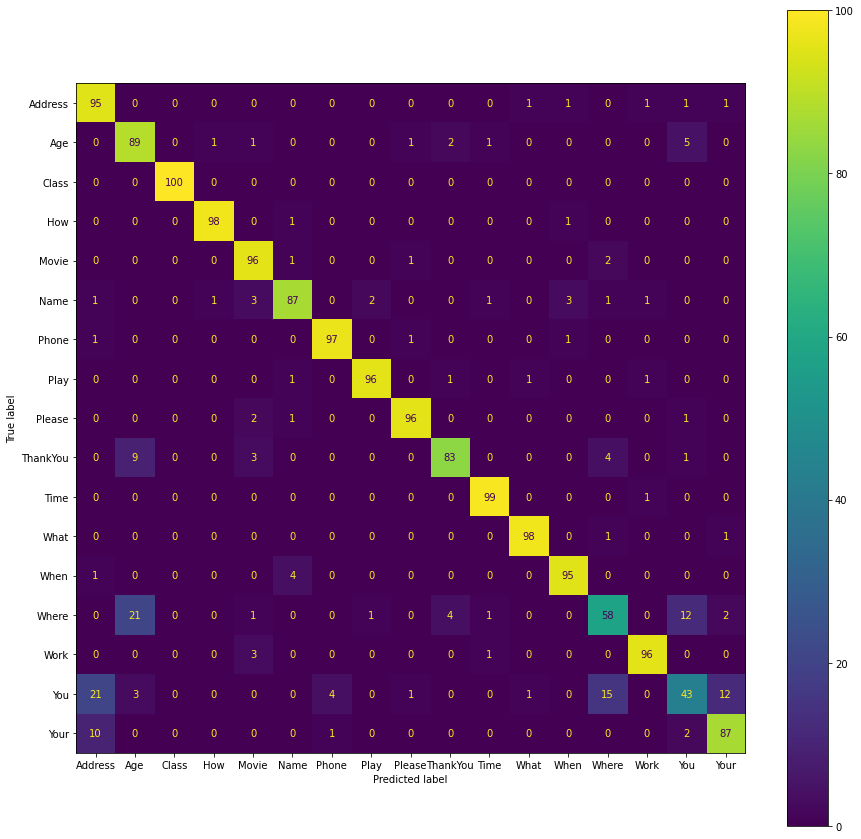

In [ ]:
import matplotlib.pyplot as plt
cm = confusion_matrix(flat_list_act, flat_list_pred,labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)
#/content/drive/MyDrive/20frame_17classmodel/model36

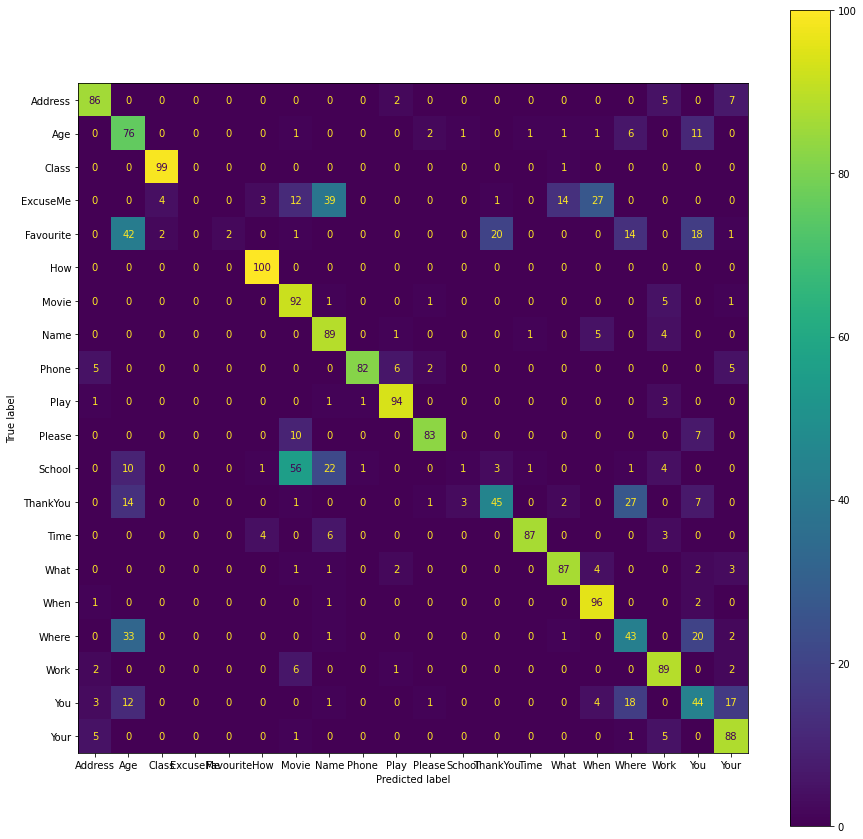

In [ ]:
 import matplotlib.pyplot as plt
cm = confusion_matrix(flat_list_act, flat_list_pred,labels=['Address', 'Age', 'Class', 'ExcuseMe', 'Favourite', 'How', 'Movie', 'Name', 'Phone', 'Play', 'Please', 'School', 'ThankYou', 'Time', 'What', 'When', 'Where', 'Work', 'You', 'Your'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Address', 'Age', 'Class', 'ExcuseMe', 'Favourite', 'How', 'Movie', 'Name', 'Phone', 'Play', 'Please', 'School', 'ThankYou', 'Time', 'What', 'When', 'Where', 'Work', 'You', 'Your'])
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)
#model151

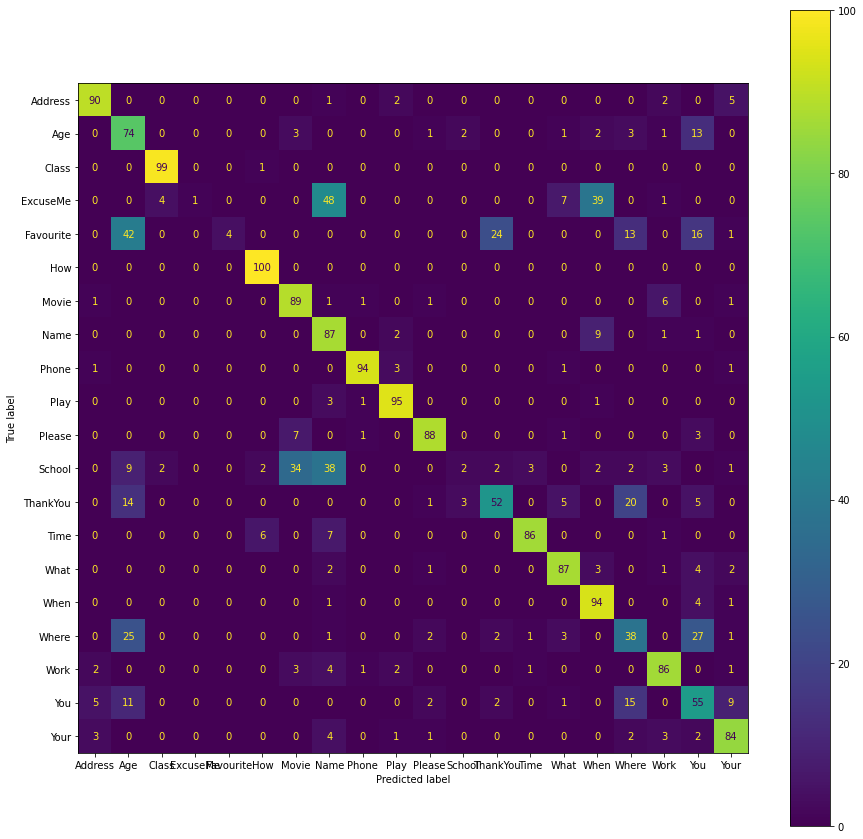

In [ ]:
import matplotlib.pyplot as plt
cm = confusion_matrix(flat_list_act, flat_list_pred,labels=['Address', 'Age', 'Class', 'ExcuseMe', 'Favourite', 'How', 'Movie', 'Name', 'Phone', 'Play', 'Please', 'School', 'ThankYou', 'Time', 'What', 'When', 'Where', 'Work', 'You', 'Your'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Address', 'Age', 'Class', 'ExcuseMe', 'Favourite', 'How', 'Movie', 'Name', 'Phone', 'Play', 'Please', 'School', 'ThankYou', 'Time', 'What', 'When', 'Where', 'Work', 'You', 'Your'])
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)
#model129

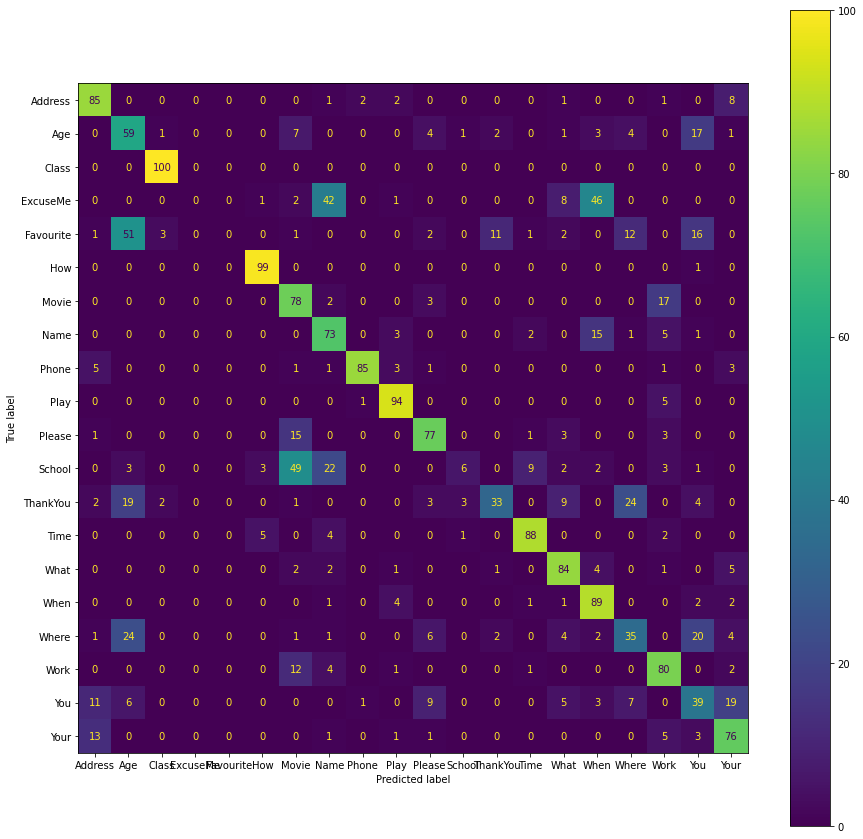

In [ ]:
import matplotlib.pyplot as plt
cm = confusion_matrix(flat_list_act, flat_list_pred,labels=['Address', 'Age', 'Class', 'ExcuseMe', 'Favourite', 'How', 'Movie', 'Name', 'Phone', 'Play', 'Please', 'School', 'ThankYou', 'Time', 'What', 'When', 'Where', 'Work', 'You', 'Your'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Address', 'Age', 'Class', 'ExcuseMe', 'Favourite', 'How', 'Movie', 'Name', 'Phone', 'Play', 'Please', 'School', 'ThankYou', 'Time', 'What', 'When', 'Where', 'Work', 'You', 'Your'])
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)

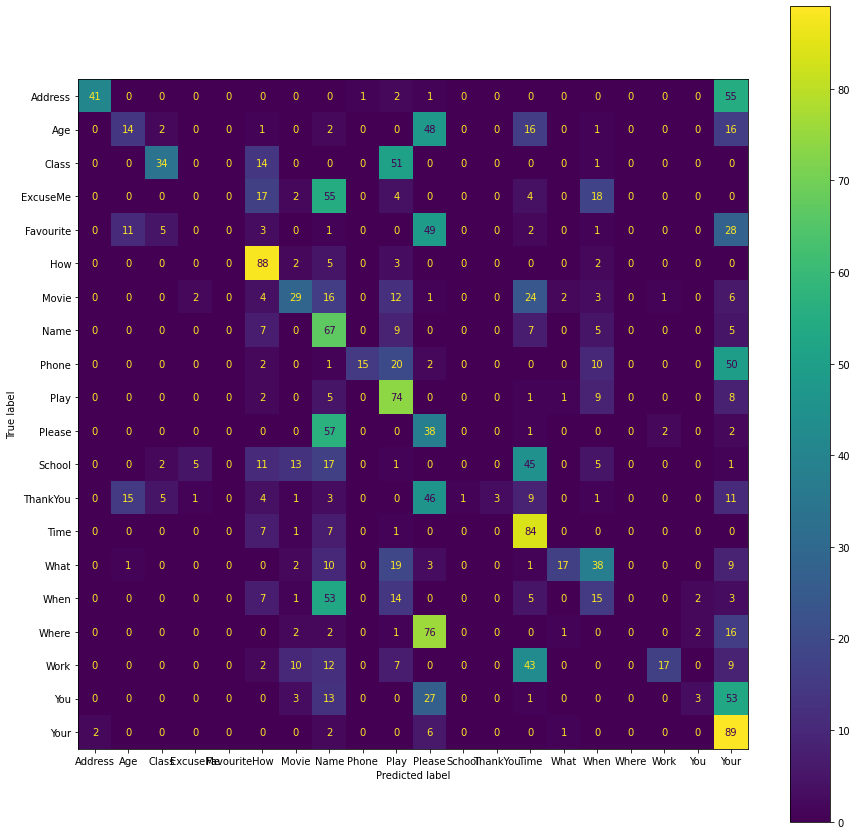

In [ ]:
import matplotlib.pyplot as plt
cm = confusion_matrix(flat_list_act, flat_list_pred,labels=['Address', 'Age', 'Class', 'ExcuseMe', 'Favourite', 'How', 'Movie', 'Name', 'Phone', 'Play', 'Please', 'School', 'ThankYou', 'Time', 'What', 'When', 'Where', 'Work', 'You', 'Your'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Address', 'Age', 'Class', 'ExcuseMe', 'Favourite', 'How', 'Movie', 'Name', 'Phone', 'Play', 'Please', 'School', 'ThankYou', 'Time', 'What', 'When', 'Where', 'Work', 'You', 'Your'])
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)

In [ ]:
https://priconne-grandmasters.jp/

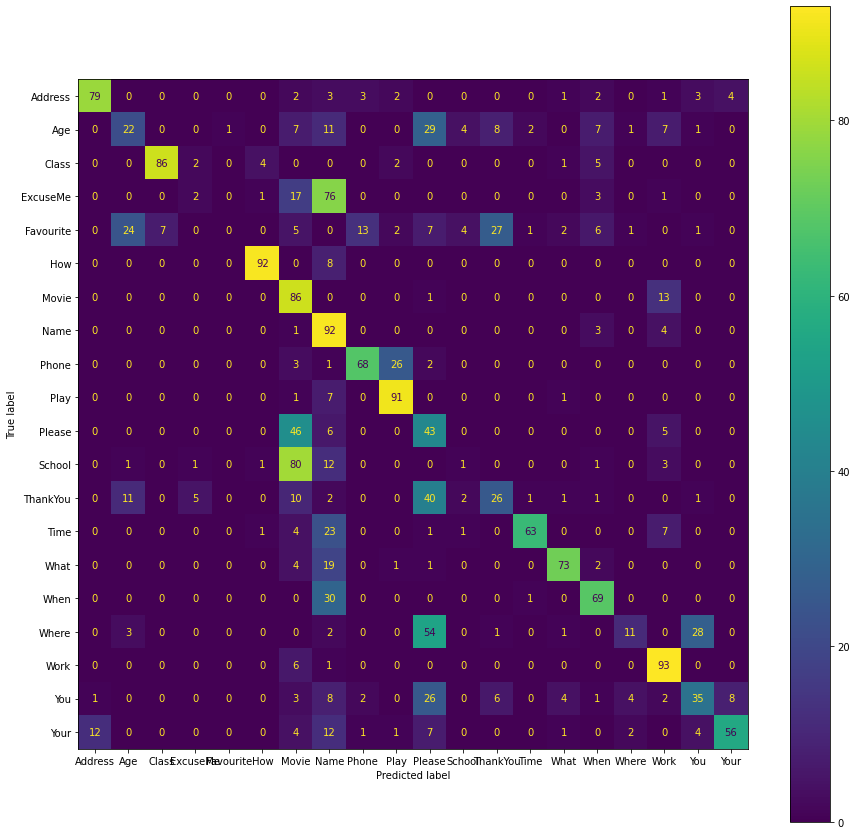

In [ ]:
import matplotlib.pyplot as plt
cm = confusion_matrix(flat_list_act, flat_list_pred,labels=['Address', 'Age', 'Class', 'ExcuseMe', 'Favourite', 'How', 'Movie', 'Name', 'Phone', 'Play', 'Please', 'School', 'ThankYou', 'Time', 'What', 'When', 'Where', 'Work', 'You', 'Your'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Address', 'Age', 'Class', 'ExcuseMe', 'Favourite', 'How', 'Movie', 'Name', 'Phone', 'Play', 'Please', 'School', 'ThankYou', 'Time', 'What', 'When', 'Where', 'Work', 'You', 'Your'])
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)

# Save plot

In [ ]:
with open('/content/drive/MyDrive/20frame_20classmodel/CM_30frame_20class_model129.pkle','wb') as xyz:
    pickle.dump(disp,xyz)

# Load saved plot

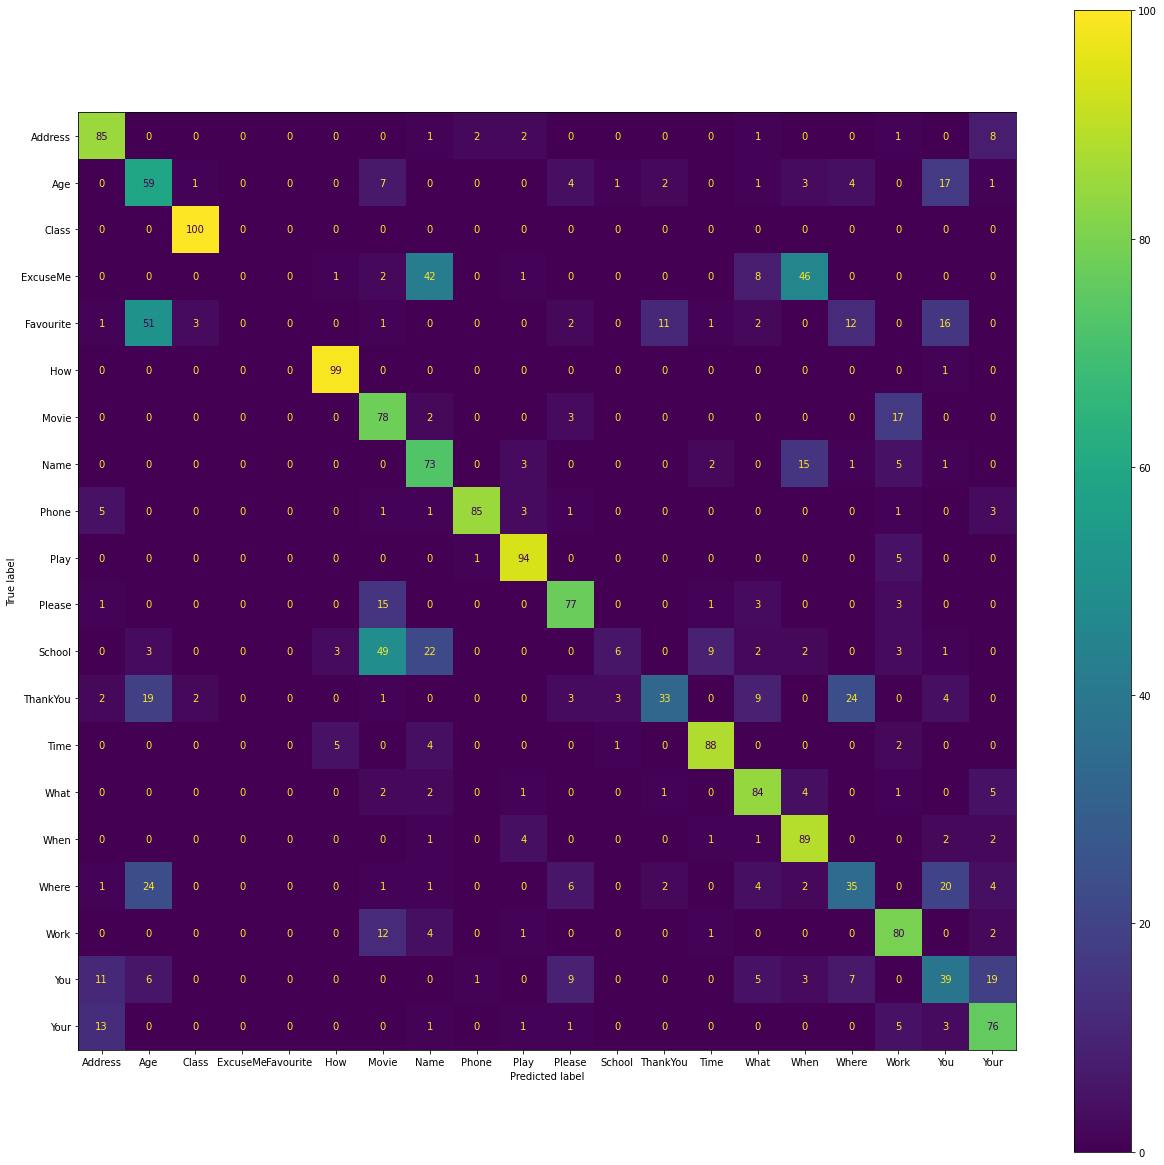

In [ ]:
with open('/content/drive/MyDrive/20frame_20classmodel/CM_20frame_20class.pkle','rb') as xyz:
    disp = pickle.load(xyz)
fig, ax = plt.subplots(figsize=(21,21))
disp.plot(ax=ax)

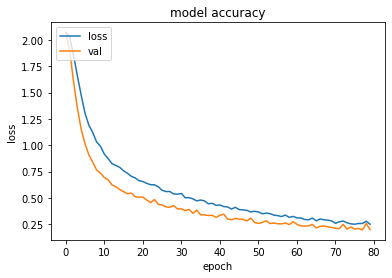

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val'], loc='upper left')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Videos loaded :  100


  0%|          | 1/2000 [00:21<11:47:13, 21.23s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/335994.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  0%|          | 2/2000 [00:26<6:30:49, 11.74s/it] 


Predicted class : Address   /content/ASLdataset/20classtest/Address/196136.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  0%|          | 3/2000 [00:32<5:02:18,  9.08s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/660285.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  0%|          | 4/2000 [00:37<4:11:45,  7.57s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/329408.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  0%|          | 5/2000 [00:43<3:51:48,  6.97s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/293577.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  0%|          | 6/2000 [00:49<3:39:10,  6.60s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/409906.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  0%|          | 7/2000 [00:55<3:31:19,  6.36s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/559411.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  0%|          | 8/2000 [01:00<3:17:49,  5.96s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/992307.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  0%|          | 9/2000 [01:05<3:14:17,  5.86s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/649636.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  0%|          | 10/2000 [01:11<3:14:28,  5.86s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/996626.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|          | 11/2000 [01:17<3:12:14,  5.80s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/592117.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|          | 12/2000 [01:23<3:10:09,  5.74s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/496329.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|          | 13/2000 [01:28<3:04:23,  5.57s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Address/677795.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|          | 14/2000 [01:33<3:02:12,  5.50s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Address/390365.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|          | 15/2000 [01:39<3:05:33,  5.61s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/683484.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|          | 16/2000 [01:45<3:06:01,  5.63s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/837191.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|          | 17/2000 [01:50<3:05:23,  5.61s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/741090.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|          | 18/2000 [01:56<3:07:24,  5.67s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/426249.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|          | 19/2000 [02:01<3:04:52,  5.60s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/707212.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|          | 20/2000 [02:07<3:08:18,  5.71s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/553981.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|          | 21/2000 [02:12<3:01:04,  5.49s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/390647.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|          | 22/2000 [02:17<2:54:24,  5.29s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/319247.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|          | 23/2000 [02:23<2:55:20,  5.32s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Address/634008.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|          | 24/2000 [02:28<2:59:54,  5.46s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/988627.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|▏         | 25/2000 [02:34<3:04:45,  5.61s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/379680.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|▏         | 26/2000 [02:40<3:08:57,  5.74s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/931591.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|▏         | 27/2000 [02:46<3:09:54,  5.78s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/669298.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|▏         | 28/2000 [02:52<3:10:30,  5.80s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/708248.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  1%|▏         | 29/2000 [02:58<3:13:35,  5.89s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/671161.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         | 30/2000 [03:04<3:12:02,  5.85s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/317699.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         | 31/2000 [03:09<3:06:15,  5.68s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/355600.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         | 32/2000 [03:15<3:06:39,  5.69s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/137042.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         | 33/2000 [03:21<3:06:47,  5.70s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/872190.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         | 34/2000 [03:26<3:05:14,  5.65s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/180159.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         | 35/2000 [03:32<3:07:11,  5.72s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/239478.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         | 36/2000 [03:38<3:06:28,  5.70s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/150917.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         | 37/2000 [03:44<3:10:31,  5.82s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/753776.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         | 38/2000 [03:50<3:11:36,  5.86s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/541365.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         | 39/2000 [03:56<3:11:46,  5.87s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/900798.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         | 40/2000 [04:02<3:12:41,  5.90s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/785147.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         | 41/2000 [04:07<3:08:26,  5.77s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/697182.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         | 42/2000 [04:12<3:01:41,  5.57s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/731130.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         | 43/2000 [04:18<3:04:57,  5.67s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/575329.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         | 44/2000 [04:23<3:00:42,  5.54s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/609604.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         | 45/2000 [04:29<3:03:42,  5.64s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/706261.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         | 46/2000 [04:35<3:04:34,  5.67s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/166023.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         | 47/2000 [04:41<3:06:08,  5.72s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/207192.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         | 48/2000 [04:46<3:02:52,  5.62s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/133302.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▏         | 49/2000 [04:51<2:59:05,  5.51s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/897926.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  2%|▎         | 50/2000 [04:57<2:57:00,  5.45s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/276312.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         | 51/2000 [05:02<2:54:13,  5.36s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Address/542611.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         | 52/2000 [05:07<2:56:28,  5.44s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/715296.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         | 53/2000 [05:13<3:01:02,  5.58s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/325646.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         | 54/2000 [05:19<3:04:01,  5.67s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/187786.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         | 55/2000 [05:25<3:01:32,  5.60s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/568393.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         | 56/2000 [05:30<3:01:26,  5.60s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/978393.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         | 57/2000 [05:35<2:52:01,  5.31s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/499721.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         | 58/2000 [05:40<2:53:48,  5.37s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/266665.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         | 59/2000 [05:47<3:00:27,  5.58s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/829633.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         | 60/2000 [05:52<3:03:57,  5.69s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Address/729364.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         | 61/2000 [05:58<3:02:06,  5.63s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/533481.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         | 62/2000 [06:04<3:04:02,  5.70s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/514080.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         | 63/2000 [06:10<3:05:58,  5.76s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/395018.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         | 64/2000 [06:15<2:58:29,  5.53s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/178779.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         | 65/2000 [06:20<2:57:57,  5.52s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/436305.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         | 66/2000 [06:26<3:00:05,  5.59s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/158849.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         | 67/2000 [06:31<2:58:30,  5.54s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/464885.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         | 68/2000 [06:37<3:03:13,  5.69s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/776633.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  3%|▎         | 69/2000 [06:43<3:05:35,  5.77s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/236725.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▎         | 70/2000 [06:49<3:05:11,  5.76s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Address/774723.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▎         | 71/2000 [06:55<3:07:17,  5.83s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/738524.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▎         | 72/2000 [07:01<3:06:25,  5.80s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/623619.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▎         | 73/2000 [07:07<3:08:57,  5.88s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/559608.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▎         | 74/2000 [07:12<2:58:22,  5.56s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/346614.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▍         | 75/2000 [07:17<2:59:41,  5.60s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/426948.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▍         | 76/2000 [07:23<3:01:10,  5.65s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/961457.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▍         | 77/2000 [07:29<3:01:23,  5.66s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/959808.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▍         | 78/2000 [07:34<2:58:26,  5.57s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Address/575003.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▍         | 79/2000 [07:40<3:01:03,  5.66s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/879858.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▍         | 80/2000 [07:46<2:59:36,  5.61s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/916256.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▍         | 81/2000 [07:51<2:53:09,  5.41s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/697982.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▍         | 82/2000 [07:56<2:56:45,  5.53s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/497252.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▍         | 83/2000 [08:02<3:01:34,  5.68s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/981557.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▍         | 84/2000 [08:08<3:04:19,  5.77s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/254485.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▍         | 85/2000 [08:13<2:51:53,  5.39s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/410787.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▍         | 86/2000 [08:19<2:55:46,  5.51s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/907952.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▍         | 87/2000 [08:25<2:59:29,  5.63s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/611554.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▍         | 88/2000 [08:31<3:02:35,  5.73s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/410454.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▍         | 89/2000 [08:34<2:44:10,  5.15s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/373045.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  4%|▍         | 90/2000 [08:40<2:48:12,  5.28s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/496403.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  5%|▍         | 91/2000 [08:46<2:53:49,  5.46s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Address/591608.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  5%|▍         | 92/2000 [08:51<2:54:25,  5.49s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/437643.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  5%|▍         | 93/2000 [08:56<2:48:59,  5.32s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Address/876474.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  5%|▍         | 94/2000 [09:02<2:55:20,  5.52s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/295887.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  5%|▍         | 95/2000 [09:08<2:55:02,  5.51s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/729857.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  5%|▍         | 96/2000 [09:14<3:00:36,  5.69s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Address/690705.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  5%|▍         | 97/2000 [09:20<3:05:19,  5.84s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/873273.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  5%|▍         | 98/2000 [09:27<3:14:05,  6.12s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/638916.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  5%|▍         | 99/2000 [09:32<3:05:50,  5.87s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/292122.avi
Actual class    : Address
------------------------------------------------------------------------------------------


  5%|▌         | 100/2000 [09:38<3:09:07,  5.97s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Address/766234.avi
Actual class    : Address
------------------------------------------------------------------------------------------
Videos loaded :  100


  5%|▌         | 101/2000 [09:44<3:09:30,  5.99s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/955249.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  5%|▌         | 102/2000 [09:50<3:08:18,  5.95s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/235759.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  5%|▌         | 103/2000 [09:56<3:07:02,  5.92s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/888976.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  5%|▌         | 104/2000 [10:02<3:04:10,  5.83s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/411297.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  5%|▌         | 105/2000 [10:08<3:06:58,  5.92s/it]


Predicted class : You   /content/ASLdataset/20classtest/Age/780258.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  5%|▌         | 106/2000 [10:13<3:01:02,  5.74s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/657830.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  5%|▌         | 107/2000 [10:19<3:03:39,  5.82s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/159894.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  5%|▌         | 108/2000 [10:25<3:04:45,  5.86s/it]


Predicted class : You   /content/ASLdataset/20classtest/Age/541192.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  5%|▌         | 109/2000 [10:31<3:04:13,  5.85s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/972013.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  6%|▌         | 110/2000 [10:37<3:02:21,  5.79s/it]


Predicted class : You   /content/ASLdataset/20classtest/Age/662461.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  6%|▌         | 111/2000 [10:42<2:57:02,  5.62s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/297997.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  6%|▌         | 112/2000 [10:48<3:00:44,  5.74s/it]


Predicted class : You   /content/ASLdataset/20classtest/Age/259669.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  6%|▌         | 113/2000 [10:53<2:59:49,  5.72s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/958330.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  6%|▌         | 114/2000 [10:59<3:02:04,  5.79s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/637751.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  6%|▌         | 115/2000 [11:05<3:02:52,  5.82s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/707279.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  6%|▌         | 116/2000 [11:11<3:03:48,  5.85s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/263276.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  6%|▌         | 117/2000 [11:17<3:03:56,  5.86s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/586921.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  6%|▌         | 118/2000 [11:23<3:03:49,  5.86s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/496250.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  6%|▌         | 119/2000 [11:29<3:04:16,  5.88s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/946776.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  6%|▌         | 120/2000 [11:35<3:07:04,  5.97s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Age/272111.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  6%|▌         | 121/2000 [11:41<3:05:22,  5.92s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/277861.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  6%|▌         | 122/2000 [11:47<3:06:57,  5.97s/it]


Predicted class : You   /content/ASLdataset/20classtest/Age/518804.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  6%|▌         | 123/2000 [11:52<3:01:46,  5.81s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Age/802206.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  6%|▌         | 124/2000 [11:58<3:01:52,  5.82s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/772170.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  6%|▋         | 125/2000 [12:04<3:03:55,  5.89s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Age/401167.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  6%|▋         | 126/2000 [12:09<2:53:34,  5.56s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/581706.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  6%|▋         | 127/2000 [12:15<2:56:26,  5.65s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Age/703564.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  6%|▋         | 128/2000 [12:21<2:55:39,  5.63s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Age/936179.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  6%|▋         | 129/2000 [12:26<2:53:58,  5.58s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Age/328880.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  6%|▋         | 130/2000 [12:32<2:57:06,  5.68s/it]


Predicted class : You   /content/ASLdataset/20classtest/Age/935621.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         | 131/2000 [12:38<3:01:27,  5.83s/it]


Predicted class : When   /content/ASLdataset/20classtest/Age/103141.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         | 132/2000 [12:44<3:03:48,  5.90s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/742964.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         | 133/2000 [12:50<3:03:45,  5.91s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/954535.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         | 134/2000 [12:56<3:01:18,  5.83s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/301249.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         | 135/2000 [13:02<3:02:25,  5.87s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/316205.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         | 136/2000 [13:07<3:01:07,  5.83s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/863321.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         | 137/2000 [13:12<2:53:33,  5.59s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/255462.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         | 138/2000 [13:18<2:55:29,  5.65s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/202110.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         | 139/2000 [13:24<2:56:35,  5.69s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/712515.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         | 140/2000 [13:30<2:57:33,  5.73s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/673591.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         | 141/2000 [13:36<2:59:31,  5.79s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/719179.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         | 142/2000 [13:42<3:02:06,  5.88s/it]


Predicted class : You   /content/ASLdataset/20classtest/Age/914291.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         | 143/2000 [13:48<3:02:48,  5.91s/it]


Predicted class : You   /content/ASLdataset/20classtest/Age/946116.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         | 144/2000 [13:54<3:03:22,  5.93s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/857373.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         | 145/2000 [14:00<3:02:58,  5.92s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/385914.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         | 146/2000 [14:06<3:02:31,  5.91s/it]


Predicted class : You   /content/ASLdataset/20classtest/Age/790786.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         | 147/2000 [14:11<3:01:01,  5.86s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Age/580723.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         | 148/2000 [14:17<3:01:35,  5.88s/it]


Predicted class : School   /content/ASLdataset/20classtest/Age/128964.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  7%|▋         | 149/2000 [14:23<3:01:59,  5.90s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/372464.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         | 150/2000 [14:29<3:02:44,  5.93s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/667041.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         | 151/2000 [14:35<3:02:49,  5.93s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/719326.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         | 152/2000 [14:41<3:00:33,  5.86s/it]


Predicted class : You   /content/ASLdataset/20classtest/Age/685782.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         | 153/2000 [14:46<2:58:09,  5.79s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/980783.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         | 154/2000 [14:52<2:58:41,  5.81s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/208181.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         | 155/2000 [14:58<2:59:23,  5.83s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/751820.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         | 156/2000 [15:04<2:57:07,  5.76s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/426370.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         | 157/2000 [15:10<2:58:08,  5.80s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/416575.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         | 158/2000 [15:16<2:58:46,  5.82s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/511628.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         | 159/2000 [15:21<2:57:35,  5.79s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/946674.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         | 160/2000 [15:26<2:50:37,  5.56s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/500960.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         | 161/2000 [15:32<2:55:47,  5.74s/it]


Predicted class : What   /content/ASLdataset/20classtest/Age/868193.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         | 162/2000 [15:39<3:00:20,  5.89s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/313224.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         | 163/2000 [15:44<2:55:09,  5.72s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/818308.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         | 164/2000 [15:50<2:55:31,  5.74s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/553079.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         | 165/2000 [15:55<2:49:54,  5.56s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/389192.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         | 166/2000 [16:00<2:46:54,  5.46s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/620442.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         | 167/2000 [16:06<2:50:41,  5.59s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/734873.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         | 168/2000 [16:12<2:51:18,  5.61s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/984780.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         | 169/2000 [16:17<2:47:16,  5.48s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/740052.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  8%|▊         | 170/2000 [16:23<2:49:15,  5.55s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/924345.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▊         | 171/2000 [16:28<2:51:15,  5.62s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/432514.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▊         | 172/2000 [16:34<2:51:30,  5.63s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/331873.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▊         | 173/2000 [16:40<2:51:25,  5.63s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/837035.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▊         | 174/2000 [16:45<2:50:50,  5.61s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/898588.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▉         | 175/2000 [16:51<2:51:30,  5.64s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/346647.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▉         | 176/2000 [16:57<2:51:25,  5.64s/it]


Predicted class : You   /content/ASLdataset/20classtest/Age/916691.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▉         | 177/2000 [17:02<2:52:34,  5.68s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/684242.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▉         | 178/2000 [17:08<2:55:54,  5.79s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/452889.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▉         | 179/2000 [17:14<2:55:41,  5.79s/it]


Predicted class : You   /content/ASLdataset/20classtest/Age/651750.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▉         | 180/2000 [17:20<2:56:25,  5.82s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/826282.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▉         | 181/2000 [17:26<2:55:55,  5.80s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/906425.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▉         | 182/2000 [17:32<2:54:13,  5.75s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/888747.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▉         | 183/2000 [17:37<2:54:57,  5.78s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/270887.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▉         | 184/2000 [17:43<2:55:35,  5.80s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/745759.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▉         | 185/2000 [17:48<2:50:53,  5.65s/it]


Predicted class : You   /content/ASLdataset/20classtest/Age/849373.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▉         | 186/2000 [17:54<2:53:06,  5.73s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/486256.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▉         | 187/2000 [18:00<2:51:00,  5.66s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/232777.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▉         | 188/2000 [18:06<2:53:53,  5.76s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/647536.avi
Actual class    : Age
------------------------------------------------------------------------------------------


  9%|▉         | 189/2000 [18:12<2:52:50,  5.73s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/900485.avi
Actual class    : Age
------------------------------------------------------------------------------------------


 10%|▉         | 190/2000 [18:18<2:54:49,  5.80s/it]


Predicted class : School   /content/ASLdataset/20classtest/Age/393194.avi
Actual class    : Age
------------------------------------------------------------------------------------------


 10%|▉         | 191/2000 [18:23<2:54:57,  5.80s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/450167.avi
Actual class    : Age
------------------------------------------------------------------------------------------


 10%|▉         | 192/2000 [18:29<2:53:56,  5.77s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/616278.avi
Actual class    : Age
------------------------------------------------------------------------------------------


 10%|▉         | 193/2000 [18:35<2:57:54,  5.91s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/456989.avi
Actual class    : Age
------------------------------------------------------------------------------------------


 10%|▉         | 194/2000 [18:43<3:18:19,  6.59s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/100885.avi
Actual class    : Age
------------------------------------------------------------------------------------------


 10%|▉         | 195/2000 [18:52<3:32:29,  7.06s/it]


Predicted class : When   /content/ASLdataset/20classtest/Age/235187.avi
Actual class    : Age
------------------------------------------------------------------------------------------


 10%|▉         | 196/2000 [18:57<3:21:28,  6.70s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/806649.avi
Actual class    : Age
------------------------------------------------------------------------------------------


 10%|▉         | 197/2000 [19:03<3:11:13,  6.36s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/362152.avi
Actual class    : Age
------------------------------------------------------------------------------------------


 10%|▉         | 198/2000 [19:09<3:08:33,  6.28s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/325930.avi
Actual class    : Age
------------------------------------------------------------------------------------------


 10%|▉         | 199/2000 [19:15<3:05:18,  6.17s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Age/975134.avi
Actual class    : Age
------------------------------------------------------------------------------------------


 10%|█         | 200/2000 [19:20<2:57:47,  5.93s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Age/562087.avi
Actual class    : Age
------------------------------------------------------------------------------------------
Videos loaded :  100


 10%|█         | 201/2000 [19:27<2:59:59,  6.00s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/974571.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 10%|█         | 202/2000 [19:33<2:59:15,  5.98s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/735156.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 10%|█         | 203/2000 [19:39<2:59:57,  6.01s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/180897.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 10%|█         | 204/2000 [19:45<2:59:19,  5.99s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/246214.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 10%|█         | 205/2000 [19:50<2:58:51,  5.98s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/365000.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 10%|█         | 206/2000 [19:56<2:57:19,  5.93s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/374459.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 10%|█         | 207/2000 [20:02<2:56:11,  5.90s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/535091.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 10%|█         | 208/2000 [20:08<2:55:58,  5.89s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/386984.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 10%|█         | 209/2000 [20:14<2:55:33,  5.88s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/214265.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 10%|█         | 210/2000 [20:20<2:55:32,  5.88s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/664999.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 11%|█         | 211/2000 [20:26<2:54:58,  5.87s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/640710.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 11%|█         | 212/2000 [20:31<2:54:45,  5.86s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/382859.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 11%|█         | 213/2000 [20:37<2:53:42,  5.83s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/427163.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 11%|█         | 214/2000 [20:43<2:54:27,  5.86s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/266366.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 11%|█         | 215/2000 [20:49<2:54:14,  5.86s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/324815.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 11%|█         | 216/2000 [20:55<2:53:40,  5.84s/it]


Predicted class : How   /content/ASLdataset/20classtest/Class/894585.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 11%|█         | 217/2000 [21:01<2:53:26,  5.84s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/859339.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 11%|█         | 218/2000 [21:06<2:52:25,  5.81s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/602187.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 11%|█         | 219/2000 [21:12<2:53:20,  5.84s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/238633.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 11%|█         | 220/2000 [21:18<2:53:28,  5.85s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/677795.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 11%|█         | 221/2000 [21:24<2:53:54,  5.87s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/611117.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 11%|█         | 222/2000 [21:30<2:52:08,  5.81s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/616027.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 11%|█         | 223/2000 [21:36<2:52:53,  5.84s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/936964.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 11%|█         | 224/2000 [21:42<2:53:26,  5.86s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/144108.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 11%|█▏        | 225/2000 [21:47<2:53:14,  5.86s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/628728.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 11%|█▏        | 226/2000 [21:53<2:52:32,  5.84s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/322481.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 11%|█▏        | 227/2000 [21:59<2:51:44,  5.81s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/839644.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 11%|█▏        | 228/2000 [22:05<2:50:38,  5.78s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/172430.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 11%|█▏        | 229/2000 [22:10<2:50:50,  5.79s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/858291.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 12%|█▏        | 230/2000 [22:16<2:49:24,  5.74s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/487501.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 12%|█▏        | 231/2000 [22:22<2:49:17,  5.74s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/625952.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 12%|█▏        | 232/2000 [22:27<2:48:57,  5.73s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/879145.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 12%|█▏        | 233/2000 [22:33<2:50:11,  5.78s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/662787.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 12%|█▏        | 234/2000 [22:39<2:50:42,  5.80s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/358316.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 12%|█▏        | 235/2000 [22:45<2:51:00,  5.81s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/760630.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 12%|█▏        | 236/2000 [22:51<2:50:23,  5.80s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/971394.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 12%|█▏        | 237/2000 [22:57<2:49:56,  5.78s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/690621.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 12%|█▏        | 238/2000 [23:02<2:50:05,  5.79s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/593631.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 12%|█▏        | 239/2000 [23:08<2:50:05,  5.80s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/699186.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 12%|█▏        | 240/2000 [23:14<2:49:49,  5.79s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/750785.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 12%|█▏        | 241/2000 [23:20<2:50:30,  5.82s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/626427.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 12%|█▏        | 242/2000 [23:26<2:50:39,  5.82s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/458085.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 12%|█▏        | 243/2000 [23:32<2:51:10,  5.85s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/392692.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 12%|█▏        | 244/2000 [23:38<2:52:33,  5.90s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/350767.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 12%|█▏        | 245/2000 [23:43<2:52:06,  5.88s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/612182.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 12%|█▏        | 246/2000 [23:49<2:50:50,  5.84s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/463857.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 12%|█▏        | 247/2000 [23:55<2:50:11,  5.83s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/942911.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 12%|█▏        | 248/2000 [24:01<2:48:46,  5.78s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/229801.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 12%|█▏        | 249/2000 [24:06<2:49:02,  5.79s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/512898.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 12%|█▎        | 250/2000 [24:12<2:48:57,  5.79s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/325050.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        | 251/2000 [24:17<2:43:44,  5.62s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/361045.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        | 252/2000 [24:23<2:45:27,  5.68s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/990355.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        | 253/2000 [24:29<2:46:20,  5.71s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/518724.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        | 254/2000 [24:35<2:47:58,  5.77s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/326773.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        | 255/2000 [24:41<2:49:02,  5.81s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/512177.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        | 256/2000 [24:47<2:49:04,  5.82s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/366955.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        | 257/2000 [24:53<2:49:11,  5.82s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/206056.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        | 258/2000 [24:58<2:48:25,  5.80s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/815560.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        | 259/2000 [25:04<2:48:22,  5.80s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/308049.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        | 260/2000 [25:10<2:48:30,  5.81s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/478036.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        | 261/2000 [25:16<2:48:04,  5.80s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/836507.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        | 262/2000 [25:22<2:47:57,  5.80s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/208309.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        | 263/2000 [25:27<2:48:33,  5.82s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/501854.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        | 264/2000 [25:33<2:44:01,  5.67s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/775165.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        | 265/2000 [25:39<2:46:00,  5.74s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/224158.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        | 266/2000 [25:45<2:47:05,  5.78s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/533902.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        | 267/2000 [25:50<2:44:41,  5.70s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/713786.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        | 268/2000 [25:56<2:45:29,  5.73s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/640266.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 13%|█▎        | 269/2000 [26:02<2:45:38,  5.74s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/591945.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▎        | 270/2000 [26:07<2:45:59,  5.76s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/860288.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▎        | 271/2000 [26:13<2:46:52,  5.79s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/795259.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▎        | 272/2000 [26:19<2:46:41,  5.79s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/776398.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▎        | 273/2000 [26:25<2:46:59,  5.80s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/999518.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▎        | 274/2000 [26:31<2:46:48,  5.80s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/660739.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▍        | 275/2000 [26:36<2:46:01,  5.77s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/387827.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▍        | 276/2000 [26:42<2:44:58,  5.74s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/680821.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▍        | 277/2000 [26:48<2:44:55,  5.74s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/154593.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▍        | 278/2000 [26:54<2:45:15,  5.76s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/954827.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▍        | 279/2000 [26:59<2:45:55,  5.78s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/451912.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▍        | 280/2000 [27:05<2:46:04,  5.79s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/974264.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▍        | 281/2000 [27:11<2:45:45,  5.79s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/463075.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▍        | 282/2000 [27:17<2:45:51,  5.79s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/516469.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▍        | 283/2000 [27:23<2:46:02,  5.80s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/662827.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▍        | 284/2000 [27:28<2:45:14,  5.78s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/831352.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▍        | 285/2000 [27:34<2:46:11,  5.81s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/389472.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▍        | 286/2000 [27:40<2:46:41,  5.84s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/224410.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▍        | 287/2000 [27:46<2:48:06,  5.89s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/443556.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▍        | 288/2000 [27:52<2:48:31,  5.91s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/714524.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▍        | 289/2000 [27:58<2:47:58,  5.89s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/355309.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 14%|█▍        | 290/2000 [28:04<2:48:43,  5.92s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/208044.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 15%|█▍        | 291/2000 [28:10<2:49:09,  5.94s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/947643.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 15%|█▍        | 292/2000 [28:16<2:49:31,  5.96s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/382144.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 15%|█▍        | 293/2000 [28:22<2:50:03,  5.98s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/634508.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 15%|█▍        | 294/2000 [28:28<2:49:26,  5.96s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/177770.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 15%|█▍        | 295/2000 [28:34<2:49:45,  5.97s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/688948.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 15%|█▍        | 296/2000 [28:40<2:51:11,  6.03s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/561636.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 15%|█▍        | 297/2000 [28:46<2:52:50,  6.09s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/729241.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 15%|█▍        | 298/2000 [28:52<2:51:22,  6.04s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/931455.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 15%|█▍        | 299/2000 [28:58<2:51:34,  6.05s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/694410.avi
Actual class    : Class
------------------------------------------------------------------------------------------


 15%|█▌        | 300/2000 [29:04<2:50:27,  6.02s/it]


Predicted class : Class   /content/ASLdataset/20classtest/Class/275924.avi
Actual class    : Class
------------------------------------------------------------------------------------------
Videos loaded :  100


 15%|█▌        | 301/2000 [29:10<2:51:12,  6.05s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/736943.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 15%|█▌        | 302/2000 [29:16<2:50:57,  6.04s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/596045.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 15%|█▌        | 303/2000 [29:22<2:51:30,  6.06s/it]


Predicted class : ExcuseMe   /content/ASLdataset/20classtest/ExcuseMe/270258.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 15%|█▌        | 304/2000 [29:29<2:52:34,  6.11s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/709496.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 15%|█▌        | 305/2000 [29:35<2:51:17,  6.06s/it]


Predicted class : What   /content/ASLdataset/20classtest/ExcuseMe/473290.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 15%|█▌        | 306/2000 [29:41<2:55:19,  6.21s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/665661.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 15%|█▌        | 307/2000 [29:47<2:51:57,  6.09s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/209857.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 15%|█▌        | 308/2000 [29:53<2:52:33,  6.12s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/124778.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 15%|█▌        | 309/2000 [29:59<2:51:30,  6.09s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/808455.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 16%|█▌        | 310/2000 [30:05<2:51:20,  6.08s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/574620.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 16%|█▌        | 311/2000 [30:11<2:51:54,  6.11s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/970529.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 16%|█▌        | 312/2000 [30:18<2:51:40,  6.10s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/488138.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 16%|█▌        | 313/2000 [30:24<2:51:38,  6.10s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/466922.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 16%|█▌        | 314/2000 [30:30<2:53:24,  6.17s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/973436.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 16%|█▌        | 315/2000 [30:36<2:53:05,  6.16s/it]


Predicted class : Class   /content/ASLdataset/20classtest/ExcuseMe/477521.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 16%|█▌        | 316/2000 [30:42<2:50:34,  6.08s/it]


Predicted class : What   /content/ASLdataset/20classtest/ExcuseMe/291548.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 16%|█▌        | 317/2000 [30:48<2:51:47,  6.12s/it]


Predicted class : What   /content/ASLdataset/20classtest/ExcuseMe/451312.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 16%|█▌        | 318/2000 [30:54<2:50:20,  6.08s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/221566.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 16%|█▌        | 319/2000 [31:00<2:48:40,  6.02s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/571523.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 16%|█▌        | 320/2000 [31:06<2:47:21,  5.98s/it]


Predicted class : What   /content/ASLdataset/20classtest/ExcuseMe/690992.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 16%|█▌        | 321/2000 [31:12<2:46:50,  5.96s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/448873.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 16%|█▌        | 322/2000 [31:18<2:46:25,  5.95s/it]


Predicted class : Class   /content/ASLdataset/20classtest/ExcuseMe/636608.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 16%|█▌        | 323/2000 [31:23<2:43:49,  5.86s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/461049.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 16%|█▌        | 324/2000 [31:29<2:40:40,  5.75s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/177047.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 16%|█▋        | 325/2000 [31:35<2:40:56,  5.77s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/579916.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 16%|█▋        | 326/2000 [31:41<2:41:48,  5.80s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/137964.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 16%|█▋        | 327/2000 [31:46<2:42:08,  5.81s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/665799.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 16%|█▋        | 328/2000 [31:52<2:39:23,  5.72s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/602877.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 16%|█▋        | 329/2000 [31:58<2:38:43,  5.70s/it]


Predicted class : What   /content/ASLdataset/20classtest/ExcuseMe/207465.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 16%|█▋        | 330/2000 [32:03<2:36:07,  5.61s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/380279.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 17%|█▋        | 331/2000 [32:09<2:38:03,  5.68s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/613482.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 17%|█▋        | 332/2000 [32:15<2:40:13,  5.76s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/674673.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 17%|█▋        | 333/2000 [32:21<2:40:47,  5.79s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/545203.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 17%|█▋        | 334/2000 [32:26<2:38:10,  5.70s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/747526.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 17%|█▋        | 335/2000 [32:32<2:39:11,  5.74s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/718224.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 17%|█▋        | 336/2000 [32:38<2:41:34,  5.83s/it]


Predicted class : Class   /content/ASLdataset/20classtest/ExcuseMe/535730.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 17%|█▋        | 337/2000 [32:44<2:42:38,  5.87s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/847285.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 17%|█▋        | 338/2000 [32:50<2:42:43,  5.87s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/440239.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 17%|█▋        | 339/2000 [32:56<2:42:25,  5.87s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/132701.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 17%|█▋        | 340/2000 [33:01<2:39:56,  5.78s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/910035.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 17%|█▋        | 341/2000 [33:07<2:40:10,  5.79s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/432724.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 17%|█▋        | 342/2000 [33:13<2:41:44,  5.85s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/366215.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 17%|█▋        | 343/2000 [33:19<2:43:15,  5.91s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/919897.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 17%|█▋        | 344/2000 [33:25<2:44:43,  5.97s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/418961.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 17%|█▋        | 345/2000 [33:31<2:45:12,  5.99s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/294036.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 17%|█▋        | 346/2000 [33:37<2:46:17,  6.03s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/873376.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 17%|█▋        | 347/2000 [33:43<2:44:55,  5.99s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/379196.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 17%|█▋        | 348/2000 [33:49<2:44:11,  5.96s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/139099.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 17%|█▋        | 349/2000 [33:55<2:42:42,  5.91s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/175779.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 18%|█▊        | 350/2000 [34:01<2:39:49,  5.81s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/558604.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 18%|█▊        | 351/2000 [34:06<2:39:28,  5.80s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/850586.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 18%|█▊        | 352/2000 [34:12<2:39:41,  5.81s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/665927.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 18%|█▊        | 353/2000 [34:18<2:39:46,  5.82s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/291872.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 18%|█▊        | 354/2000 [34:24<2:37:04,  5.73s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/157979.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 18%|█▊        | 355/2000 [34:29<2:37:39,  5.75s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/904833.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 18%|█▊        | 356/2000 [34:35<2:35:25,  5.67s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/493687.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 18%|█▊        | 357/2000 [34:41<2:37:01,  5.73s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/201863.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 18%|█▊        | 358/2000 [34:47<2:38:42,  5.80s/it]


Predicted class : What   /content/ASLdataset/20classtest/ExcuseMe/375574.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 18%|█▊        | 359/2000 [34:52<2:37:07,  5.75s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/426696.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 18%|█▊        | 360/2000 [34:58<2:37:33,  5.76s/it]


Predicted class : Work   /content/ASLdataset/20classtest/ExcuseMe/150672.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 18%|█▊        | 361/2000 [35:04<2:37:45,  5.78s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/999598.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 18%|█▊        | 362/2000 [35:10<2:37:20,  5.76s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/943540.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 18%|█▊        | 363/2000 [35:16<2:37:45,  5.78s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/715224.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 18%|█▊        | 364/2000 [35:21<2:37:43,  5.78s/it]


Predicted class : Class   /content/ASLdataset/20classtest/ExcuseMe/268517.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 18%|█▊        | 365/2000 [35:27<2:38:02,  5.80s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/171623.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 18%|█▊        | 366/2000 [35:33<2:38:48,  5.83s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/360717.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 18%|█▊        | 367/2000 [35:39<2:39:56,  5.88s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/151468.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 18%|█▊        | 368/2000 [35:45<2:37:27,  5.79s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/884236.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 18%|█▊        | 369/2000 [35:51<2:38:25,  5.83s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/321679.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 18%|█▊        | 370/2000 [35:56<2:38:49,  5.85s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/152157.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 19%|█▊        | 371/2000 [36:02<2:35:47,  5.74s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/553477.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 19%|█▊        | 372/2000 [36:08<2:36:12,  5.76s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/752082.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 19%|█▊        | 373/2000 [36:14<2:39:48,  5.89s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/397644.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 19%|█▊        | 374/2000 [36:20<2:39:09,  5.87s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/745379.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 19%|█▉        | 375/2000 [36:25<2:38:11,  5.84s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/205824.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 19%|█▉        | 376/2000 [36:31<2:37:52,  5.83s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/354825.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 19%|█▉        | 377/2000 [36:38<2:41:05,  5.96s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/365618.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 19%|█▉        | 378/2000 [36:43<2:39:58,  5.92s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/776789.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 19%|█▉        | 379/2000 [36:49<2:39:04,  5.89s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/169066.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 19%|█▉        | 380/2000 [36:55<2:38:08,  5.86s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/142599.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 19%|█▉        | 381/2000 [37:01<2:37:47,  5.85s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/992667.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 19%|█▉        | 382/2000 [37:07<2:37:12,  5.83s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/471909.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 19%|█▉        | 383/2000 [37:12<2:37:23,  5.84s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/273017.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 19%|█▉        | 384/2000 [37:18<2:37:22,  5.84s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/408020.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 19%|█▉        | 385/2000 [37:24<2:36:34,  5.82s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/368230.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 19%|█▉        | 386/2000 [37:30<2:36:11,  5.81s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/641247.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 19%|█▉        | 387/2000 [37:36<2:37:09,  5.85s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/777492.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 19%|█▉        | 388/2000 [37:42<2:37:25,  5.86s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/874250.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 19%|█▉        | 389/2000 [37:48<2:37:03,  5.85s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/304780.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 20%|█▉        | 390/2000 [37:53<2:36:46,  5.84s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/921401.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 20%|█▉        | 391/2000 [37:59<2:36:36,  5.84s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/797058.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 20%|█▉        | 392/2000 [38:05<2:36:24,  5.84s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/692901.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 20%|█▉        | 393/2000 [38:11<2:36:11,  5.83s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/649772.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 20%|█▉        | 394/2000 [38:16<2:33:27,  5.73s/it]


Predicted class : When   /content/ASLdataset/20classtest/ExcuseMe/190629.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 20%|█▉        | 395/2000 [38:22<2:34:12,  5.76s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/515288.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 20%|█▉        | 396/2000 [38:27<2:30:18,  5.62s/it]


Predicted class : What   /content/ASLdataset/20classtest/ExcuseMe/909960.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 20%|█▉        | 397/2000 [38:33<2:32:14,  5.70s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/833483.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 20%|█▉        | 398/2000 [38:39<2:35:39,  5.83s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/165409.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 20%|█▉        | 399/2000 [38:45<2:36:41,  5.87s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/961946.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------


 20%|██        | 400/2000 [38:51<2:36:20,  5.86s/it]


Predicted class : Name   /content/ASLdataset/20classtest/ExcuseMe/416893.avi
Actual class    : ExcuseMe
------------------------------------------------------------------------------------------
Videos loaded :  100


 20%|██        | 401/2000 [38:57<2:35:31,  5.84s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Favourite/491258.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 20%|██        | 402/2000 [39:02<2:32:04,  5.71s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Favourite/778002.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 20%|██        | 403/2000 [39:08<2:30:30,  5.65s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/742746.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 20%|██        | 404/2000 [39:14<2:32:13,  5.72s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Favourite/435808.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 20%|██        | 405/2000 [39:20<2:32:33,  5.74s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Favourite/104147.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 20%|██        | 406/2000 [39:25<2:32:42,  5.75s/it]


Predicted class : You   /content/ASLdataset/20classtest/Favourite/625660.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 20%|██        | 407/2000 [39:31<2:32:41,  5.75s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/443157.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 20%|██        | 408/2000 [39:37<2:35:13,  5.85s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Favourite/818533.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 20%|██        | 409/2000 [39:43<2:36:32,  5.90s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Favourite/266077.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 20%|██        | 410/2000 [39:49<2:36:49,  5.92s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/783024.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 21%|██        | 411/2000 [39:55<2:36:51,  5.92s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Favourite/981339.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 21%|██        | 412/2000 [40:02<2:40:19,  6.06s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/512688.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 21%|██        | 413/2000 [40:09<2:51:12,  6.47s/it]


Predicted class : You   /content/ASLdataset/20classtest/Favourite/503259.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 21%|██        | 414/2000 [40:15<2:46:44,  6.31s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Favourite/282604.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 21%|██        | 415/2000 [40:21<2:41:00,  6.10s/it]


Predicted class : Favourite   /content/ASLdataset/20classtest/Favourite/202633.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 21%|██        | 416/2000 [40:26<2:39:06,  6.03s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Favourite/812342.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 21%|██        | 417/2000 [40:32<2:34:05,  5.84s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/483174.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 21%|██        | 418/2000 [40:38<2:34:41,  5.87s/it]


Predicted class : You   /content/ASLdataset/20classtest/Favourite/328730.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 21%|██        | 419/2000 [40:43<2:31:36,  5.75s/it]


Predicted class : You   /content/ASLdataset/20classtest/Favourite/392012.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 21%|██        | 420/2000 [40:49<2:30:14,  5.71s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/437261.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 21%|██        | 421/2000 [40:54<2:28:28,  5.64s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/441360.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 21%|██        | 422/2000 [41:00<2:29:49,  5.70s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/563048.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 21%|██        | 423/2000 [41:06<2:30:10,  5.71s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/809734.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 21%|██        | 424/2000 [41:12<2:31:13,  5.76s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Favourite/779530.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 21%|██▏       | 425/2000 [41:17<2:31:11,  5.76s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/992244.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 21%|██▏       | 426/2000 [41:23<2:31:19,  5.77s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/467168.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 21%|██▏       | 427/2000 [41:29<2:29:34,  5.71s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/282610.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 21%|██▏       | 428/2000 [41:35<2:30:29,  5.74s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Favourite/703928.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 21%|██▏       | 429/2000 [41:41<2:31:18,  5.78s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Favourite/936013.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 22%|██▏       | 430/2000 [41:46<2:29:13,  5.70s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/114850.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 22%|██▏       | 431/2000 [41:52<2:30:05,  5.74s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/830213.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 22%|██▏       | 432/2000 [41:58<2:29:32,  5.72s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Favourite/705807.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 22%|██▏       | 433/2000 [42:03<2:30:28,  5.76s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Favourite/801981.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 22%|██▏       | 434/2000 [42:09<2:31:11,  5.79s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/794482.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 22%|██▏       | 435/2000 [42:15<2:31:28,  5.81s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/282255.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 22%|██▏       | 436/2000 [42:21<2:29:16,  5.73s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/957172.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 22%|██▏       | 437/2000 [42:27<2:30:13,  5.77s/it]


Predicted class : You   /content/ASLdataset/20classtest/Favourite/417703.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 22%|██▏       | 438/2000 [42:32<2:28:01,  5.69s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/481754.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 22%|██▏       | 439/2000 [42:38<2:29:35,  5.75s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/528698.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 22%|██▏       | 440/2000 [42:44<2:30:32,  5.79s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Favourite/656019.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 22%|██▏       | 441/2000 [42:50<2:30:44,  5.80s/it]


Predicted class : You   /content/ASLdataset/20classtest/Favourite/701332.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 22%|██▏       | 442/2000 [42:54<2:22:11,  5.48s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/994324.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 22%|██▏       | 443/2000 [42:59<2:16:15,  5.25s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/221422.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 22%|██▏       | 444/2000 [43:05<2:20:32,  5.42s/it]


Predicted class : You   /content/ASLdataset/20classtest/Favourite/315945.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 22%|██▏       | 445/2000 [43:11<2:22:14,  5.49s/it]


Predicted class : You   /content/ASLdataset/20classtest/Favourite/270241.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 22%|██▏       | 446/2000 [43:16<2:20:50,  5.44s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/606547.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 22%|██▏       | 447/2000 [43:21<2:19:01,  5.37s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Favourite/506386.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 22%|██▏       | 448/2000 [43:27<2:22:01,  5.49s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Favourite/648771.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 22%|██▏       | 449/2000 [43:33<2:24:51,  5.60s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/319193.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 22%|██▎       | 450/2000 [43:39<2:27:58,  5.73s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Favourite/907011.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 23%|██▎       | 451/2000 [43:43<2:19:07,  5.39s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/470025.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 23%|██▎       | 452/2000 [43:49<2:20:47,  5.46s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/144784.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 23%|██▎       | 453/2000 [43:55<2:23:36,  5.57s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/700651.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 23%|██▎       | 454/2000 [44:01<2:25:55,  5.66s/it]


Predicted class : You   /content/ASLdataset/20classtest/Favourite/131155.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 23%|██▎       | 455/2000 [44:07<2:27:41,  5.74s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/173946.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 23%|██▎       | 456/2000 [44:12<2:28:46,  5.78s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/704742.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 23%|██▎       | 457/2000 [44:17<2:20:08,  5.45s/it]


Predicted class : Favourite   /content/ASLdataset/20classtest/Favourite/563494.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 23%|██▎       | 458/2000 [44:23<2:23:10,  5.57s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/575638.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 23%|██▎       | 459/2000 [44:29<2:24:21,  5.62s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/952942.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 23%|██▎       | 460/2000 [44:35<2:28:40,  5.79s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/417819.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 23%|██▎       | 461/2000 [44:41<2:29:55,  5.85s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Favourite/168001.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 23%|██▎       | 462/2000 [44:47<2:28:43,  5.80s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/618154.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 23%|██▎       | 463/2000 [44:52<2:29:02,  5.82s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Favourite/637258.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 23%|██▎       | 464/2000 [44:58<2:29:49,  5.85s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Favourite/576047.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 23%|██▎       | 465/2000 [45:04<2:29:47,  5.85s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/571823.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 23%|██▎       | 466/2000 [45:10<2:30:25,  5.88s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/249753.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 23%|██▎       | 467/2000 [45:16<2:30:28,  5.89s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Favourite/504757.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 23%|██▎       | 468/2000 [45:22<2:29:33,  5.86s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Favourite/281952.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 23%|██▎       | 469/2000 [45:28<2:29:01,  5.84s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Favourite/982053.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 24%|██▎       | 470/2000 [45:34<2:29:20,  5.86s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Favourite/534875.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 24%|██▎       | 471/2000 [45:39<2:29:53,  5.88s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/937880.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 24%|██▎       | 472/2000 [45:45<2:30:08,  5.90s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Favourite/421243.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 24%|██▎       | 473/2000 [45:51<2:30:12,  5.90s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/235503.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 24%|██▎       | 474/2000 [45:57<2:29:38,  5.88s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Favourite/736170.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 24%|██▍       | 475/2000 [46:03<2:29:00,  5.86s/it]


Predicted class : Favourite   /content/ASLdataset/20classtest/Favourite/831060.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 24%|██▍       | 476/2000 [46:08<2:21:00,  5.55s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Favourite/210847.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 24%|██▍       | 477/2000 [46:14<2:23:04,  5.64s/it]


Predicted class : You   /content/ASLdataset/20classtest/Favourite/156823.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 24%|██▍       | 478/2000 [46:20<2:24:50,  5.71s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/269764.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 24%|██▍       | 479/2000 [46:25<2:25:30,  5.74s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Favourite/929268.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 24%|██▍       | 480/2000 [46:31<2:25:01,  5.72s/it]


Predicted class : You   /content/ASLdataset/20classtest/Favourite/481439.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 24%|██▍       | 481/2000 [46:36<2:20:39,  5.56s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Favourite/163499.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 24%|██▍       | 482/2000 [46:42<2:23:33,  5.67s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Favourite/304715.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 24%|██▍       | 483/2000 [46:48<2:24:53,  5.73s/it]


Predicted class : You   /content/ASLdataset/20classtest/Favourite/277532.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 24%|██▍       | 484/2000 [46:54<2:25:47,  5.77s/it]


Predicted class : You   /content/ASLdataset/20classtest/Favourite/635244.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 24%|██▍       | 485/2000 [46:59<2:22:01,  5.63s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Favourite/724149.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 24%|██▍       | 486/2000 [47:05<2:23:49,  5.70s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Favourite/547959.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 24%|██▍       | 487/2000 [47:11<2:24:50,  5.74s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/243880.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 24%|██▍       | 488/2000 [47:17<2:25:16,  5.76s/it]


Predicted class : You   /content/ASLdataset/20classtest/Favourite/668315.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 24%|██▍       | 489/2000 [47:23<2:25:32,  5.78s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Favourite/831732.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 24%|██▍       | 490/2000 [47:28<2:26:12,  5.81s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Favourite/436568.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 25%|██▍       | 491/2000 [47:34<2:25:16,  5.78s/it]


Predicted class : Favourite   /content/ASLdataset/20classtest/Favourite/318490.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 25%|██▍       | 492/2000 [47:40<2:26:13,  5.82s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Favourite/870283.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 25%|██▍       | 493/2000 [47:46<2:27:02,  5.85s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/529265.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 25%|██▍       | 494/2000 [47:51<2:18:21,  5.51s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/438637.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 25%|██▍       | 495/2000 [47:56<2:20:23,  5.60s/it]


Predicted class : You   /content/ASLdataset/20classtest/Favourite/320915.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 25%|██▍       | 496/2000 [48:02<2:21:57,  5.66s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Favourite/423820.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 25%|██▍       | 497/2000 [48:08<2:20:59,  5.63s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Favourite/664252.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 25%|██▍       | 498/2000 [48:14<2:23:06,  5.72s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/122817.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 25%|██▍       | 499/2000 [48:20<2:23:49,  5.75s/it]


Predicted class : You   /content/ASLdataset/20classtest/Favourite/854016.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------


 25%|██▌       | 500/2000 [48:25<2:23:30,  5.74s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Favourite/357246.avi
Actual class    : Favourite
------------------------------------------------------------------------------------------
Videos loaded :  100


 25%|██▌       | 501/2000 [48:31<2:23:12,  5.73s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/329495.avi
Actual class    : How
------------------------------------------------------------------------------------------


 25%|██▌       | 502/2000 [48:37<2:27:51,  5.92s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/111012.avi
Actual class    : How
------------------------------------------------------------------------------------------


 25%|██▌       | 503/2000 [48:43<2:28:19,  5.94s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/342855.avi
Actual class    : How
------------------------------------------------------------------------------------------


 25%|██▌       | 504/2000 [48:49<2:29:15,  5.99s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/767669.avi
Actual class    : How
------------------------------------------------------------------------------------------


 25%|██▌       | 505/2000 [48:55<2:26:43,  5.89s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/433943.avi
Actual class    : How
------------------------------------------------------------------------------------------


 25%|██▌       | 506/2000 [49:01<2:26:35,  5.89s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/755535.avi
Actual class    : How
------------------------------------------------------------------------------------------


 25%|██▌       | 507/2000 [49:07<2:27:16,  5.92s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/728977.avi
Actual class    : How
------------------------------------------------------------------------------------------


 25%|██▌       | 508/2000 [49:13<2:27:01,  5.91s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/747896.avi
Actual class    : How
------------------------------------------------------------------------------------------


 25%|██▌       | 509/2000 [49:19<2:29:32,  6.02s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/978304.avi
Actual class    : How
------------------------------------------------------------------------------------------


 26%|██▌       | 510/2000 [49:25<2:31:06,  6.08s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/243784.avi
Actual class    : How
------------------------------------------------------------------------------------------


 26%|██▌       | 511/2000 [49:32<2:31:31,  6.11s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/343246.avi
Actual class    : How
------------------------------------------------------------------------------------------


 26%|██▌       | 512/2000 [49:38<2:32:10,  6.14s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/175999.avi
Actual class    : How
------------------------------------------------------------------------------------------


 26%|██▌       | 513/2000 [49:44<2:30:54,  6.09s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/886405.avi
Actual class    : How
------------------------------------------------------------------------------------------


 26%|██▌       | 514/2000 [49:50<2:29:49,  6.05s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/507512.avi
Actual class    : How
------------------------------------------------------------------------------------------


 26%|██▌       | 515/2000 [49:56<2:29:10,  6.03s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/884694.avi
Actual class    : How
------------------------------------------------------------------------------------------


 26%|██▌       | 516/2000 [50:02<2:31:11,  6.11s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/987750.avi
Actual class    : How
------------------------------------------------------------------------------------------


 26%|██▌       | 517/2000 [50:08<2:31:30,  6.13s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/602040.avi
Actual class    : How
------------------------------------------------------------------------------------------


 26%|██▌       | 518/2000 [50:14<2:31:04,  6.12s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/690026.avi
Actual class    : How
------------------------------------------------------------------------------------------


 26%|██▌       | 519/2000 [50:21<2:34:01,  6.24s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/517746.avi
Actual class    : How
------------------------------------------------------------------------------------------


 26%|██▌       | 520/2000 [50:27<2:34:44,  6.27s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/255411.avi
Actual class    : How
------------------------------------------------------------------------------------------


 26%|██▌       | 521/2000 [50:33<2:34:53,  6.28s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/237477.avi
Actual class    : How
------------------------------------------------------------------------------------------


 26%|██▌       | 522/2000 [50:40<2:34:27,  6.27s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/864980.avi
Actual class    : How
------------------------------------------------------------------------------------------


 26%|██▌       | 523/2000 [50:45<2:30:13,  6.10s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/754990.avi
Actual class    : How
------------------------------------------------------------------------------------------


 26%|██▌       | 524/2000 [50:51<2:30:04,  6.10s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/984142.avi
Actual class    : How
------------------------------------------------------------------------------------------


 26%|██▋       | 525/2000 [50:57<2:27:54,  6.02s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/722217.avi
Actual class    : How
------------------------------------------------------------------------------------------


 26%|██▋       | 526/2000 [51:03<2:27:19,  6.00s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/838112.avi
Actual class    : How
------------------------------------------------------------------------------------------


 26%|██▋       | 527/2000 [51:09<2:26:13,  5.96s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/360358.avi
Actual class    : How
------------------------------------------------------------------------------------------


 26%|██▋       | 528/2000 [51:15<2:25:52,  5.95s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/643059.avi
Actual class    : How
------------------------------------------------------------------------------------------


 26%|██▋       | 529/2000 [51:21<2:23:42,  5.86s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/577622.avi
Actual class    : How
------------------------------------------------------------------------------------------


 26%|██▋       | 530/2000 [51:27<2:23:32,  5.86s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/835413.avi
Actual class    : How
------------------------------------------------------------------------------------------


 27%|██▋       | 531/2000 [51:32<2:23:04,  5.84s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/187857.avi
Actual class    : How
------------------------------------------------------------------------------------------


 27%|██▋       | 532/2000 [51:38<2:24:06,  5.89s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/662356.avi
Actual class    : How
------------------------------------------------------------------------------------------


 27%|██▋       | 533/2000 [51:44<2:22:39,  5.83s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/838827.avi
Actual class    : How
------------------------------------------------------------------------------------------


 27%|██▋       | 534/2000 [51:50<2:23:14,  5.86s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/755638.avi
Actual class    : How
------------------------------------------------------------------------------------------


 27%|██▋       | 535/2000 [51:56<2:22:57,  5.86s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/919482.avi
Actual class    : How
------------------------------------------------------------------------------------------


 27%|██▋       | 536/2000 [52:01<2:19:05,  5.70s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/564177.avi
Actual class    : How
------------------------------------------------------------------------------------------


 27%|██▋       | 537/2000 [52:07<2:19:43,  5.73s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/789385.avi
Actual class    : How
------------------------------------------------------------------------------------------


 27%|██▋       | 538/2000 [52:13<2:20:46,  5.78s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/711018.avi
Actual class    : How
------------------------------------------------------------------------------------------


 27%|██▋       | 539/2000 [52:19<2:21:22,  5.81s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/345594.avi
Actual class    : How
------------------------------------------------------------------------------------------


 27%|██▋       | 540/2000 [52:25<2:21:24,  5.81s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/907695.avi
Actual class    : How
------------------------------------------------------------------------------------------


 27%|██▋       | 541/2000 [52:30<2:21:25,  5.82s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/110249.avi
Actual class    : How
------------------------------------------------------------------------------------------


 27%|██▋       | 542/2000 [52:36<2:21:02,  5.80s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/141675.avi
Actual class    : How
------------------------------------------------------------------------------------------


 27%|██▋       | 543/2000 [52:42<2:21:23,  5.82s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/716460.avi
Actual class    : How
------------------------------------------------------------------------------------------


 27%|██▋       | 544/2000 [52:48<2:19:25,  5.75s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/119652.avi
Actual class    : How
------------------------------------------------------------------------------------------


 27%|██▋       | 545/2000 [52:53<2:19:49,  5.77s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/236099.avi
Actual class    : How
------------------------------------------------------------------------------------------


 27%|██▋       | 546/2000 [52:59<2:20:00,  5.78s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/659497.avi
Actual class    : How
------------------------------------------------------------------------------------------


 27%|██▋       | 547/2000 [53:05<2:20:16,  5.79s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/881626.avi
Actual class    : How
------------------------------------------------------------------------------------------


 27%|██▋       | 548/2000 [53:10<2:16:04,  5.62s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/915287.avi
Actual class    : How
------------------------------------------------------------------------------------------


 27%|██▋       | 549/2000 [53:16<2:17:43,  5.70s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/516874.avi
Actual class    : How
------------------------------------------------------------------------------------------


 28%|██▊       | 550/2000 [53:22<2:18:41,  5.74s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/758137.avi
Actual class    : How
------------------------------------------------------------------------------------------


 28%|██▊       | 551/2000 [53:28<2:19:08,  5.76s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/789837.avi
Actual class    : How
------------------------------------------------------------------------------------------


 28%|██▊       | 552/2000 [53:33<2:17:57,  5.72s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/146537.avi
Actual class    : How
------------------------------------------------------------------------------------------


 28%|██▊       | 553/2000 [53:39<2:19:15,  5.77s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/504181.avi
Actual class    : How
------------------------------------------------------------------------------------------


 28%|██▊       | 554/2000 [53:45<2:17:45,  5.72s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/618131.avi
Actual class    : How
------------------------------------------------------------------------------------------


 28%|██▊       | 555/2000 [53:51<2:17:25,  5.71s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/617613.avi
Actual class    : How
------------------------------------------------------------------------------------------


 28%|██▊       | 556/2000 [53:56<2:18:30,  5.75s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/664550.avi
Actual class    : How
------------------------------------------------------------------------------------------


 28%|██▊       | 557/2000 [54:02<2:19:14,  5.79s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/593450.avi
Actual class    : How
------------------------------------------------------------------------------------------


 28%|██▊       | 558/2000 [54:08<2:19:29,  5.80s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/127041.avi
Actual class    : How
------------------------------------------------------------------------------------------


 28%|██▊       | 559/2000 [54:14<2:16:40,  5.69s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/641087.avi
Actual class    : How
------------------------------------------------------------------------------------------


 28%|██▊       | 560/2000 [54:19<2:15:45,  5.66s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/988839.avi
Actual class    : How
------------------------------------------------------------------------------------------


 28%|██▊       | 561/2000 [54:25<2:15:04,  5.63s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/947625.avi
Actual class    : How
------------------------------------------------------------------------------------------


 28%|██▊       | 562/2000 [54:31<2:16:28,  5.69s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/933886.avi
Actual class    : How
------------------------------------------------------------------------------------------


 28%|██▊       | 563/2000 [54:37<2:19:47,  5.84s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/266020.avi
Actual class    : How
------------------------------------------------------------------------------------------


 28%|██▊       | 564/2000 [54:43<2:21:03,  5.89s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/116276.avi
Actual class    : How
------------------------------------------------------------------------------------------


 28%|██▊       | 565/2000 [54:49<2:22:27,  5.96s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/330276.avi
Actual class    : How
------------------------------------------------------------------------------------------


 28%|██▊       | 566/2000 [54:55<2:20:41,  5.89s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/288684.avi
Actual class    : How
------------------------------------------------------------------------------------------


 28%|██▊       | 567/2000 [55:00<2:20:46,  5.89s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/530486.avi
Actual class    : How
------------------------------------------------------------------------------------------


 28%|██▊       | 568/2000 [55:06<2:20:30,  5.89s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/654996.avi
Actual class    : How
------------------------------------------------------------------------------------------


 28%|██▊       | 569/2000 [55:12<2:19:03,  5.83s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/124982.avi
Actual class    : How
------------------------------------------------------------------------------------------


 28%|██▊       | 570/2000 [55:18<2:17:36,  5.77s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/433367.avi
Actual class    : How
------------------------------------------------------------------------------------------


 29%|██▊       | 571/2000 [55:23<2:17:49,  5.79s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/422981.avi
Actual class    : How
------------------------------------------------------------------------------------------


 29%|██▊       | 572/2000 [55:29<2:18:46,  5.83s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/413573.avi
Actual class    : How
------------------------------------------------------------------------------------------


 29%|██▊       | 573/2000 [55:36<2:20:34,  5.91s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/342119.avi
Actual class    : How
------------------------------------------------------------------------------------------


 29%|██▊       | 574/2000 [55:41<2:20:41,  5.92s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/446383.avi
Actual class    : How
------------------------------------------------------------------------------------------


 29%|██▉       | 575/2000 [55:47<2:19:13,  5.86s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/286417.avi
Actual class    : How
------------------------------------------------------------------------------------------


 29%|██▉       | 576/2000 [55:53<2:19:35,  5.88s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/170261.avi
Actual class    : How
------------------------------------------------------------------------------------------


 29%|██▉       | 577/2000 [55:58<2:15:56,  5.73s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/176777.avi
Actual class    : How
------------------------------------------------------------------------------------------


 29%|██▉       | 578/2000 [56:04<2:16:31,  5.76s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/804869.avi
Actual class    : How
------------------------------------------------------------------------------------------


 29%|██▉       | 579/2000 [56:10<2:17:19,  5.80s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/518074.avi
Actual class    : How
------------------------------------------------------------------------------------------


 29%|██▉       | 580/2000 [56:16<2:17:06,  5.79s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/138875.avi
Actual class    : How
------------------------------------------------------------------------------------------


 29%|██▉       | 581/2000 [56:22<2:14:59,  5.71s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/942094.avi
Actual class    : How
------------------------------------------------------------------------------------------


 29%|██▉       | 582/2000 [56:27<2:15:43,  5.74s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/124026.avi
Actual class    : How
------------------------------------------------------------------------------------------


 29%|██▉       | 583/2000 [56:33<2:16:34,  5.78s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/318388.avi
Actual class    : How
------------------------------------------------------------------------------------------


 29%|██▉       | 584/2000 [56:39<2:14:48,  5.71s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/131589.avi
Actual class    : How
------------------------------------------------------------------------------------------


 29%|██▉       | 585/2000 [56:45<2:15:40,  5.75s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/425898.avi
Actual class    : How
------------------------------------------------------------------------------------------


 29%|██▉       | 586/2000 [56:51<2:16:38,  5.80s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/367114.avi
Actual class    : How
------------------------------------------------------------------------------------------


 29%|██▉       | 587/2000 [56:56<2:16:11,  5.78s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/794807.avi
Actual class    : How
------------------------------------------------------------------------------------------


 29%|██▉       | 588/2000 [57:02<2:14:03,  5.70s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/693833.avi
Actual class    : How
------------------------------------------------------------------------------------------


 29%|██▉       | 589/2000 [57:07<2:14:09,  5.70s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/793924.avi
Actual class    : How
------------------------------------------------------------------------------------------


 30%|██▉       | 590/2000 [57:13<2:15:36,  5.77s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/954637.avi
Actual class    : How
------------------------------------------------------------------------------------------


 30%|██▉       | 591/2000 [57:19<2:15:02,  5.75s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/475882.avi
Actual class    : How
------------------------------------------------------------------------------------------


 30%|██▉       | 592/2000 [57:25<2:16:20,  5.81s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/932670.avi
Actual class    : How
------------------------------------------------------------------------------------------


 30%|██▉       | 593/2000 [57:31<2:15:41,  5.79s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/263212.avi
Actual class    : How
------------------------------------------------------------------------------------------


 30%|██▉       | 594/2000 [57:37<2:16:49,  5.84s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/951421.avi
Actual class    : How
------------------------------------------------------------------------------------------


 30%|██▉       | 595/2000 [57:43<2:16:43,  5.84s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/958571.avi
Actual class    : How
------------------------------------------------------------------------------------------


 30%|██▉       | 596/2000 [57:49<2:17:30,  5.88s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/615861.avi
Actual class    : How
------------------------------------------------------------------------------------------


 30%|██▉       | 597/2000 [57:54<2:17:33,  5.88s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/441657.avi
Actual class    : How
------------------------------------------------------------------------------------------


 30%|██▉       | 598/2000 [58:00<2:17:53,  5.90s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/136704.avi
Actual class    : How
------------------------------------------------------------------------------------------


 30%|██▉       | 599/2000 [58:06<2:15:03,  5.78s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/562827.avi
Actual class    : How
------------------------------------------------------------------------------------------


 30%|███       | 600/2000 [58:12<2:15:35,  5.81s/it]


Predicted class : How   /content/ASLdataset/20classtest/How/591190.avi
Actual class    : How
------------------------------------------------------------------------------------------
Videos loaded :  100


 30%|███       | 601/2000 [58:17<2:12:53,  5.70s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Movie/749045.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 30%|███       | 602/2000 [58:23<2:10:27,  5.60s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/658500.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 30%|███       | 603/2000 [58:28<2:12:18,  5.68s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/152291.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 30%|███       | 604/2000 [58:33<2:07:18,  5.47s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/495459.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 30%|███       | 605/2000 [58:39<2:09:54,  5.59s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/200499.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 30%|███       | 606/2000 [58:45<2:10:27,  5.62s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/963214.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 30%|███       | 607/2000 [58:50<2:08:47,  5.55s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/877881.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 30%|███       | 608/2000 [58:56<2:08:45,  5.55s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/684098.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 30%|███       | 609/2000 [59:01<2:07:27,  5.50s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/914702.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 30%|███       | 610/2000 [59:07<2:08:45,  5.56s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/524286.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 31%|███       | 611/2000 [59:12<2:07:50,  5.52s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/627780.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 31%|███       | 612/2000 [59:18<2:09:12,  5.59s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/871407.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 31%|███       | 613/2000 [59:24<2:09:09,  5.59s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/220300.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 31%|███       | 614/2000 [59:30<2:10:58,  5.67s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/279931.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 31%|███       | 615/2000 [59:35<2:11:20,  5.69s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/546845.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 31%|███       | 616/2000 [59:41<2:11:18,  5.69s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/920466.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 31%|███       | 617/2000 [59:47<2:11:10,  5.69s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/309631.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 31%|███       | 618/2000 [59:52<2:10:44,  5.68s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/274817.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 31%|███       | 619/2000 [59:58<2:07:28,  5.54s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/525912.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 31%|███       | 620/2000 [1:00:03<2:09:50,  5.65s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/738050.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 31%|███       | 621/2000 [1:00:09<2:10:04,  5.66s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/670853.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 31%|███       | 622/2000 [1:00:15<2:12:43,  5.78s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Movie/262864.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 31%|███       | 623/2000 [1:00:21<2:11:47,  5.74s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/712134.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 31%|███       | 624/2000 [1:00:26<2:10:36,  5.70s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/109248.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 31%|███▏      | 625/2000 [1:00:32<2:08:09,  5.59s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/493757.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 31%|███▏      | 626/2000 [1:00:37<2:07:35,  5.57s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/534529.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 31%|███▏      | 627/2000 [1:00:43<2:07:45,  5.58s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/909989.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 31%|███▏      | 628/2000 [1:00:49<2:08:48,  5.63s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/232220.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 31%|███▏      | 629/2000 [1:00:55<2:11:17,  5.75s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/507479.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 32%|███▏      | 630/2000 [1:01:00<2:08:00,  5.61s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/415996.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 32%|███▏      | 631/2000 [1:01:06<2:07:20,  5.58s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/313036.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 32%|███▏      | 632/2000 [1:01:11<2:09:40,  5.69s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/462947.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 32%|███▏      | 633/2000 [1:01:17<2:08:41,  5.65s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/201204.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 32%|███▏      | 634/2000 [1:01:23<2:10:23,  5.73s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Movie/862130.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 32%|███▏      | 635/2000 [1:01:29<2:11:49,  5.79s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Movie/341247.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 32%|███▏      | 636/2000 [1:01:35<2:11:43,  5.79s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/214095.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 32%|███▏      | 637/2000 [1:01:41<2:12:07,  5.82s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/575252.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 32%|███▏      | 638/2000 [1:01:46<2:09:59,  5.73s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/866471.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 32%|███▏      | 639/2000 [1:01:51<2:07:52,  5.64s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/938145.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 32%|███▏      | 640/2000 [1:01:57<2:08:32,  5.67s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Movie/752392.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 32%|███▏      | 641/2000 [1:02:03<2:07:27,  5.63s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/732977.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 32%|███▏      | 642/2000 [1:02:09<2:09:14,  5.71s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/617605.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 32%|███▏      | 643/2000 [1:02:14<2:08:51,  5.70s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/127333.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 32%|███▏      | 644/2000 [1:02:20<2:07:48,  5.66s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/692546.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 32%|███▏      | 645/2000 [1:02:26<2:08:14,  5.68s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/815214.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 32%|███▏      | 646/2000 [1:02:32<2:10:30,  5.78s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/400509.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 32%|███▏      | 647/2000 [1:02:37<2:09:43,  5.75s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/616084.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 32%|███▏      | 648/2000 [1:02:43<2:08:19,  5.69s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/702672.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 32%|███▏      | 649/2000 [1:02:49<2:09:29,  5.75s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/646712.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 32%|███▎      | 650/2000 [1:02:55<2:09:55,  5.77s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/814430.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 33%|███▎      | 651/2000 [1:03:00<2:06:36,  5.63s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/605573.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 33%|███▎      | 652/2000 [1:03:05<2:05:30,  5.59s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Movie/897926.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 33%|███▎      | 653/2000 [1:03:11<2:04:48,  5.56s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/203676.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 33%|███▎      | 654/2000 [1:03:16<2:03:26,  5.50s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/927363.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 33%|███▎      | 655/2000 [1:03:22<2:07:45,  5.70s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/269102.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 33%|███▎      | 656/2000 [1:03:28<2:09:22,  5.78s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/711082.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 33%|███▎      | 657/2000 [1:03:35<2:15:10,  6.04s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Movie/930585.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 33%|███▎      | 658/2000 [1:03:41<2:14:59,  6.04s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/368065.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 33%|███▎      | 659/2000 [1:03:47<2:15:39,  6.07s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/975422.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 33%|███▎      | 660/2000 [1:03:53<2:13:15,  5.97s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/389062.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 33%|███▎      | 661/2000 [1:03:59<2:11:30,  5.89s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/473907.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 33%|███▎      | 662/2000 [1:04:05<2:13:44,  6.00s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/408140.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 33%|███▎      | 663/2000 [1:04:11<2:13:52,  6.01s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/509778.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 33%|███▎      | 664/2000 [1:04:17<2:11:13,  5.89s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/254272.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 33%|███▎      | 665/2000 [1:04:23<2:11:55,  5.93s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/789271.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 33%|███▎      | 666/2000 [1:04:29<2:12:31,  5.96s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/938355.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 33%|███▎      | 667/2000 [1:04:34<2:11:54,  5.94s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/521797.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 33%|███▎      | 668/2000 [1:04:41<2:13:26,  6.01s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/552321.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 33%|███▎      | 669/2000 [1:04:46<2:10:11,  5.87s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Movie/461114.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 34%|███▎      | 670/2000 [1:04:52<2:09:08,  5.83s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/470420.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 34%|███▎      | 671/2000 [1:04:57<2:06:41,  5.72s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/125270.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 34%|███▎      | 672/2000 [1:05:03<2:04:41,  5.63s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/883223.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 34%|███▎      | 673/2000 [1:05:09<2:05:03,  5.65s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/932631.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 34%|███▎      | 674/2000 [1:05:15<2:07:19,  5.76s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/759518.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 34%|███▍      | 675/2000 [1:05:20<2:08:09,  5.80s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/978293.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 34%|███▍      | 676/2000 [1:05:26<2:07:06,  5.76s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/444449.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 34%|███▍      | 677/2000 [1:05:32<2:07:44,  5.79s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/548200.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 34%|███▍      | 678/2000 [1:05:38<2:10:31,  5.92s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/334325.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 34%|███▍      | 679/2000 [1:05:44<2:11:02,  5.95s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/352535.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 34%|███▍      | 680/2000 [1:05:51<2:13:42,  6.08s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/509342.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 34%|███▍      | 681/2000 [1:05:57<2:15:08,  6.15s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Movie/104779.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 34%|███▍      | 682/2000 [1:06:02<2:11:02,  5.97s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/870051.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 34%|███▍      | 683/2000 [1:06:08<2:08:31,  5.86s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/725627.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 34%|███▍      | 684/2000 [1:06:14<2:09:28,  5.90s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/432369.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 34%|███▍      | 685/2000 [1:06:19<2:06:03,  5.75s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Movie/253660.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 34%|███▍      | 686/2000 [1:06:25<2:05:09,  5.71s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/611554.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 34%|███▍      | 687/2000 [1:06:31<2:05:29,  5.73s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/772036.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 34%|███▍      | 688/2000 [1:06:36<2:04:29,  5.69s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/585867.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 34%|███▍      | 689/2000 [1:06:42<2:03:33,  5.65s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/423800.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 34%|███▍      | 690/2000 [1:06:48<2:02:53,  5.63s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/108558.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 35%|███▍      | 691/2000 [1:06:53<2:03:56,  5.68s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/852343.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 35%|███▍      | 692/2000 [1:06:59<2:05:15,  5.75s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/373151.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 35%|███▍      | 693/2000 [1:07:05<2:03:39,  5.68s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/104483.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 35%|███▍      | 694/2000 [1:07:11<2:05:04,  5.75s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Movie/229081.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 35%|███▍      | 695/2000 [1:07:16<2:01:56,  5.61s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/102866.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 35%|███▍      | 696/2000 [1:07:21<2:01:04,  5.57s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/100690.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 35%|███▍      | 697/2000 [1:07:27<1:59:40,  5.51s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/340324.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 35%|███▍      | 698/2000 [1:07:33<2:01:45,  5.61s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/279358.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 35%|███▍      | 699/2000 [1:07:38<2:00:34,  5.56s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/789786.avi
Actual class    : Movie
------------------------------------------------------------------------------------------


 35%|███▌      | 700/2000 [1:07:44<1:59:45,  5.53s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Movie/963916.avi
Actual class    : Movie
------------------------------------------------------------------------------------------
Videos loaded :  100


 35%|███▌      | 701/2000 [1:07:49<2:02:06,  5.64s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/268469.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 35%|███▌      | 702/2000 [1:07:55<2:03:40,  5.72s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/783397.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 35%|███▌      | 703/2000 [1:08:01<2:03:59,  5.74s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/974803.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 35%|███▌      | 704/2000 [1:08:07<2:04:03,  5.74s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/556641.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 35%|███▌      | 705/2000 [1:08:13<2:05:36,  5.82s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/193303.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 35%|███▌      | 706/2000 [1:08:19<2:05:53,  5.84s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/781222.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 35%|███▌      | 707/2000 [1:08:25<2:05:46,  5.84s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/697557.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 35%|███▌      | 708/2000 [1:08:31<2:05:55,  5.85s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/510788.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 35%|███▌      | 709/2000 [1:08:36<2:06:17,  5.87s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/901033.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 36%|███▌      | 710/2000 [1:08:42<2:07:03,  5.91s/it]


Predicted class : When   /content/ASLdataset/20classtest/Name/491697.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 36%|███▌      | 711/2000 [1:08:48<2:03:45,  5.76s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/169013.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 36%|███▌      | 712/2000 [1:08:54<2:04:11,  5.79s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Name/341976.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 36%|███▌      | 713/2000 [1:09:00<2:04:47,  5.82s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/169022.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 36%|███▌      | 714/2000 [1:09:05<2:03:22,  5.76s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/826792.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 36%|███▌      | 715/2000 [1:09:11<2:04:20,  5.81s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/477342.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 36%|███▌      | 716/2000 [1:09:17<2:05:26,  5.86s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/519714.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 36%|███▌      | 717/2000 [1:09:23<2:06:01,  5.89s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/247090.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 36%|███▌      | 718/2000 [1:09:29<2:06:15,  5.91s/it]


Predicted class : When   /content/ASLdataset/20classtest/Name/722661.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 36%|███▌      | 719/2000 [1:09:35<2:08:20,  6.01s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/162588.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 36%|███▌      | 720/2000 [1:09:41<2:08:13,  6.01s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/446426.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 36%|███▌      | 721/2000 [1:09:47<2:08:22,  6.02s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/784873.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 36%|███▌      | 722/2000 [1:09:53<2:08:24,  6.03s/it]


Predicted class : When   /content/ASLdataset/20classtest/Name/233377.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 36%|███▌      | 723/2000 [1:09:59<2:08:13,  6.02s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/376805.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 36%|███▌      | 724/2000 [1:10:05<2:08:24,  6.04s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/276814.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 36%|███▋      | 725/2000 [1:10:12<2:08:20,  6.04s/it]


Predicted class : When   /content/ASLdataset/20classtest/Name/442223.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 36%|███▋      | 726/2000 [1:10:17<2:07:50,  6.02s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/888082.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 36%|███▋      | 727/2000 [1:10:23<2:07:40,  6.02s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/999757.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 36%|███▋      | 728/2000 [1:10:29<2:07:14,  6.00s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/712829.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 36%|███▋      | 729/2000 [1:10:36<2:09:33,  6.12s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/982822.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 36%|███▋      | 730/2000 [1:10:42<2:07:41,  6.03s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/628455.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 37%|███▋      | 731/2000 [1:10:47<2:04:51,  5.90s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/596825.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 37%|███▋      | 732/2000 [1:10:53<2:05:32,  5.94s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/558341.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 37%|███▋      | 733/2000 [1:10:59<2:04:16,  5.89s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/349045.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 37%|███▋      | 734/2000 [1:11:05<2:04:18,  5.89s/it]


Predicted class : When   /content/ASLdataset/20classtest/Name/303753.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 37%|███▋      | 735/2000 [1:11:11<2:04:39,  5.91s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/858364.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 37%|███▋      | 736/2000 [1:11:17<2:04:37,  5.92s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/549486.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 37%|███▋      | 737/2000 [1:11:23<2:04:09,  5.90s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/330315.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 37%|███▋      | 738/2000 [1:11:28<2:01:27,  5.77s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Name/381403.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 37%|███▋      | 739/2000 [1:11:34<2:02:43,  5.84s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Name/799856.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 37%|███▋      | 740/2000 [1:11:40<2:03:41,  5.89s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/892300.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 37%|███▋      | 741/2000 [1:11:46<2:03:27,  5.88s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/138519.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 37%|███▋      | 742/2000 [1:11:52<2:02:46,  5.86s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/194636.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 37%|███▋      | 743/2000 [1:11:58<2:02:29,  5.85s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/752085.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 37%|███▋      | 744/2000 [1:12:04<2:02:51,  5.87s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/541554.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 37%|███▋      | 745/2000 [1:12:09<2:02:49,  5.87s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/684053.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 37%|███▋      | 746/2000 [1:12:15<1:59:58,  5.74s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/569139.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 37%|███▋      | 747/2000 [1:12:20<1:57:59,  5.65s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/464294.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 37%|███▋      | 748/2000 [1:12:26<1:59:06,  5.71s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/491343.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 37%|███▋      | 749/2000 [1:12:32<1:59:54,  5.75s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/617243.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 38%|███▊      | 750/2000 [1:12:38<2:01:19,  5.82s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/395874.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 38%|███▊      | 751/2000 [1:12:44<2:01:58,  5.86s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/395267.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 38%|███▊      | 752/2000 [1:12:50<2:01:42,  5.85s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/107776.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 38%|███▊      | 753/2000 [1:12:56<2:01:06,  5.83s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/863326.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 38%|███▊      | 754/2000 [1:13:01<1:59:31,  5.76s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/604405.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 38%|███▊      | 755/2000 [1:13:07<2:00:16,  5.80s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/147137.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 38%|███▊      | 756/2000 [1:13:13<2:00:17,  5.80s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/877275.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 38%|███▊      | 757/2000 [1:13:19<2:00:41,  5.83s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/289888.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 38%|███▊      | 758/2000 [1:13:25<2:00:50,  5.84s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/769071.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 38%|███▊      | 759/2000 [1:13:30<2:00:49,  5.84s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/298740.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 38%|███▊      | 760/2000 [1:13:37<2:02:44,  5.94s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/455026.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 38%|███▊      | 761/2000 [1:13:42<2:01:09,  5.87s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/485129.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 38%|███▊      | 762/2000 [1:13:48<2:01:03,  5.87s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/986700.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 38%|███▊      | 763/2000 [1:13:54<1:57:45,  5.71s/it]


Predicted class : When   /content/ASLdataset/20classtest/Name/811486.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 38%|███▊      | 764/2000 [1:13:59<1:56:15,  5.64s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/293926.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 38%|███▊      | 765/2000 [1:14:05<1:57:31,  5.71s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/494765.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 38%|███▊      | 766/2000 [1:14:11<1:58:17,  5.75s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/766812.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 38%|███▊      | 767/2000 [1:14:17<1:58:44,  5.78s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/390240.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 38%|███▊      | 768/2000 [1:14:22<1:56:21,  5.67s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/229042.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 38%|███▊      | 769/2000 [1:14:28<1:57:09,  5.71s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/798309.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 38%|███▊      | 770/2000 [1:14:34<1:58:24,  5.78s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/844771.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 39%|███▊      | 771/2000 [1:14:40<2:00:12,  5.87s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/830234.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 39%|███▊      | 772/2000 [1:14:46<2:00:27,  5.89s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/742421.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 39%|███▊      | 773/2000 [1:14:52<2:00:03,  5.87s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/559984.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 39%|███▊      | 774/2000 [1:14:57<1:59:52,  5.87s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/870172.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 39%|███▉      | 775/2000 [1:15:03<1:59:11,  5.84s/it]


Predicted class : You   /content/ASLdataset/20classtest/Name/531643.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 39%|███▉      | 776/2000 [1:15:09<1:59:37,  5.86s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/614035.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 39%|███▉      | 777/2000 [1:15:15<1:59:43,  5.87s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/538341.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 39%|███▉      | 778/2000 [1:15:21<1:59:28,  5.87s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/270190.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 39%|███▉      | 779/2000 [1:15:27<1:59:27,  5.87s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/157061.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 39%|███▉      | 780/2000 [1:15:33<2:00:06,  5.91s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/539579.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 39%|███▉      | 781/2000 [1:15:39<2:00:50,  5.95s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/924407.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 39%|███▉      | 782/2000 [1:15:45<2:01:38,  5.99s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/328445.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 39%|███▉      | 783/2000 [1:15:51<2:01:17,  5.98s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/788524.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 39%|███▉      | 784/2000 [1:15:57<2:00:38,  5.95s/it]


Predicted class : When   /content/ASLdataset/20classtest/Name/323008.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 39%|███▉      | 785/2000 [1:16:03<1:59:38,  5.91s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/382004.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 39%|███▉      | 786/2000 [1:16:08<1:59:47,  5.92s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/587934.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 39%|███▉      | 787/2000 [1:16:15<2:00:21,  5.95s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/840142.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 39%|███▉      | 788/2000 [1:16:21<2:00:52,  5.98s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/573098.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 39%|███▉      | 789/2000 [1:16:27<2:01:08,  6.00s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/239196.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 40%|███▉      | 790/2000 [1:16:33<2:00:19,  5.97s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/972740.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 40%|███▉      | 791/2000 [1:16:39<2:00:21,  5.97s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/119495.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 40%|███▉      | 792/2000 [1:16:44<1:59:43,  5.95s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/324602.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 40%|███▉      | 793/2000 [1:16:50<1:59:11,  5.92s/it]


Predicted class : When   /content/ASLdataset/20classtest/Name/553842.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 40%|███▉      | 794/2000 [1:16:56<1:57:16,  5.83s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/835209.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 40%|███▉      | 795/2000 [1:17:02<1:55:59,  5.78s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/308070.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 40%|███▉      | 796/2000 [1:17:07<1:56:40,  5.81s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/866531.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 40%|███▉      | 797/2000 [1:17:13<1:57:09,  5.84s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/176292.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 40%|███▉      | 798/2000 [1:17:19<1:56:47,  5.83s/it]


Predicted class : When   /content/ASLdataset/20classtest/Name/502118.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 40%|███▉      | 799/2000 [1:17:25<1:55:29,  5.77s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/713461.avi
Actual class    : Name
------------------------------------------------------------------------------------------


 40%|████      | 800/2000 [1:17:31<1:55:59,  5.80s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Name/866485.avi
Actual class    : Name
------------------------------------------------------------------------------------------
Videos loaded :  100


 40%|████      | 801/2000 [1:17:37<1:56:50,  5.85s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/772846.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 40%|████      | 802/2000 [1:17:43<1:57:18,  5.88s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/401199.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 40%|████      | 803/2000 [1:17:48<1:57:44,  5.90s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/561419.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 40%|████      | 804/2000 [1:17:54<1:57:52,  5.91s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Phone/319488.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 40%|████      | 805/2000 [1:18:00<1:57:32,  5.90s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/362571.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 40%|████      | 806/2000 [1:18:06<1:57:09,  5.89s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Phone/955450.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 40%|████      | 807/2000 [1:18:12<1:57:28,  5.91s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/535238.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 40%|████      | 808/2000 [1:18:18<1:55:37,  5.82s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/812876.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 40%|████      | 809/2000 [1:18:23<1:49:53,  5.54s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/177774.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 40%|████      | 810/2000 [1:18:29<1:52:02,  5.65s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/851671.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 41%|████      | 811/2000 [1:18:35<1:56:03,  5.86s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/526495.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 41%|████      | 812/2000 [1:18:41<1:58:15,  5.97s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/763221.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 41%|████      | 813/2000 [1:18:47<1:58:40,  6.00s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/110530.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 41%|████      | 814/2000 [1:18:53<1:57:52,  5.96s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/262620.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 41%|████      | 815/2000 [1:18:59<1:57:49,  5.97s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/186270.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 41%|████      | 816/2000 [1:19:05<1:57:33,  5.96s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/502342.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 41%|████      | 817/2000 [1:19:11<1:57:08,  5.94s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/948173.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 41%|████      | 818/2000 [1:19:17<1:56:44,  5.93s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/813780.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 41%|████      | 819/2000 [1:19:23<1:56:26,  5.92s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/984513.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 41%|████      | 820/2000 [1:19:29<1:56:21,  5.92s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/454655.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 41%|████      | 821/2000 [1:19:35<1:57:08,  5.96s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/372148.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 41%|████      | 822/2000 [1:19:41<1:57:23,  5.98s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Phone/158674.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 41%|████      | 823/2000 [1:19:47<1:57:30,  5.99s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/257085.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 41%|████      | 824/2000 [1:19:53<1:56:43,  5.96s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/409469.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 41%|████▏     | 825/2000 [1:19:58<1:56:00,  5.92s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/417729.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 41%|████▏     | 826/2000 [1:20:04<1:55:53,  5.92s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/971922.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 41%|████▏     | 827/2000 [1:20:10<1:54:58,  5.88s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/217820.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 41%|████▏     | 828/2000 [1:20:16<1:54:42,  5.87s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/306857.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 41%|████▏     | 829/2000 [1:20:22<1:54:45,  5.88s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/138406.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 42%|████▏     | 830/2000 [1:20:28<1:54:59,  5.90s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/753630.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 42%|████▏     | 831/2000 [1:20:34<1:54:49,  5.89s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/237465.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 42%|████▏     | 832/2000 [1:20:39<1:50:01,  5.65s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/834255.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 42%|████▏     | 833/2000 [1:20:45<1:51:49,  5.75s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/553329.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 42%|████▏     | 834/2000 [1:20:51<1:53:22,  5.83s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/630545.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 42%|████▏     | 835/2000 [1:20:57<1:53:35,  5.85s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/579667.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 42%|████▏     | 836/2000 [1:21:02<1:53:08,  5.83s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/237266.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 42%|████▏     | 837/2000 [1:21:08<1:53:04,  5.83s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/268289.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 42%|████▏     | 838/2000 [1:21:14<1:53:00,  5.83s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/442945.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 42%|████▏     | 839/2000 [1:21:20<1:53:14,  5.85s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/412142.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 42%|████▏     | 840/2000 [1:21:26<1:53:10,  5.85s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/307403.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 42%|████▏     | 841/2000 [1:21:32<1:53:11,  5.86s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/812136.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 42%|████▏     | 842/2000 [1:21:38<1:54:44,  5.95s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/801866.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 42%|████▏     | 843/2000 [1:21:44<1:55:17,  5.98s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/504891.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 42%|████▏     | 844/2000 [1:21:50<1:54:42,  5.95s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/492300.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 42%|████▏     | 845/2000 [1:21:55<1:47:49,  5.60s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/330572.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 42%|████▏     | 846/2000 [1:22:00<1:49:20,  5.68s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/376260.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 42%|████▏     | 847/2000 [1:22:06<1:50:20,  5.74s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/860399.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 42%|████▏     | 848/2000 [1:22:12<1:48:05,  5.63s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/211365.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 42%|████▏     | 849/2000 [1:22:18<1:49:26,  5.70s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/574325.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 42%|████▎     | 850/2000 [1:22:23<1:50:10,  5.75s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/972113.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 43%|████▎     | 851/2000 [1:22:29<1:50:37,  5.78s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/542155.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 43%|████▎     | 852/2000 [1:22:35<1:51:17,  5.82s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/103596.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 43%|████▎     | 853/2000 [1:22:41<1:52:03,  5.86s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/711696.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 43%|████▎     | 854/2000 [1:22:47<1:52:11,  5.87s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/201878.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 43%|████▎     | 855/2000 [1:22:53<1:51:37,  5.85s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/252011.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 43%|████▎     | 856/2000 [1:22:59<1:51:05,  5.83s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Phone/917952.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 43%|████▎     | 857/2000 [1:23:05<1:51:09,  5.83s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/351374.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 43%|████▎     | 858/2000 [1:23:10<1:51:04,  5.84s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/623541.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 43%|████▎     | 859/2000 [1:23:16<1:51:26,  5.86s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/754268.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 43%|████▎     | 860/2000 [1:23:22<1:51:13,  5.85s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/378183.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 43%|████▎     | 861/2000 [1:23:28<1:50:49,  5.84s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/938440.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 43%|████▎     | 862/2000 [1:23:34<1:50:43,  5.84s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/470799.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 43%|████▎     | 863/2000 [1:23:40<1:51:18,  5.87s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/668637.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 43%|████▎     | 864/2000 [1:23:46<1:51:33,  5.89s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/922771.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 43%|████▎     | 865/2000 [1:23:52<1:51:45,  5.91s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/530368.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 43%|████▎     | 866/2000 [1:23:57<1:51:43,  5.91s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Phone/773017.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 43%|████▎     | 867/2000 [1:24:03<1:51:45,  5.92s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/603248.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 43%|████▎     | 868/2000 [1:24:09<1:51:44,  5.92s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/910088.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 43%|████▎     | 869/2000 [1:24:15<1:51:19,  5.91s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/311601.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 44%|████▎     | 870/2000 [1:24:21<1:51:06,  5.90s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/150895.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 44%|████▎     | 871/2000 [1:24:27<1:51:20,  5.92s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/773118.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 44%|████▎     | 872/2000 [1:24:33<1:51:53,  5.95s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/571198.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 44%|████▎     | 873/2000 [1:24:39<1:52:10,  5.97s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/239260.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 44%|████▎     | 874/2000 [1:24:45<1:51:57,  5.97s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/480803.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 44%|████▍     | 875/2000 [1:24:50<1:45:44,  5.64s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/160311.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 44%|████▍     | 876/2000 [1:24:56<1:47:00,  5.71s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/539032.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 44%|████▍     | 877/2000 [1:25:01<1:45:05,  5.61s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/819481.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 44%|████▍     | 878/2000 [1:25:07<1:47:25,  5.74s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/273266.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 44%|████▍     | 879/2000 [1:25:13<1:48:46,  5.82s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/546467.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 44%|████▍     | 880/2000 [1:25:19<1:49:32,  5.87s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/860895.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 44%|████▍     | 881/2000 [1:25:25<1:49:46,  5.89s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/454122.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 44%|████▍     | 882/2000 [1:25:31<1:49:44,  5.89s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/693294.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 44%|████▍     | 883/2000 [1:25:37<1:50:20,  5.93s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/775258.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 44%|████▍     | 884/2000 [1:25:43<1:48:53,  5.85s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/981416.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 44%|████▍     | 885/2000 [1:25:49<1:48:07,  5.82s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/546302.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 44%|████▍     | 886/2000 [1:25:54<1:48:42,  5.86s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/940813.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 44%|████▍     | 887/2000 [1:26:00<1:48:48,  5.87s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/951223.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 44%|████▍     | 888/2000 [1:26:06<1:48:34,  5.86s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/659703.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 44%|████▍     | 889/2000 [1:26:11<1:43:04,  5.57s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/533478.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 44%|████▍     | 890/2000 [1:26:17<1:44:22,  5.64s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/820474.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 45%|████▍     | 891/2000 [1:26:23<1:45:30,  5.71s/it]


Predicted class : What   /content/ASLdataset/20classtest/Phone/665499.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 45%|████▍     | 892/2000 [1:26:29<1:46:37,  5.77s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/328102.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 45%|████▍     | 893/2000 [1:26:35<1:47:05,  5.80s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/301178.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 45%|████▍     | 894/2000 [1:26:40<1:47:12,  5.82s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/735414.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 45%|████▍     | 895/2000 [1:26:46<1:47:18,  5.83s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/740335.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 45%|████▍     | 896/2000 [1:26:52<1:47:31,  5.84s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/464394.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 45%|████▍     | 897/2000 [1:26:58<1:47:32,  5.85s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/974775.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 45%|████▍     | 898/2000 [1:27:04<1:46:02,  5.77s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/931385.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 45%|████▍     | 899/2000 [1:27:10<1:47:10,  5.84s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/250275.avi
Actual class    : Phone
------------------------------------------------------------------------------------------


 45%|████▌     | 900/2000 [1:27:16<1:47:28,  5.86s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Phone/770497.avi
Actual class    : Phone
------------------------------------------------------------------------------------------
Videos loaded :  100


 45%|████▌     | 901/2000 [1:27:21<1:45:51,  5.78s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/204156.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 45%|████▌     | 902/2000 [1:27:26<1:42:32,  5.60s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/243204.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 45%|████▌     | 903/2000 [1:27:32<1:42:06,  5.58s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/257254.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 45%|████▌     | 904/2000 [1:27:38<1:44:15,  5.71s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/931699.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 45%|████▌     | 905/2000 [1:27:43<1:43:40,  5.68s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/841710.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 45%|████▌     | 906/2000 [1:27:49<1:42:52,  5.64s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/637647.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 45%|████▌     | 907/2000 [1:27:55<1:42:56,  5.65s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/651507.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 45%|████▌     | 908/2000 [1:28:01<1:43:53,  5.71s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/377602.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 45%|████▌     | 909/2000 [1:28:06<1:42:16,  5.62s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/671612.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▌     | 910/2000 [1:28:12<1:42:46,  5.66s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/251455.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▌     | 911/2000 [1:28:17<1:43:32,  5.70s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Play/125369.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▌     | 912/2000 [1:28:23<1:42:02,  5.63s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/193153.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▌     | 913/2000 [1:28:29<1:42:05,  5.63s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/114891.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▌     | 914/2000 [1:28:34<1:42:34,  5.67s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/535790.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▌     | 915/2000 [1:28:40<1:41:13,  5.60s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/560459.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▌     | 916/2000 [1:28:46<1:42:31,  5.67s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/615506.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▌     | 917/2000 [1:28:52<1:43:36,  5.74s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/967894.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▌     | 918/2000 [1:28:58<1:48:02,  5.99s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/218965.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▌     | 919/2000 [1:29:04<1:47:33,  5.97s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/696124.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▌     | 920/2000 [1:29:10<1:47:03,  5.95s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/698065.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▌     | 921/2000 [1:29:15<1:44:42,  5.82s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/601333.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▌     | 922/2000 [1:29:21<1:44:59,  5.84s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Play/779677.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▌     | 923/2000 [1:29:27<1:43:03,  5.74s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/715616.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▌     | 924/2000 [1:29:32<1:42:26,  5.71s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/253738.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▋     | 925/2000 [1:29:39<1:44:58,  5.86s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/335987.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▋     | 926/2000 [1:29:44<1:42:12,  5.71s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/566002.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▋     | 927/2000 [1:29:50<1:44:02,  5.82s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/562026.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▋     | 928/2000 [1:29:56<1:44:59,  5.88s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/983648.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▋     | 929/2000 [1:30:02<1:44:55,  5.88s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/701314.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 46%|████▋     | 930/2000 [1:30:08<1:44:58,  5.89s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/629489.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 47%|████▋     | 931/2000 [1:30:14<1:45:04,  5.90s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/540446.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 47%|████▋     | 932/2000 [1:30:20<1:45:40,  5.94s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/363012.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 47%|████▋     | 933/2000 [1:30:26<1:45:51,  5.95s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/837850.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 47%|████▋     | 934/2000 [1:30:33<1:51:57,  6.30s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/582006.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 47%|████▋     | 935/2000 [1:30:40<1:55:55,  6.53s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/757742.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 47%|████▋     | 936/2000 [1:30:46<1:51:18,  6.28s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/855278.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 47%|████▋     | 937/2000 [1:30:51<1:48:26,  6.12s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/313122.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 47%|████▋     | 938/2000 [1:30:57<1:45:48,  5.98s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/206351.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 47%|████▋     | 939/2000 [1:31:03<1:44:50,  5.93s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/154272.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 47%|████▋     | 940/2000 [1:31:09<1:45:02,  5.95s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/827388.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 47%|████▋     | 941/2000 [1:31:15<1:44:58,  5.95s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/590510.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 47%|████▋     | 942/2000 [1:31:21<1:44:43,  5.94s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/576355.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 47%|████▋     | 943/2000 [1:31:27<1:44:27,  5.93s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/117775.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 47%|████▋     | 944/2000 [1:31:33<1:45:17,  5.98s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/966864.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 47%|████▋     | 945/2000 [1:31:39<1:44:49,  5.96s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/654099.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 47%|████▋     | 946/2000 [1:31:45<1:45:23,  6.00s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/990900.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 47%|████▋     | 947/2000 [1:31:50<1:43:15,  5.88s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/286841.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 47%|████▋     | 948/2000 [1:31:56<1:41:25,  5.78s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/256801.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 47%|████▋     | 949/2000 [1:32:02<1:41:51,  5.82s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/854396.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 48%|████▊     | 950/2000 [1:32:08<1:42:12,  5.84s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/589578.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 48%|████▊     | 951/2000 [1:32:14<1:43:28,  5.92s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/906040.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 48%|████▊     | 952/2000 [1:32:20<1:43:26,  5.92s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/505497.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 48%|████▊     | 953/2000 [1:32:26<1:43:05,  5.91s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/611502.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 48%|████▊     | 954/2000 [1:32:32<1:43:17,  5.93s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/313976.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 48%|████▊     | 955/2000 [1:32:37<1:41:08,  5.81s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Play/309253.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 48%|████▊     | 956/2000 [1:32:43<1:41:47,  5.85s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/937768.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 48%|████▊     | 957/2000 [1:32:49<1:41:40,  5.85s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/790983.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 48%|████▊     | 958/2000 [1:32:55<1:41:27,  5.84s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/686449.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 48%|████▊     | 959/2000 [1:33:00<1:39:26,  5.73s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/897898.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 48%|████▊     | 960/2000 [1:33:06<1:39:26,  5.74s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/585553.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 48%|████▊     | 961/2000 [1:33:11<1:37:56,  5.66s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/250387.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 48%|████▊     | 962/2000 [1:33:17<1:37:04,  5.61s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/171575.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 48%|████▊     | 963/2000 [1:33:23<1:38:06,  5.68s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/418835.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 48%|████▊     | 964/2000 [1:33:29<1:39:09,  5.74s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/595943.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 48%|████▊     | 965/2000 [1:33:34<1:37:24,  5.65s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/843839.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 48%|████▊     | 966/2000 [1:33:40<1:35:58,  5.57s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/945666.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 48%|████▊     | 967/2000 [1:33:45<1:36:07,  5.58s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/672696.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 48%|████▊     | 968/2000 [1:33:51<1:37:33,  5.67s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/922823.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 48%|████▊     | 969/2000 [1:33:56<1:36:24,  5.61s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/427402.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 48%|████▊     | 970/2000 [1:34:02<1:36:21,  5.61s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/104473.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 49%|████▊     | 971/2000 [1:34:08<1:37:09,  5.66s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/882108.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 49%|████▊     | 972/2000 [1:34:13<1:35:28,  5.57s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/778977.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 49%|████▊     | 973/2000 [1:34:19<1:37:07,  5.67s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/872913.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 49%|████▊     | 974/2000 [1:34:25<1:36:00,  5.61s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/424734.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 49%|████▉     | 975/2000 [1:34:30<1:36:12,  5.63s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/517948.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 49%|████▉     | 976/2000 [1:34:36<1:38:20,  5.76s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/901663.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 49%|████▉     | 977/2000 [1:34:42<1:39:13,  5.82s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/466921.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 49%|████▉     | 978/2000 [1:34:48<1:39:12,  5.82s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/455485.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 49%|████▉     | 979/2000 [1:34:54<1:39:19,  5.84s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/542365.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 49%|████▉     | 980/2000 [1:35:00<1:37:46,  5.75s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/492549.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 49%|████▉     | 981/2000 [1:35:05<1:38:11,  5.78s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/414823.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 49%|████▉     | 982/2000 [1:35:11<1:38:53,  5.83s/it]


Predicted class : When   /content/ASLdataset/20classtest/Play/812585.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 49%|████▉     | 983/2000 [1:35:17<1:36:45,  5.71s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/670183.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 49%|████▉     | 984/2000 [1:35:23<1:36:58,  5.73s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/792330.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 49%|████▉     | 985/2000 [1:35:28<1:37:04,  5.74s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/136266.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 49%|████▉     | 986/2000 [1:35:34<1:38:25,  5.82s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/941503.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 49%|████▉     | 987/2000 [1:35:40<1:39:33,  5.90s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/198065.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 49%|████▉     | 988/2000 [1:35:46<1:37:50,  5.80s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/433227.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 49%|████▉     | 989/2000 [1:35:52<1:38:30,  5.85s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/251559.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 50%|████▉     | 990/2000 [1:35:58<1:38:10,  5.83s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/520568.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 50%|████▉     | 991/2000 [1:36:04<1:38:12,  5.84s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/947279.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 50%|████▉     | 992/2000 [1:36:10<1:38:49,  5.88s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/348458.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 50%|████▉     | 993/2000 [1:36:15<1:36:02,  5.72s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/666892.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 50%|████▉     | 994/2000 [1:36:21<1:36:28,  5.75s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/477866.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 50%|████▉     | 995/2000 [1:36:26<1:35:40,  5.71s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/325012.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 50%|████▉     | 996/2000 [1:36:32<1:34:48,  5.67s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/504597.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 50%|████▉     | 997/2000 [1:36:38<1:34:17,  5.64s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/773320.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 50%|████▉     | 998/2000 [1:36:43<1:33:48,  5.62s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Play/233838.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 50%|████▉     | 999/2000 [1:36:49<1:34:23,  5.66s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/183993.avi
Actual class    : Play
------------------------------------------------------------------------------------------


 50%|█████     | 1000/2000 [1:36:54<1:32:50,  5.57s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Play/369191.avi
Actual class    : Play
------------------------------------------------------------------------------------------
Videos loaded :  100


 50%|█████     | 1001/2000 [1:37:00<1:34:08,  5.65s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/408713.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 50%|█████     | 1002/2000 [1:37:06<1:35:17,  5.73s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/261506.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 50%|█████     | 1003/2000 [1:37:12<1:36:22,  5.80s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/768436.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 50%|█████     | 1004/2000 [1:37:18<1:36:44,  5.83s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/562721.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 50%|█████     | 1005/2000 [1:37:24<1:36:32,  5.82s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Please/210302.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 50%|█████     | 1006/2000 [1:37:29<1:36:33,  5.83s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/942875.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 50%|█████     | 1007/2000 [1:37:35<1:37:32,  5.89s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/950150.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 50%|█████     | 1008/2000 [1:37:42<1:38:04,  5.93s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/945322.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 50%|█████     | 1009/2000 [1:37:47<1:37:05,  5.88s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Please/975296.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 50%|█████     | 1010/2000 [1:37:53<1:37:24,  5.90s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/217197.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████     | 1011/2000 [1:37:59<1:36:49,  5.87s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/340608.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████     | 1012/2000 [1:38:05<1:36:48,  5.88s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/357737.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████     | 1013/2000 [1:38:10<1:33:38,  5.69s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/353449.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████     | 1014/2000 [1:38:16<1:34:41,  5.76s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/350374.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████     | 1015/2000 [1:38:22<1:35:18,  5.81s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/850761.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████     | 1016/2000 [1:38:28<1:34:41,  5.77s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/586826.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████     | 1017/2000 [1:38:34<1:36:12,  5.87s/it]


Predicted class : You   /content/ASLdataset/20classtest/Please/126961.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████     | 1018/2000 [1:38:40<1:37:05,  5.93s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/464335.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████     | 1019/2000 [1:38:46<1:37:09,  5.94s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/794367.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████     | 1020/2000 [1:38:51<1:35:12,  5.83s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/214796.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████     | 1021/2000 [1:38:57<1:34:14,  5.78s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/936656.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████     | 1022/2000 [1:39:03<1:32:34,  5.68s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/512131.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████     | 1023/2000 [1:39:08<1:32:46,  5.70s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/965564.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████     | 1024/2000 [1:39:14<1:33:10,  5.73s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/132538.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████▏    | 1025/2000 [1:39:20<1:33:58,  5.78s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/269689.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████▏    | 1026/2000 [1:39:26<1:34:17,  5.81s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/732339.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████▏    | 1027/2000 [1:39:31<1:31:50,  5.66s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/208776.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████▏    | 1028/2000 [1:39:37<1:32:24,  5.70s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/166300.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 51%|█████▏    | 1029/2000 [1:39:43<1:33:51,  5.80s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/135118.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    | 1030/2000 [1:39:49<1:34:40,  5.86s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/505080.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    | 1031/2000 [1:39:55<1:34:09,  5.83s/it]


Predicted class : You   /content/ASLdataset/20classtest/Please/573343.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    | 1032/2000 [1:40:00<1:32:55,  5.76s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/287693.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    | 1033/2000 [1:40:06<1:33:45,  5.82s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/575574.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    | 1034/2000 [1:40:12<1:33:50,  5.83s/it]


Predicted class : What   /content/ASLdataset/20classtest/Please/318783.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    | 1035/2000 [1:40:18<1:33:09,  5.79s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/482954.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    | 1036/2000 [1:40:24<1:33:45,  5.84s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/791324.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    | 1037/2000 [1:40:30<1:34:40,  5.90s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/674744.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    | 1038/2000 [1:40:36<1:35:31,  5.96s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/399021.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    | 1039/2000 [1:40:44<1:47:38,  6.72s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Please/991804.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    | 1040/2000 [1:40:51<1:45:31,  6.60s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/385922.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    | 1041/2000 [1:40:57<1:42:30,  6.41s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/888405.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    | 1042/2000 [1:41:02<1:39:00,  6.20s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/470490.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    | 1043/2000 [1:41:08<1:37:40,  6.12s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/551148.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    | 1044/2000 [1:41:14<1:36:41,  6.07s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/229241.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    | 1045/2000 [1:41:20<1:35:56,  6.03s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/160811.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    | 1046/2000 [1:41:26<1:35:42,  6.02s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/826106.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    | 1047/2000 [1:41:32<1:35:09,  5.99s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/510464.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    | 1048/2000 [1:41:38<1:34:28,  5.95s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/239131.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▏    | 1049/2000 [1:41:44<1:34:08,  5.94s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/580540.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 52%|█████▎    | 1050/2000 [1:41:50<1:35:38,  6.04s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Please/915552.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 53%|█████▎    | 1051/2000 [1:41:56<1:34:33,  5.98s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/473708.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 53%|█████▎    | 1052/2000 [1:42:01<1:29:13,  5.65s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/185690.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 53%|█████▎    | 1053/2000 [1:42:07<1:29:01,  5.64s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/150429.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 53%|█████▎    | 1054/2000 [1:42:12<1:30:13,  5.72s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/985412.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 53%|█████▎    | 1055/2000 [1:42:18<1:31:12,  5.79s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/333979.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 53%|█████▎    | 1056/2000 [1:42:24<1:31:39,  5.83s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/838837.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 53%|█████▎    | 1057/2000 [1:42:30<1:32:10,  5.86s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/835842.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 53%|█████▎    | 1058/2000 [1:42:36<1:31:48,  5.85s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Please/578784.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 53%|█████▎    | 1059/2000 [1:42:42<1:32:00,  5.87s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/270472.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 53%|█████▎    | 1060/2000 [1:42:48<1:31:59,  5.87s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/249948.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 53%|█████▎    | 1061/2000 [1:42:53<1:29:52,  5.74s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/187941.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 53%|█████▎    | 1062/2000 [1:42:59<1:30:32,  5.79s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/250855.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 53%|█████▎    | 1063/2000 [1:43:05<1:31:24,  5.85s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/639669.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 53%|█████▎    | 1064/2000 [1:43:11<1:31:13,  5.85s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/483198.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 53%|█████▎    | 1065/2000 [1:43:17<1:31:41,  5.88s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/312764.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 53%|█████▎    | 1066/2000 [1:43:23<1:31:47,  5.90s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/134154.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 53%|█████▎    | 1067/2000 [1:43:29<1:31:39,  5.89s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/972230.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 53%|█████▎    | 1068/2000 [1:43:35<1:32:15,  5.94s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/569214.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 53%|█████▎    | 1069/2000 [1:43:41<1:31:56,  5.93s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/550367.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 54%|█████▎    | 1070/2000 [1:43:47<1:31:57,  5.93s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/222160.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 54%|█████▎    | 1071/2000 [1:43:52<1:29:26,  5.78s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/920991.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 54%|█████▎    | 1072/2000 [1:43:58<1:29:43,  5.80s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/299560.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 54%|█████▎    | 1073/2000 [1:44:04<1:29:51,  5.82s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/101556.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 54%|█████▎    | 1074/2000 [1:44:10<1:30:08,  5.84s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/276818.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 54%|█████▍    | 1075/2000 [1:44:16<1:30:01,  5.84s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Please/195735.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 54%|█████▍    | 1076/2000 [1:44:21<1:30:01,  5.85s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/152396.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 54%|█████▍    | 1077/2000 [1:44:27<1:29:29,  5.82s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/316875.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 54%|█████▍    | 1078/2000 [1:44:33<1:30:00,  5.86s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/997119.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 54%|█████▍    | 1079/2000 [1:44:39<1:30:40,  5.91s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/699891.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 54%|█████▍    | 1080/2000 [1:44:45<1:29:44,  5.85s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/102083.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 54%|█████▍    | 1081/2000 [1:44:51<1:29:32,  5.85s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/499424.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 54%|█████▍    | 1082/2000 [1:44:57<1:29:35,  5.86s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/401743.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 54%|█████▍    | 1083/2000 [1:45:03<1:29:54,  5.88s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/580939.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 54%|█████▍    | 1084/2000 [1:45:08<1:29:53,  5.89s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/945481.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 54%|█████▍    | 1085/2000 [1:45:14<1:30:04,  5.91s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/271742.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 54%|█████▍    | 1086/2000 [1:45:20<1:29:48,  5.90s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/450700.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 54%|█████▍    | 1087/2000 [1:45:26<1:29:31,  5.88s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/174939.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 54%|█████▍    | 1088/2000 [1:45:32<1:27:58,  5.79s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/362741.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 54%|█████▍    | 1089/2000 [1:45:38<1:28:45,  5.85s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Please/581879.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 55%|█████▍    | 1090/2000 [1:45:44<1:28:58,  5.87s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Please/587122.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 55%|█████▍    | 1091/2000 [1:45:50<1:29:19,  5.90s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/488289.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 55%|█████▍    | 1092/2000 [1:45:56<1:29:26,  5.91s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/496087.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 55%|█████▍    | 1093/2000 [1:46:01<1:29:36,  5.93s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/210438.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 55%|█████▍    | 1094/2000 [1:46:07<1:29:36,  5.93s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/364417.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 55%|█████▍    | 1095/2000 [1:46:13<1:29:40,  5.95s/it]


Predicted class : You   /content/ASLdataset/20classtest/Please/328261.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 55%|█████▍    | 1096/2000 [1:46:19<1:29:39,  5.95s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/421491.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 55%|█████▍    | 1097/2000 [1:46:25<1:28:03,  5.85s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/113198.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 55%|█████▍    | 1098/2000 [1:46:31<1:28:10,  5.87s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/101515.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 55%|█████▍    | 1099/2000 [1:46:37<1:28:32,  5.90s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/328958.avi
Actual class    : Please
------------------------------------------------------------------------------------------


 55%|█████▌    | 1100/2000 [1:46:43<1:27:58,  5.87s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Please/914562.avi
Actual class    : Please
------------------------------------------------------------------------------------------
Videos loaded :  100


 55%|█████▌    | 1101/2000 [1:46:49<1:27:59,  5.87s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/271387.avi
Actual class    : School
------------------------------------------------------------------------------------------


 55%|█████▌    | 1102/2000 [1:46:54<1:27:13,  5.83s/it]


Predicted class : Age   /content/ASLdataset/20classtest/School/433820.avi
Actual class    : School
------------------------------------------------------------------------------------------


 55%|█████▌    | 1103/2000 [1:47:00<1:26:58,  5.82s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/695329.avi
Actual class    : School
------------------------------------------------------------------------------------------


 55%|█████▌    | 1104/2000 [1:47:06<1:27:18,  5.85s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/622592.avi
Actual class    : School
------------------------------------------------------------------------------------------


 55%|█████▌    | 1105/2000 [1:47:12<1:27:18,  5.85s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/666723.avi
Actual class    : School
------------------------------------------------------------------------------------------


 55%|█████▌    | 1106/2000 [1:47:18<1:27:21,  5.86s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/504104.avi
Actual class    : School
------------------------------------------------------------------------------------------


 55%|█████▌    | 1107/2000 [1:47:24<1:27:00,  5.85s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/750967.avi
Actual class    : School
------------------------------------------------------------------------------------------


 55%|█████▌    | 1108/2000 [1:47:29<1:27:03,  5.86s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/709180.avi
Actual class    : School
------------------------------------------------------------------------------------------


 55%|█████▌    | 1109/2000 [1:47:35<1:25:18,  5.74s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/883210.avi
Actual class    : School
------------------------------------------------------------------------------------------


 56%|█████▌    | 1110/2000 [1:47:40<1:23:38,  5.64s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/449928.avi
Actual class    : School
------------------------------------------------------------------------------------------


 56%|█████▌    | 1111/2000 [1:47:46<1:23:53,  5.66s/it]


Predicted class : Class   /content/ASLdataset/20classtest/School/478580.avi
Actual class    : School
------------------------------------------------------------------------------------------


 56%|█████▌    | 1112/2000 [1:47:52<1:24:37,  5.72s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/125665.avi
Actual class    : School
------------------------------------------------------------------------------------------


 56%|█████▌    | 1113/2000 [1:47:58<1:25:14,  5.77s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/243966.avi
Actual class    : School
------------------------------------------------------------------------------------------


 56%|█████▌    | 1114/2000 [1:48:04<1:25:32,  5.79s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/659755.avi
Actual class    : School
------------------------------------------------------------------------------------------


 56%|█████▌    | 1115/2000 [1:48:09<1:25:27,  5.79s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/923614.avi
Actual class    : School
------------------------------------------------------------------------------------------


 56%|█████▌    | 1116/2000 [1:48:15<1:22:50,  5.62s/it]


Predicted class : Age   /content/ASLdataset/20classtest/School/479098.avi
Actual class    : School
------------------------------------------------------------------------------------------


 56%|█████▌    | 1117/2000 [1:48:21<1:24:10,  5.72s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/537442.avi
Actual class    : School
------------------------------------------------------------------------------------------


 56%|█████▌    | 1118/2000 [1:48:27<1:25:16,  5.80s/it]


Predicted class : Age   /content/ASLdataset/20classtest/School/813192.avi
Actual class    : School
------------------------------------------------------------------------------------------


 56%|█████▌    | 1119/2000 [1:48:33<1:25:59,  5.86s/it]


Predicted class : Time   /content/ASLdataset/20classtest/School/673987.avi
Actual class    : School
------------------------------------------------------------------------------------------


 56%|█████▌    | 1120/2000 [1:48:39<1:28:28,  6.03s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/School/802260.avi
Actual class    : School
------------------------------------------------------------------------------------------


 56%|█████▌    | 1121/2000 [1:48:45<1:28:23,  6.03s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/183045.avi
Actual class    : School
------------------------------------------------------------------------------------------


 56%|█████▌    | 1122/2000 [1:48:51<1:28:09,  6.02s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/407460.avi
Actual class    : School
------------------------------------------------------------------------------------------


 56%|█████▌    | 1123/2000 [1:48:57<1:26:33,  5.92s/it]


Predicted class : Age   /content/ASLdataset/20classtest/School/601386.avi
Actual class    : School
------------------------------------------------------------------------------------------


 56%|█████▌    | 1124/2000 [1:49:02<1:25:30,  5.86s/it]


Predicted class : When   /content/ASLdataset/20classtest/School/589669.avi
Actual class    : School
------------------------------------------------------------------------------------------


 56%|█████▋    | 1125/2000 [1:49:08<1:25:54,  5.89s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/584752.avi
Actual class    : School
------------------------------------------------------------------------------------------


 56%|█████▋    | 1126/2000 [1:49:14<1:25:44,  5.89s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/157956.avi
Actual class    : School
------------------------------------------------------------------------------------------


 56%|█████▋    | 1127/2000 [1:49:20<1:25:54,  5.90s/it]


Predicted class : Time   /content/ASLdataset/20classtest/School/376732.avi
Actual class    : School
------------------------------------------------------------------------------------------


 56%|█████▋    | 1128/2000 [1:49:26<1:26:07,  5.93s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/428772.avi
Actual class    : School
------------------------------------------------------------------------------------------


 56%|█████▋    | 1129/2000 [1:49:32<1:26:03,  5.93s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/959478.avi
Actual class    : School
------------------------------------------------------------------------------------------


 56%|█████▋    | 1130/2000 [1:49:38<1:26:28,  5.96s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/701475.avi
Actual class    : School
------------------------------------------------------------------------------------------


 57%|█████▋    | 1131/2000 [1:49:44<1:26:40,  5.98s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/748206.avi
Actual class    : School
------------------------------------------------------------------------------------------


 57%|█████▋    | 1132/2000 [1:49:50<1:26:57,  6.01s/it]


Predicted class : Work   /content/ASLdataset/20classtest/School/746617.avi
Actual class    : School
------------------------------------------------------------------------------------------


 57%|█████▋    | 1133/2000 [1:49:56<1:26:33,  5.99s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/823598.avi
Actual class    : School
------------------------------------------------------------------------------------------


 57%|█████▋    | 1134/2000 [1:50:02<1:26:11,  5.97s/it]


Predicted class : Age   /content/ASLdataset/20classtest/School/966233.avi
Actual class    : School
------------------------------------------------------------------------------------------


 57%|█████▋    | 1135/2000 [1:50:08<1:26:02,  5.97s/it]


Predicted class : Age   /content/ASLdataset/20classtest/School/351547.avi
Actual class    : School
------------------------------------------------------------------------------------------


 57%|█████▋    | 1136/2000 [1:50:14<1:24:49,  5.89s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/602860.avi
Actual class    : School
------------------------------------------------------------------------------------------


 57%|█████▋    | 1137/2000 [1:50:20<1:25:13,  5.93s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/813916.avi
Actual class    : School
------------------------------------------------------------------------------------------


 57%|█████▋    | 1138/2000 [1:50:26<1:25:04,  5.92s/it]


Predicted class : Work   /content/ASLdataset/20classtest/School/397715.avi
Actual class    : School
------------------------------------------------------------------------------------------


 57%|█████▋    | 1139/2000 [1:50:32<1:25:34,  5.96s/it]


Predicted class : Work   /content/ASLdataset/20classtest/School/987653.avi
Actual class    : School
------------------------------------------------------------------------------------------


 57%|█████▋    | 1140/2000 [1:50:38<1:26:17,  6.02s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/366120.avi
Actual class    : School
------------------------------------------------------------------------------------------


 57%|█████▋    | 1141/2000 [1:50:44<1:26:51,  6.07s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/222291.avi
Actual class    : School
------------------------------------------------------------------------------------------


 57%|█████▋    | 1142/2000 [1:50:50<1:26:31,  6.05s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/285711.avi
Actual class    : School
------------------------------------------------------------------------------------------


 57%|█████▋    | 1143/2000 [1:50:56<1:25:43,  6.00s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/191597.avi
Actual class    : School
------------------------------------------------------------------------------------------


 57%|█████▋    | 1144/2000 [1:51:02<1:25:08,  5.97s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/906429.avi
Actual class    : School
------------------------------------------------------------------------------------------


 57%|█████▋    | 1145/2000 [1:51:08<1:24:33,  5.93s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/176818.avi
Actual class    : School
------------------------------------------------------------------------------------------


 57%|█████▋    | 1146/2000 [1:51:14<1:24:03,  5.91s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/169276.avi
Actual class    : School
------------------------------------------------------------------------------------------


 57%|█████▋    | 1147/2000 [1:51:20<1:24:03,  5.91s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/511075.avi
Actual class    : School
------------------------------------------------------------------------------------------


 57%|█████▋    | 1148/2000 [1:51:25<1:24:07,  5.92s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/824357.avi
Actual class    : School
------------------------------------------------------------------------------------------


 57%|█████▋    | 1149/2000 [1:51:31<1:23:59,  5.92s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/195452.avi
Actual class    : School
------------------------------------------------------------------------------------------


 57%|█████▊    | 1150/2000 [1:51:37<1:23:26,  5.89s/it]


Predicted class : How   /content/ASLdataset/20classtest/School/805617.avi
Actual class    : School
------------------------------------------------------------------------------------------


 58%|█████▊    | 1151/2000 [1:51:43<1:23:48,  5.92s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/225872.avi
Actual class    : School
------------------------------------------------------------------------------------------


 58%|█████▊    | 1152/2000 [1:51:49<1:24:27,  5.98s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/787192.avi
Actual class    : School
------------------------------------------------------------------------------------------


 58%|█████▊    | 1153/2000 [1:51:55<1:24:17,  5.97s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/844182.avi
Actual class    : School
------------------------------------------------------------------------------------------


 58%|█████▊    | 1154/2000 [1:52:01<1:23:50,  5.95s/it]


Predicted class : Age   /content/ASLdataset/20classtest/School/354012.avi
Actual class    : School
------------------------------------------------------------------------------------------


 58%|█████▊    | 1155/2000 [1:52:07<1:23:35,  5.94s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/248375.avi
Actual class    : School
------------------------------------------------------------------------------------------


 58%|█████▊    | 1156/2000 [1:52:13<1:23:20,  5.92s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/983090.avi
Actual class    : School
------------------------------------------------------------------------------------------


 58%|█████▊    | 1157/2000 [1:52:19<1:22:59,  5.91s/it]


Predicted class : Your   /content/ASLdataset/20classtest/School/235051.avi
Actual class    : School
------------------------------------------------------------------------------------------


 58%|█████▊    | 1158/2000 [1:52:25<1:22:11,  5.86s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/183988.avi
Actual class    : School
------------------------------------------------------------------------------------------


 58%|█████▊    | 1159/2000 [1:52:30<1:22:09,  5.86s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/599309.avi
Actual class    : School
------------------------------------------------------------------------------------------


 58%|█████▊    | 1160/2000 [1:52:37<1:23:05,  5.93s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/911276.avi
Actual class    : School
------------------------------------------------------------------------------------------


 58%|█████▊    | 1161/2000 [1:52:42<1:22:48,  5.92s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/767843.avi
Actual class    : School
------------------------------------------------------------------------------------------


 58%|█████▊    | 1162/2000 [1:52:48<1:22:33,  5.91s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/125874.avi
Actual class    : School
------------------------------------------------------------------------------------------


 58%|█████▊    | 1163/2000 [1:52:54<1:20:23,  5.76s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/414614.avi
Actual class    : School
------------------------------------------------------------------------------------------


 58%|█████▊    | 1164/2000 [1:52:59<1:20:17,  5.76s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/433381.avi
Actual class    : School
------------------------------------------------------------------------------------------


 58%|█████▊    | 1165/2000 [1:53:05<1:20:28,  5.78s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/567064.avi
Actual class    : School
------------------------------------------------------------------------------------------


 58%|█████▊    | 1166/2000 [1:53:11<1:20:17,  5.78s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/776660.avi
Actual class    : School
------------------------------------------------------------------------------------------


 58%|█████▊    | 1167/2000 [1:53:17<1:20:15,  5.78s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/944655.avi
Actual class    : School
------------------------------------------------------------------------------------------


 58%|█████▊    | 1168/2000 [1:53:22<1:19:31,  5.73s/it]


Predicted class : Time   /content/ASLdataset/20classtest/School/294077.avi
Actual class    : School
------------------------------------------------------------------------------------------


 58%|█████▊    | 1169/2000 [1:53:28<1:19:44,  5.76s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/555585.avi
Actual class    : School
------------------------------------------------------------------------------------------


 58%|█████▊    | 1170/2000 [1:53:34<1:19:57,  5.78s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/939235.avi
Actual class    : School
------------------------------------------------------------------------------------------


 59%|█████▊    | 1171/2000 [1:53:40<1:20:45,  5.84s/it]


Predicted class : When   /content/ASLdataset/20classtest/School/788025.avi
Actual class    : School
------------------------------------------------------------------------------------------


 59%|█████▊    | 1172/2000 [1:53:46<1:21:03,  5.87s/it]


Predicted class : School   /content/ASLdataset/20classtest/School/772496.avi
Actual class    : School
------------------------------------------------------------------------------------------


 59%|█████▊    | 1173/2000 [1:53:52<1:21:15,  5.90s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/778149.avi
Actual class    : School
------------------------------------------------------------------------------------------


 59%|█████▊    | 1174/2000 [1:53:58<1:21:21,  5.91s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/562152.avi
Actual class    : School
------------------------------------------------------------------------------------------


 59%|█████▉    | 1175/2000 [1:54:04<1:20:22,  5.85s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/852056.avi
Actual class    : School
------------------------------------------------------------------------------------------


 59%|█████▉    | 1176/2000 [1:54:10<1:20:19,  5.85s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/685143.avi
Actual class    : School
------------------------------------------------------------------------------------------


 59%|█████▉    | 1177/2000 [1:54:15<1:20:08,  5.84s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/151519.avi
Actual class    : School
------------------------------------------------------------------------------------------


 59%|█████▉    | 1178/2000 [1:54:21<1:20:03,  5.84s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/169271.avi
Actual class    : School
------------------------------------------------------------------------------------------


 59%|█████▉    | 1179/2000 [1:54:27<1:20:23,  5.87s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/882750.avi
Actual class    : School
------------------------------------------------------------------------------------------


 59%|█████▉    | 1180/2000 [1:54:33<1:20:30,  5.89s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/762466.avi
Actual class    : School
------------------------------------------------------------------------------------------


 59%|█████▉    | 1181/2000 [1:54:39<1:21:38,  5.98s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/159706.avi
Actual class    : School
------------------------------------------------------------------------------------------


 59%|█████▉    | 1182/2000 [1:54:45<1:21:41,  5.99s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/236345.avi
Actual class    : School
------------------------------------------------------------------------------------------


 59%|█████▉    | 1183/2000 [1:54:51<1:21:58,  6.02s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/847692.avi
Actual class    : School
------------------------------------------------------------------------------------------


 59%|█████▉    | 1184/2000 [1:54:57<1:21:19,  5.98s/it]


Predicted class : How   /content/ASLdataset/20classtest/School/183868.avi
Actual class    : School
------------------------------------------------------------------------------------------


 59%|█████▉    | 1185/2000 [1:55:03<1:20:10,  5.90s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/132883.avi
Actual class    : School
------------------------------------------------------------------------------------------


 59%|█████▉    | 1186/2000 [1:55:09<1:19:57,  5.89s/it]


Predicted class : School   /content/ASLdataset/20classtest/School/570546.avi
Actual class    : School
------------------------------------------------------------------------------------------


 59%|█████▉    | 1187/2000 [1:55:14<1:17:50,  5.74s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/School/224227.avi
Actual class    : School
------------------------------------------------------------------------------------------


 59%|█████▉    | 1188/2000 [1:55:20<1:18:14,  5.78s/it]


Predicted class : Where   /content/ASLdataset/20classtest/School/355821.avi
Actual class    : School
------------------------------------------------------------------------------------------


 59%|█████▉    | 1189/2000 [1:55:26<1:18:21,  5.80s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/371008.avi
Actual class    : School
------------------------------------------------------------------------------------------


 60%|█████▉    | 1190/2000 [1:55:32<1:18:55,  5.85s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/989928.avi
Actual class    : School
------------------------------------------------------------------------------------------


 60%|█████▉    | 1191/2000 [1:55:38<1:18:41,  5.84s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/978661.avi
Actual class    : School
------------------------------------------------------------------------------------------


 60%|█████▉    | 1192/2000 [1:55:44<1:18:45,  5.85s/it]


Predicted class : Age   /content/ASLdataset/20classtest/School/851997.avi
Actual class    : School
------------------------------------------------------------------------------------------


 60%|█████▉    | 1193/2000 [1:55:49<1:18:41,  5.85s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/646220.avi
Actual class    : School
------------------------------------------------------------------------------------------


 60%|█████▉    | 1194/2000 [1:55:55<1:18:53,  5.87s/it]


Predicted class : Age   /content/ASLdataset/20classtest/School/357838.avi
Actual class    : School
------------------------------------------------------------------------------------------


 60%|█████▉    | 1195/2000 [1:56:01<1:18:56,  5.88s/it]


Predicted class : Where   /content/ASLdataset/20classtest/School/996491.avi
Actual class    : School
------------------------------------------------------------------------------------------


 60%|█████▉    | 1196/2000 [1:56:07<1:18:39,  5.87s/it]


Predicted class : Class   /content/ASLdataset/20classtest/School/237130.avi
Actual class    : School
------------------------------------------------------------------------------------------


 60%|█████▉    | 1197/2000 [1:56:13<1:18:35,  5.87s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/345920.avi
Actual class    : School
------------------------------------------------------------------------------------------


 60%|█████▉    | 1198/2000 [1:56:19<1:18:27,  5.87s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/118513.avi
Actual class    : School
------------------------------------------------------------------------------------------


 60%|█████▉    | 1199/2000 [1:56:25<1:18:14,  5.86s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/School/843812.avi
Actual class    : School
------------------------------------------------------------------------------------------


 60%|██████    | 1200/2000 [1:56:31<1:18:12,  5.87s/it]


Predicted class : Name   /content/ASLdataset/20classtest/School/528372.avi
Actual class    : School
------------------------------------------------------------------------------------------
Videos loaded :  100


 60%|██████    | 1201/2000 [1:56:36<1:16:03,  5.71s/it]


Predicted class : You   /content/ASLdataset/20classtest/ThankYou/302505.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 60%|██████    | 1202/2000 [1:56:42<1:17:01,  5.79s/it]


Predicted class : Age   /content/ASLdataset/20classtest/ThankYou/696345.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 60%|██████    | 1203/2000 [1:56:48<1:16:53,  5.79s/it]


Predicted class : Where   /content/ASLdataset/20classtest/ThankYou/777536.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 60%|██████    | 1204/2000 [1:56:53<1:16:40,  5.78s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/162516.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 60%|██████    | 1205/2000 [1:56:59<1:15:59,  5.74s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/983230.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 60%|██████    | 1206/2000 [1:57:05<1:16:32,  5.78s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/839578.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 60%|██████    | 1207/2000 [1:57:10<1:15:00,  5.68s/it]


Predicted class : You   /content/ASLdataset/20classtest/ThankYou/618038.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 60%|██████    | 1208/2000 [1:57:16<1:15:38,  5.73s/it]


Predicted class : Where   /content/ASLdataset/20classtest/ThankYou/293251.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 60%|██████    | 1209/2000 [1:57:22<1:14:41,  5.67s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/436992.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 60%|██████    | 1210/2000 [1:57:27<1:14:14,  5.64s/it]


Predicted class : Age   /content/ASLdataset/20classtest/ThankYou/852379.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 61%|██████    | 1211/2000 [1:57:33<1:12:25,  5.51s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/821919.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 61%|██████    | 1212/2000 [1:57:38<1:12:56,  5.55s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/518695.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 61%|██████    | 1213/2000 [1:57:44<1:13:06,  5.57s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/835865.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 61%|██████    | 1214/2000 [1:57:49<1:09:48,  5.33s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/593005.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 61%|██████    | 1215/2000 [1:57:54<1:11:35,  5.47s/it]


Predicted class : Where   /content/ASLdataset/20classtest/ThankYou/584601.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 61%|██████    | 1216/2000 [1:58:00<1:12:53,  5.58s/it]


Predicted class : You   /content/ASLdataset/20classtest/ThankYou/111992.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 61%|██████    | 1217/2000 [1:58:06<1:13:20,  5.62s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/264528.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 61%|██████    | 1218/2000 [1:58:11<1:12:12,  5.54s/it]


Predicted class : Where   /content/ASLdataset/20classtest/ThankYou/573111.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 61%|██████    | 1219/2000 [1:58:17<1:12:16,  5.55s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/232872.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 61%|██████    | 1220/2000 [1:58:23<1:13:24,  5.65s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/271632.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 61%|██████    | 1221/2000 [1:58:28<1:10:40,  5.44s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/473226.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 61%|██████    | 1222/2000 [1:58:33<1:11:48,  5.54s/it]


Predicted class : Age   /content/ASLdataset/20classtest/ThankYou/740559.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 61%|██████    | 1223/2000 [1:58:39<1:13:02,  5.64s/it]


Predicted class : Age   /content/ASLdataset/20classtest/ThankYou/556531.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 61%|██████    | 1224/2000 [1:58:44<1:09:39,  5.39s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/458119.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 61%|██████▏   | 1225/2000 [1:58:50<1:11:11,  5.51s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/153870.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 61%|██████▏   | 1226/2000 [1:58:56<1:12:16,  5.60s/it]


Predicted class : What   /content/ASLdataset/20classtest/ThankYou/234791.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 61%|██████▏   | 1227/2000 [1:59:02<1:13:37,  5.71s/it]


Predicted class : What   /content/ASLdataset/20classtest/ThankYou/229018.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 61%|██████▏   | 1228/2000 [1:59:08<1:14:41,  5.81s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/757736.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 61%|██████▏   | 1229/2000 [1:59:14<1:16:08,  5.93s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/432453.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 62%|██████▏   | 1230/2000 [1:59:20<1:16:14,  5.94s/it]


Predicted class : Age   /content/ASLdataset/20classtest/ThankYou/282586.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 62%|██████▏   | 1231/2000 [1:59:25<1:11:14,  5.56s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/856089.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 62%|██████▏   | 1232/2000 [1:59:30<1:10:48,  5.53s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/689056.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 62%|██████▏   | 1233/2000 [1:59:36<1:12:40,  5.69s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/639147.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 62%|██████▏   | 1234/2000 [1:59:42<1:13:35,  5.76s/it]


Predicted class : Where   /content/ASLdataset/20classtest/ThankYou/544600.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 62%|██████▏   | 1235/2000 [1:59:48<1:14:05,  5.81s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/691658.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 62%|██████▏   | 1236/2000 [1:59:54<1:14:21,  5.84s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/220187.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 62%|██████▏   | 1237/2000 [2:00:00<1:14:11,  5.83s/it]


Predicted class : Age   /content/ASLdataset/20classtest/ThankYou/602482.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 62%|██████▏   | 1238/2000 [2:00:05<1:13:15,  5.77s/it]


Predicted class : Where   /content/ASLdataset/20classtest/ThankYou/796377.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 62%|██████▏   | 1239/2000 [2:00:11<1:14:11,  5.85s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/640401.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 62%|██████▏   | 1240/2000 [2:00:17<1:14:07,  5.85s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/518224.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 62%|██████▏   | 1241/2000 [2:00:23<1:14:11,  5.87s/it]


Predicted class : Where   /content/ASLdataset/20classtest/ThankYou/425720.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 62%|██████▏   | 1242/2000 [2:00:29<1:14:15,  5.88s/it]


Predicted class : Age   /content/ASLdataset/20classtest/ThankYou/936269.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 62%|██████▏   | 1243/2000 [2:00:35<1:14:36,  5.91s/it]


Predicted class : Where   /content/ASLdataset/20classtest/ThankYou/901843.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 62%|██████▏   | 1244/2000 [2:00:41<1:14:32,  5.92s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/387250.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 62%|██████▏   | 1245/2000 [2:00:47<1:13:20,  5.83s/it]


Predicted class : School   /content/ASLdataset/20classtest/ThankYou/727653.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 62%|██████▏   | 1246/2000 [2:00:52<1:13:15,  5.83s/it]


Predicted class : Where   /content/ASLdataset/20classtest/ThankYou/940398.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 62%|██████▏   | 1247/2000 [2:00:58<1:13:01,  5.82s/it]


Predicted class : What   /content/ASLdataset/20classtest/ThankYou/360706.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 62%|██████▏   | 1248/2000 [2:01:04<1:13:03,  5.83s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/143162.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 62%|██████▏   | 1249/2000 [2:01:10<1:13:01,  5.83s/it]


Predicted class : Age   /content/ASLdataset/20classtest/ThankYou/325717.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 62%|██████▎   | 1250/2000 [2:01:16<1:12:57,  5.84s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/638255.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 63%|██████▎   | 1251/2000 [2:01:22<1:12:56,  5.84s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/574201.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 63%|██████▎   | 1252/2000 [2:01:27<1:12:39,  5.83s/it]


Predicted class : Where   /content/ASLdataset/20classtest/ThankYou/897347.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 63%|██████▎   | 1253/2000 [2:01:33<1:12:43,  5.84s/it]


Predicted class : School   /content/ASLdataset/20classtest/ThankYou/358020.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 63%|██████▎   | 1254/2000 [2:01:39<1:12:18,  5.82s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/838529.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 63%|██████▎   | 1255/2000 [2:01:44<1:09:22,  5.59s/it]


Predicted class : Age   /content/ASLdataset/20classtest/ThankYou/267433.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 63%|██████▎   | 1256/2000 [2:01:49<1:08:39,  5.54s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/802965.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 63%|██████▎   | 1257/2000 [2:01:54<1:05:40,  5.30s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/432129.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 63%|██████▎   | 1258/2000 [2:02:00<1:07:46,  5.48s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/713242.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 63%|██████▎   | 1259/2000 [2:02:05<1:06:20,  5.37s/it]


Predicted class : Age   /content/ASLdataset/20classtest/ThankYou/141072.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 63%|██████▎   | 1260/2000 [2:02:11<1:07:52,  5.50s/it]


Predicted class : What   /content/ASLdataset/20classtest/ThankYou/812124.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 63%|██████▎   | 1261/2000 [2:02:17<1:09:02,  5.61s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/489610.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 63%|██████▎   | 1262/2000 [2:02:22<1:08:19,  5.55s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/100722.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 63%|██████▎   | 1263/2000 [2:02:28<1:09:18,  5.64s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/870216.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 63%|██████▎   | 1264/2000 [2:02:34<1:09:22,  5.66s/it]


Predicted class : School   /content/ASLdataset/20classtest/ThankYou/951636.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 63%|██████▎   | 1265/2000 [2:02:40<1:10:03,  5.72s/it]


Predicted class : Where   /content/ASLdataset/20classtest/ThankYou/503780.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 63%|██████▎   | 1266/2000 [2:02:46<1:10:30,  5.76s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/557476.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 63%|██████▎   | 1267/2000 [2:02:51<1:09:46,  5.71s/it]


Predicted class : Where   /content/ASLdataset/20classtest/ThankYou/954597.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 63%|██████▎   | 1268/2000 [2:02:57<1:09:34,  5.70s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/778233.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 63%|██████▎   | 1269/2000 [2:03:03<1:09:39,  5.72s/it]


Predicted class : You   /content/ASLdataset/20classtest/ThankYou/239948.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 64%|██████▎   | 1270/2000 [2:03:08<1:08:55,  5.67s/it]


Predicted class : Where   /content/ASLdataset/20classtest/ThankYou/163382.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 64%|██████▎   | 1271/2000 [2:03:13<1:06:19,  5.46s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/357732.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 64%|██████▎   | 1272/2000 [2:03:19<1:08:01,  5.61s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/663685.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 64%|██████▎   | 1273/2000 [2:03:25<1:08:02,  5.62s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/801954.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 64%|██████▎   | 1274/2000 [2:03:30<1:08:01,  5.62s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/672066.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 64%|██████▍   | 1275/2000 [2:03:37<1:10:00,  5.79s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/407911.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 64%|██████▍   | 1276/2000 [2:03:42<1:09:14,  5.74s/it]


Predicted class : Where   /content/ASLdataset/20classtest/ThankYou/967354.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 64%|██████▍   | 1277/2000 [2:03:48<1:07:38,  5.61s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/392891.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 64%|██████▍   | 1278/2000 [2:03:53<1:08:04,  5.66s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/296631.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 64%|██████▍   | 1279/2000 [2:03:59<1:08:34,  5.71s/it]


Predicted class : Please   /content/ASLdataset/20classtest/ThankYou/793807.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 64%|██████▍   | 1280/2000 [2:04:05<1:08:53,  5.74s/it]


Predicted class : You   /content/ASLdataset/20classtest/ThankYou/651325.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 64%|██████▍   | 1281/2000 [2:04:10<1:08:10,  5.69s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/362866.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 64%|██████▍   | 1282/2000 [2:04:16<1:06:02,  5.52s/it]


Predicted class : Age   /content/ASLdataset/20classtest/ThankYou/433172.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 64%|██████▍   | 1283/2000 [2:04:21<1:05:57,  5.52s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/794243.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 64%|██████▍   | 1284/2000 [2:04:27<1:06:35,  5.58s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/844687.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 64%|██████▍   | 1285/2000 [2:04:33<1:08:00,  5.71s/it]


Predicted class : Where   /content/ASLdataset/20classtest/ThankYou/256536.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 64%|██████▍   | 1286/2000 [2:04:39<1:09:37,  5.85s/it]


Predicted class : Where   /content/ASLdataset/20classtest/ThankYou/530256.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 64%|██████▍   | 1287/2000 [2:04:45<1:10:00,  5.89s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/218371.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 64%|██████▍   | 1288/2000 [2:04:50<1:06:46,  5.63s/it]


Predicted class : Age   /content/ASLdataset/20classtest/ThankYou/807184.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 64%|██████▍   | 1289/2000 [2:04:56<1:06:41,  5.63s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/336700.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 64%|██████▍   | 1290/2000 [2:05:02<1:09:48,  5.90s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/686803.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 65%|██████▍   | 1291/2000 [2:05:08<1:08:32,  5.80s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/968907.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 65%|██████▍   | 1292/2000 [2:05:14<1:09:09,  5.86s/it]


Predicted class : Where   /content/ASLdataset/20classtest/ThankYou/443643.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 65%|██████▍   | 1293/2000 [2:05:20<1:09:26,  5.89s/it]


Predicted class : What   /content/ASLdataset/20classtest/ThankYou/875069.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 65%|██████▍   | 1294/2000 [2:05:26<1:09:46,  5.93s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/852587.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 65%|██████▍   | 1295/2000 [2:05:32<1:10:12,  5.98s/it]


Predicted class : Where   /content/ASLdataset/20classtest/ThankYou/935102.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 65%|██████▍   | 1296/2000 [2:05:38<1:10:32,  6.01s/it]


Predicted class : Where   /content/ASLdataset/20classtest/ThankYou/469082.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 65%|██████▍   | 1297/2000 [2:05:43<1:07:21,  5.75s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/ThankYou/766414.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 65%|██████▍   | 1298/2000 [2:05:49<1:08:26,  5.85s/it]


Predicted class : Age   /content/ASLdataset/20classtest/ThankYou/299748.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 65%|██████▍   | 1299/2000 [2:05:55<1:08:53,  5.90s/it]


Predicted class : Where   /content/ASLdataset/20classtest/ThankYou/684386.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------


 65%|██████▌   | 1300/2000 [2:06:01<1:08:32,  5.87s/it]


Predicted class : Age   /content/ASLdataset/20classtest/ThankYou/194622.avi
Actual class    : ThankYou
------------------------------------------------------------------------------------------
Videos loaded :  100


 65%|██████▌   | 1301/2000 [2:06:07<1:08:34,  5.89s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/707749.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 65%|██████▌   | 1302/2000 [2:06:13<1:08:04,  5.85s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/983298.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 65%|██████▌   | 1303/2000 [2:06:19<1:08:16,  5.88s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/595054.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 65%|██████▌   | 1304/2000 [2:06:24<1:07:43,  5.84s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/255808.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 65%|██████▌   | 1305/2000 [2:06:30<1:07:39,  5.84s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/881499.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 65%|██████▌   | 1306/2000 [2:06:36<1:07:53,  5.87s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Time/760786.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 65%|██████▌   | 1307/2000 [2:06:42<1:08:25,  5.92s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/526647.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 65%|██████▌   | 1308/2000 [2:06:48<1:08:17,  5.92s/it]


Predicted class : How   /content/ASLdataset/20classtest/Time/473990.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 65%|██████▌   | 1309/2000 [2:06:54<1:07:52,  5.89s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/262150.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 66%|██████▌   | 1310/2000 [2:07:00<1:08:06,  5.92s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/243996.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 66%|██████▌   | 1311/2000 [2:07:06<1:07:21,  5.87s/it]


Predicted class : How   /content/ASLdataset/20classtest/Time/694366.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 66%|██████▌   | 1312/2000 [2:07:11<1:06:50,  5.83s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/553588.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 66%|██████▌   | 1313/2000 [2:07:17<1:07:12,  5.87s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/985457.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 66%|██████▌   | 1314/2000 [2:07:23<1:06:54,  5.85s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/741370.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 66%|██████▌   | 1315/2000 [2:07:29<1:06:24,  5.82s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/699269.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 66%|██████▌   | 1316/2000 [2:07:35<1:07:06,  5.89s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/687539.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 66%|██████▌   | 1317/2000 [2:07:41<1:07:21,  5.92s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/140769.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 66%|██████▌   | 1318/2000 [2:07:47<1:07:16,  5.92s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Time/882581.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 66%|██████▌   | 1319/2000 [2:07:52<1:05:02,  5.73s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/714055.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 66%|██████▌   | 1320/2000 [2:07:58<1:04:44,  5.71s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/369987.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 66%|██████▌   | 1321/2000 [2:08:03<1:03:59,  5.65s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/356094.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 66%|██████▌   | 1322/2000 [2:08:09<1:04:35,  5.72s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/199365.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 66%|██████▌   | 1323/2000 [2:08:15<1:05:15,  5.78s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/963829.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 66%|██████▌   | 1324/2000 [2:08:21<1:05:24,  5.80s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/132205.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 66%|██████▋   | 1325/2000 [2:08:27<1:05:45,  5.84s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/578759.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 66%|██████▋   | 1326/2000 [2:08:33<1:06:06,  5.89s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/988633.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 66%|██████▋   | 1327/2000 [2:08:39<1:05:57,  5.88s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Time/794837.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 66%|██████▋   | 1328/2000 [2:08:45<1:06:45,  5.96s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/649390.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 66%|██████▋   | 1329/2000 [2:08:51<1:07:04,  6.00s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/768123.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 66%|██████▋   | 1330/2000 [2:08:57<1:06:48,  5.98s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/439514.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 67%|██████▋   | 1331/2000 [2:09:03<1:07:03,  6.01s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/508350.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 67%|██████▋   | 1332/2000 [2:09:09<1:07:18,  6.05s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/610823.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 67%|██████▋   | 1333/2000 [2:09:15<1:07:22,  6.06s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/893195.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 67%|██████▋   | 1334/2000 [2:09:21<1:07:05,  6.04s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/824636.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 67%|██████▋   | 1335/2000 [2:09:27<1:07:10,  6.06s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/552219.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 67%|██████▋   | 1336/2000 [2:09:34<1:07:57,  6.14s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/479527.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 67%|██████▋   | 1337/2000 [2:09:40<1:08:57,  6.24s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/293728.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 67%|██████▋   | 1338/2000 [2:09:47<1:09:27,  6.29s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/792618.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 67%|██████▋   | 1339/2000 [2:09:53<1:09:36,  6.32s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/342123.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 67%|██████▋   | 1340/2000 [2:09:59<1:09:00,  6.27s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/646147.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 67%|██████▋   | 1341/2000 [2:10:05<1:07:23,  6.14s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/995303.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 67%|██████▋   | 1342/2000 [2:10:11<1:07:31,  6.16s/it]


Predicted class : How   /content/ASLdataset/20classtest/Time/118085.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 67%|██████▋   | 1343/2000 [2:10:17<1:06:47,  6.10s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/105128.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 67%|██████▋   | 1344/2000 [2:10:23<1:07:24,  6.17s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/691689.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 67%|██████▋   | 1345/2000 [2:10:30<1:07:20,  6.17s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/507272.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 67%|██████▋   | 1346/2000 [2:10:36<1:07:42,  6.21s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/958293.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 67%|██████▋   | 1347/2000 [2:10:42<1:06:47,  6.14s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/810411.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 67%|██████▋   | 1348/2000 [2:10:48<1:06:45,  6.14s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/286564.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 67%|██████▋   | 1349/2000 [2:10:54<1:05:47,  6.06s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/960041.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 68%|██████▊   | 1350/2000 [2:11:00<1:05:40,  6.06s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/611109.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 68%|██████▊   | 1351/2000 [2:11:06<1:04:20,  5.95s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/796414.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 68%|██████▊   | 1352/2000 [2:11:11<1:03:38,  5.89s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Time/620376.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 68%|██████▊   | 1353/2000 [2:11:17<1:03:26,  5.88s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Time/883549.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 68%|██████▊   | 1354/2000 [2:11:23<1:03:25,  5.89s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/887455.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 68%|██████▊   | 1355/2000 [2:11:29<1:03:27,  5.90s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/339415.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 68%|██████▊   | 1356/2000 [2:11:35<1:03:37,  5.93s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/995730.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 68%|██████▊   | 1357/2000 [2:11:41<1:03:25,  5.92s/it]


Predicted class : How   /content/ASLdataset/20classtest/Time/949308.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 68%|██████▊   | 1358/2000 [2:11:47<1:03:48,  5.96s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/175769.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 68%|██████▊   | 1359/2000 [2:11:53<1:03:28,  5.94s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/764345.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 68%|██████▊   | 1360/2000 [2:11:59<1:02:45,  5.88s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/846123.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 68%|██████▊   | 1361/2000 [2:12:05<1:02:48,  5.90s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/187269.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 68%|██████▊   | 1362/2000 [2:12:11<1:02:48,  5.91s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Time/579006.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 68%|██████▊   | 1363/2000 [2:12:16<1:02:09,  5.86s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/158375.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 68%|██████▊   | 1364/2000 [2:12:22<1:01:30,  5.80s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/499131.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 68%|██████▊   | 1365/2000 [2:12:28<1:01:45,  5.84s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/542402.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 68%|██████▊   | 1366/2000 [2:12:34<1:01:58,  5.87s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/508668.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 68%|██████▊   | 1367/2000 [2:12:40<1:02:37,  5.94s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/131223.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 68%|██████▊   | 1368/2000 [2:12:46<1:02:31,  5.94s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/525904.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 68%|██████▊   | 1369/2000 [2:12:52<1:02:21,  5.93s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/896946.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 68%|██████▊   | 1370/2000 [2:12:58<1:02:00,  5.91s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/695927.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 69%|██████▊   | 1371/2000 [2:13:03<1:01:27,  5.86s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/243743.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 69%|██████▊   | 1372/2000 [2:13:09<1:01:39,  5.89s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/139839.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 69%|██████▊   | 1373/2000 [2:13:15<1:01:37,  5.90s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Time/869271.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 69%|██████▊   | 1374/2000 [2:13:21<1:01:46,  5.92s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/144490.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 69%|██████▉   | 1375/2000 [2:13:27<1:01:44,  5.93s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/755445.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 69%|██████▉   | 1376/2000 [2:13:33<1:02:03,  5.97s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/641769.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 69%|██████▉   | 1377/2000 [2:13:39<1:02:38,  6.03s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/716075.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 69%|██████▉   | 1378/2000 [2:13:45<1:02:23,  6.02s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/925285.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 69%|██████▉   | 1379/2000 [2:13:51<1:02:16,  6.02s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/498367.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 69%|██████▉   | 1380/2000 [2:13:57<1:01:49,  5.98s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/404650.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 69%|██████▉   | 1381/2000 [2:14:03<1:00:32,  5.87s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/397840.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 69%|██████▉   | 1382/2000 [2:14:09<1:01:04,  5.93s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/299649.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 69%|██████▉   | 1383/2000 [2:14:15<1:01:03,  5.94s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/258633.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 69%|██████▉   | 1384/2000 [2:14:21<1:00:14,  5.87s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/296731.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 69%|██████▉   | 1385/2000 [2:14:26<59:14,  5.78s/it]  


Predicted class : Time   /content/ASLdataset/20classtest/Time/225682.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 69%|██████▉   | 1386/2000 [2:14:32<59:43,  5.84s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/961670.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 69%|██████▉   | 1387/2000 [2:14:38<1:00:43,  5.94s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/401635.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 69%|██████▉   | 1388/2000 [2:14:44<1:00:42,  5.95s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/158337.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 69%|██████▉   | 1389/2000 [2:14:50<1:00:38,  5.96s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/775006.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 70%|██████▉   | 1390/2000 [2:14:56<1:00:24,  5.94s/it]


Predicted class : How   /content/ASLdataset/20classtest/Time/394235.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 70%|██████▉   | 1391/2000 [2:15:02<1:00:30,  5.96s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/300123.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 70%|██████▉   | 1392/2000 [2:15:08<1:00:25,  5.96s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/863638.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 70%|██████▉   | 1393/2000 [2:15:14<1:00:36,  5.99s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/555686.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 70%|██████▉   | 1394/2000 [2:15:20<1:00:45,  6.02s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/844326.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 70%|██████▉   | 1395/2000 [2:15:26<1:00:24,  5.99s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/625440.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 70%|██████▉   | 1396/2000 [2:15:32<1:00:15,  5.99s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/817507.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 70%|██████▉   | 1397/2000 [2:15:38<1:00:38,  6.03s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Time/458664.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 70%|██████▉   | 1398/2000 [2:15:45<1:00:50,  6.06s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Time/307669.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 70%|██████▉   | 1399/2000 [2:15:51<1:00:41,  6.06s/it]


Predicted class : How   /content/ASLdataset/20classtest/Time/594870.avi
Actual class    : Time
------------------------------------------------------------------------------------------


 70%|███████   | 1400/2000 [2:15:56<59:59,  6.00s/it]  


Predicted class : Time   /content/ASLdataset/20classtest/Time/279881.avi
Actual class    : Time
------------------------------------------------------------------------------------------
Videos loaded :  100


 70%|███████   | 1401/2000 [2:16:02<58:41,  5.88s/it]


Predicted class : When   /content/ASLdataset/20classtest/What/852689.avi
Actual class    : What
------------------------------------------------------------------------------------------


 70%|███████   | 1402/2000 [2:16:08<58:28,  5.87s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/180444.avi
Actual class    : What
------------------------------------------------------------------------------------------


 70%|███████   | 1403/2000 [2:16:14<57:52,  5.82s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/970952.avi
Actual class    : What
------------------------------------------------------------------------------------------


 70%|███████   | 1404/2000 [2:16:19<56:33,  5.69s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/369612.avi
Actual class    : What
------------------------------------------------------------------------------------------


 70%|███████   | 1405/2000 [2:16:25<56:22,  5.68s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/283367.avi
Actual class    : What
------------------------------------------------------------------------------------------


 70%|███████   | 1406/2000 [2:16:30<55:51,  5.64s/it]


Predicted class : You   /content/ASLdataset/20classtest/What/447727.avi
Actual class    : What
------------------------------------------------------------------------------------------


 70%|███████   | 1407/2000 [2:16:36<55:25,  5.61s/it]


Predicted class : You   /content/ASLdataset/20classtest/What/688262.avi
Actual class    : What
------------------------------------------------------------------------------------------


 70%|███████   | 1408/2000 [2:16:41<55:16,  5.60s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/557519.avi
Actual class    : What
------------------------------------------------------------------------------------------


 70%|███████   | 1409/2000 [2:16:47<55:39,  5.65s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/503730.avi
Actual class    : What
------------------------------------------------------------------------------------------


 70%|███████   | 1410/2000 [2:16:53<56:03,  5.70s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/409686.avi
Actual class    : What
------------------------------------------------------------------------------------------


 71%|███████   | 1411/2000 [2:16:59<56:01,  5.71s/it]


Predicted class : Name   /content/ASLdataset/20classtest/What/227547.avi
Actual class    : What
------------------------------------------------------------------------------------------


 71%|███████   | 1412/2000 [2:17:04<56:23,  5.75s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/982882.avi
Actual class    : What
------------------------------------------------------------------------------------------


 71%|███████   | 1413/2000 [2:17:10<55:07,  5.63s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/965791.avi
Actual class    : What
------------------------------------------------------------------------------------------


 71%|███████   | 1414/2000 [2:17:16<56:14,  5.76s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/273523.avi
Actual class    : What
------------------------------------------------------------------------------------------


 71%|███████   | 1415/2000 [2:17:22<55:51,  5.73s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/306428.avi
Actual class    : What
------------------------------------------------------------------------------------------


 71%|███████   | 1416/2000 [2:17:27<55:27,  5.70s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/999832.avi
Actual class    : What
------------------------------------------------------------------------------------------


 71%|███████   | 1417/2000 [2:17:33<54:45,  5.63s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/572384.avi
Actual class    : What
------------------------------------------------------------------------------------------


 71%|███████   | 1418/2000 [2:17:39<56:08,  5.79s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/631305.avi
Actual class    : What
------------------------------------------------------------------------------------------


 71%|███████   | 1419/2000 [2:17:44<55:39,  5.75s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/350628.avi
Actual class    : What
------------------------------------------------------------------------------------------


 71%|███████   | 1420/2000 [2:17:50<56:19,  5.83s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/681121.avi
Actual class    : What
------------------------------------------------------------------------------------------


 71%|███████   | 1421/2000 [2:17:56<56:20,  5.84s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/110997.avi
Actual class    : What
------------------------------------------------------------------------------------------


 71%|███████   | 1422/2000 [2:18:02<56:00,  5.81s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/325314.avi
Actual class    : What
------------------------------------------------------------------------------------------


 71%|███████   | 1423/2000 [2:18:08<55:43,  5.79s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/853241.avi
Actual class    : What
------------------------------------------------------------------------------------------


 71%|███████   | 1424/2000 [2:18:13<54:03,  5.63s/it]


Predicted class : You   /content/ASLdataset/20classtest/What/792780.avi
Actual class    : What
------------------------------------------------------------------------------------------


 71%|███████▏  | 1425/2000 [2:18:18<53:17,  5.56s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/550460.avi
Actual class    : What
------------------------------------------------------------------------------------------


 71%|███████▏  | 1426/2000 [2:18:24<54:12,  5.67s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/235676.avi
Actual class    : What
------------------------------------------------------------------------------------------


 71%|███████▏  | 1427/2000 [2:18:30<54:28,  5.70s/it]


Predicted class : Please   /content/ASLdataset/20classtest/What/272662.avi
Actual class    : What
------------------------------------------------------------------------------------------


 71%|███████▏  | 1428/2000 [2:18:36<55:38,  5.84s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/867598.avi
Actual class    : What
------------------------------------------------------------------------------------------


 71%|███████▏  | 1429/2000 [2:18:42<56:18,  5.92s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/993486.avi
Actual class    : What
------------------------------------------------------------------------------------------


 72%|███████▏  | 1430/2000 [2:18:49<57:09,  6.02s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/493903.avi
Actual class    : What
------------------------------------------------------------------------------------------


 72%|███████▏  | 1431/2000 [2:18:55<56:45,  5.99s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/824254.avi
Actual class    : What
------------------------------------------------------------------------------------------


 72%|███████▏  | 1432/2000 [2:19:01<56:40,  5.99s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/867236.avi
Actual class    : What
------------------------------------------------------------------------------------------


 72%|███████▏  | 1433/2000 [2:19:06<55:40,  5.89s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/810613.avi
Actual class    : What
------------------------------------------------------------------------------------------


 72%|███████▏  | 1434/2000 [2:19:12<55:39,  5.90s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/924295.avi
Actual class    : What
------------------------------------------------------------------------------------------


 72%|███████▏  | 1435/2000 [2:19:18<54:48,  5.82s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/472533.avi
Actual class    : What
------------------------------------------------------------------------------------------


 72%|███████▏  | 1436/2000 [2:19:24<54:22,  5.79s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/695377.avi
Actual class    : What
------------------------------------------------------------------------------------------


 72%|███████▏  | 1437/2000 [2:19:29<54:01,  5.76s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/899711.avi
Actual class    : What
------------------------------------------------------------------------------------------


 72%|███████▏  | 1438/2000 [2:19:35<54:57,  5.87s/it]


Predicted class : Your   /content/ASLdataset/20classtest/What/163145.avi
Actual class    : What
------------------------------------------------------------------------------------------


 72%|███████▏  | 1439/2000 [2:19:41<54:19,  5.81s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/942611.avi
Actual class    : What
------------------------------------------------------------------------------------------


 72%|███████▏  | 1440/2000 [2:19:47<55:05,  5.90s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/604511.avi
Actual class    : What
------------------------------------------------------------------------------------------


 72%|███████▏  | 1441/2000 [2:19:53<55:37,  5.97s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/418209.avi
Actual class    : What
------------------------------------------------------------------------------------------


 72%|███████▏  | 1442/2000 [2:19:59<55:24,  5.96s/it]


Predicted class : Name   /content/ASLdataset/20classtest/What/107155.avi
Actual class    : What
------------------------------------------------------------------------------------------


 72%|███████▏  | 1443/2000 [2:20:05<54:22,  5.86s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/740205.avi
Actual class    : What
------------------------------------------------------------------------------------------


 72%|███████▏  | 1444/2000 [2:20:11<54:09,  5.84s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/276264.avi
Actual class    : What
------------------------------------------------------------------------------------------


 72%|███████▏  | 1445/2000 [2:20:17<54:23,  5.88s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/865035.avi
Actual class    : What
------------------------------------------------------------------------------------------


 72%|███████▏  | 1446/2000 [2:20:23<54:30,  5.90s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/268126.avi
Actual class    : What
------------------------------------------------------------------------------------------


 72%|███████▏  | 1447/2000 [2:20:29<54:34,  5.92s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/324274.avi
Actual class    : What
------------------------------------------------------------------------------------------


 72%|███████▏  | 1448/2000 [2:20:35<55:53,  6.08s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/588152.avi
Actual class    : What
------------------------------------------------------------------------------------------


 72%|███████▏  | 1449/2000 [2:20:41<55:58,  6.09s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/202624.avi
Actual class    : What
------------------------------------------------------------------------------------------


 72%|███████▎  | 1450/2000 [2:20:47<55:10,  6.02s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/462566.avi
Actual class    : What
------------------------------------------------------------------------------------------


 73%|███████▎  | 1451/2000 [2:20:53<54:32,  5.96s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/218361.avi
Actual class    : What
------------------------------------------------------------------------------------------


 73%|███████▎  | 1452/2000 [2:20:58<53:12,  5.83s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/892435.avi
Actual class    : What
------------------------------------------------------------------------------------------


 73%|███████▎  | 1453/2000 [2:21:04<54:07,  5.94s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/326506.avi
Actual class    : What
------------------------------------------------------------------------------------------


 73%|███████▎  | 1454/2000 [2:21:11<54:21,  5.97s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/453419.avi
Actual class    : What
------------------------------------------------------------------------------------------


 73%|███████▎  | 1455/2000 [2:21:16<53:35,  5.90s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/329084.avi
Actual class    : What
------------------------------------------------------------------------------------------


 73%|███████▎  | 1456/2000 [2:21:22<52:48,  5.82s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/286289.avi
Actual class    : What
------------------------------------------------------------------------------------------


 73%|███████▎  | 1457/2000 [2:21:27<51:36,  5.70s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/834844.avi
Actual class    : What
------------------------------------------------------------------------------------------


 73%|███████▎  | 1458/2000 [2:21:33<51:20,  5.68s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/828230.avi
Actual class    : What
------------------------------------------------------------------------------------------


 73%|███████▎  | 1459/2000 [2:21:39<50:59,  5.66s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/727727.avi
Actual class    : What
------------------------------------------------------------------------------------------


 73%|███████▎  | 1460/2000 [2:21:44<50:38,  5.63s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/256612.avi
Actual class    : What
------------------------------------------------------------------------------------------


 73%|███████▎  | 1461/2000 [2:21:50<51:27,  5.73s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/150343.avi
Actual class    : What
------------------------------------------------------------------------------------------


 73%|███████▎  | 1462/2000 [2:21:55<50:31,  5.63s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/857788.avi
Actual class    : What
------------------------------------------------------------------------------------------


 73%|███████▎  | 1463/2000 [2:22:01<49:49,  5.57s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/901551.avi
Actual class    : What
------------------------------------------------------------------------------------------


 73%|███████▎  | 1464/2000 [2:22:06<49:43,  5.57s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/878437.avi
Actual class    : What
------------------------------------------------------------------------------------------


 73%|███████▎  | 1465/2000 [2:22:12<50:02,  5.61s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/929441.avi
Actual class    : What
------------------------------------------------------------------------------------------


 73%|███████▎  | 1466/2000 [2:22:18<51:00,  5.73s/it]


Predicted class : You   /content/ASLdataset/20classtest/What/363627.avi
Actual class    : What
------------------------------------------------------------------------------------------


 73%|███████▎  | 1467/2000 [2:22:24<50:37,  5.70s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/858864.avi
Actual class    : What
------------------------------------------------------------------------------------------


 73%|███████▎  | 1468/2000 [2:22:30<50:52,  5.74s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/913015.avi
Actual class    : What
------------------------------------------------------------------------------------------


 73%|███████▎  | 1469/2000 [2:22:36<51:27,  5.81s/it]


Predicted class : Work   /content/ASLdataset/20classtest/What/789504.avi
Actual class    : What
------------------------------------------------------------------------------------------


 74%|███████▎  | 1470/2000 [2:22:42<51:34,  5.84s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/899826.avi
Actual class    : What
------------------------------------------------------------------------------------------


 74%|███████▎  | 1471/2000 [2:22:47<51:27,  5.84s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/818067.avi
Actual class    : What
------------------------------------------------------------------------------------------


 74%|███████▎  | 1472/2000 [2:22:53<50:41,  5.76s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/683738.avi
Actual class    : What
------------------------------------------------------------------------------------------


 74%|███████▎  | 1473/2000 [2:22:59<50:57,  5.80s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/971720.avi
Actual class    : What
------------------------------------------------------------------------------------------


 74%|███████▎  | 1474/2000 [2:23:04<50:17,  5.74s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/364437.avi
Actual class    : What
------------------------------------------------------------------------------------------


 74%|███████▍  | 1475/2000 [2:23:10<49:51,  5.70s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/628497.avi
Actual class    : What
------------------------------------------------------------------------------------------


 74%|███████▍  | 1476/2000 [2:23:16<50:00,  5.73s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/304656.avi
Actual class    : What
------------------------------------------------------------------------------------------


 74%|███████▍  | 1477/2000 [2:23:22<50:05,  5.75s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/629622.avi
Actual class    : What
------------------------------------------------------------------------------------------


 74%|███████▍  | 1478/2000 [2:23:27<49:18,  5.67s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/320261.avi
Actual class    : What
------------------------------------------------------------------------------------------


 74%|███████▍  | 1479/2000 [2:23:33<48:59,  5.64s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/284766.avi
Actual class    : What
------------------------------------------------------------------------------------------


 74%|███████▍  | 1480/2000 [2:23:39<49:54,  5.76s/it]


Predicted class : Your   /content/ASLdataset/20classtest/What/924156.avi
Actual class    : What
------------------------------------------------------------------------------------------


 74%|███████▍  | 1481/2000 [2:23:45<50:10,  5.80s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/836231.avi
Actual class    : What
------------------------------------------------------------------------------------------


 74%|███████▍  | 1482/2000 [2:23:50<50:12,  5.82s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/217450.avi
Actual class    : What
------------------------------------------------------------------------------------------


 74%|███████▍  | 1483/2000 [2:23:56<50:22,  5.85s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/839890.avi
Actual class    : What
------------------------------------------------------------------------------------------


 74%|███████▍  | 1484/2000 [2:24:02<50:11,  5.84s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/672432.avi
Actual class    : What
------------------------------------------------------------------------------------------


 74%|███████▍  | 1485/2000 [2:24:08<49:01,  5.71s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/588536.avi
Actual class    : What
------------------------------------------------------------------------------------------


 74%|███████▍  | 1486/2000 [2:24:13<49:18,  5.76s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/813371.avi
Actual class    : What
------------------------------------------------------------------------------------------


 74%|███████▍  | 1487/2000 [2:24:19<47:54,  5.60s/it]


Predicted class : When   /content/ASLdataset/20classtest/What/130497.avi
Actual class    : What
------------------------------------------------------------------------------------------


 74%|███████▍  | 1488/2000 [2:24:24<47:18,  5.54s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/905241.avi
Actual class    : What
------------------------------------------------------------------------------------------


 74%|███████▍  | 1489/2000 [2:24:30<47:30,  5.58s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/434986.avi
Actual class    : What
------------------------------------------------------------------------------------------


 74%|███████▍  | 1490/2000 [2:24:36<48:22,  5.69s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/505186.avi
Actual class    : What
------------------------------------------------------------------------------------------


 75%|███████▍  | 1491/2000 [2:24:42<49:06,  5.79s/it]


Predicted class : When   /content/ASLdataset/20classtest/What/163115.avi
Actual class    : What
------------------------------------------------------------------------------------------


 75%|███████▍  | 1492/2000 [2:24:48<49:31,  5.85s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/719916.avi
Actual class    : What
------------------------------------------------------------------------------------------


 75%|███████▍  | 1493/2000 [2:24:53<48:35,  5.75s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/904513.avi
Actual class    : What
------------------------------------------------------------------------------------------


 75%|███████▍  | 1494/2000 [2:24:59<49:33,  5.88s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/611153.avi
Actual class    : What
------------------------------------------------------------------------------------------


 75%|███████▍  | 1495/2000 [2:25:06<51:31,  6.12s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/886871.avi
Actual class    : What
------------------------------------------------------------------------------------------


 75%|███████▍  | 1496/2000 [2:25:12<50:15,  5.98s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/497340.avi
Actual class    : What
------------------------------------------------------------------------------------------


 75%|███████▍  | 1497/2000 [2:25:17<49:13,  5.87s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/616312.avi
Actual class    : What
------------------------------------------------------------------------------------------


 75%|███████▍  | 1498/2000 [2:25:23<48:38,  5.81s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/967976.avi
Actual class    : What
------------------------------------------------------------------------------------------


 75%|███████▍  | 1499/2000 [2:25:29<47:43,  5.72s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/855756.avi
Actual class    : What
------------------------------------------------------------------------------------------


 75%|███████▌  | 1500/2000 [2:25:35<48:29,  5.82s/it]


Predicted class : What   /content/ASLdataset/20classtest/What/171066.avi
Actual class    : What
------------------------------------------------------------------------------------------
Videos loaded :  100


 75%|███████▌  | 1501/2000 [2:25:40<47:35,  5.72s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/122378.avi
Actual class    : When
------------------------------------------------------------------------------------------


 75%|███████▌  | 1502/2000 [2:25:46<46:51,  5.64s/it]


Predicted class : You   /content/ASLdataset/20classtest/When/136090.avi
Actual class    : When
------------------------------------------------------------------------------------------


 75%|███████▌  | 1503/2000 [2:25:51<46:38,  5.63s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/300278.avi
Actual class    : When
------------------------------------------------------------------------------------------


 75%|███████▌  | 1504/2000 [2:25:57<46:28,  5.62s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/958404.avi
Actual class    : When
------------------------------------------------------------------------------------------


 75%|███████▌  | 1505/2000 [2:26:02<46:32,  5.64s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/656477.avi
Actual class    : When
------------------------------------------------------------------------------------------


 75%|███████▌  | 1506/2000 [2:26:08<47:02,  5.71s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/979093.avi
Actual class    : When
------------------------------------------------------------------------------------------


 75%|███████▌  | 1507/2000 [2:26:14<47:03,  5.73s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/181062.avi
Actual class    : When
------------------------------------------------------------------------------------------


 75%|███████▌  | 1508/2000 [2:26:20<46:33,  5.68s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/790946.avi
Actual class    : When
------------------------------------------------------------------------------------------


 75%|███████▌  | 1509/2000 [2:26:25<46:21,  5.66s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/778379.avi
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▌  | 1510/2000 [2:26:31<45:50,  5.61s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/622325.avi
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▌  | 1511/2000 [2:26:36<45:32,  5.59s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/969037.avi
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▌  | 1512/2000 [2:26:42<44:51,  5.52s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/326134.avi
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▌  | 1513/2000 [2:26:47<45:27,  5.60s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/262991.avi
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▌  | 1514/2000 [2:26:53<45:20,  5.60s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/274540.avi
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▌  | 1515/2000 [2:26:59<46:07,  5.71s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/742672.avi
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▌  | 1516/2000 [2:27:05<45:33,  5.65s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/268664.avi
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▌  | 1517/2000 [2:27:10<45:28,  5.65s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/840062.avi
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▌  | 1518/2000 [2:27:16<46:05,  5.74s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/208655.avi
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▌  | 1519/2000 [2:27:22<46:28,  5.80s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/604679.avi
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▌  | 1520/2000 [2:27:28<46:10,  5.77s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/755869.avi
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▌  | 1521/2000 [2:27:33<44:42,  5.60s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/534120.avi
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▌  | 1522/2000 [2:27:39<45:12,  5.68s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/762346.avi
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▌  | 1523/2000 [2:27:44<44:47,  5.63s/it]


Predicted class : You   /content/ASLdataset/20classtest/When/238363.avi
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▌  | 1524/2000 [2:27:50<44:32,  5.61s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/817475.avi
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▋  | 1525/2000 [2:27:56<45:08,  5.70s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/407142.avi
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▋  | 1526/2000 [2:28:02<45:28,  5.76s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/941819.avi
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▋  | 1527/2000 [2:28:07<44:55,  5.70s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/433001.avi
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▋  | 1528/2000 [2:28:13<44:55,  5.71s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/860280.avi
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▋  | 1529/2000 [2:28:19<44:48,  5.71s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/448660.avi
Actual class    : When
------------------------------------------------------------------------------------------


 76%|███████▋  | 1530/2000 [2:28:24<44:21,  5.66s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/138830.avi
Actual class    : When
------------------------------------------------------------------------------------------


 77%|███████▋  | 1531/2000 [2:28:30<43:30,  5.57s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/131603.avi
Actual class    : When
------------------------------------------------------------------------------------------


 77%|███████▋  | 1532/2000 [2:28:36<44:06,  5.65s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/890783.avi
Actual class    : When
------------------------------------------------------------------------------------------


 77%|███████▋  | 1533/2000 [2:28:41<44:45,  5.75s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/194200.avi
Actual class    : When
------------------------------------------------------------------------------------------


 77%|███████▋  | 1534/2000 [2:28:47<45:14,  5.82s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/270017.avi
Actual class    : When
------------------------------------------------------------------------------------------


 77%|███████▋  | 1535/2000 [2:28:53<45:31,  5.87s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/708025.avi
Actual class    : When
------------------------------------------------------------------------------------------


 77%|███████▋  | 1536/2000 [2:28:59<45:05,  5.83s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/200815.avi
Actual class    : When
------------------------------------------------------------------------------------------


 77%|███████▋  | 1537/2000 [2:29:05<44:41,  5.79s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/768173.avi
Actual class    : When
------------------------------------------------------------------------------------------


 77%|███████▋  | 1538/2000 [2:29:10<43:51,  5.70s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/179012.avi
Actual class    : When
------------------------------------------------------------------------------------------


 77%|███████▋  | 1539/2000 [2:29:16<44:25,  5.78s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/523293.avi
Actual class    : When
------------------------------------------------------------------------------------------


 77%|███████▋  | 1540/2000 [2:29:22<43:42,  5.70s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/972002.avi
Actual class    : When
------------------------------------------------------------------------------------------


 77%|███████▋  | 1541/2000 [2:29:28<44:19,  5.79s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/463750.avi
Actual class    : When
------------------------------------------------------------------------------------------


 77%|███████▋  | 1542/2000 [2:29:34<44:44,  5.86s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/319040.avi
Actual class    : When
------------------------------------------------------------------------------------------


 77%|███████▋  | 1543/2000 [2:29:40<45:13,  5.94s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/351201.avi
Actual class    : When
------------------------------------------------------------------------------------------


 77%|███████▋  | 1544/2000 [2:29:46<44:49,  5.90s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/678299.avi
Actual class    : When
------------------------------------------------------------------------------------------


 77%|███████▋  | 1545/2000 [2:29:52<44:15,  5.84s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/350965.avi
Actual class    : When
------------------------------------------------------------------------------------------


 77%|███████▋  | 1546/2000 [2:29:57<44:17,  5.85s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/835648.avi
Actual class    : When
------------------------------------------------------------------------------------------


 77%|███████▋  | 1547/2000 [2:30:03<44:06,  5.84s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/201100.avi
Actual class    : When
------------------------------------------------------------------------------------------


 77%|███████▋  | 1548/2000 [2:30:09<44:35,  5.92s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/779127.avi
Actual class    : When
------------------------------------------------------------------------------------------


 77%|███████▋  | 1549/2000 [2:30:15<44:11,  5.88s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/589531.avi
Actual class    : When
------------------------------------------------------------------------------------------


 78%|███████▊  | 1550/2000 [2:30:21<43:30,  5.80s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/880274.avi
Actual class    : When
------------------------------------------------------------------------------------------


 78%|███████▊  | 1551/2000 [2:30:26<42:26,  5.67s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/852967.avi
Actual class    : When
------------------------------------------------------------------------------------------


 78%|███████▊  | 1552/2000 [2:30:32<43:02,  5.76s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/532051.avi
Actual class    : When
------------------------------------------------------------------------------------------


 78%|███████▊  | 1553/2000 [2:30:38<43:49,  5.88s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/838232.avi
Actual class    : When
------------------------------------------------------------------------------------------


 78%|███████▊  | 1554/2000 [2:30:44<44:00,  5.92s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/310172.avi
Actual class    : When
------------------------------------------------------------------------------------------


 78%|███████▊  | 1555/2000 [2:30:50<43:25,  5.86s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/489079.avi
Actual class    : When
------------------------------------------------------------------------------------------


 78%|███████▊  | 1556/2000 [2:30:56<43:31,  5.88s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/951779.avi
Actual class    : When
------------------------------------------------------------------------------------------


 78%|███████▊  | 1557/2000 [2:31:01<42:50,  5.80s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/667653.avi
Actual class    : When
------------------------------------------------------------------------------------------


 78%|███████▊  | 1558/2000 [2:31:07<42:43,  5.80s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/538269.avi
Actual class    : When
------------------------------------------------------------------------------------------


 78%|███████▊  | 1559/2000 [2:31:13<42:28,  5.78s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/717123.avi
Actual class    : When
------------------------------------------------------------------------------------------


 78%|███████▊  | 1560/2000 [2:31:18<41:23,  5.64s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/101220.avi
Actual class    : When
------------------------------------------------------------------------------------------


 78%|███████▊  | 1561/2000 [2:31:24<41:17,  5.64s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/228500.avi
Actual class    : When
------------------------------------------------------------------------------------------


 78%|███████▊  | 1562/2000 [2:31:30<41:41,  5.71s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/489608.avi
Actual class    : When
------------------------------------------------------------------------------------------


 78%|███████▊  | 1563/2000 [2:31:35<41:14,  5.66s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/627238.avi
Actual class    : When
------------------------------------------------------------------------------------------


 78%|███████▊  | 1564/2000 [2:31:41<40:33,  5.58s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/701665.avi
Actual class    : When
------------------------------------------------------------------------------------------


 78%|███████▊  | 1565/2000 [2:31:46<40:17,  5.56s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/461458.avi
Actual class    : When
------------------------------------------------------------------------------------------


 78%|███████▊  | 1566/2000 [2:31:52<40:09,  5.55s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/856264.avi
Actual class    : When
------------------------------------------------------------------------------------------


 78%|███████▊  | 1567/2000 [2:31:58<40:31,  5.61s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/238184.avi
Actual class    : When
------------------------------------------------------------------------------------------


 78%|███████▊  | 1568/2000 [2:32:03<41:00,  5.70s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/712483.avi
Actual class    : When
------------------------------------------------------------------------------------------


 78%|███████▊  | 1569/2000 [2:32:09<40:25,  5.63s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/438109.avi
Actual class    : When
------------------------------------------------------------------------------------------


 78%|███████▊  | 1570/2000 [2:32:15<40:14,  5.62s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/930761.avi
Actual class    : When
------------------------------------------------------------------------------------------


 79%|███████▊  | 1571/2000 [2:32:20<39:23,  5.51s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/135818.avi
Actual class    : When
------------------------------------------------------------------------------------------


 79%|███████▊  | 1572/2000 [2:32:26<40:01,  5.61s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/750823.avi
Actual class    : When
------------------------------------------------------------------------------------------


 79%|███████▊  | 1573/2000 [2:32:31<39:46,  5.59s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/177687.avi
Actual class    : When
------------------------------------------------------------------------------------------


 79%|███████▊  | 1574/2000 [2:32:37<39:46,  5.60s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/203015.avi
Actual class    : When
------------------------------------------------------------------------------------------


 79%|███████▉  | 1575/2000 [2:32:42<39:24,  5.56s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/114458.avi
Actual class    : When
------------------------------------------------------------------------------------------


 79%|███████▉  | 1576/2000 [2:32:48<38:40,  5.47s/it]


Predicted class : You   /content/ASLdataset/20classtest/When/135975.avi
Actual class    : When
------------------------------------------------------------------------------------------


 79%|███████▉  | 1577/2000 [2:32:53<38:58,  5.53s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/731037.avi
Actual class    : When
------------------------------------------------------------------------------------------


 79%|███████▉  | 1578/2000 [2:32:59<39:31,  5.62s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/898396.avi
Actual class    : When
------------------------------------------------------------------------------------------


 79%|███████▉  | 1579/2000 [2:33:05<39:55,  5.69s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/423605.avi
Actual class    : When
------------------------------------------------------------------------------------------


 79%|███████▉  | 1580/2000 [2:33:11<39:54,  5.70s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/794496.avi
Actual class    : When
------------------------------------------------------------------------------------------


 79%|███████▉  | 1581/2000 [2:33:16<39:35,  5.67s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/850204.avi
Actual class    : When
------------------------------------------------------------------------------------------


 79%|███████▉  | 1582/2000 [2:33:22<39:15,  5.64s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/326995.avi
Actual class    : When
------------------------------------------------------------------------------------------


 79%|███████▉  | 1583/2000 [2:33:28<39:40,  5.71s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/469166.avi
Actual class    : When
------------------------------------------------------------------------------------------


 79%|███████▉  | 1584/2000 [2:33:33<39:34,  5.71s/it]


Predicted class : Your   /content/ASLdataset/20classtest/When/610655.avi
Actual class    : When
------------------------------------------------------------------------------------------


 79%|███████▉  | 1585/2000 [2:33:39<40:11,  5.81s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/343030.avi
Actual class    : When
------------------------------------------------------------------------------------------


 79%|███████▉  | 1586/2000 [2:33:45<39:38,  5.74s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/476528.avi
Actual class    : When
------------------------------------------------------------------------------------------


 79%|███████▉  | 1587/2000 [2:33:51<39:56,  5.80s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/727461.avi
Actual class    : When
------------------------------------------------------------------------------------------


 79%|███████▉  | 1588/2000 [2:33:56<39:05,  5.69s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/267124.avi
Actual class    : When
------------------------------------------------------------------------------------------


 79%|███████▉  | 1589/2000 [2:34:02<38:52,  5.68s/it]


Predicted class : Name   /content/ASLdataset/20classtest/When/480330.avi
Actual class    : When
------------------------------------------------------------------------------------------


 80%|███████▉  | 1590/2000 [2:34:08<39:13,  5.74s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/769516.avi
Actual class    : When
------------------------------------------------------------------------------------------


 80%|███████▉  | 1591/2000 [2:34:14<39:02,  5.73s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/389799.avi
Actual class    : When
------------------------------------------------------------------------------------------


 80%|███████▉  | 1592/2000 [2:34:19<38:49,  5.71s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/445337.avi
Actual class    : When
------------------------------------------------------------------------------------------


 80%|███████▉  | 1593/2000 [2:34:24<37:41,  5.56s/it]


Predicted class : You   /content/ASLdataset/20classtest/When/915943.avi
Actual class    : When
------------------------------------------------------------------------------------------


 80%|███████▉  | 1594/2000 [2:34:30<38:16,  5.66s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/708101.avi
Actual class    : When
------------------------------------------------------------------------------------------


 80%|███████▉  | 1595/2000 [2:34:36<38:35,  5.72s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/305765.avi
Actual class    : When
------------------------------------------------------------------------------------------


 80%|███████▉  | 1596/2000 [2:34:42<38:01,  5.65s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/271494.avi
Actual class    : When
------------------------------------------------------------------------------------------


 80%|███████▉  | 1597/2000 [2:34:47<37:36,  5.60s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/368021.avi
Actual class    : When
------------------------------------------------------------------------------------------


 80%|███████▉  | 1598/2000 [2:34:53<37:22,  5.58s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/536864.avi
Actual class    : When
------------------------------------------------------------------------------------------


 80%|███████▉  | 1599/2000 [2:34:58<36:28,  5.46s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/370329.avi
Actual class    : When
------------------------------------------------------------------------------------------


 80%|████████  | 1600/2000 [2:35:04<37:09,  5.57s/it]


Predicted class : When   /content/ASLdataset/20classtest/When/443640.avi
Actual class    : When
------------------------------------------------------------------------------------------
Videos loaded :  100


 80%|████████  | 1601/2000 [2:35:10<37:32,  5.64s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Where/566451.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 80%|████████  | 1602/2000 [2:35:15<36:28,  5.50s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/563301.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 80%|████████  | 1603/2000 [2:35:19<34:23,  5.20s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Where/423695.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 80%|████████  | 1604/2000 [2:35:24<34:20,  5.20s/it]


Predicted class : You   /content/ASLdataset/20classtest/Where/691801.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 80%|████████  | 1605/2000 [2:35:29<33:18,  5.06s/it]


Predicted class : You   /content/ASLdataset/20classtest/Where/105120.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 80%|████████  | 1606/2000 [2:35:34<33:39,  5.12s/it]


Predicted class : You   /content/ASLdataset/20classtest/Where/338986.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 80%|████████  | 1607/2000 [2:35:40<34:03,  5.20s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/633818.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 80%|████████  | 1608/2000 [2:35:45<34:47,  5.32s/it]


Predicted class : You   /content/ASLdataset/20classtest/Where/715905.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 80%|████████  | 1609/2000 [2:35:52<36:30,  5.60s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/962364.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 80%|████████  | 1610/2000 [2:35:59<39:09,  6.03s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/982523.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████  | 1611/2000 [2:36:04<37:06,  5.72s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Where/380509.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████  | 1612/2000 [2:36:10<37:19,  5.77s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/622706.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████  | 1613/2000 [2:36:14<35:32,  5.51s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Where/900270.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████  | 1614/2000 [2:36:20<34:49,  5.41s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/209423.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████  | 1615/2000 [2:36:25<35:18,  5.50s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Where/985332.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████  | 1616/2000 [2:36:30<33:34,  5.25s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/787224.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████  | 1617/2000 [2:36:36<35:10,  5.51s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Where/959756.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████  | 1618/2000 [2:36:41<33:31,  5.26s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/592577.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████  | 1619/2000 [2:36:46<33:38,  5.30s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/849273.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████  | 1620/2000 [2:36:51<32:32,  5.14s/it]


Predicted class : What   /content/ASLdataset/20classtest/Where/581846.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████  | 1621/2000 [2:36:56<33:08,  5.25s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Where/483137.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████  | 1622/2000 [2:37:02<33:40,  5.35s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Where/282785.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████  | 1623/2000 [2:37:08<33:45,  5.37s/it]


Predicted class : You   /content/ASLdataset/20classtest/Where/958788.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████  | 1624/2000 [2:37:12<32:26,  5.18s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/876588.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████▏ | 1625/2000 [2:37:18<32:47,  5.25s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Where/921114.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████▏ | 1626/2000 [2:37:23<32:34,  5.23s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Where/701955.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████▏ | 1627/2000 [2:37:29<33:41,  5.42s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/434331.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████▏ | 1628/2000 [2:37:34<33:58,  5.48s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/306072.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 81%|████████▏ | 1629/2000 [2:37:40<34:55,  5.65s/it]


Predicted class : You   /content/ASLdataset/20classtest/Where/376722.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ | 1630/2000 [2:37:46<35:13,  5.71s/it]


Predicted class : You   /content/ASLdataset/20classtest/Where/953158.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ | 1631/2000 [2:37:52<34:53,  5.67s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/306424.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ | 1632/2000 [2:37:57<34:22,  5.60s/it]


Predicted class : You   /content/ASLdataset/20classtest/Where/536583.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ | 1633/2000 [2:38:03<33:42,  5.51s/it]


Predicted class : You   /content/ASLdataset/20classtest/Where/193963.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ | 1634/2000 [2:38:07<31:30,  5.17s/it]


Predicted class : You   /content/ASLdataset/20classtest/Where/937374.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ | 1635/2000 [2:38:13<32:41,  5.37s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/478827.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ | 1636/2000 [2:38:18<33:13,  5.48s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/397139.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ | 1637/2000 [2:38:24<34:01,  5.62s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/234061.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ | 1638/2000 [2:38:30<34:21,  5.69s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/308643.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ | 1639/2000 [2:38:35<32:48,  5.45s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/693960.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ | 1640/2000 [2:38:40<31:13,  5.21s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/784790.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ | 1641/2000 [2:38:46<32:17,  5.40s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/467981.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ | 1642/2000 [2:38:50<30:38,  5.14s/it]


Predicted class : You   /content/ASLdataset/20classtest/Where/460441.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ | 1643/2000 [2:38:56<31:56,  5.37s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/315916.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ | 1644/2000 [2:39:01<30:22,  5.12s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Where/768082.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ | 1645/2000 [2:39:06<31:02,  5.25s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/782454.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ | 1646/2000 [2:39:12<31:35,  5.35s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/728450.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ | 1647/2000 [2:39:17<31:28,  5.35s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/463686.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ | 1648/2000 [2:39:23<31:44,  5.41s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/291265.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▏ | 1649/2000 [2:39:28<31:51,  5.44s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/671848.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 82%|████████▎ | 1650/2000 [2:39:34<32:04,  5.50s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/978485.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 83%|████████▎ | 1651/2000 [2:39:40<32:49,  5.64s/it]


Predicted class : You   /content/ASLdataset/20classtest/Where/217877.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 83%|████████▎ | 1652/2000 [2:39:45<31:21,  5.41s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Where/753710.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 83%|████████▎ | 1653/2000 [2:39:50<32:00,  5.53s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/876488.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 83%|████████▎ | 1654/2000 [2:39:56<32:27,  5.63s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Where/767091.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 83%|████████▎ | 1655/2000 [2:40:02<32:06,  5.58s/it]


Predicted class : You   /content/ASLdataset/20classtest/Where/284551.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 83%|████████▎ | 1656/2000 [2:40:07<32:11,  5.62s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Where/356594.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 83%|████████▎ | 1657/2000 [2:40:13<31:38,  5.54s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/694274.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 83%|████████▎ | 1658/2000 [2:40:18<30:57,  5.43s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/804038.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 83%|████████▎ | 1659/2000 [2:40:23<30:25,  5.35s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Where/553443.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 83%|████████▎ | 1660/2000 [2:40:28<29:43,  5.25s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Where/291088.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 83%|████████▎ | 1661/2000 [2:40:33<28:56,  5.12s/it]


Predicted class : You   /content/ASLdataset/20classtest/Where/486443.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 83%|████████▎ | 1662/2000 [2:40:38<28:57,  5.14s/it]


Predicted class : You   /content/ASLdataset/20classtest/Where/887152.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 83%|████████▎ | 1663/2000 [2:40:43<28:14,  5.03s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Where/234566.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 83%|████████▎ | 1664/2000 [2:40:49<29:13,  5.22s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Where/570483.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 83%|████████▎ | 1665/2000 [2:40:54<29:37,  5.30s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/287867.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 83%|████████▎ | 1666/2000 [2:41:00<30:27,  5.47s/it]


Predicted class : You   /content/ASLdataset/20classtest/Where/415339.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 83%|████████▎ | 1667/2000 [2:41:05<29:44,  5.36s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Where/187668.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 83%|████████▎ | 1668/2000 [2:41:10<28:31,  5.16s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Where/969908.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 83%|████████▎ | 1669/2000 [2:41:16<29:24,  5.33s/it]


Predicted class : You   /content/ASLdataset/20classtest/Where/577873.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 84%|████████▎ | 1670/2000 [2:41:21<29:08,  5.30s/it]


Predicted class : You   /content/ASLdataset/20classtest/Where/817367.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 84%|████████▎ | 1671/2000 [2:41:25<27:50,  5.08s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/140163.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 84%|████████▎ | 1672/2000 [2:41:31<28:24,  5.20s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/393436.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 84%|████████▎ | 1673/2000 [2:41:36<28:43,  5.27s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/Where/344894.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 84%|████████▎ | 1674/2000 [2:41:42<29:30,  5.43s/it]


Predicted class : You   /content/ASLdataset/20classtest/Where/845924.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 84%|████████▍ | 1675/2000 [2:41:48<29:33,  5.46s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Where/414357.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 84%|████████▍ | 1676/2000 [2:41:52<28:34,  5.29s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Where/223937.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 84%|████████▍ | 1677/2000 [2:41:58<28:30,  5.30s/it]


Predicted class : You   /content/ASLdataset/20classtest/Where/762292.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 84%|████████▍ | 1678/2000 [2:42:04<29:12,  5.44s/it]


Predicted class : You   /content/ASLdataset/20classtest/Where/326654.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 84%|████████▍ | 1679/2000 [2:42:09<29:05,  5.44s/it]


Predicted class : You   /content/ASLdataset/20classtest/Where/314501.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 84%|████████▍ | 1680/2000 [2:42:14<28:22,  5.32s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/208325.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 84%|████████▍ | 1681/2000 [2:42:19<27:46,  5.23s/it]


Predicted class : You   /content/ASLdataset/20classtest/Where/573852.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 84%|████████▍ | 1682/2000 [2:42:25<28:37,  5.40s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Where/234422.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 84%|████████▍ | 1683/2000 [2:42:29<27:14,  5.16s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Where/556816.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 84%|████████▍ | 1684/2000 [2:42:35<27:30,  5.22s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/886280.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 84%|████████▍ | 1685/2000 [2:42:40<28:00,  5.34s/it]


Predicted class : You   /content/ASLdataset/20classtest/Where/412517.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 84%|████████▍ | 1686/2000 [2:42:45<27:10,  5.19s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Where/253432.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 84%|████████▍ | 1687/2000 [2:42:50<26:44,  5.13s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/846036.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 84%|████████▍ | 1688/2000 [2:42:55<25:54,  4.98s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/245577.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 84%|████████▍ | 1689/2000 [2:42:59<24:49,  4.79s/it]


Predicted class : You   /content/ASLdataset/20classtest/Where/630186.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 84%|████████▍ | 1690/2000 [2:43:04<24:45,  4.79s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Where/448579.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 85%|████████▍ | 1691/2000 [2:43:10<25:54,  5.03s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Where/689971.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 85%|████████▍ | 1692/2000 [2:43:15<26:48,  5.22s/it]


Predicted class : What   /content/ASLdataset/20classtest/Where/730244.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 85%|████████▍ | 1693/2000 [2:43:21<27:46,  5.43s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Where/825333.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 85%|████████▍ | 1694/2000 [2:43:27<28:11,  5.53s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Where/943890.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 85%|████████▍ | 1695/2000 [2:43:32<27:53,  5.49s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Where/124143.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 85%|████████▍ | 1696/2000 [2:43:37<26:59,  5.33s/it]


Predicted class : Age   /content/ASLdataset/20classtest/Where/622365.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 85%|████████▍ | 1697/2000 [2:43:43<26:49,  5.31s/it]


Predicted class : What   /content/ASLdataset/20classtest/Where/560786.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 85%|████████▍ | 1698/2000 [2:43:48<27:32,  5.47s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Where/189469.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 85%|████████▍ | 1699/2000 [2:43:54<27:35,  5.50s/it]


Predicted class : You   /content/ASLdataset/20classtest/Where/630034.avi
Actual class    : Where
------------------------------------------------------------------------------------------


 85%|████████▌ | 1700/2000 [2:43:59<26:32,  5.31s/it]


Predicted class : You   /content/ASLdataset/20classtest/Where/247230.avi
Actual class    : Where
------------------------------------------------------------------------------------------
Videos loaded :  100


 85%|████████▌ | 1701/2000 [2:44:05<27:24,  5.50s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/499249.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 85%|████████▌ | 1702/2000 [2:44:10<27:21,  5.51s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/942806.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 85%|████████▌ | 1703/2000 [2:44:16<27:53,  5.63s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/132459.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 85%|████████▌ | 1704/2000 [2:44:22<27:56,  5.66s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/252342.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 85%|████████▌ | 1705/2000 [2:44:28<27:48,  5.65s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/499759.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 85%|████████▌ | 1706/2000 [2:44:33<27:28,  5.61s/it]


Predicted class : Time   /content/ASLdataset/20classtest/Work/130494.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 85%|████████▌ | 1707/2000 [2:44:39<27:59,  5.73s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Work/777284.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 85%|████████▌ | 1708/2000 [2:44:44<26:51,  5.52s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/261709.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 85%|████████▌ | 1709/2000 [2:44:50<26:49,  5.53s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/867481.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▌ | 1710/2000 [2:44:55<26:44,  5.53s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/434731.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▌ | 1711/2000 [2:45:01<27:05,  5.62s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/914125.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▌ | 1712/2000 [2:45:07<27:08,  5.65s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/162367.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▌ | 1713/2000 [2:45:12<27:03,  5.66s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/244786.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▌ | 1714/2000 [2:45:18<26:50,  5.63s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/559666.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▌ | 1715/2000 [2:45:24<27:08,  5.71s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/435884.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▌ | 1716/2000 [2:45:29<26:49,  5.67s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/372135.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▌ | 1717/2000 [2:45:35<27:00,  5.73s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/792145.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▌ | 1718/2000 [2:45:41<26:33,  5.65s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/946958.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▌ | 1719/2000 [2:45:47<26:56,  5.75s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/917496.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▌ | 1720/2000 [2:45:53<27:05,  5.80s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/966075.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▌ | 1721/2000 [2:45:59<27:03,  5.82s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/785708.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▌ | 1722/2000 [2:46:04<26:54,  5.81s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/879923.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▌ | 1723/2000 [2:46:10<26:32,  5.75s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/263116.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▌ | 1724/2000 [2:46:16<26:12,  5.70s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/325951.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▋ | 1725/2000 [2:46:21<25:56,  5.66s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/252257.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▋ | 1726/2000 [2:46:27<26:08,  5.72s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/856947.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▋ | 1727/2000 [2:46:33<26:18,  5.78s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/376470.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▋ | 1728/2000 [2:46:39<26:07,  5.76s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/736426.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▋ | 1729/2000 [2:46:45<26:20,  5.83s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/965520.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 86%|████████▋ | 1730/2000 [2:46:50<25:44,  5.72s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/236074.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ | 1731/2000 [2:46:56<25:35,  5.71s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/615108.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ | 1732/2000 [2:47:01<25:01,  5.60s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/509417.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ | 1733/2000 [2:47:07<24:52,  5.59s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/300853.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ | 1734/2000 [2:47:12<24:32,  5.53s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/200779.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ | 1735/2000 [2:47:18<25:11,  5.70s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/654467.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ | 1736/2000 [2:47:24<24:49,  5.64s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/277487.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ | 1737/2000 [2:47:29<24:30,  5.59s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Work/413678.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ | 1738/2000 [2:47:35<24:43,  5.66s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/651489.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ | 1739/2000 [2:47:41<24:59,  5.75s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/673023.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ | 1740/2000 [2:47:47<25:09,  5.81s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/684716.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ | 1741/2000 [2:47:53<25:26,  5.89s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/133450.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ | 1742/2000 [2:47:59<25:01,  5.82s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Work/230915.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ | 1743/2000 [2:48:05<24:59,  5.84s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/280354.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ | 1744/2000 [2:48:10<24:57,  5.85s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/494693.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ | 1745/2000 [2:48:16<24:47,  5.83s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/230483.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ | 1746/2000 [2:48:22<24:19,  5.75s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/440731.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ | 1747/2000 [2:48:27<24:00,  5.69s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/138639.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ | 1748/2000 [2:48:33<24:05,  5.73s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/906625.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 87%|████████▋ | 1749/2000 [2:48:39<24:20,  5.82s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/876116.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ | 1750/2000 [2:48:45<24:25,  5.86s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Work/820913.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ | 1751/2000 [2:48:51<24:29,  5.90s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Work/261197.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ | 1752/2000 [2:48:57<24:15,  5.87s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/145777.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ | 1753/2000 [2:49:03<24:13,  5.88s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/280149.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ | 1754/2000 [2:49:09<23:57,  5.85s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/742687.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ | 1755/2000 [2:49:15<24:11,  5.93s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Work/339366.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ | 1756/2000 [2:49:20<23:45,  5.84s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/839291.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ | 1757/2000 [2:49:26<23:34,  5.82s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/994551.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ | 1758/2000 [2:49:32<22:58,  5.70s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Work/136685.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ | 1759/2000 [2:49:37<23:09,  5.76s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/656216.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ | 1760/2000 [2:49:43<22:48,  5.70s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/474807.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ | 1761/2000 [2:49:49<23:08,  5.81s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/129858.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ | 1762/2000 [2:49:55<23:17,  5.87s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/274119.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ | 1763/2000 [2:50:01<23:10,  5.87s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/112858.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ | 1764/2000 [2:50:07<23:05,  5.87s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/713403.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ | 1765/2000 [2:50:12<22:28,  5.74s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/243425.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ | 1766/2000 [2:50:18<22:23,  5.74s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/633225.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ | 1767/2000 [2:50:24<22:13,  5.72s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/216665.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ | 1768/2000 [2:50:29<21:54,  5.66s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/933368.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ | 1769/2000 [2:50:35<21:49,  5.67s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/768279.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 88%|████████▊ | 1770/2000 [2:50:41<22:05,  5.76s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/684466.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 89%|████████▊ | 1771/2000 [2:50:47<22:22,  5.86s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/289960.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 89%|████████▊ | 1772/2000 [2:50:53<22:25,  5.90s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/385874.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 89%|████████▊ | 1773/2000 [2:50:58<21:38,  5.72s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/963347.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 89%|████████▊ | 1774/2000 [2:51:04<21:15,  5.64s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/288500.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 89%|████████▉ | 1775/2000 [2:51:09<21:09,  5.64s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/101131.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 89%|████████▉ | 1776/2000 [2:51:15<21:25,  5.74s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/257774.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 89%|████████▉ | 1777/2000 [2:51:21<21:00,  5.65s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/880015.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 89%|████████▉ | 1778/2000 [2:51:27<21:12,  5.73s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/323494.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 89%|████████▉ | 1779/2000 [2:51:32<21:07,  5.74s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/534065.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 89%|████████▉ | 1780/2000 [2:51:38<21:11,  5.78s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/834679.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 89%|████████▉ | 1781/2000 [2:51:44<21:13,  5.82s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/789611.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 89%|████████▉ | 1782/2000 [2:51:50<21:17,  5.86s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/169448.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 89%|████████▉ | 1783/2000 [2:51:56<21:14,  5.87s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/806078.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 89%|████████▉ | 1784/2000 [2:52:02<21:02,  5.85s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Work/306632.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 89%|████████▉ | 1785/2000 [2:52:08<20:45,  5.80s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/265141.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 89%|████████▉ | 1786/2000 [2:52:13<20:25,  5.73s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/874482.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 89%|████████▉ | 1787/2000 [2:52:19<20:33,  5.79s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Work/912081.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 89%|████████▉ | 1788/2000 [2:52:25<20:42,  5.86s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Work/156854.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 89%|████████▉ | 1789/2000 [2:52:31<20:42,  5.89s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/331014.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 90%|████████▉ | 1790/2000 [2:52:37<20:56,  5.99s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/184624.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 90%|████████▉ | 1791/2000 [2:52:43<20:21,  5.84s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/229471.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 90%|████████▉ | 1792/2000 [2:52:49<20:24,  5.89s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/983454.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 90%|████████▉ | 1793/2000 [2:52:55<20:23,  5.91s/it]


Predicted class : Movie   /content/ASLdataset/20classtest/Work/405939.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 90%|████████▉ | 1794/2000 [2:53:01<20:21,  5.93s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Work/192876.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 90%|████████▉ | 1795/2000 [2:53:07<20:31,  6.01s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/741533.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 90%|████████▉ | 1796/2000 [2:53:12<19:57,  5.87s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/853034.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 90%|████████▉ | 1797/2000 [2:53:18<19:37,  5.80s/it]


Predicted class : Phone   /content/ASLdataset/20classtest/Work/886926.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 90%|████████▉ | 1798/2000 [2:53:24<19:31,  5.80s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/994280.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 90%|████████▉ | 1799/2000 [2:53:30<19:28,  5.81s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/870806.avi
Actual class    : Work
------------------------------------------------------------------------------------------


 90%|█████████ | 1800/2000 [2:53:35<19:02,  5.71s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Work/775330.avi
Actual class    : Work
------------------------------------------------------------------------------------------
Videos loaded :  100


 90%|█████████ | 1801/2000 [2:53:40<18:26,  5.56s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/434881.avi
Actual class    : You
------------------------------------------------------------------------------------------


 90%|█████████ | 1802/2000 [2:53:46<18:11,  5.51s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/508543.avi
Actual class    : You
------------------------------------------------------------------------------------------


 90%|█████████ | 1803/2000 [2:53:51<18:05,  5.51s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/763882.avi
Actual class    : You
------------------------------------------------------------------------------------------


 90%|█████████ | 1804/2000 [2:53:57<18:04,  5.53s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/586248.avi
Actual class    : You
------------------------------------------------------------------------------------------


 90%|█████████ | 1805/2000 [2:54:02<17:17,  5.32s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/565144.avi
Actual class    : You
------------------------------------------------------------------------------------------


 90%|█████████ | 1806/2000 [2:54:07<17:11,  5.32s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/779497.avi
Actual class    : You
------------------------------------------------------------------------------------------


 90%|█████████ | 1807/2000 [2:54:12<16:50,  5.23s/it]


Predicted class : Address   /content/ASLdataset/20classtest/You/313040.avi
Actual class    : You
------------------------------------------------------------------------------------------


 90%|█████████ | 1808/2000 [2:54:18<17:06,  5.34s/it]


Predicted class : Your   /content/ASLdataset/20classtest/You/960220.avi
Actual class    : You
------------------------------------------------------------------------------------------


 90%|█████████ | 1809/2000 [2:54:24<17:37,  5.53s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/863733.avi
Actual class    : You
------------------------------------------------------------------------------------------


 90%|█████████ | 1810/2000 [2:54:29<17:20,  5.48s/it]


Predicted class : Age   /content/ASLdataset/20classtest/You/925234.avi
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████ | 1811/2000 [2:54:34<16:45,  5.32s/it]


Predicted class : Where   /content/ASLdataset/20classtest/You/414810.avi
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████ | 1812/2000 [2:54:39<16:31,  5.27s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/You/812568.avi
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████ | 1813/2000 [2:54:45<16:42,  5.36s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/604579.avi
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████ | 1814/2000 [2:54:50<16:54,  5.45s/it]


Predicted class : Age   /content/ASLdataset/20classtest/You/537099.avi
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████ | 1815/2000 [2:54:56<17:05,  5.54s/it]


Predicted class : Please   /content/ASLdataset/20classtest/You/824053.avi
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████ | 1816/2000 [2:55:01<16:00,  5.22s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/530987.avi
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████ | 1817/2000 [2:55:05<15:31,  5.09s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/751023.avi
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████ | 1818/2000 [2:55:10<15:17,  5.04s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/140034.avi
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████ | 1819/2000 [2:55:15<14:49,  4.91s/it]


Predicted class : Address   /content/ASLdataset/20classtest/You/148880.avi
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████ | 1820/2000 [2:55:20<15:01,  5.01s/it]


Predicted class : Where   /content/ASLdataset/20classtest/You/309254.avi
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████ | 1821/2000 [2:55:25<14:58,  5.02s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/799216.avi
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████ | 1822/2000 [2:55:30<15:01,  5.07s/it]


Predicted class : Where   /content/ASLdataset/20classtest/You/157279.avi
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████ | 1823/2000 [2:55:35<14:55,  5.06s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/566762.avi
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████ | 1824/2000 [2:55:41<14:57,  5.10s/it]


Predicted class : Your   /content/ASLdataset/20classtest/You/347077.avi
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████▏| 1825/2000 [2:55:46<15:27,  5.30s/it]


Predicted class : Your   /content/ASLdataset/20classtest/You/668443.avi
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████▏| 1826/2000 [2:55:51<14:47,  5.10s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/992350.avi
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████▏| 1827/2000 [2:55:56<14:56,  5.18s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/291925.avi
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████▏| 1828/2000 [2:56:01<14:40,  5.12s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/971873.avi
Actual class    : You
------------------------------------------------------------------------------------------


 91%|█████████▏| 1829/2000 [2:56:06<14:27,  5.07s/it]


Predicted class : Where   /content/ASLdataset/20classtest/You/788012.avi
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏| 1830/2000 [2:56:11<14:04,  4.97s/it]


Predicted class : Where   /content/ASLdataset/20classtest/You/237901.avi
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏| 1831/2000 [2:56:16<14:12,  5.05s/it]


Predicted class : Age   /content/ASLdataset/20classtest/You/928091.avi
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏| 1832/2000 [2:56:22<14:30,  5.18s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/326322.avi
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏| 1833/2000 [2:56:27<14:36,  5.25s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/995759.avi
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏| 1834/2000 [2:56:33<15:14,  5.51s/it]


Predicted class : Where   /content/ASLdataset/20classtest/You/483034.avi
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏| 1835/2000 [2:56:38<14:50,  5.40s/it]


Predicted class : What   /content/ASLdataset/20classtest/You/301350.avi
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏| 1836/2000 [2:56:44<15:10,  5.55s/it]


Predicted class : Please   /content/ASLdataset/20classtest/You/890854.avi
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏| 1837/2000 [2:56:49<14:36,  5.38s/it]


Predicted class : Your   /content/ASLdataset/20classtest/You/386052.avi
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏| 1838/2000 [2:56:54<14:12,  5.26s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/391931.avi
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏| 1839/2000 [2:57:00<14:30,  5.40s/it]


Predicted class : Where   /content/ASLdataset/20classtest/You/139365.avi
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏| 1840/2000 [2:57:06<14:38,  5.49s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/834021.avi
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏| 1841/2000 [2:57:11<14:32,  5.49s/it]


Predicted class : Where   /content/ASLdataset/20classtest/You/575926.avi
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏| 1842/2000 [2:57:16<14:14,  5.41s/it]


Predicted class : Age   /content/ASLdataset/20classtest/You/909934.avi
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏| 1843/2000 [2:57:21<13:52,  5.30s/it]


Predicted class : Where   /content/ASLdataset/20classtest/You/227847.avi
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏| 1844/2000 [2:57:26<13:06,  5.04s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/562407.avi
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏| 1845/2000 [2:57:32<13:42,  5.30s/it]


Predicted class : Address   /content/ASLdataset/20classtest/You/639326.avi
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏| 1846/2000 [2:57:38<14:17,  5.57s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/249219.avi
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏| 1847/2000 [2:57:43<13:46,  5.40s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/837929.avi
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏| 1848/2000 [2:57:48<13:31,  5.34s/it]


Predicted class : Your   /content/ASLdataset/20classtest/You/270775.avi
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▏| 1849/2000 [2:57:54<13:54,  5.53s/it]


Predicted class : Age   /content/ASLdataset/20classtest/You/895596.avi
Actual class    : You
------------------------------------------------------------------------------------------


 92%|█████████▎| 1850/2000 [2:58:00<14:09,  5.66s/it]


Predicted class : Age   /content/ASLdataset/20classtest/You/298944.avi
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎| 1851/2000 [2:58:06<14:02,  5.65s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/830983.avi
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎| 1852/2000 [2:58:11<13:55,  5.65s/it]


Predicted class : Where   /content/ASLdataset/20classtest/You/347613.avi
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎| 1853/2000 [2:58:17<13:38,  5.57s/it]


Predicted class : Where   /content/ASLdataset/20classtest/You/298889.avi
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎| 1854/2000 [2:58:22<13:10,  5.41s/it]


Predicted class : ThankYou   /content/ASLdataset/20classtest/You/109325.avi
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎| 1855/2000 [2:58:27<13:03,  5.40s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/346094.avi
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎| 1856/2000 [2:58:33<13:12,  5.50s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/601327.avi
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎| 1857/2000 [2:58:39<13:41,  5.74s/it]


Predicted class : Where   /content/ASLdataset/20classtest/You/482455.avi
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎| 1858/2000 [2:58:44<13:14,  5.59s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/913465.avi
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎| 1859/2000 [2:58:49<12:39,  5.39s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/293043.avi
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎| 1860/2000 [2:58:55<12:47,  5.48s/it]


Predicted class : Your   /content/ASLdataset/20classtest/You/166215.avi
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎| 1861/2000 [2:59:01<12:58,  5.60s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/999767.avi
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎| 1862/2000 [2:59:07<13:05,  5.69s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/283773.avi
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎| 1863/2000 [2:59:12<12:26,  5.45s/it]


Predicted class : Address   /content/ASLdataset/20classtest/You/367517.avi
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎| 1864/2000 [2:59:17<12:00,  5.30s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/171773.avi
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎| 1865/2000 [2:59:22<11:50,  5.26s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/877957.avi
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎| 1866/2000 [2:59:27<11:51,  5.31s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/685332.avi
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎| 1867/2000 [2:59:33<12:18,  5.55s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/809068.avi
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎| 1868/2000 [2:59:39<12:27,  5.66s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/506408.avi
Actual class    : You
------------------------------------------------------------------------------------------


 93%|█████████▎| 1869/2000 [2:59:44<11:49,  5.42s/it]


Predicted class : Age   /content/ASLdataset/20classtest/You/891357.avi
Actual class    : You
------------------------------------------------------------------------------------------


 94%|█████████▎| 1870/2000 [2:59:50<12:14,  5.65s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/361907.avi
Actual class    : You
------------------------------------------------------------------------------------------


 94%|█████████▎| 1871/2000 [2:59:56<12:01,  5.60s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/347398.avi
Actual class    : You
------------------------------------------------------------------------------------------


 94%|█████████▎| 1872/2000 [3:00:01<11:22,  5.33s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/891856.avi
Actual class    : You
------------------------------------------------------------------------------------------


 94%|█████████▎| 1873/2000 [3:00:05<10:54,  5.15s/it]


Predicted class : Where   /content/ASLdataset/20classtest/You/747090.avi
Actual class    : You
------------------------------------------------------------------------------------------


 94%|█████████▎| 1874/2000 [3:00:11<10:58,  5.23s/it]


Predicted class : Age   /content/ASLdataset/20classtest/You/229417.avi
Actual class    : You
------------------------------------------------------------------------------------------


 94%|█████████▍| 1875/2000 [3:00:15<10:30,  5.04s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/159094.avi
Actual class    : You
------------------------------------------------------------------------------------------


 94%|█████████▍| 1876/2000 [3:00:21<10:42,  5.18s/it]


Predicted class : Age   /content/ASLdataset/20classtest/You/214980.avi
Actual class    : You
------------------------------------------------------------------------------------------


 94%|█████████▍| 1877/2000 [3:00:25<10:07,  4.94s/it]


Predicted class : Where   /content/ASLdataset/20classtest/You/652375.avi
Actual class    : You
------------------------------------------------------------------------------------------


 94%|█████████▍| 1878/2000 [3:00:31<10:34,  5.20s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/523039.avi
Actual class    : You
------------------------------------------------------------------------------------------


 94%|█████████▍| 1879/2000 [3:00:36<10:23,  5.15s/it]


Predicted class : Where   /content/ASLdataset/20classtest/You/322170.avi
Actual class    : You
------------------------------------------------------------------------------------------


 94%|█████████▍| 1880/2000 [3:00:42<10:48,  5.40s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/287832.avi
Actual class    : You
------------------------------------------------------------------------------------------


 94%|█████████▍| 1881/2000 [3:00:47<10:27,  5.27s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/645598.avi
Actual class    : You
------------------------------------------------------------------------------------------


 94%|█████████▍| 1882/2000 [3:00:52<10:06,  5.14s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/414020.avi
Actual class    : You
------------------------------------------------------------------------------------------


 94%|█████████▍| 1883/2000 [3:00:57<10:00,  5.13s/it]


Predicted class : Age   /content/ASLdataset/20classtest/You/697481.avi
Actual class    : You
------------------------------------------------------------------------------------------


 94%|█████████▍| 1884/2000 [3:01:02<10:02,  5.19s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/955000.avi
Actual class    : You
------------------------------------------------------------------------------------------


 94%|█████████▍| 1885/2000 [3:01:07<09:42,  5.07s/it]


Predicted class : Your   /content/ASLdataset/20classtest/You/565477.avi
Actual class    : You
------------------------------------------------------------------------------------------


 94%|█████████▍| 1886/2000 [3:01:13<09:56,  5.23s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/181903.avi
Actual class    : You
------------------------------------------------------------------------------------------


 94%|█████████▍| 1887/2000 [3:01:18<09:40,  5.14s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/249157.avi
Actual class    : You
------------------------------------------------------------------------------------------


 94%|█████████▍| 1888/2000 [3:01:22<09:16,  4.97s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/520893.avi
Actual class    : You
------------------------------------------------------------------------------------------


 94%|█████████▍| 1889/2000 [3:01:27<09:10,  4.95s/it]


Predicted class : Your   /content/ASLdataset/20classtest/You/955426.avi
Actual class    : You
------------------------------------------------------------------------------------------


 94%|█████████▍| 1890/2000 [3:01:32<09:19,  5.09s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/391480.avi
Actual class    : You
------------------------------------------------------------------------------------------


 95%|█████████▍| 1891/2000 [3:01:38<09:44,  5.36s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/186198.avi
Actual class    : You
------------------------------------------------------------------------------------------


 95%|█████████▍| 1892/2000 [3:01:43<09:17,  5.16s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/534378.avi
Actual class    : You
------------------------------------------------------------------------------------------


 95%|█████████▍| 1893/2000 [3:01:49<09:33,  5.36s/it]


Predicted class : Address   /content/ASLdataset/20classtest/You/669788.avi
Actual class    : You
------------------------------------------------------------------------------------------


 95%|█████████▍| 1894/2000 [3:01:55<09:48,  5.55s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/414941.avi
Actual class    : You
------------------------------------------------------------------------------------------


 95%|█████████▍| 1895/2000 [3:02:01<09:47,  5.60s/it]


Predicted class : Your   /content/ASLdataset/20classtest/You/540708.avi
Actual class    : You
------------------------------------------------------------------------------------------


 95%|█████████▍| 1896/2000 [3:02:06<09:43,  5.61s/it]


Predicted class : Age   /content/ASLdataset/20classtest/You/312626.avi
Actual class    : You
------------------------------------------------------------------------------------------


 95%|█████████▍| 1897/2000 [3:02:11<09:09,  5.33s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/921749.avi
Actual class    : You
------------------------------------------------------------------------------------------


 95%|█████████▍| 1898/2000 [3:02:16<08:46,  5.16s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/994376.avi
Actual class    : You
------------------------------------------------------------------------------------------


 95%|█████████▍| 1899/2000 [3:02:20<08:21,  4.97s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/902281.avi
Actual class    : You
------------------------------------------------------------------------------------------


 95%|█████████▌| 1900/2000 [3:02:25<08:11,  4.92s/it]


Predicted class : You   /content/ASLdataset/20classtest/You/583491.avi
Actual class    : You
------------------------------------------------------------------------------------------
Videos loaded :  100


 95%|█████████▌| 1901/2000 [3:02:30<08:13,  4.99s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/800673.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 95%|█████████▌| 1902/2000 [3:02:36<08:40,  5.31s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/600509.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 95%|█████████▌| 1903/2000 [3:02:42<08:56,  5.53s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/337481.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 95%|█████████▌| 1904/2000 [3:02:48<09:00,  5.63s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/346229.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 95%|█████████▌| 1905/2000 [3:02:54<09:03,  5.72s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/475854.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 95%|█████████▌| 1906/2000 [3:03:00<09:06,  5.81s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/629671.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 95%|█████████▌| 1907/2000 [3:03:06<09:06,  5.88s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/699603.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 95%|█████████▌| 1908/2000 [3:03:11<08:27,  5.52s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/213147.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 95%|█████████▌| 1909/2000 [3:03:16<08:13,  5.42s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/480908.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▌| 1910/2000 [3:03:22<08:24,  5.60s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/953137.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▌| 1911/2000 [3:03:28<08:28,  5.72s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/990005.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▌| 1912/2000 [3:03:33<08:12,  5.60s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/445789.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▌| 1913/2000 [3:03:39<08:05,  5.58s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/221127.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▌| 1914/2000 [3:03:45<08:13,  5.74s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Your/336629.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▌| 1915/2000 [3:03:50<07:46,  5.49s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/502232.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▌| 1916/2000 [3:03:55<07:37,  5.45s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/923066.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▌| 1917/2000 [3:04:00<07:19,  5.30s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/642273.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▌| 1918/2000 [3:04:06<07:31,  5.50s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/447312.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▌| 1919/2000 [3:04:11<07:20,  5.44s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/700679.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▌| 1920/2000 [3:04:18<07:29,  5.61s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/806582.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▌| 1921/2000 [3:04:23<07:31,  5.71s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/546929.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▌| 1922/2000 [3:04:30<07:35,  5.84s/it]


Predicted class : You   /content/ASLdataset/20classtest/Your/773757.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▌| 1923/2000 [3:04:37<08:16,  6.45s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/687320.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▌| 1924/2000 [3:04:43<07:41,  6.07s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/808755.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▋| 1925/2000 [3:04:49<07:36,  6.08s/it]


Predicted class : Play   /content/ASLdataset/20classtest/Your/689775.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▋| 1926/2000 [3:04:54<07:17,  5.91s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/216556.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▋| 1927/2000 [3:04:59<06:52,  5.66s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/122003.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▋| 1928/2000 [3:05:05<06:48,  5.68s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Your/801769.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▋| 1929/2000 [3:05:11<06:43,  5.69s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/796538.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 96%|█████████▋| 1930/2000 [3:05:16<06:34,  5.63s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/554673.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋| 1931/2000 [3:05:22<06:23,  5.55s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/773818.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋| 1932/2000 [3:05:27<06:17,  5.55s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/514051.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋| 1933/2000 [3:05:33<06:18,  5.66s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/686725.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋| 1934/2000 [3:05:39<06:18,  5.74s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/451751.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋| 1935/2000 [3:05:44<06:04,  5.61s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/443111.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋| 1936/2000 [3:05:50<05:51,  5.49s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/158182.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋| 1937/2000 [3:05:55<05:47,  5.51s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/814843.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋| 1938/2000 [3:06:01<05:39,  5.48s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/595032.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋| 1939/2000 [3:06:06<05:41,  5.59s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/798207.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋| 1940/2000 [3:06:12<05:40,  5.67s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/145783.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋| 1941/2000 [3:06:18<05:33,  5.65s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/118759.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋| 1942/2000 [3:06:24<05:28,  5.66s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/374685.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋| 1943/2000 [3:06:29<05:26,  5.73s/it]


Predicted class : Where   /content/ASLdataset/20classtest/Your/227919.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋| 1944/2000 [3:06:35<05:11,  5.57s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/165863.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋| 1945/2000 [3:06:40<05:00,  5.46s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/837074.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋| 1946/2000 [3:06:46<05:04,  5.64s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/106856.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋| 1947/2000 [3:06:51<04:54,  5.55s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/992448.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋| 1948/2000 [3:06:56<04:41,  5.41s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/647316.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 97%|█████████▋| 1949/2000 [3:07:02<04:45,  5.60s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/887008.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊| 1950/2000 [3:07:07<04:32,  5.44s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/559588.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊| 1951/2000 [3:07:12<04:20,  5.32s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/110862.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊| 1952/2000 [3:07:18<04:22,  5.47s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/632661.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊| 1953/2000 [3:07:24<04:18,  5.50s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/975199.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊| 1954/2000 [3:07:29<04:13,  5.52s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/354416.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊| 1955/2000 [3:07:35<04:15,  5.69s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Your/123193.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊| 1956/2000 [3:07:41<04:04,  5.56s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Your/189050.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊| 1957/2000 [3:07:46<03:58,  5.55s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/513830.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊| 1958/2000 [3:07:52<03:49,  5.47s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/318276.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊| 1959/2000 [3:07:57<03:41,  5.40s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/759070.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊| 1960/2000 [3:08:03<03:42,  5.56s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/856329.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊| 1961/2000 [3:08:09<03:40,  5.66s/it]


Predicted class : Please   /content/ASLdataset/20classtest/Your/138414.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊| 1962/2000 [3:08:14<03:30,  5.53s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/527321.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊| 1963/2000 [3:08:19<03:19,  5.40s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/238153.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊| 1964/2000 [3:08:24<03:14,  5.41s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/805361.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊| 1965/2000 [3:08:30<03:11,  5.46s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/490487.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊| 1966/2000 [3:08:35<03:06,  5.49s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/152667.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊| 1967/2000 [3:08:40<02:54,  5.30s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Your/383697.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊| 1968/2000 [3:08:47<02:58,  5.59s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Your/326625.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊| 1969/2000 [3:08:52<02:54,  5.64s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/340637.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 98%|█████████▊| 1970/2000 [3:08:58<02:52,  5.75s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/687682.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▊| 1971/2000 [3:09:04<02:48,  5.81s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/601211.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▊| 1972/2000 [3:09:11<02:47,  5.97s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/798309.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▊| 1973/2000 [3:09:16<02:36,  5.81s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/884919.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▊| 1974/2000 [3:09:22<02:30,  5.79s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/901566.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▉| 1975/2000 [3:09:28<02:27,  5.91s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/398630.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▉| 1976/2000 [3:09:35<02:26,  6.09s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Your/101386.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▉| 1977/2000 [3:09:40<02:16,  5.95s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/982023.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▉| 1978/2000 [3:09:46<02:11,  5.98s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/851329.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▉| 1979/2000 [3:09:52<02:06,  6.04s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/938260.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▉| 1980/2000 [3:09:58<01:57,  5.89s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/852409.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▉| 1981/2000 [3:10:04<01:52,  5.93s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/916874.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▉| 1982/2000 [3:10:10<01:46,  5.94s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/159686.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▉| 1983/2000 [3:10:15<01:38,  5.79s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/322808.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▉| 1984/2000 [3:10:21<01:31,  5.72s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/134499.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▉| 1985/2000 [3:10:27<01:26,  5.74s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/635286.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▉| 1986/2000 [3:10:32<01:20,  5.73s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/772908.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▉| 1987/2000 [3:10:38<01:15,  5.80s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/931664.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▉| 1988/2000 [3:10:45<01:11,  5.95s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/620395.avi
Actual class    : Your
------------------------------------------------------------------------------------------


 99%|█████████▉| 1989/2000 [3:10:51<01:06,  6.06s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/611554.avi
Actual class    : Your
------------------------------------------------------------------------------------------


100%|█████████▉| 1990/2000 [3:10:57<01:00,  6.02s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/140763.avi
Actual class    : Your
------------------------------------------------------------------------------------------


100%|█████████▉| 1991/2000 [3:11:02<00:52,  5.87s/it]


Predicted class : Address   /content/ASLdataset/20classtest/Your/400068.avi
Actual class    : Your
------------------------------------------------------------------------------------------


100%|█████████▉| 1992/2000 [3:11:07<00:44,  5.56s/it]


Predicted class : You   /content/ASLdataset/20classtest/Your/265280.avi
Actual class    : Your
------------------------------------------------------------------------------------------


100%|█████████▉| 1993/2000 [3:11:13<00:39,  5.71s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Your/772426.avi
Actual class    : Your
------------------------------------------------------------------------------------------


100%|█████████▉| 1994/2000 [3:11:19<00:34,  5.71s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/124756.avi
Actual class    : Your
------------------------------------------------------------------------------------------


100%|█████████▉| 1995/2000 [3:11:24<00:26,  5.40s/it]


Predicted class : Work   /content/ASLdataset/20classtest/Your/837370.avi
Actual class    : Your
------------------------------------------------------------------------------------------


100%|█████████▉| 1996/2000 [3:11:29<00:21,  5.37s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/343860.avi
Actual class    : Your
------------------------------------------------------------------------------------------


100%|█████████▉| 1997/2000 [3:11:34<00:15,  5.16s/it]


Predicted class : Name   /content/ASLdataset/20classtest/Your/749357.avi
Actual class    : Your
------------------------------------------------------------------------------------------


100%|█████████▉| 1998/2000 [3:11:39<00:10,  5.23s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/210494.avi
Actual class    : Your
------------------------------------------------------------------------------------------


100%|█████████▉| 1999/2000 [3:11:45<00:05,  5.33s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/800000.avi
Actual class    : Your
------------------------------------------------------------------------------------------


100%|██████████| 2000/2000 [3:11:49<00:00,  5.17s/it]


Predicted class : Your   /content/ASLdataset/20classtest/Your/801048.avi
Actual class    : Your
------------------------------------------------------------------------------------------
